# Function Definitions

In [1]:
class LSTM:
    def __init__(self, input_size=340, output_size=101, n_h=100, seq_len=25, epochs=3, alpha=0.004, beta1=0.9,
                 beta2=0.999):
        self.input_size = input_size  # no. of unique characters in the training data
        self.output_size = output_size  # no. of RUL values in the dataset
        self.n_h = n_h  # no. of units in the hidden layer
        self.seq_len = seq_len  # no. of time steps, also size of mini batch
        self.epochs = epochs  # no. of training iterations
        self.alpha = alpha  # learning rate
        self.beta1 = beta1  # 1st momentum parameter
        self.beta2 = beta2  # 2nd momentum parameter

        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        # -----initialise gradients and Adam parameters-----#
        self.grads = {}
        self.adam_params = {}

        for key in self.params:
            self.grads["d" + key] = np.zeros_like(self.params[key])
            self.adam_params["m" + key] = np.zeros_like(self.params[key])
            self.adam_params["v" + key] = np.zeros_like(self.params[key])

        self.smooth_loss = -np.log(1.0 / self.output_size) * self.seq_len

        return

    def init_random_params(self):
        # ----initialise weighs and biases----- #
        self.params = {}
        std = (1.0 / np.sqrt(self.input_size + self.n_h))  # Xavier initialisation

        # forget gate
        self.params["Wf"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bf"] = np.ones((self.n_h, 1))

        # input gate
        self.params["Wi"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bi"] = np.ones((self.n_h, 1))

        # cell gate
        self.params["Wc"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bc"] = np.ones((self.n_h, 1))

        # output gate
        self.params["Wo"] = np.random.randn(self.n_h, self.n_h + self.input_size) * std
        self.params["bo"] = np.ones((self.n_h, 1))

        # output
        self.params["Wv"] = np.random.randn(self.output_size, self.n_h) * (1.0 / np.sqrt(self.output_size))
        self.params["bv"] = np.ones((self.output_size, 1))

        return self.params

    # Firstly, we will compute the sigmoid activation used at the forget, input and output gate layers, and the softmax
    # activation used at the output layer. Tanh activation is also needed but numpy.tanh is used instead.

    def sigmoid(self, x):
        """
        Smoothes out values in the range of [0,1]
        """
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        """
        Normalizes output into a probability distribution
        """
        e_x = np.exp(x - np.max(x))  # max(x) subtracted for numerical stability
        # e_x = np.exp(x) # Normal softmax activation function
        return e_x / np.sum(e_x, axis=0)

    # Although exploding gradients is not as prevalent for LSTMs as for RNNs, we will limit the gradients to a
    # conservative value using clip_grads. After back propagating through all LSTM cells, we will reset the
    # gradients using reset_grads.

    def clip_grads(self):
        """
        Limits the magnitude of gradients to avoid exploding gradients
        """
        for key in self.grads:
            np.clip(self.grads[key], -5, 5, out=self.grads[key])
        return

    def reset_grads(self):
        """
        Resets gradients to zero before each backpropagation
        """
        for key in self.grads:
            self.grads[key].fill(0)
        return

    # The last utility function that we will create is for updating the weights using Adam. Note that the weights are
    # updated using the accumulated gradients for all time steps.

    def update_params(self, batch_num):
        """
        Updates parameters with Adam
        """
        for key in self.params:
            self.adam_params["m" + key] = self.adam_params["m" + key] * self.beta1 + \
                                          (1 - self.beta1) * self.grads["d" + key]
            self.adam_params["v" + key] = self.adam_params["v" + key] * self.beta2 + \
                                          (1 - self.beta2) * self.grads["d" + key] ** 2

            m_correlated = self.adam_params["m" + key] / (1 - self.beta1 ** batch_num)
            v_correlated = self.adam_params["v" + key] / (1 - self.beta2 ** batch_num)
            self.params[key] -= self.alpha * m_correlated / (np.sqrt(v_correlated) + 1e-8)
        return

    # Forward propagation for a time-step
    # We will propagate forwards through each LSTM cell using forward_step
    # A LSTM cell depends on the previous cell’s state (like Neural Networks). forward_step therefore takes as input
    # the previous hidden state (h_prev) and previous cell state (c_prev). At the beginning of every training iteration,
    # the previous hidden states are initialised to zero (i.e. at t = -1), but for subsequent time-steps, they
    # correspond to the hidden states at t-1, where t is the current time-step.

    def forward_step(self, x, h_prev, c_prev):
        """
        Implements the forward propagation for one time step
        """
        z = np.row_stack((h_prev, x))  # row_stack can also be used

        f = self.sigmoid(np.dot(self.params["Wf"], z) + self.params["bf"])  # [n_h, 1]
        i = self.sigmoid(np.dot(self.params["Wi"], z) + self.params["bi"])  # [n_h, 1]
        c_bar = np.tanh(np.dot(self.params["Wc"], z) + self.params["bc"])  # [n_h, 1]

        c = f * c_prev + i * c_bar  # [n_h, 1]
        o = self.sigmoid(np.dot(self.params["Wo"], z) + self.params["bo"])  # [n_h, 1]
        h = o * np.tanh(c)  # [n_h, 1]

        v = np.dot(self.params["Wv"], h) + self.params["bv"]  # [output_size, n_h] @ [n_h, 1] + [
        # output_size, 1] = [output_size, 1]
        y_hat = self.softmax(v)  # [output_size, 1]
        # print("y_hat from softmax function in forward step", y_hat)

        return y_hat, v, h, o, c, c_bar, i, f, z

    # Backward propagation for a time-step
    # After forward propagation, we will pass the updated values of the last LSTM cell to backward_step and propagate
    # the gradients backwards to the first LSTM cell.
    # dh_next and dc_next are initialised to zero at t = -1, but take the values of dh_prev and dc_prev that
    # backward_step returns in subsequent time steps.
    # In addition, it is worth clarifying:

    # 1. As weights are shared by all time steps, the weight gradients are accumulated.
    # 2. We are adding dh_next to dh, because as Figure 1 shows, h is branched in forward propagation in the softmax
    # output layer and the next LSTM cell, where it is concatenated with x. Therefore, there are two gradients flowing
    # back. This applies to dc as well.
    # 3. There are four gradients flowing towards the input layer from the gates, therefore dz is the summation of
    # those gradients.

    def backward_step(self, y, y_hat, dh_next, dc_next, c_prev, z, f, i, c_bar, c, o, h):
        dv = np.copy(y_hat)
        dv[y] -= 1  # dJ/dv = y_hat - y

        # print("-------------------------------------------------------------------------------------------------------")
        # print("y in back propagation:", y)
        # print("dv[y] from backward_step", dv)

        # Output bach propagation
        self.grads["dWv"] += np.dot(dv, h.T)
        self.grads["dbv"] += dv

        # Hidden state back propagation
        dh = np.dot(self.params["Wv"].T, dv)
        dh += dh_next

        do = dh * np.tanh(c)
        da_o = do * o * (1 - o)
        self.grads["dWo"] += np.dot(da_o, z.T)
        self.grads["dbo"] += da_o

        # Cell states back propagation
        dc = dh * o * (1 - np.tanh(c) ** 2)
        dc += dc_next

        dc_bar = dc * i
        da_c = dc_bar * (1 - c_bar ** 2)
        self.grads["dWc"] += np.dot(da_c, z.T)
        self.grads["dbc"] += da_c

        # Input gate back propagation
        di = dc * c_bar
        da_i = di * i * (1 - i)
        self.grads["dWi"] += np.dot(da_i, z.T)
        self.grads["dbi"] += da_i

        # Forget gate back propagation
        df = dc * c_prev
        da_f = df * f * (1 - f)
        self.grads["dWf"] += np.dot(da_f, z.T)
        self.grads["dbf"] += da_f

        # Input back propagation
        dz = (np.dot(self.params["Wf"].T, da_f)\
             + np.dot(self.params["Wi"].T, da_i)\
             + np.dot(self.params["Wo"].T, da_o) \
             + np.dot(self.params["Wc"].T, da_c))

        dh_prev = dz[:self.n_h, :]
        dc_prev = f * dc

        return dh_prev, dc_prev

    # Forward and backward propagation for all time-steps
    # The forward and backward propagation steps will be executed within the forward_backward function. Here, we iterate
    # over all time steps and store the results for each time step in dictionaries. In the forward propagation loop,
    # we also accumulate the cross entropy loss.

    # forward_backward exports the cross entropy loss of the training batch, in addition to the hidden and cell states
    # of the last layer which are fed to the first LSTM cell as hprev and prev of the next training batch.

    def forward_backward(self, x_batch, y_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}

        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            loss += -np.log(y_hat[t][y_batch[t], 0])

        self.reset_grads()

        dh_next = np.zeros_like(h[0])
        dc_next = np.zeros_like(c[0])

        for t in reversed(range(self.seq_len)):
            dh_next, dc_next = self.backward_step(y_batch[t], y_hat[t], dh_next, dc_next, c[t - 1], z[t], f[t], i[t],
                                                  c_bar[t], c[t], o[t], h[t])

        return loss, h[self.seq_len - 1], c[self.seq_len - 1]


    def predict(self, x_batch, h_prev, c_prev):
        x, z = {}, {}
        f, i, c_bar, c, o = {}, {}, {}, {}, {}
        y_hat, v, h = {}, {}, {}
        y_hat_pred = np.zeros((self.seq_len, 1))


        # Values at t= - 1
        h[-1] = h_prev
        c[-1] = c_prev

        loss = 0
        for t in range(self.seq_len):
            x[t] = x_batch[t].reshape(-1, 1)

            y_hat[t], v[t], h[t], o[t], c[t], c_bar[t], i[t], f[t], z[t] = \
                self.forward_step(x[t], h[t - 1], c[t - 1])

            y_hat_pred[t, :] = np.argmax(y_hat[t])

            loss += -np.log(y_hat_pred[t, :])

        return y_hat_pred, loss, h[self.seq_len - 1], c[self.seq_len - 1]

    # Gradient checking: To check the backpropagation calculation, we can numerically approximate the gradient at a
    # point and compare it to the model’s back propagation gradient.

    def gradient_check(self, x, y, h_prev, c_prev, num_checks=10, delta=1e-6):
        """
        Checks the magnitude of gradients against expected approximate values
        """
        print("**********************************")
        print("Gradient check...\n")

        _, _, _ = self.forward_backward(x, y, h_prev, c_prev)
        grads_numerical = self.grads

        for key in self.params:
            print("---------", key, "---------")
            test = True

            dims = self.params[key].shape
            grad_numerical = 0
            grad_analytical = 0

            for _ in range(num_checks):  # sample 10 neurons

                idx = int(uniform(0, self.params[key].size))
                old_val = self.params[key].flat[idx]

                self.params[key].flat[idx] = old_val + delta
                J_plus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val - delta
                J_minus, _, _ = self.forward_backward(x, y, h_prev, c_prev)

                self.params[key].flat[idx] = old_val

                grad_numerical += (J_plus - J_minus) / (2 * delta)
                grad_analytical += grads_numerical["d" + key].flat[idx]

            grad_numerical /= num_checks
            grad_analytical /= num_checks

            rel_error = abs(grad_analytical - grad_numerical) / abs(grad_analytical + grad_numerical)

            if rel_error > 1e-2:
                if not (grad_analytical < 1e-6 and grad_numerical < 1e-6):
                    test = False
                    assert (test)

            print('Approximate: \t%e, Exact: \t%e =>  Error: \t%e' % (grad_numerical, grad_analytical, rel_error))
        print("\nTest successful!")
        print("**********************************\n")
        return

    # we define the function to train the model. train takes as input a sequence of input image data and outputs a list
    # of losses for each training batch (J) as well as the trained parameters.
    # In order to speed up training, we will train our data in batches. The number of batches (num_batches) is given by
    # the total number of inputs data for each agent (len(X[i])) divided by the seq_len, which is user-defined.
    # The input text goes through the following processing steps:

    # 1. Firstly, we trim the input data that don’t form a full sequence
    # 2. When we iterate over each training batch, we slice the input data in batches of size seq_len
    # 3.

    def train(self, X, Y, params ,verbose=True):
        """
        Main method of the LSTM class where training takes place
        """
        self.params = params
        J = []  # to store losses

        num_batches = len(X) // self.seq_len
        X_trimmed = X[: num_batches * self.seq_len]  # trim input to have full sequences
        Y_trimmed = Y[: num_batches * self.seq_len]  # trim output to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))

            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]
                y_batch = Y_trimmed[j: j + self.seq_len]

                loss, h_prev, c_prev = self.forward_backward(x_batch, y_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J.append(self.smooth_loss)

                # check gradients
            #    if epoch == 0 and j == 0:
            #        self.gradient_check(x_batch, y_batch, h_prev, c_prev, num_checks=10, delta=1e-7)

                self.clip_grads()

                batch_num = epoch * self.epochs + j / self.seq_len + 1
                self.update_params(batch_num)

                # print out loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tLoss:',
                          np.round(self.smooth_loss, 2))

        return J, self.params

    def test_pred(self, X_test, params):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        h_prev = np.zeros((self.n_h, 1))
        c_prev = np.zeros((self.n_h, 1))

        for j in range(0, len(X_trimmed), self.seq_len):
            # prepare batches
            x_batch = X_trimmed[j: j + self.seq_len]

            y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

            Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

        return Y_hat_pred

    def test_loss(self, X_test, params, verbose=True):
        """
        Calculate the accuracy of the model with test data
        """
        self.params = params
        J_test = []  # to store losses
        Y_hat_pred = np.ones(shape=(len(X_test), 1))

        num_batches = len(X_test) // self.seq_len
        X_trimmed = X_test[: num_batches * self.seq_len]  # trim input to have full sequences

        for epoch in range(self.epochs):
            h_prev = np.zeros((self.n_h, 1))
            c_prev = np.zeros((self.n_h, 1))
            print('Epoch', epoch)
            for j in range(0, len(X_trimmed), self.seq_len):
                # prepare batches
                x_batch = X_trimmed[j: j + self.seq_len]

                y_hat_pred, loss, h_prev, c_prev = self.predict(x_batch, h_prev, c_prev)

                # smooth out loss and store in list
                self.smooth_loss = self.smooth_loss * 0.999 + loss * 0.001
                J_test.append(self.smooth_loss)

                Y_hat_pred[j: j + self.seq_len, :] = y_hat_pred

                # print out train loss
                if verbose and j == len(X_trimmed) - 2 * self.seq_len:
                    print('Epoch', epoch, '\tBatch:', j, "-", j + self.seq_len, '\tTrain_Loss:',
                          np.round(self.smooth_loss, 2))

        return J_test


In [2]:
# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    #Only sequences that meet the window-length are considered, no padding is used. This means for testing
    #we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    #we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [3]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [4]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :].reshape(-1)

In [5]:
# function to reshape features into (samples, time steps, features)
def gen_sequence_reshape_append1(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield np.append(data_array[start:stop, :].reshape(-1), 1)

# Main

In [6]:

# input_size = 35 * 17 + 1 = 596 The input ton the LSTM, Z, has dimensions [input_size + n_h, 1]. Since the LSTM
# layer want to output n_h neurons, each weight should be of size [n_h, input_size + n_h] and each bias of size
# [n_h, 1]. Exception is the weight and bias at the output softmax layer (Wv, bv). The resulting output will be a
# probability distribution over all possible RUL in the dataset, therefore of size [output_size, 1], hence Wv should be
# of size [output_size, n_h] and bv of size [output_size, 1]
import numpy as np
import pickle
import os
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

# the "resource" library is not available on windows.
# if it can be imported, we can use it! For example, while running on google colab
try:
    import resource

    print("Succesfully imported 'resource' package")
except:
    print("Failed on importing 'resource' package, continuing wihtout it!")


Failed on importing 'resource' package, continuing wihtout it!


# Read training data

In [7]:
# read training data
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                    's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                    's15', 's16', 's17', 's18', 's19', 's20', 's21']

### Remove the features which has low prognosability
### This part has been calculated by Matlab and the signals was selected

In [8]:
# remove the features which has low prognosability
# this part has been calculated by Matlab and the signals was selected
train_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044

### Data Preprocessing
### Data Labeling - generate column RUL

In [9]:
# Data Preprocessing
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  RUL  
0  9046.19  47.47  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191  
1  9044.07  47.49  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190  
2  9052.94  47.27  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189  
3  9049.48  47.13  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188  
4  9055.15  47.28  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187

### Generate label columns for training data

In [10]:
# generate label columns for training data
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, -1)
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()


id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1   -0.0007   -0.0004  641.82  1589.70  1400.60  554.36  2388.06   
1   1      2    0.0019   -0.0003  642.15  1591.82  1403.14  553.75  2388.04   
2   1      3   -0.0043    0.0003  642.35  1587.99  1404.20  554.26  2388.08   
3   1      4    0.0007    0.0000  642.35  1582.79  1401.87  554.45  2388.11   
4   1      5   -0.0019   -0.0002  642.37  1582.85  1406.22  554.00  2388.06   

        s9  ...     s12      s13      s14     s15  s17    s20      s21  RUL  \
0  9046.19  ...  521.66  2388.02  8138.62  8.4195  392  39.06  23.4190  191   
1  9044.07  ...  522.28  2388.07  8131.49  8.4318  392  39.00  23.4236  190   
2  9052.94  ...  522.42  2388.03  8133.23  8.4178  390  38.95  23.3442  189   
3  9049.48  ...  522.86  2388.08  8133.83  8.3682  392  38.88  23.3739  188   
4  9055.15  ...  522.19  2388.04  8133.80  8.4294  393  38.90  23.4044  187   

   label1  label2  
0      -1      -1  
1      -1      -1  
2      -1      -1  
3      -1      -1  
4      -1      -1  

[5 rows x 21 columns]

### MinMax normalization. In the Predictive Maintenance Template , cycle column is also used for training so I will also include the cycle column. Here, I normalize the columns in the training data

In [11]:
# MinMax normalization
# In the Predictive Maintenance Template , cycle column is also used for training so we will also include the cycle
# column.
# Here, we normalize the columns in the training data.
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1', 'label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)
train_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.459770  0.166667  0.183735  0.406802  0.309757  0.726248   
1   1      2  0.609195  0.250000  0.283133  0.453019  0.352633  0.628019   
2   1      3  0.252874  0.750000  0.343373  0.369523  0.370527  0.710145   
3   1      4  0.540230  0.500000  0.343373  0.256159  0.331195  0.740741   
4   1      5  0.390805  0.333333  0.349398  0.257467  0.404625  0.668277   

         s8        s9  ...       s13       s14       s15       s17       s20  \
0  0.242424  0.109755  ...  0.205882  0.199608  0.363986  0.333333  0.713178   
1  0.212121  0.100242  ...  0.279412  0.162813  0.411312  0.333333  0.666667   
2  0.272727  0.140043  ...  0.220588  0.171793  0.357445  0.166667  0.627907   
3  0.318182  0.124518  ...  0.294118  0.174889  0.166603  0.333333  0.573643   
4  0.242424  0.149960  ...  0.235294  0.174734  0.402078  0.416667  0.589147   

        s21  RUL  label1  label2  cycle_norm  
0  0.724662  191      -1      -1     0.00000  
1  0.731014  190      -1      -1     0.00277  
2  0.621375  189      -1      -1     0.00554  
3  0.662386  188      -1      -1     0.00831  
4  0.704502  187      -1      -1     0.01108  

[5 rows x 22 columns]

### Clip Response. This step is optional. In order for network to focus on the part of the data where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with higher RUL values as equal.

In [12]:
# Clip Response
# This step is optional. In order for network to focus on the part of the data where engines are more likely to fail
# (end of the engine's life), clip the responses at the threshold of 150. This makes the network treat instances with
# higher RUL values as equal.
clipResponse = True
if clipResponse:
    rulThreshold = 100
    for i in range(len(train_df['RUL'])):
        train_df.loc[i, 'RUL'] = min(train_df.loc[i, 'RUL'], rulThreshold)
train_df.head()

train_df = train_df.sort_values(['id', 'cycle'])
train_df.head()
train_df.shape

(20631, 22)

# Read test data

In [13]:
# read test data
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

### Remove the features which has low prognosability like train_df dataset. this part has been calculated by Matlab and the signals was selected

In [14]:
# remove the features which has low prognosability like train_df dataset
# this part has been calculated by Matlab and the signals was selected
test_df.drop(labels=['setting3', 's1', 's5', 's6', 's10', 's16', 's18', 's19'], axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2      s2       s3       s4      s7       s8  \
0   1      1    0.0023    0.0003  643.02  1585.29  1398.21  553.90  2388.04   
1   1      2   -0.0027   -0.0003  641.71  1588.45  1395.42  554.85  2388.01   
2   1      3    0.0003    0.0001  642.46  1586.94  1401.34  554.11  2388.05   
3   1      4    0.0042    0.0000  642.44  1584.12  1406.42  554.07  2388.03   
4   1      5    0.0014    0.0000  642.51  1587.19  1401.92  554.16  2388.01   

        s9    s11     s12      s13      s14     s15  s17    s20      s21  
0  9050.17  47.20  521.72  2388.03  8125.55  8.4052  392  38.86  23.3735  
1  9054.42  47.50  522.16  2388.06  8139.62  8.3803  393  39.02  23.3916  
2  9056.96  47.50  521.97  2388.03  8130.10  8.4441  393  39.08  23.4166  
3  9045.29  47.28  521.38  2388.05  8132.90  8.3917  391  39.00  23.3737  
4  9044.55  47.31  522.15  2388.03  8129.54  8.4031  390  38.99  23.4130

### Read ground truth data

In [15]:
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.head()

0
0  112
1   98
2   69
3   82
4   91

### Next, I prepare the test data. I first normalize the test data using the parameters from the MinMax normalization applied on the training data.

In [16]:
# Next, we prepare the test data. We first normalize the test data using the parameters from the MinMax normalization
# applied on the training data.
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  
0  0.333333  0.558140  0.661834     0.00000  
1  0.416667  0.682171  0.686827     0.00277  
2  0.416667  0.728682  0.721348     0.00554  
3  0.250000  0.666667  0.662110     0.00831  
4  0.166667  0.658915  0.716377     0.01108

### Next, I use the ground truth dataset to generate labels for the test data.
### Generate column max for test data

In [17]:
# Next, we use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

### Generate RUL for test data

In [18]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  142  
1  0.416667  0.682171  0.686827     0.00277  141  
2  0.416667  0.728682  0.721348     0.00554  140  
3  0.250000  0.666667  0.662110     0.00831  139  
4  0.166667  0.658915  0.716377     0.01108  138

### Clip Response on test dataset

In [19]:
# Clip Response on test dataset This step is optional. In order for network to focus on the part of the data
# where engines are more likely to fail (end of the engine's life), clip the responses at the threshold of 150.
# This makes the network treat instances with higher RUL values as equal.
clipResponse_dataset = True
if clipResponse_dataset:
    rulThreshold = 100
    for i in range(len(test_df['RUL'])):
        test_df.loc[i, 'RUL'] = min(test_df.loc[i, 'RUL'], rulThreshold)
test_df.head()

id  cycle  setting1  setting2        s2        s3        s4        s7  \
0   1      1  0.632184  0.750000  0.545181  0.310661  0.269413  0.652174   
1   1      2  0.344828  0.250000  0.150602  0.379551  0.222316  0.805153   
2   1      3  0.517241  0.583333  0.376506  0.346632  0.322248  0.685990   
3   1      4  0.741379  0.500000  0.370482  0.285154  0.408001  0.679549   
4   1      5  0.580460  0.500000  0.391566  0.352082  0.332039  0.694042   

         s8        s9       s11       s12       s13       s14       s15  \
0  0.212121  0.127614  0.208333  0.646055  0.220588  0.132160  0.308965   
1  0.166667  0.146684  0.386905  0.739872  0.264706  0.204768  0.213159   
2  0.227273  0.158081  0.386905  0.699360  0.220588  0.155640  0.458638   
3  0.196970  0.105717  0.255952  0.573561  0.250000  0.170090  0.257022   
4  0.166667  0.102396  0.273810  0.737740  0.220588  0.152751  0.300885   

        s17       s20       s21  cycle_norm  RUL  
0  0.333333  0.558140  0.661834     0.00000  100  
1  0.416667  0.682171  0.686827     0.00277  100  
2  0.416667  0.728682  0.721348     0.00554  100  
3  0.250000  0.666667  0.662110     0.00831  100  
4  0.166667  0.658915  0.716377     0.01108  100

### Generate label columns w0 and w1 for test data

In [20]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, -1)
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()
test_df.shape

(13096, 22)

In [21]:
column_order = ['id', 'cycle', 'setting1', 'setting2', 's2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13',
            's14', 's15', 's17', 's20', 's21', 'RUL', 'label1', 'label2', 'cycle_norm']

test_df = test_df.reindex(columns = column_order)

### Sliding window over the input data

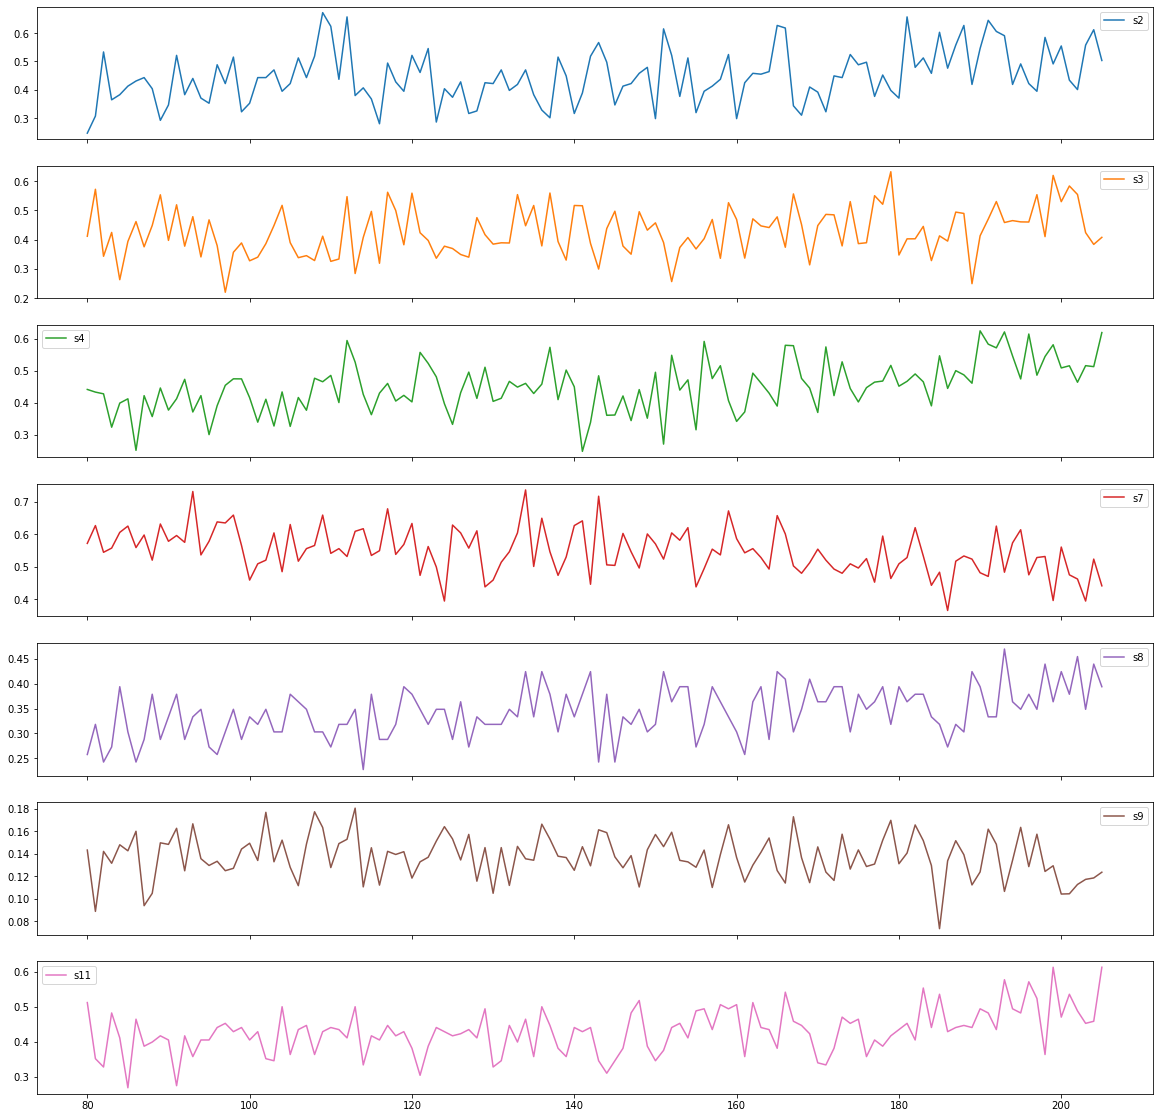

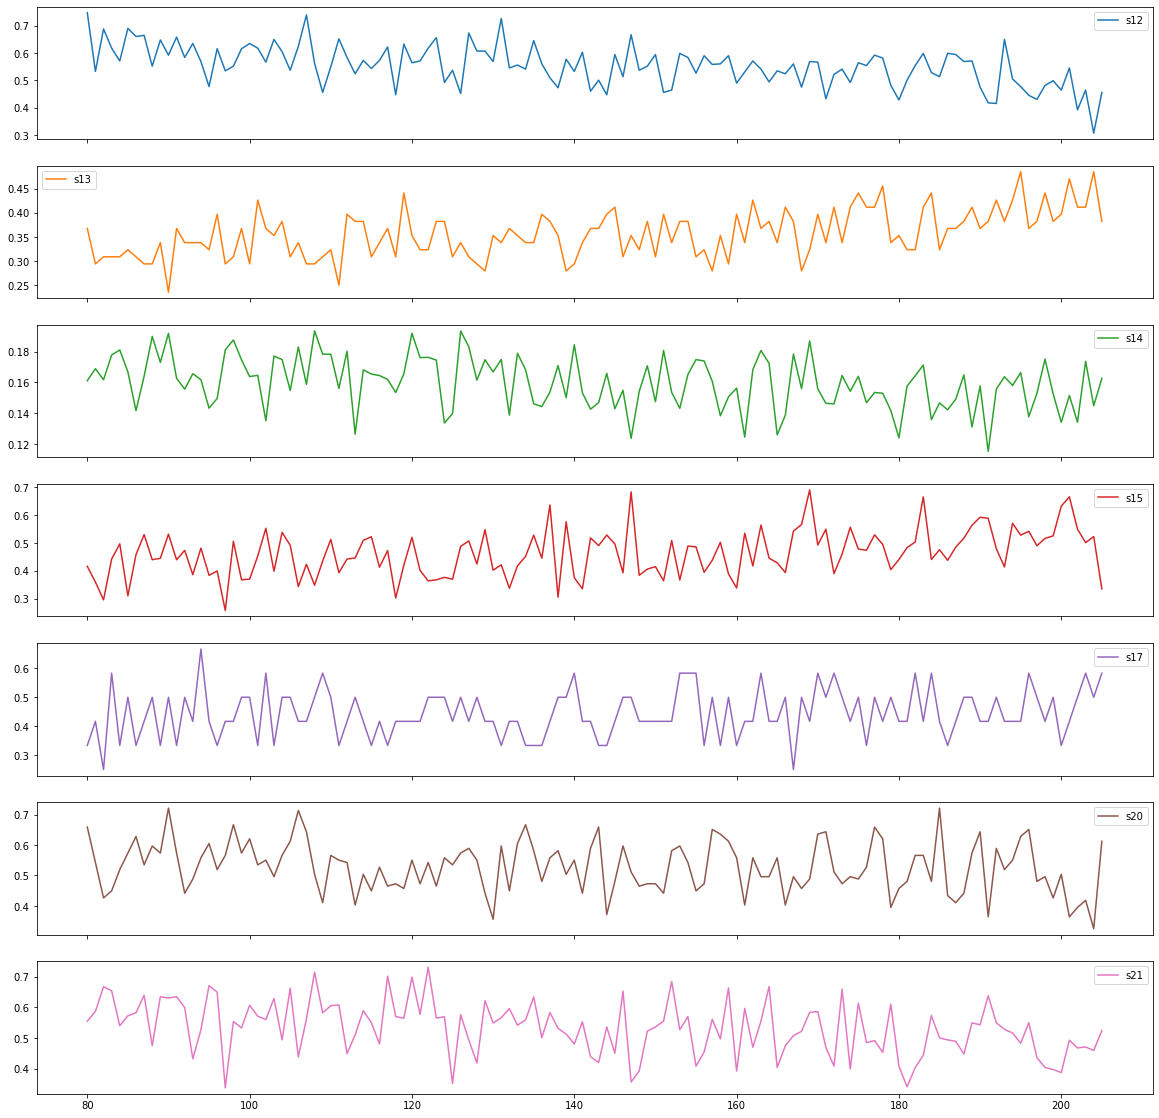

In [22]:
sequence_length = 35
sequence_length_ = 20  # length of sequence for each agent distraction
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's7', 's8', 's9', 's11']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 2, 3, 4, 7, 8, 9, 11
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

# plotting sensor data for engine ID 3 prior to a failure point - sensors 12, 13, 14, 15, 17, 20, 21
ax2 = engine_id3_50cycleWindow2.plot(subplots=True, sharex=True, figsize=(20,20))

## Generate Train Data

In [23]:
# pick the feature columns
sensor_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
sequence_cols = ['setting1', 'setting2', 'cycle_norm']
sequence_cols.extend(sensor_cols)

### generator train data for the sequences for each agent and save in a list

In [24]:
# Train data
# generator train data for the sequences for each agent and save in a list
data_array_ = {}
for i in train_df['id'].unique():
    seq_gen_ = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length_, sequence_cols)) for id in [i])
    data_array_[i] = np.concatenate(list(seq_gen_)).astype(np.float32)

### generate train labels for each agent and save in a list

In [25]:
label_array_ = {}
# generate train labels for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_[i] = np.concatenate(list(label_gen_)).astype(np.float32)

### Generate train labels based on RUL for each agent and save in a list

In [26]:
label_array_rul_ = {}
# Generate train labels based on RUL for each agent and save in a list
for i in train_df['id'].unique():
    label_gen_rul_ = (gen_labels(train_df[train_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_26072/1920039281.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_rul_[i] = np.concatenate(list(label_gen_rul_)).astype(np.int)


In [27]:
# Find the minimum length of dataset for each agent
min_length = label_array_rul_[1].shape[0]
for i in train_df['id'].unique():
    if min_length > label_array_rul_[i].shape[0]:
        min_length = label_array_rul_[i].shape[0]

In [28]:
# set all length of lists to the minimum length of arrays
for i in train_df['id'].unique():
    label_array_rul_[i] = label_array_rul_[i][len(label_array_rul_[i]) - min_length:, :]
    label_array_[i] = label_array_[i][len(label_array_[i]) - min_length:, :]
    data_array_[i] = data_array_[i][len(data_array_[i]) - min_length:, :, :]
    
print(len(data_array_))
print(len(label_array_))
print(len(label_array_rul_))

print(data_array_[1].shape)
print(label_array_[1].shape)
print(label_array_rul_[1].shape)

100
100
100
(108, 20, 17)
(108, 1)
(108, 1)


### generator test data for the sequences for each agent and save in a list

In [29]:
# Test Data
# generator test data for the sequences for each agent and save in a list
seq_array_test_ = {}
for i in test_df['id'].unique():
    seq_gen_test_ = (list(gen_sequence(test_df[test_df['id'] == id], sequence_length_, sequence_cols)) for id in
                     [i])
    seq_array_test_[i] = np.concatenate(list(seq_gen_test_)).astype(np.float32)

### generate test labels for each agent and save in a list

In [30]:
label_array_test_ = {}
# generatAe test labels for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['label1']) for id in [i])
    label_array_test_[i] = np.concatenate(list(label_gen_test_)).astype(np.float32)

### Generate test labels based on RUL for each agent and save in a list

In [31]:
label_array_test_rul_ = {}
# Generate test labels based on RUL for each agent and save in a list
for i in test_df['id'].unique():
    label_gen_test_rul_ = (gen_labels(test_df[test_df['id'] == id], sequence_length_, ['RUL']) for id in [i])
    label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)

C:\Users\LO98E8~1\Temp\234/ipykernel_26072/500274830.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  label_array_test_rul_[i] = np.concatenate(list(label_gen_test_rul_)).astype(np.int)


### Select part of the train set which has the length longer than min_length

In [32]:
seq_array_test_tmp = {}
label_array_test_tmp = {}
label_array_test_rul_tmp = {}
for i in test_df['id'].unique():
    tmp = seq_array_test_[i].shape[0]
    if tmp >= min_length:
        seq_array_test_tmp[i] = seq_array_test_[i]
        label_array_test_tmp[i] = label_array_test_[i]
        label_array_test_rul_tmp[i] = label_array_test_rul_[i]

###  change the key of dictionary and indexing it based on increasing number from 1

In [33]:
# change the key of dictionary and indexing it based on increasing number from 1
seq_array_test_ = {}
label_array_test_ = {}
label_array_test_rul_ = {}
j = 1
for i in seq_array_test_tmp.keys():
    seq_array_test_[j] = seq_array_test_tmp[i]
    label_array_test_[j] = label_array_test_tmp[i]
    label_array_test_rul_[j] = label_array_test_rul_tmp[i]
    j += 1

del seq_array_test_tmp
del label_array_test_tmp
del label_array_test_rul_tmp

# set all length of test lists to the minimum length of arrays (min_length)
for i in seq_array_test_.keys():
    label_array_test_rul_[i] = label_array_test_rul_[i][len(label_array_test_rul_[i]) - min_length:, :]
    label_array_test_[i] = label_array_test_[i][len(label_array_test_[i]) - min_length:, :]
    seq_array_test_[i] = seq_array_test_[i][len(seq_array_test_[i]) - min_length:, :, :]

print(len(seq_array_test_))
print(len(label_array_test_))
print(len(label_array_test_rul_))

print(seq_array_test_[1].shape)
print(label_array_test_[1].shape)
print(label_array_test_rul_[1].shape)

X = {}
Y = {}
for i in data_array_.keys():
    X[i - 1] = data_array_[i].reshape(min_length, -1)
    Y[i - 1] = label_array_rul_[i]

X_test = {}
Y_test = {}
for i in seq_array_test_.keys():
    X_test[i - 1] = seq_array_test_[i].reshape(min_length, -1)
    Y_test[i - 1] = label_array_test_rul_[i]

56
56
56
(108, 20, 17)
(108, 1)
(108, 1)


## The main distributed LSTM model for 10 worker, in case of master and workers

In [34]:
num_workers = 10
array_params = [dict() for i in range(num_workers)]
J = [list() for i in range(num_workers)]

worker_model = {}
for worker_i in range(num_workers):
    worker_model[worker_i] = LSTM()
    array_params[worker_i] = worker_model[worker_i].init_random_params()

iteration_epoch = 3000
for i in range(iteration_epoch):
    print("Number of iteration:", i, "/from", iteration_epoch)
    for worker_i in range(num_workers):
        cost, array_params[worker_i] = worker_model[worker_i].train(X[worker_i], Y[worker_i],
                                                                    array_params[worker_i])
        J[worker_i].append(cost)

    for key in array_params[0]:  # Fed average
        tmp = array_params[0][key]
        for worker_i in range(1, num_workers):
            tmp = tmp + array_params[worker_i][key]
        for worker_i in range(num_workers):
            array_params[worker_i][key] = (1 / num_workers) * tmp  # Distribute aggregate parameters to all workers

Number of iteration: 0 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.4]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.4]
Epoch 0 	Batch: 50 - 75 	Loss: [115.41]
Epoch 1 	Batch: 50 - 75 	Loss: [115.41]
Epoch 2 	Batch: 50 - 75 	Loss: [115.41]
Epoch 0 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [115.14]
Epoch 1 	Batch: 50 - 75 	Loss: [115.11]
Epoch 2 	Batch: 50 - 75 	Loss: [115.08]
Epoch 0 	Batch: 50 - 75 	Loss: [115.09]
Epoch 1 	Batch: 50 - 75 	Loss: [115.06]
Epoch 2 	Batch: 50 - 75 	Loss: [115.02]
Epoch 0 	Batch: 50 - 75 	Loss: [115.08]
Epoch 1 	Batch: 50 - 75 	Loss: [115.05]
Epoch 2 	Batch: 50 - 75 	Loss: [115.01]
Number of iteration: 7 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [114.99]
Epoch 1 	Batch: 50 - 75 	Loss: [114.94]
Epoch 2 	Batch: 50 - 75 	Loss: [114.9]
Epoch 0 	Batch: 50 - 75 	Loss: [114.97]
Epoch 1 	Batch: 50 - 75 	Loss: [114.92]
Epoch 2 	Batch: 50 - 75 	Loss: [114.87]
Epoch 0 	Batch: 50 - 75 	Loss: [114.97]
Epoch 1 	Batch: 50 - 75 	Loss: [114.94]
Epoch 2 	Batch: 50 - 75 	Loss: [114.89]
Epoch 0 	Batch: 50 - 75 	Loss: [115.01]
Epoch 1 	Batch: 50 - 75 	Loss: [114.97]
Epoch 2 	Batch: 50 - 75 	Loss: [114.93]
Epoch 0 	Batch: 50 - 75 	Loss: [114.96]
Epoch 1 	Batch: 50 - 75 	Loss: [114.91]
Epoch 2 	Batch: 50 - 75 	Loss: [114.86]
Epoch 0

Epoch 2 	Batch: 50 - 75 	Loss: [113.77]
Epoch 0 	Batch: 50 - 75 	Loss: [113.79]
Epoch 1 	Batch: 50 - 75 	Loss: [113.71]
Epoch 2 	Batch: 50 - 75 	Loss: [113.63]
Epoch 0 	Batch: 50 - 75 	Loss: [114.31]
Epoch 1 	Batch: 50 - 75 	Loss: [114.25]
Epoch 2 	Batch: 50 - 75 	Loss: [114.2]
Epoch 0 	Batch: 50 - 75 	Loss: [113.97]
Epoch 1 	Batch: 50 - 75 	Loss: [113.9]
Epoch 2 	Batch: 50 - 75 	Loss: [113.81]
Epoch 0 	Batch: 50 - 75 	Loss: [114.14]
Epoch 1 	Batch: 50 - 75 	Loss: [114.08]
Epoch 2 	Batch: 50 - 75 	Loss: [114.02]
Epoch 0 	Batch: 50 - 75 	Loss: [114.12]
Epoch 1 	Batch: 50 - 75 	Loss: [114.05]
Epoch 2 	Batch: 50 - 75 	Loss: [113.98]
Epoch 0 	Batch: 50 - 75 	Loss: [113.79]
Epoch 1 	Batch: 50 - 75 	Loss: [113.71]
Epoch 2 	Batch: 50 - 75 	Loss: [113.63]
Number of iteration: 14 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [113.63]
Epoch 1 	Batch: 50 - 75 	Loss: [113.55]
Epoch 2 	Batch: 50 - 75 	Loss: [113.47]
Epoch 0 	Batch: 50 - 75 	Loss: [113.61]
Epoch 1 	Batch: 50 - 75 	Loss: [113.52]
Epoch 2

Epoch 1 	Batch: 50 - 75 	Loss: [111.92]
Epoch 2 	Batch: 50 - 75 	Loss: [111.82]
Epoch 0 	Batch: 50 - 75 	Loss: [112.09]
Epoch 1 	Batch: 50 - 75 	Loss: [111.99]
Epoch 2 	Batch: 50 - 75 	Loss: [111.89]
Epoch 0 	Batch: 50 - 75 	Loss: [112.49]
Epoch 1 	Batch: 50 - 75 	Loss: [112.4]
Epoch 2 	Batch: 50 - 75 	Loss: [112.31]
Epoch 0 	Batch: 50 - 75 	Loss: [112.14]
Epoch 1 	Batch: 50 - 75 	Loss: [112.04]
Epoch 2 	Batch: 50 - 75 	Loss: [111.94]
Epoch 0 	Batch: 50 - 75 	Loss: [112.06]
Epoch 1 	Batch: 50 - 75 	Loss: [111.96]
Epoch 2 	Batch: 50 - 75 	Loss: [111.85]
Epoch 0 	Batch: 50 - 75 	Loss: [112.95]
Epoch 1 	Batch: 50 - 75 	Loss: [112.86]
Epoch 2 	Batch: 50 - 75 	Loss: [112.78]
Epoch 0 	Batch: 50 - 75 	Loss: [112.28]
Epoch 1 	Batch: 50 - 75 	Loss: [112.18]
Epoch 2 	Batch: 50 - 75 	Loss: [112.09]
Epoch 0 	Batch: 50 - 75 	Loss: [112.5]
Epoch 1 	Batch: 50 - 75 	Loss: [112.4]
Epoch 2 	Batch: 50 - 75 	Loss: [112.3]
Epoch 0 	Batch: 50 - 75 	Loss: [112.76]
Epoch 1 	Batch: 50 - 75 	Loss: [112.73]
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [110.72]
Epoch 1 	Batch: 50 - 75 	Loss: [110.62]
Epoch 2 	Batch: 50 - 75 	Loss: [110.51]
Epoch 0 	Batch: 50 - 75 	Loss: [111.35]
Epoch 1 	Batch: 50 - 75 	Loss: [111.28]
Epoch 2 	Batch: 50 - 75 	Loss: [111.19]
Epoch 0 	Batch: 50 - 75 	Loss: [109.98]
Epoch 1 	Batch: 50 - 75 	Loss: [109.87]
Epoch 2 	Batch: 50 - 75 	Loss: [109.76]
Number of iteration: 27 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [109.8]
Epoch 1 	Batch: 50 - 75 	Loss: [109.69]
Epoch 2 	Batch: 50 - 75 	Loss: [109.57]
Epoch 0 	Batch: 50 - 75 	Loss: [110.02]
Epoch 1 	Batch: 50 - 75 	Loss: [109.91]
Epoch 2 	Batch: 50 - 75 	Loss: [109.8]
Epoch 0 	Batch: 50 - 75 	Loss: [110.56]
Epoch 1 	Batch: 50 - 75 	Loss: [110.45]
Epoch 2 	Batch: 50 - 75 	Loss: [110.34]
Epoch 0 	Batch: 50 - 75 	Loss: [109.91]
Epoch 1 	Batch: 50 - 75 	Loss: [109.8]
Epoch 2 	Batch: 50 - 75 	Loss: [109.68]
Epoch 0 	Batch: 50 - 75 	Loss: [109.94]
Epoch 1 	Batch: 50 - 75 	Loss: [109.83]
Epoch 2 	Batch: 50 - 75 	Loss: [109.72]
Epoch 0 

Epoch 2 	Batch: 50 - 75 	Loss: [107.6]
Epoch 0 	Batch: 50 - 75 	Loss: [107.99]
Epoch 1 	Batch: 50 - 75 	Loss: [107.88]
Epoch 2 	Batch: 50 - 75 	Loss: [107.76]
Epoch 0 	Batch: 50 - 75 	Loss: [109.48]
Epoch 1 	Batch: 50 - 75 	Loss: [109.37]
Epoch 2 	Batch: 50 - 75 	Loss: [109.26]
Epoch 0 	Batch: 50 - 75 	Loss: [108.32]
Epoch 1 	Batch: 50 - 75 	Loss: [108.21]
Epoch 2 	Batch: 50 - 75 	Loss: [108.08]
Epoch 0 	Batch: 50 - 75 	Loss: [108.46]
Epoch 1 	Batch: 50 - 75 	Loss: [108.34]
Epoch 2 	Batch: 50 - 75 	Loss: [108.23]
Epoch 0 	Batch: 50 - 75 	Loss: [109.4]
Epoch 1 	Batch: 50 - 75 	Loss: [109.29]
Epoch 2 	Batch: 50 - 75 	Loss: [109.17]
Epoch 0 	Batch: 50 - 75 	Loss: [107.51]
Epoch 1 	Batch: 50 - 75 	Loss: [107.39]
Epoch 2 	Batch: 50 - 75 	Loss: [107.26]
Number of iteration: 34 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [107.37]
Epoch 1 	Batch: 50 - 75 	Loss: [107.25]
Epoch 2 	Batch: 50 - 75 	Loss: [107.13]
Epoch 0 	Batch: 50 - 75 	Loss: [107.72]
Epoch 1 	Batch: 50 - 75 	Loss: [107.6]
Epoch 2 

Epoch 1 	Batch: 50 - 75 	Loss: [105.07]
Epoch 2 	Batch: 50 - 75 	Loss: [104.95]
Epoch 0 	Batch: 50 - 75 	Loss: [105.69]
Epoch 1 	Batch: 50 - 75 	Loss: [105.57]
Epoch 2 	Batch: 50 - 75 	Loss: [105.44]
Epoch 0 	Batch: 50 - 75 	Loss: [106.5]
Epoch 1 	Batch: 50 - 75 	Loss: [106.38]
Epoch 2 	Batch: 50 - 75 	Loss: [106.26]
Epoch 0 	Batch: 50 - 75 	Loss: [105.32]
Epoch 1 	Batch: 50 - 75 	Loss: [105.21]
Epoch 2 	Batch: 50 - 75 	Loss: [105.09]
Epoch 0 	Batch: 50 - 75 	Loss: [105.59]
Epoch 1 	Batch: 50 - 75 	Loss: [105.47]
Epoch 2 	Batch: 50 - 75 	Loss: [105.34]
Epoch 0 	Batch: 50 - 75 	Loss: [107.3]
Epoch 1 	Batch: 50 - 75 	Loss: [107.18]
Epoch 2 	Batch: 50 - 75 	Loss: [107.06]
Epoch 0 	Batch: 50 - 75 	Loss: [105.98]
Epoch 1 	Batch: 50 - 75 	Loss: [105.87]
Epoch 2 	Batch: 50 - 75 	Loss: [105.74]
Epoch 0 	Batch: 50 - 75 	Loss: [106.05]
Epoch 1 	Batch: 50 - 75 	Loss: [105.93]
Epoch 2 	Batch: 50 - 75 	Loss: [105.8]
Epoch 0 	Batch: 50 - 75 	Loss: [107.24]
Epoch 1 	Batch: 50 - 75 	Loss: [107.15]
Epo

Epoch 2 	Batch: 50 - 75 	Loss: [103.63]
Epoch 0 	Batch: 50 - 75 	Loss: [105.34]
Epoch 1 	Batch: 50 - 75 	Loss: [105.21]
Epoch 2 	Batch: 50 - 75 	Loss: [105.09]
Epoch 0 	Batch: 50 - 75 	Loss: [102.73]
Epoch 1 	Batch: 50 - 75 	Loss: [102.6]
Epoch 2 	Batch: 50 - 75 	Loss: [102.47]
Number of iteration: 47 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [102.56]
Epoch 1 	Batch: 50 - 75 	Loss: [102.44]
Epoch 2 	Batch: 50 - 75 	Loss: [102.32]
Epoch 0 	Batch: 50 - 75 	Loss: [103.22]
Epoch 1 	Batch: 50 - 75 	Loss: [103.1]
Epoch 2 	Batch: 50 - 75 	Loss: [102.97]
Epoch 0 	Batch: 50 - 75 	Loss: [104.16]
Epoch 1 	Batch: 50 - 75 	Loss: [104.04]
Epoch 2 	Batch: 50 - 75 	Loss: [103.91]
Epoch 0 	Batch: 50 - 75 	Loss: [102.82]
Epoch 1 	Batch: 50 - 75 	Loss: [102.71]
Epoch 2 	Batch: 50 - 75 	Loss: [102.59]
Epoch 0 	Batch: 50 - 75 	Loss: [103.15]
Epoch 1 	Batch: 50 - 75 	Loss: [103.03]
Epoch 2 	Batch: 50 - 75 	Loss: [102.91]
Epoch 0 	Batch: 50 - 75 	Loss: [105.11]
Epoch 1 	Batch: 50 - 75 	Loss: [104.99]
Epoch 2

Epoch 1 	Batch: 50 - 75 	Loss: [100.91]
Epoch 2 	Batch: 50 - 75 	Loss: [100.78]
Epoch 0 	Batch: 50 - 75 	Loss: [103.25]
Epoch 1 	Batch: 50 - 75 	Loss: [103.13]
Epoch 2 	Batch: 50 - 75 	Loss: [103.02]
Epoch 0 	Batch: 50 - 75 	Loss: [101.58]
Epoch 1 	Batch: 50 - 75 	Loss: [101.46]
Epoch 2 	Batch: 50 - 75 	Loss: [101.34]
Epoch 0 	Batch: 50 - 75 	Loss: [101.43]
Epoch 1 	Batch: 50 - 75 	Loss: [101.31]
Epoch 2 	Batch: 50 - 75 	Loss: [101.19]
Epoch 0 	Batch: 50 - 75 	Loss: [103.1]
Epoch 1 	Batch: 50 - 75 	Loss: [103.]
Epoch 2 	Batch: 50 - 75 	Loss: [102.87]
Epoch 0 	Batch: 50 - 75 	Loss: [100.07]
Epoch 1 	Batch: 50 - 75 	Loss: [99.94]
Epoch 2 	Batch: 50 - 75 	Loss: [99.81]
Number of iteration: 54 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [100.04]
Epoch 1 	Batch: 50 - 75 	Loss: [99.92]
Epoch 2 	Batch: 50 - 75 	Loss: [99.79]
Epoch 0 	Batch: 50 - 75 	Loss: [100.74]
Epoch 1 	Batch: 50 - 75 	Loss: [100.62]
Epoch 2 	Batch: 50 - 75 	Loss: [100.51]
Epoch 0 	Batch: 50 - 75 	Loss: [101.82]
Epoch 1 	Bat

Epoch 2 	Batch: 50 - 75 	Loss: [98.48]
Epoch 0 	Batch: 50 - 75 	Loss: [99.87]
Epoch 1 	Batch: 50 - 75 	Loss: [99.75]
Epoch 2 	Batch: 50 - 75 	Loss: [99.62]
Epoch 0 	Batch: 50 - 75 	Loss: [98.33]
Epoch 1 	Batch: 50 - 75 	Loss: [98.24]
Epoch 2 	Batch: 50 - 75 	Loss: [98.12]
Epoch 0 	Batch: 50 - 75 	Loss: [98.57]
Epoch 1 	Batch: 50 - 75 	Loss: [98.45]
Epoch 2 	Batch: 50 - 75 	Loss: [98.33]
Epoch 0 	Batch: 50 - 75 	Loss: [101.22]
Epoch 1 	Batch: 50 - 75 	Loss: [101.11]
Epoch 2 	Batch: 50 - 75 	Loss: [100.98]
Epoch 0 	Batch: 50 - 75 	Loss: [99.31]
Epoch 1 	Batch: 50 - 75 	Loss: [99.19]
Epoch 2 	Batch: 50 - 75 	Loss: [99.07]
Epoch 0 	Batch: 50 - 75 	Loss: [98.99]
Epoch 1 	Batch: 50 - 75 	Loss: [98.87]
Epoch 2 	Batch: 50 - 75 	Loss: [98.76]
Epoch 0 	Batch: 50 - 75 	Loss: [100.92]
Epoch 1 	Batch: 50 - 75 	Loss: [100.82]
Epoch 2 	Batch: 50 - 75 	Loss: [100.69]
Epoch 0 	Batch: 50 - 75 	Loss: [97.45]
Epoch 1 	Batch: 50 - 75 	Loss: [97.32]
Epoch 2 	Batch: 50 - 75 	Loss: [97.2]
Number of iteration:

Epoch 1 	Batch: 50 - 75 	Loss: [95.3]
Epoch 2 	Batch: 50 - 75 	Loss: [95.18]
Epoch 0 	Batch: 50 - 75 	Loss: [96.41]
Epoch 1 	Batch: 50 - 75 	Loss: [96.3]
Epoch 2 	Batch: 50 - 75 	Loss: [96.19]
Epoch 0 	Batch: 50 - 75 	Loss: [97.67]
Epoch 1 	Batch: 50 - 75 	Loss: [97.55]
Epoch 2 	Batch: 50 - 75 	Loss: [97.43]
Epoch 0 	Batch: 50 - 75 	Loss: [95.97]
Epoch 1 	Batch: 50 - 75 	Loss: [95.86]
Epoch 2 	Batch: 50 - 75 	Loss: [95.74]
Epoch 0 	Batch: 50 - 75 	Loss: [96.2]
Epoch 1 	Batch: 50 - 75 	Loss: [96.08]
Epoch 2 	Batch: 50 - 75 	Loss: [95.96]
Epoch 0 	Batch: 50 - 75 	Loss: [99.2]
Epoch 1 	Batch: 50 - 75 	Loss: [99.08]
Epoch 2 	Batch: 50 - 75 	Loss: [98.97]
Epoch 0 	Batch: 50 - 75 	Loss: [97.07]
Epoch 1 	Batch: 50 - 75 	Loss: [96.96]
Epoch 2 	Batch: 50 - 75 	Loss: [96.85]
Epoch 0 	Batch: 50 - 75 	Loss: [96.56]
Epoch 1 	Batch: 50 - 75 	Loss: [96.45]
Epoch 2 	Batch: 50 - 75 	Loss: [96.34]
Epoch 0 	Batch: 50 - 75 	Loss: [98.8]
Epoch 1 	Batch: 50 - 75 	Loss: [98.71]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [92.81]
Epoch 1 	Batch: 50 - 75 	Loss: [92.7]
Epoch 2 	Batch: 50 - 75 	Loss: [92.59]
Number of iteration: 74 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [93.04]
Epoch 1 	Batch: 50 - 75 	Loss: [92.93]
Epoch 2 	Batch: 50 - 75 	Loss: [92.82]
Epoch 0 	Batch: 50 - 75 	Loss: [94.26]
Epoch 1 	Batch: 50 - 75 	Loss: [94.17]
Epoch 2 	Batch: 50 - 75 	Loss: [94.06]
Epoch 0 	Batch: 50 - 75 	Loss: [95.59]
Epoch 1 	Batch: 50 - 75 	Loss: [95.48]
Epoch 2 	Batch: 50 - 75 	Loss: [95.37]
Epoch 0 	Batch: 50 - 75 	Loss: [93.76]
Epoch 1 	Batch: 50 - 75 	Loss: [93.65]
Epoch 2 	Batch: 50 - 75 	Loss: [93.53]
Epoch 0 	Batch: 50 - 75 	Loss: [93.91]
Epoch 1 	Batch: 50 - 75 	Loss: [93.81]
Epoch 2 	Batch: 50 - 75 	Loss: [93.7]
Epoch 0 	Batch: 50 - 75 	Loss: [97.33]
Epoch 1 	Batch: 50 - 75 	Loss: [97.22]
Epoch 2 	Batch: 50 - 75 	Loss: [97.09]
Epoch 0 	Batch: 50 - 75 	Loss: [94.92]
Epoch 1 	Batch: 50 - 75 	Loss: [94.82]
Epoch 2 	Batch: 50 - 75 	Loss: [94.7]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [91.98]
Epoch 0 	Batch: 50 - 75 	Loss: [95.09]
Epoch 1 	Batch: 50 - 75 	Loss: [94.99]
Epoch 2 	Batch: 50 - 75 	Loss: [94.87]
Epoch 0 	Batch: 50 - 75 	Loss: [90.47]
Epoch 1 	Batch: 50 - 75 	Loss: [90.35]
Epoch 2 	Batch: 50 - 75 	Loss: [90.24]
Number of iteration: 81 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [90.67]
Epoch 1 	Batch: 50 - 75 	Loss: [90.56]
Epoch 2 	Batch: 50 - 75 	Loss: [90.45]
Epoch 0 	Batch: 50 - 75 	Loss: [92.16]
Epoch 1 	Batch: 50 - 75 	Loss: [92.06]
Epoch 2 	Batch: 50 - 75 	Loss: [91.94]
Epoch 0 	Batch: 50 - 75 	Loss: [93.62]
Epoch 1 	Batch: 50 - 75 	Loss: [93.52]
Epoch 2 	Batch: 50 - 75 	Loss: [93.41]
Epoch 0 	Batch: 50 - 75 	Loss: [91.59]
Epoch 1 	Batch: 50 - 75 	Loss: [91.49]
Epoch 2 	Batch: 50 - 75 	Loss: [91.39]
Epoch 0 	Batch: 50 - 75 	Loss: [91.74]
Epoch 1 	Batch: 50 - 75 	Loss: [91.63]
Epoch 2 	Batch: 50 - 75 	Loss: [91.52]
Epoch 0 	Batch: 50 - 75 	Loss: [95.47]
Epoch 1 	Batch: 50 - 75 	Loss: [95.38]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [91.01]
Epoch 2 	Batch: 50 - 75 	Loss: [90.91]
Epoch 0 	Batch: 50 - 75 	Loss: [89.97]
Epoch 1 	Batch: 50 - 75 	Loss: [89.87]
Epoch 2 	Batch: 50 - 75 	Loss: [89.76]
Epoch 0 	Batch: 50 - 75 	Loss: [93.2]
Epoch 1 	Batch: 50 - 75 	Loss: [93.11]
Epoch 2 	Batch: 50 - 75 	Loss: [93.]
Epoch 0 	Batch: 50 - 75 	Loss: [88.22]
Epoch 1 	Batch: 50 - 75 	Loss: [88.11]
Epoch 2 	Batch: 50 - 75 	Loss: [88.]
Number of iteration: 88 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [88.4]
Epoch 1 	Batch: 50 - 75 	Loss: [88.29]
Epoch 2 	Batch: 50 - 75 	Loss: [88.18]
Epoch 0 	Batch: 50 - 75 	Loss: [90.11]
Epoch 1 	Batch: 50 - 75 	Loss: [90.02]
Epoch 2 	Batch: 50 - 75 	Loss: [89.94]
Epoch 0 	Batch: 50 - 75 	Loss: [91.7]
Epoch 1 	Batch: 50 - 75 	Loss: [91.61]
Epoch 2 	Batch: 50 - 75 	Loss: [91.49]
Epoch 0 	Batch: 50 - 75 	Loss: [89.44]
Epoch 1 	Batch: 50 - 75 	Loss: [89.33]
Epoch 2 	Batch: 50 - 75 	Loss: [89.22]
Epoch 0 	Batch: 50 - 75 	Loss: [89.71]
Epoch 1 	Batch: 50 - 75 	Loss: [89.6

Epoch 0 	Batch: 50 - 75 	Loss: [91.98]
Epoch 1 	Batch: 50 - 75 	Loss: [91.9]
Epoch 2 	Batch: 50 - 75 	Loss: [91.79]
Epoch 0 	Batch: 50 - 75 	Loss: [89.18]
Epoch 1 	Batch: 50 - 75 	Loss: [89.08]
Epoch 2 	Batch: 50 - 75 	Loss: [88.97]
Epoch 0 	Batch: 50 - 75 	Loss: [87.8]
Epoch 1 	Batch: 50 - 75 	Loss: [87.69]
Epoch 2 	Batch: 50 - 75 	Loss: [87.58]
Epoch 0 	Batch: 50 - 75 	Loss: [91.43]
Epoch 1 	Batch: 50 - 75 	Loss: [91.36]
Epoch 2 	Batch: 50 - 75 	Loss: [91.26]
Epoch 0 	Batch: 50 - 75 	Loss: [86.01]
Epoch 1 	Batch: 50 - 75 	Loss: [85.91]
Epoch 2 	Batch: 50 - 75 	Loss: [85.81]
Number of iteration: 95 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [86.23]
Epoch 1 	Batch: 50 - 75 	Loss: [86.13]
Epoch 2 	Batch: 50 - 75 	Loss: [86.02]
Epoch 0 	Batch: 50 - 75 	Loss: [88.27]
Epoch 1 	Batch: 50 - 75 	Loss: [88.18]
Epoch 2 	Batch: 50 - 75 	Loss: [88.06]
Epoch 0 	Batch: 50 - 75 	Loss: [89.85]
Epoch 1 	Batch: 50 - 75 	Loss: [89.77]
Epoch 2 	Batch: 50 - 75 	Loss: [89.66]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [85.43]
Epoch 0 	Batch: 50 - 75 	Loss: [86.2]
Epoch 1 	Batch: 50 - 75 	Loss: [86.11]
Epoch 2 	Batch: 50 - 75 	Loss: [86.]
Epoch 0 	Batch: 50 - 75 	Loss: [90.17]
Epoch 1 	Batch: 50 - 75 	Loss: [90.07]
Epoch 2 	Batch: 50 - 75 	Loss: [89.96]
Epoch 0 	Batch: 50 - 75 	Loss: [87.31]
Epoch 1 	Batch: 50 - 75 	Loss: [87.23]
Epoch 2 	Batch: 50 - 75 	Loss: [87.13]
Epoch 0 	Batch: 50 - 75 	Loss: [85.72]
Epoch 1 	Batch: 50 - 75 	Loss: [85.64]
Epoch 2 	Batch: 50 - 75 	Loss: [85.54]
Epoch 0 	Batch: 50 - 75 	Loss: [89.83]
Epoch 1 	Batch: 50 - 75 	Loss: [89.77]
Epoch 2 	Batch: 50 - 75 	Loss: [89.67]
Epoch 0 	Batch: 50 - 75 	Loss: [83.95]
Epoch 1 	Batch: 50 - 75 	Loss: [83.85]
Epoch 2 	Batch: 50 - 75 	Loss: [83.75]
Number of iteration: 102 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [84.13]
Epoch 1 	Batch: 50 - 75 	Loss: [84.04]
Epoch 2 	Batch: 50 - 75 	Loss: [83.95]
Epoch 0 	Batch: 50 - 75 	Loss: [86.43]
Epoch 1 	Batch: 50 - 75 	Loss: [86.35]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [86.63]
Epoch 2 	Batch: 50 - 75 	Loss: [86.53]
Epoch 0 	Batch: 50 - 75 	Loss: [83.74]
Epoch 1 	Batch: 50 - 75 	Loss: [83.66]
Epoch 2 	Batch: 50 - 75 	Loss: [83.56]
Epoch 0 	Batch: 50 - 75 	Loss: [84.32]
Epoch 1 	Batch: 50 - 75 	Loss: [84.23]
Epoch 2 	Batch: 50 - 75 	Loss: [84.14]
Epoch 0 	Batch: 50 - 75 	Loss: [88.45]
Epoch 1 	Batch: 50 - 75 	Loss: [88.37]
Epoch 2 	Batch: 50 - 75 	Loss: [88.26]
Epoch 0 	Batch: 50 - 75 	Loss: [85.53]
Epoch 1 	Batch: 50 - 75 	Loss: [85.43]
Epoch 2 	Batch: 50 - 75 	Loss: [85.34]
Epoch 0 	Batch: 50 - 75 	Loss: [83.74]
Epoch 1 	Batch: 50 - 75 	Loss: [83.65]
Epoch 2 	Batch: 50 - 75 	Loss: [83.55]
Epoch 0 	Batch: 50 - 75 	Loss: [88.26]
Epoch 1 	Batch: 50 - 75 	Loss: [88.19]
Epoch 2 	Batch: 50 - 75 	Loss: [88.1]
Epoch 0 	Batch: 50 - 75 	Loss: [81.96]
Epoch 1 	Batch: 50 - 75 	Loss: [81.88]
Epoch 2 	Batch: 50 - 75 	Loss: [81.79]
Number of iteration: 109 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [82.2]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [83.11]
Epoch 1 	Batch: 50 - 75 	Loss: [83.02]
Epoch 2 	Batch: 50 - 75 	Loss: [82.92]
Epoch 0 	Batch: 50 - 75 	Loss: [85.11]
Epoch 1 	Batch: 50 - 75 	Loss: [85.04]
Epoch 2 	Batch: 50 - 75 	Loss: [84.94]
Epoch 0 	Batch: 50 - 75 	Loss: [82.12]
Epoch 1 	Batch: 50 - 75 	Loss: [82.07]
Epoch 2 	Batch: 50 - 75 	Loss: [81.98]
Epoch 0 	Batch: 50 - 75 	Loss: [82.51]
Epoch 1 	Batch: 50 - 75 	Loss: [82.42]
Epoch 2 	Batch: 50 - 75 	Loss: [82.32]
Epoch 0 	Batch: 50 - 75 	Loss: [86.9]
Epoch 1 	Batch: 50 - 75 	Loss: [86.83]
Epoch 2 	Batch: 50 - 75 	Loss: [86.75]
Epoch 0 	Batch: 50 - 75 	Loss: [83.79]
Epoch 1 	Batch: 50 - 75 	Loss: [83.72]
Epoch 2 	Batch: 50 - 75 	Loss: [83.63]
Epoch 0 	Batch: 50 - 75 	Loss: [81.85]
Epoch 1 	Batch: 50 - 75 	Loss: [81.76]
Epoch 2 	Batch: 50 - 75 	Loss: [81.67]
Epoch 0 	Batch: 50 - 75 	Loss: [86.74]
Epoch 1 	Batch: 50 - 75 	Loss: [86.68]
Epoch 2 	Batch: 50 - 75 	Loss: [86.57]
Epoch 0 	Batch: 50 - 75 	Loss: [80.19]
Epoch 1 	Batch: 50 - 75 	L

Epoch 2 	Batch: 50 - 75 	Loss: [78.44]
Number of iteration: 122 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [78.86]
Epoch 1 	Batch: 50 - 75 	Loss: [78.78]
Epoch 2 	Batch: 50 - 75 	Loss: [78.69]
Epoch 0 	Batch: 50 - 75 	Loss: [81.4]
Epoch 1 	Batch: 50 - 75 	Loss: [81.33]
Epoch 2 	Batch: 50 - 75 	Loss: [81.25]
Epoch 0 	Batch: 50 - 75 	Loss: [83.56]
Epoch 1 	Batch: 50 - 75 	Loss: [83.49]
Epoch 2 	Batch: 50 - 75 	Loss: [83.4]
Epoch 0 	Batch: 50 - 75 	Loss: [80.53]
Epoch 1 	Batch: 50 - 75 	Loss: [80.46]
Epoch 2 	Batch: 50 - 75 	Loss: [80.37]
Epoch 0 	Batch: 50 - 75 	Loss: [80.75]
Epoch 1 	Batch: 50 - 75 	Loss: [80.68]
Epoch 2 	Batch: 50 - 75 	Loss: [80.6]
Epoch 0 	Batch: 50 - 75 	Loss: [85.49]
Epoch 1 	Batch: 50 - 75 	Loss: [85.4]
Epoch 2 	Batch: 50 - 75 	Loss: [85.3]
Epoch 0 	Batch: 50 - 75 	Loss: [82.12]
Epoch 1 	Batch: 50 - 75 	Loss: [82.03]
Epoch 2 	Batch: 50 - 75 	Loss: [81.94]
Epoch 0 	Batch: 50 - 75 	Loss: [80.05]
Epoch 1 	Batch: 50 - 75 	Loss: [79.98]
Epoch 2 	Batch: 50 - 75 	Loss: [7

Epoch 1 	Batch: 50 - 75 	Loss: [83.93]
Epoch 2 	Batch: 50 - 75 	Loss: [83.85]
Epoch 0 	Batch: 50 - 75 	Loss: [76.91]
Epoch 1 	Batch: 50 - 75 	Loss: [76.85]
Epoch 2 	Batch: 50 - 75 	Loss: [76.76]
Number of iteration: 129 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [77.06]
Epoch 1 	Batch: 50 - 75 	Loss: [76.97]
Epoch 2 	Batch: 50 - 75 	Loss: [76.88]
Epoch 0 	Batch: 50 - 75 	Loss: [79.79]
Epoch 1 	Batch: 50 - 75 	Loss: [79.71]
Epoch 2 	Batch: 50 - 75 	Loss: [79.62]
Epoch 0 	Batch: 50 - 75 	Loss: [82.06]
Epoch 1 	Batch: 50 - 75 	Loss: [82.]
Epoch 2 	Batch: 50 - 75 	Loss: [81.91]
Epoch 0 	Batch: 50 - 75 	Loss: [78.91]
Epoch 1 	Batch: 50 - 75 	Loss: [78.84]
Epoch 2 	Batch: 50 - 75 	Loss: [78.76]
Epoch 0 	Batch: 50 - 75 	Loss: [79.12]
Epoch 1 	Batch: 50 - 75 	Loss: [79.03]
Epoch 2 	Batch: 50 - 75 	Loss: [78.94]
Epoch 0 	Batch: 50 - 75 	Loss: [83.95]
Epoch 1 	Batch: 50 - 75 	Loss: [83.89]
Epoch 2 	Batch: 50 - 75 	Loss: [83.81]
Epoch 0 	Batch: 50 - 75 	Loss: [80.5]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [76.84]
Epoch 1 	Batch: 50 - 75 	Loss: [76.78]
Epoch 2 	Batch: 50 - 75 	Loss: [76.69]
Epoch 0 	Batch: 50 - 75 	Loss: [82.65]
Epoch 1 	Batch: 50 - 75 	Loss: [82.61]
Epoch 2 	Batch: 50 - 75 	Loss: [82.51]
Epoch 0 	Batch: 50 - 75 	Loss: [75.25]
Epoch 1 	Batch: 50 - 75 	Loss: [75.18]
Epoch 2 	Batch: 50 - 75 	Loss: [75.1]
Number of iteration: 136 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [75.3]
Epoch 1 	Batch: 50 - 75 	Loss: [75.22]
Epoch 2 	Batch: 50 - 75 	Loss: [75.13]
Epoch 0 	Batch: 50 - 75 	Loss: [78.22]
Epoch 1 	Batch: 50 - 75 	Loss: [78.16]
Epoch 2 	Batch: 50 - 75 	Loss: [78.07]
Epoch 0 	Batch: 50 - 75 	Loss: [80.64]
Epoch 1 	Batch: 50 - 75 	Loss: [80.58]
Epoch 2 	Batch: 50 - 75 	Loss: [80.48]
Epoch 0 	Batch: 50 - 75 	Loss: [77.28]
Epoch 1 	Batch: 50 - 75 	Loss: [77.2]
Epoch 2 	Batch: 50 - 75 	Loss: [77.11]
Epoch 0 	Batch: 50 - 75 	Loss: [77.48]
Epoch 1 	Batch: 50 - 75 	Loss: [77.41]
Epoch 2 	Batch: 50 - 75 	Loss: [77.33]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [81.21]
Epoch 0 	Batch: 50 - 75 	Loss: [77.73]
Epoch 1 	Batch: 50 - 75 	Loss: [77.66]
Epoch 2 	Batch: 50 - 75 	Loss: [77.57]
Epoch 0 	Batch: 50 - 75 	Loss: [75.29]
Epoch 1 	Batch: 50 - 75 	Loss: [75.24]
Epoch 2 	Batch: 50 - 75 	Loss: [75.16]
Epoch 0 	Batch: 50 - 75 	Loss: [81.36]
Epoch 1 	Batch: 50 - 75 	Loss: [81.3]
Epoch 2 	Batch: 50 - 75 	Loss: [81.22]
Epoch 0 	Batch: 50 - 75 	Loss: [73.66]
Epoch 1 	Batch: 50 - 75 	Loss: [73.62]
Epoch 2 	Batch: 50 - 75 	Loss: [73.54]
Number of iteration: 143 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [73.63]
Epoch 1 	Batch: 50 - 75 	Loss: [73.56]
Epoch 2 	Batch: 50 - 75 	Loss: [73.48]
Epoch 0 	Batch: 50 - 75 	Loss: [76.78]
Epoch 1 	Batch: 50 - 75 	Loss: [76.71]
Epoch 2 	Batch: 50 - 75 	Loss: [76.63]
Epoch 0 	Batch: 50 - 75 	Loss: [79.3]
Epoch 1 	Batch: 50 - 75 	Loss: [79.25]
Epoch 2 	Batch: 50 - 75 	Loss: [79.17]
Epoch 0 	Batch: 50 - 75 	Loss: [75.78]
Epoch 1 	Batch: 50 - 75 	Loss: [75.73]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [74.71]
Epoch 2 	Batch: 50 - 75 	Loss: [74.63]
Epoch 0 	Batch: 50 - 75 	Loss: [79.99]
Epoch 1 	Batch: 50 - 75 	Loss: [79.93]
Epoch 2 	Batch: 50 - 75 	Loss: [79.84]
Epoch 0 	Batch: 50 - 75 	Loss: [76.29]
Epoch 1 	Batch: 50 - 75 	Loss: [76.23]
Epoch 2 	Batch: 50 - 75 	Loss: [76.16]
Epoch 0 	Batch: 50 - 75 	Loss: [73.74]
Epoch 1 	Batch: 50 - 75 	Loss: [73.68]
Epoch 2 	Batch: 50 - 75 	Loss: [73.6]
Epoch 0 	Batch: 50 - 75 	Loss: [80.14]
Epoch 1 	Batch: 50 - 75 	Loss: [80.12]
Epoch 2 	Batch: 50 - 75 	Loss: [80.03]
Epoch 0 	Batch: 50 - 75 	Loss: [72.17]
Epoch 1 	Batch: 50 - 75 	Loss: [72.1]
Epoch 2 	Batch: 50 - 75 	Loss: [72.02]
Number of iteration: 150 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [72.09]
Epoch 1 	Batch: 50 - 75 	Loss: [72.02]
Epoch 2 	Batch: 50 - 75 	Loss: [71.96]
Epoch 0 	Batch: 50 - 75 	Loss: [75.39]
Epoch 1 	Batch: 50 - 75 	Loss: [75.33]
Epoch 2 	Batch: 50 - 75 	Loss: [75.25]
Epoch 0 	Batch: 50 - 75 	Loss: [78.05]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [73.12]
Epoch 1 	Batch: 50 - 75 	Loss: [73.06]
Epoch 2 	Batch: 50 - 75 	Loss: [72.98]
Epoch 0 	Batch: 50 - 75 	Loss: [73.46]
Epoch 1 	Batch: 50 - 75 	Loss: [73.42]
Epoch 2 	Batch: 50 - 75 	Loss: [73.35]
Epoch 0 	Batch: 50 - 75 	Loss: [78.75]
Epoch 1 	Batch: 50 - 75 	Loss: [78.67]
Epoch 2 	Batch: 50 - 75 	Loss: [78.59]
Epoch 0 	Batch: 50 - 75 	Loss: [74.92]
Epoch 1 	Batch: 50 - 75 	Loss: [74.86]
Epoch 2 	Batch: 50 - 75 	Loss: [74.77]
Epoch 0 	Batch: 50 - 75 	Loss: [72.28]
Epoch 1 	Batch: 50 - 75 	Loss: [72.21]
Epoch 2 	Batch: 50 - 75 	Loss: [72.14]
Epoch 0 	Batch: 50 - 75 	Loss: [78.94]
Epoch 1 	Batch: 50 - 75 	Loss: [78.89]
Epoch 2 	Batch: 50 - 75 	Loss: [78.82]
Epoch 0 	Batch: 50 - 75 	Loss: [70.69]
Epoch 1 	Batch: 50 - 75 	Loss: [70.62]
Epoch 2 	Batch: 50 - 75 	Loss: [70.55]
Number of iteration: 157 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [70.65]
Epoch 1 	Batch: 50 - 75 	Loss: [70.58]
Epoch 2 	Batch: 50 - 75 	Loss: [70.52]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [72.89]
Epoch 0 	Batch: 50 - 75 	Loss: [75.87]
Epoch 1 	Batch: 50 - 75 	Loss: [75.84]
Epoch 2 	Batch: 50 - 75 	Loss: [75.77]
Epoch 0 	Batch: 50 - 75 	Loss: [71.81]
Epoch 1 	Batch: 50 - 75 	Loss: [71.76]
Epoch 2 	Batch: 50 - 75 	Loss: [71.7]
Epoch 0 	Batch: 50 - 75 	Loss: [72.24]
Epoch 1 	Batch: 50 - 75 	Loss: [72.18]
Epoch 2 	Batch: 50 - 75 	Loss: [72.1]
Epoch 0 	Batch: 50 - 75 	Loss: [77.47]
Epoch 1 	Batch: 50 - 75 	Loss: [77.42]
Epoch 2 	Batch: 50 - 75 	Loss: [77.34]
Epoch 0 	Batch: 50 - 75 	Loss: [73.65]
Epoch 1 	Batch: 50 - 75 	Loss: [73.6]
Epoch 2 	Batch: 50 - 75 	Loss: [73.53]
Epoch 0 	Batch: 50 - 75 	Loss: [71.]
Epoch 1 	Batch: 50 - 75 	Loss: [70.93]
Epoch 2 	Batch: 50 - 75 	Loss: [70.85]
Epoch 0 	Batch: 50 - 75 	Loss: [77.8]
Epoch 1 	Batch: 50 - 75 	Loss: [77.79]
Epoch 2 	Batch: 50 - 75 	Loss: [77.7]
Epoch 0 	Batch: 50 - 75 	Loss: [69.29]
Epoch 1 	Batch: 50 - 75 	Loss: [69.22]
Epoch 2 	Batch: 50 - 75 	Loss: [69.15]
Number of iteration: 164 /from 3

Epoch 1 	Batch: 50 - 75 	Loss: [68.06]
Epoch 2 	Batch: 50 - 75 	Loss: [67.99]
Epoch 0 	Batch: 50 - 75 	Loss: [71.76]
Epoch 1 	Batch: 50 - 75 	Loss: [71.72]
Epoch 2 	Batch: 50 - 75 	Loss: [71.66]
Epoch 0 	Batch: 50 - 75 	Loss: [74.83]
Epoch 1 	Batch: 50 - 75 	Loss: [74.79]
Epoch 2 	Batch: 50 - 75 	Loss: [74.71]
Epoch 0 	Batch: 50 - 75 	Loss: [70.64]
Epoch 1 	Batch: 50 - 75 	Loss: [70.59]
Epoch 2 	Batch: 50 - 75 	Loss: [70.51]
Epoch 0 	Batch: 50 - 75 	Loss: [71.02]
Epoch 1 	Batch: 50 - 75 	Loss: [70.96]
Epoch 2 	Batch: 50 - 75 	Loss: [70.89]
Epoch 0 	Batch: 50 - 75 	Loss: [76.27]
Epoch 1 	Batch: 50 - 75 	Loss: [76.19]
Epoch 2 	Batch: 50 - 75 	Loss: [76.12]
Epoch 0 	Batch: 50 - 75 	Loss: [72.38]
Epoch 1 	Batch: 50 - 75 	Loss: [72.31]
Epoch 2 	Batch: 50 - 75 	Loss: [72.23]
Epoch 0 	Batch: 50 - 75 	Loss: [69.67]
Epoch 1 	Batch: 50 - 75 	Loss: [69.6]
Epoch 2 	Batch: 50 - 75 	Loss: [69.53]
Epoch 0 	Batch: 50 - 75 	Loss: [76.66]
Epoch 1 	Batch: 50 - 75 	Loss: [76.62]
Epoch 2 	Batch: 50 - 75 	L

Epoch 0 	Batch: 50 - 75 	Loss: [66.92]
Epoch 1 	Batch: 50 - 75 	Loss: [66.86]
Epoch 2 	Batch: 50 - 75 	Loss: [66.82]
Number of iteration: 177 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [66.83]
Epoch 1 	Batch: 50 - 75 	Loss: [66.77]
Epoch 2 	Batch: 50 - 75 	Loss: [66.7]
Epoch 0 	Batch: 50 - 75 	Loss: [70.7]
Epoch 1 	Batch: 50 - 75 	Loss: [70.67]
Epoch 2 	Batch: 50 - 75 	Loss: [70.6]
Epoch 0 	Batch: 50 - 75 	Loss: [73.78]
Epoch 1 	Batch: 50 - 75 	Loss: [73.72]
Epoch 2 	Batch: 50 - 75 	Loss: [73.65]
Epoch 0 	Batch: 50 - 75 	Loss: [69.51]
Epoch 1 	Batch: 50 - 75 	Loss: [69.46]
Epoch 2 	Batch: 50 - 75 	Loss: [69.39]
Epoch 0 	Batch: 50 - 75 	Loss: [69.88]
Epoch 1 	Batch: 50 - 75 	Loss: [69.82]
Epoch 2 	Batch: 50 - 75 	Loss: [69.75]
Epoch 0 	Batch: 50 - 75 	Loss: [75.12]
Epoch 1 	Batch: 50 - 75 	Loss: [75.08]
Epoch 2 	Batch: 50 - 75 	Loss: [75.]
Epoch 0 	Batch: 50 - 75 	Loss: [71.19]
Epoch 1 	Batch: 50 - 75 	Loss: [71.14]
Epoch 2 	Batch: 50 - 75 	Loss: [71.1]
Epoch 0 	Batch: 50 - 75 	Loss: [68

Epoch 2 	Batch: 50 - 75 	Loss: [67.47]
Epoch 0 	Batch: 50 - 75 	Loss: [74.7]
Epoch 1 	Batch: 50 - 75 	Loss: [74.68]
Epoch 2 	Batch: 50 - 75 	Loss: [74.6]
Epoch 0 	Batch: 50 - 75 	Loss: [65.82]
Epoch 1 	Batch: 50 - 75 	Loss: [65.76]
Epoch 2 	Batch: 50 - 75 	Loss: [65.7]
Number of iteration: 184 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [65.57]
Epoch 1 	Batch: 50 - 75 	Loss: [65.51]
Epoch 2 	Batch: 50 - 75 	Loss: [65.45]
Epoch 0 	Batch: 50 - 75 	Loss: [69.58]
Epoch 1 	Batch: 50 - 75 	Loss: [69.54]
Epoch 2 	Batch: 50 - 75 	Loss: [69.47]
Epoch 0 	Batch: 50 - 75 	Loss: [72.78]
Epoch 1 	Batch: 50 - 75 	Loss: [72.75]
Epoch 2 	Batch: 50 - 75 	Loss: [72.67]
Epoch 0 	Batch: 50 - 75 	Loss: [68.38]
Epoch 1 	Batch: 50 - 75 	Loss: [68.33]
Epoch 2 	Batch: 50 - 75 	Loss: [68.26]
Epoch 0 	Batch: 50 - 75 	Loss: [68.81]
Epoch 1 	Batch: 50 - 75 	Loss: [68.76]
Epoch 2 	Batch: 50 - 75 	Loss: [68.69]
Epoch 0 	Batch: 50 - 75 	Loss: [73.89]
Epoch 1 	Batch: 50 - 75 	Loss: [73.83]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [69.05]
Epoch 2 	Batch: 50 - 75 	Loss: [68.98]
Epoch 0 	Batch: 50 - 75 	Loss: [66.57]
Epoch 1 	Batch: 50 - 75 	Loss: [66.53]
Epoch 2 	Batch: 50 - 75 	Loss: [66.48]
Epoch 0 	Batch: 50 - 75 	Loss: [73.66]
Epoch 1 	Batch: 50 - 75 	Loss: [73.63]
Epoch 2 	Batch: 50 - 75 	Loss: [73.56]
Epoch 0 	Batch: 50 - 75 	Loss: [64.64]
Epoch 1 	Batch: 50 - 75 	Loss: [64.58]
Epoch 2 	Batch: 50 - 75 	Loss: [64.53]
Number of iteration: 191 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [64.39]
Epoch 1 	Batch: 50 - 75 	Loss: [64.34]
Epoch 2 	Batch: 50 - 75 	Loss: [64.28]
Epoch 0 	Batch: 50 - 75 	Loss: [68.46]
Epoch 1 	Batch: 50 - 75 	Loss: [68.42]
Epoch 2 	Batch: 50 - 75 	Loss: [68.35]
Epoch 0 	Batch: 50 - 75 	Loss: [71.84]
Epoch 1 	Batch: 50 - 75 	Loss: [71.8]
Epoch 2 	Batch: 50 - 75 	Loss: [71.73]
Epoch 0 	Batch: 50 - 75 	Loss: [67.31]
Epoch 1 	Batch: 50 - 75 	Loss: [67.26]
Epoch 2 	Batch: 50 - 75 	Loss: [67.19]
Epoch 0 	Batch: 50 - 75 	Loss: [67.66]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [71.69]
Epoch 1 	Batch: 50 - 75 	Loss: [71.62]
Epoch 2 	Batch: 50 - 75 	Loss: [71.54]
Epoch 0 	Batch: 50 - 75 	Loss: [68.07]
Epoch 1 	Batch: 50 - 75 	Loss: [68.03]
Epoch 2 	Batch: 50 - 75 	Loss: [67.99]
Epoch 0 	Batch: 50 - 75 	Loss: [65.6]
Epoch 1 	Batch: 50 - 75 	Loss: [65.57]
Epoch 2 	Batch: 50 - 75 	Loss: [65.52]
Epoch 0 	Batch: 50 - 75 	Loss: [72.72]
Epoch 1 	Batch: 50 - 75 	Loss: [72.7]
Epoch 2 	Batch: 50 - 75 	Loss: [72.62]
Epoch 0 	Batch: 50 - 75 	Loss: [63.55]
Epoch 1 	Batch: 50 - 75 	Loss: [63.51]
Epoch 2 	Batch: 50 - 75 	Loss: [63.46]
Number of iteration: 198 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [63.39]
Epoch 1 	Batch: 50 - 75 	Loss: [63.35]
Epoch 2 	Batch: 50 - 75 	Loss: [63.29]
Epoch 0 	Batch: 50 - 75 	Loss: [67.5]
Epoch 1 	Batch: 50 - 75 	Loss: [67.46]
Epoch 2 	Batch: 50 - 75 	Loss: [67.39]
Epoch 0 	Batch: 50 - 75 	Loss: [70.97]
Epoch 1 	Batch: 50 - 75 	Loss: [70.95]
Epoch 2 	Batch: 50 - 75 	Loss: [70.87]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [65.44]
Epoch 0 	Batch: 50 - 75 	Loss: [65.79]
Epoch 1 	Batch: 50 - 75 	Loss: [65.74]
Epoch 2 	Batch: 50 - 75 	Loss: [65.69]
Epoch 0 	Batch: 50 - 75 	Loss: [70.64]
Epoch 1 	Batch: 50 - 75 	Loss: [70.61]
Epoch 2 	Batch: 50 - 75 	Loss: [70.55]
Epoch 0 	Batch: 50 - 75 	Loss: [67.15]
Epoch 1 	Batch: 50 - 75 	Loss: [67.09]
Epoch 2 	Batch: 50 - 75 	Loss: [67.02]
Epoch 0 	Batch: 50 - 75 	Loss: [64.64]
Epoch 1 	Batch: 50 - 75 	Loss: [64.59]
Epoch 2 	Batch: 50 - 75 	Loss: [64.53]
Epoch 0 	Batch: 50 - 75 	Loss: [71.8]
Epoch 1 	Batch: 50 - 75 	Loss: [71.77]
Epoch 2 	Batch: 50 - 75 	Loss: [71.69]
Epoch 0 	Batch: 50 - 75 	Loss: [62.56]
Epoch 1 	Batch: 50 - 75 	Loss: [62.52]
Epoch 2 	Batch: 50 - 75 	Loss: [62.47]
Number of iteration: 205 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [62.49]
Epoch 1 	Batch: 50 - 75 	Loss: [62.44]
Epoch 2 	Batch: 50 - 75 	Loss: [62.38]
Epoch 0 	Batch: 50 - 75 	Loss: [66.5]
Epoch 1 	Batch: 50 - 75 	Loss: [66.46]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [69.46]
Epoch 2 	Batch: 50 - 75 	Loss: [69.39]
Epoch 0 	Batch: 50 - 75 	Loss: [64.56]
Epoch 1 	Batch: 50 - 75 	Loss: [64.51]
Epoch 2 	Batch: 50 - 75 	Loss: [64.45]
Epoch 0 	Batch: 50 - 75 	Loss: [64.89]
Epoch 1 	Batch: 50 - 75 	Loss: [64.84]
Epoch 2 	Batch: 50 - 75 	Loss: [64.78]
Epoch 0 	Batch: 50 - 75 	Loss: [69.63]
Epoch 1 	Batch: 50 - 75 	Loss: [69.58]
Epoch 2 	Batch: 50 - 75 	Loss: [69.5]
Epoch 0 	Batch: 50 - 75 	Loss: [66.13]
Epoch 1 	Batch: 50 - 75 	Loss: [66.09]
Epoch 2 	Batch: 50 - 75 	Loss: [66.04]
Epoch 0 	Batch: 50 - 75 	Loss: [63.82]
Epoch 1 	Batch: 50 - 75 	Loss: [63.78]
Epoch 2 	Batch: 50 - 75 	Loss: [63.72]
Epoch 0 	Batch: 50 - 75 	Loss: [70.89]
Epoch 1 	Batch: 50 - 75 	Loss: [70.88]
Epoch 2 	Batch: 50 - 75 	Loss: [70.81]
Epoch 0 	Batch: 50 - 75 	Loss: [61.57]
Epoch 1 	Batch: 50 - 75 	Loss: [61.52]
Epoch 2 	Batch: 50 - 75 	Loss: [61.46]
Number of iteration: 212 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [61.5]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [60.51]
Epoch 2 	Batch: 50 - 75 	Loss: [60.47]
Epoch 0 	Batch: 50 - 75 	Loss: [64.59]
Epoch 1 	Batch: 50 - 75 	Loss: [64.56]
Epoch 2 	Batch: 50 - 75 	Loss: [64.5]
Epoch 0 	Batch: 50 - 75 	Loss: [68.76]
Epoch 1 	Batch: 50 - 75 	Loss: [68.75]
Epoch 2 	Batch: 50 - 75 	Loss: [68.69]
Epoch 0 	Batch: 50 - 75 	Loss: [63.53]
Epoch 1 	Batch: 50 - 75 	Loss: [63.5]
Epoch 2 	Batch: 50 - 75 	Loss: [63.44]
Epoch 0 	Batch: 50 - 75 	Loss: [63.89]
Epoch 1 	Batch: 50 - 75 	Loss: [63.84]
Epoch 2 	Batch: 50 - 75 	Loss: [63.77]
Epoch 0 	Batch: 50 - 75 	Loss: [68.6]
Epoch 1 	Batch: 50 - 75 	Loss: [68.56]
Epoch 2 	Batch: 50 - 75 	Loss: [68.51]
Epoch 0 	Batch: 50 - 75 	Loss: [65.16]
Epoch 1 	Batch: 50 - 75 	Loss: [65.1]
Epoch 2 	Batch: 50 - 75 	Loss: [65.04]
Epoch 0 	Batch: 50 - 75 	Loss: [62.94]
Epoch 1 	Batch: 50 - 75 	Loss: [62.9]
Epoch 2 	Batch: 50 - 75 	Loss: [62.84]
Epoch 0 	Batch: 50 - 75 	Loss: [70.03]
Epoch 1 	Batch: 50 - 75 	Loss: [69.99]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [59.9]
Epoch 1 	Batch: 50 - 75 	Loss: [59.9]
Epoch 2 	Batch: 50 - 75 	Loss: [59.87]
Number of iteration: 225 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [59.54]
Epoch 1 	Batch: 50 - 75 	Loss: [59.5]
Epoch 2 	Batch: 50 - 75 	Loss: [59.46]
Epoch 0 	Batch: 50 - 75 	Loss: [63.64]
Epoch 1 	Batch: 50 - 75 	Loss: [63.59]
Epoch 2 	Batch: 50 - 75 	Loss: [63.53]
Epoch 0 	Batch: 50 - 75 	Loss: [68.06]
Epoch 1 	Batch: 50 - 75 	Loss: [68.02]
Epoch 2 	Batch: 50 - 75 	Loss: [67.96]
Epoch 0 	Batch: 50 - 75 	Loss: [62.52]
Epoch 1 	Batch: 50 - 75 	Loss: [62.47]
Epoch 2 	Batch: 50 - 75 	Loss: [62.41]
Epoch 0 	Batch: 50 - 75 	Loss: [63.01]
Epoch 1 	Batch: 50 - 75 	Loss: [62.98]
Epoch 2 	Batch: 50 - 75 	Loss: [62.93]
Epoch 0 	Batch: 50 - 75 	Loss: [67.68]
Epoch 1 	Batch: 50 - 75 	Loss: [67.64]
Epoch 2 	Batch: 50 - 75 	Loss: [67.57]
Epoch 0 	Batch: 50 - 75 	Loss: [64.2]
Epoch 1 	Batch: 50 - 75 	Loss: [64.16]
Epoch 2 	Batch: 50 - 75 	Loss: [64.12]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [61.15]
Epoch 0 	Batch: 50 - 75 	Loss: [68.54]
Epoch 1 	Batch: 50 - 75 	Loss: [68.55]
Epoch 2 	Batch: 50 - 75 	Loss: [68.49]
Epoch 0 	Batch: 50 - 75 	Loss: [59.4]
Epoch 1 	Batch: 50 - 75 	Loss: [59.38]
Epoch 2 	Batch: 50 - 75 	Loss: [59.34]
Number of iteration: 232 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [58.8]
Epoch 1 	Batch: 50 - 75 	Loss: [58.76]
Epoch 2 	Batch: 50 - 75 	Loss: [58.71]
Epoch 0 	Batch: 50 - 75 	Loss: [62.77]
Epoch 1 	Batch: 50 - 75 	Loss: [62.76]
Epoch 2 	Batch: 50 - 75 	Loss: [62.7]
Epoch 0 	Batch: 50 - 75 	Loss: [67.61]
Epoch 1 	Batch: 50 - 75 	Loss: [67.62]
Epoch 2 	Batch: 50 - 75 	Loss: [67.55]
Epoch 0 	Batch: 50 - 75 	Loss: [61.73]
Epoch 1 	Batch: 50 - 75 	Loss: [61.69]
Epoch 2 	Batch: 50 - 75 	Loss: [61.63]
Epoch 0 	Batch: 50 - 75 	Loss: [62.23]
Epoch 1 	Batch: 50 - 75 	Loss: [62.2]
Epoch 2 	Batch: 50 - 75 	Loss: [62.14]
Epoch 0 	Batch: 50 - 75 	Loss: [66.76]
Epoch 1 	Batch: 50 - 75 	Loss: [66.75]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [62.58]
Epoch 2 	Batch: 50 - 75 	Loss: [62.53]
Epoch 0 	Batch: 50 - 75 	Loss: [60.55]
Epoch 1 	Batch: 50 - 75 	Loss: [60.54]
Epoch 2 	Batch: 50 - 75 	Loss: [60.49]
Epoch 0 	Batch: 50 - 75 	Loss: [67.91]
Epoch 1 	Batch: 50 - 75 	Loss: [67.88]
Epoch 2 	Batch: 50 - 75 	Loss: [67.81]
Epoch 0 	Batch: 50 - 75 	Loss: [58.53]
Epoch 1 	Batch: 50 - 75 	Loss: [58.48]
Epoch 2 	Batch: 50 - 75 	Loss: [58.43]
Number of iteration: 239 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.88]
Epoch 1 	Batch: 50 - 75 	Loss: [57.84]
Epoch 2 	Batch: 50 - 75 	Loss: [57.79]
Epoch 0 	Batch: 50 - 75 	Loss: [61.88]
Epoch 1 	Batch: 50 - 75 	Loss: [61.85]
Epoch 2 	Batch: 50 - 75 	Loss: [61.79]
Epoch 0 	Batch: 50 - 75 	Loss: [67.28]
Epoch 1 	Batch: 50 - 75 	Loss: [67.24]
Epoch 2 	Batch: 50 - 75 	Loss: [67.19]
Epoch 0 	Batch: 50 - 75 	Loss: [60.91]
Epoch 1 	Batch: 50 - 75 	Loss: [60.86]
Epoch 2 	Batch: 50 - 75 	Loss: [60.81]
Epoch 0 	Batch: 50 - 75 	Loss: [61.35]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [60.54]
Epoch 2 	Batch: 50 - 75 	Loss: [60.48]
Epoch 0 	Batch: 50 - 75 	Loss: [65.2]
Epoch 1 	Batch: 50 - 75 	Loss: [65.16]
Epoch 2 	Batch: 50 - 75 	Loss: [65.1]
Epoch 0 	Batch: 50 - 75 	Loss: [61.81]
Epoch 1 	Batch: 50 - 75 	Loss: [61.75]
Epoch 2 	Batch: 50 - 75 	Loss: [61.7]
Epoch 0 	Batch: 50 - 75 	Loss: [59.94]
Epoch 1 	Batch: 50 - 75 	Loss: [59.93]
Epoch 2 	Batch: 50 - 75 	Loss: [59.89]
Epoch 0 	Batch: 50 - 75 	Loss: [67.13]
Epoch 1 	Batch: 50 - 75 	Loss: [67.13]
Epoch 2 	Batch: 50 - 75 	Loss: [67.07]
Epoch 0 	Batch: 50 - 75 	Loss: [57.61]
Epoch 1 	Batch: 50 - 75 	Loss: [57.57]
Epoch 2 	Batch: 50 - 75 	Loss: [57.52]
Number of iteration: 246 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [57.]
Epoch 1 	Batch: 50 - 75 	Loss: [56.96]
Epoch 2 	Batch: 50 - 75 	Loss: [56.91]
Epoch 0 	Batch: 50 - 75 	Loss: [60.98]
Epoch 1 	Batch: 50 - 75 	Loss: [60.96]
Epoch 2 	Batch: 50 - 75 	Loss: [60.9]
Epoch 0 	Batch: 50 - 75 	Loss: [66.81]
Epoch 1 	Batch: 50 - 75 	Loss: [66

Epoch 0 	Batch: 50 - 75 	Loss: [59.06]
Epoch 1 	Batch: 50 - 75 	Loss: [59.04]
Epoch 2 	Batch: 50 - 75 	Loss: [58.99]
Epoch 0 	Batch: 50 - 75 	Loss: [59.66]
Epoch 1 	Batch: 50 - 75 	Loss: [59.61]
Epoch 2 	Batch: 50 - 75 	Loss: [59.55]
Epoch 0 	Batch: 50 - 75 	Loss: [64.37]
Epoch 1 	Batch: 50 - 75 	Loss: [64.32]
Epoch 2 	Batch: 50 - 75 	Loss: [64.25]
Epoch 0 	Batch: 50 - 75 	Loss: [60.93]
Epoch 1 	Batch: 50 - 75 	Loss: [60.89]
Epoch 2 	Batch: 50 - 75 	Loss: [60.85]
Epoch 0 	Batch: 50 - 75 	Loss: [59.22]
Epoch 1 	Batch: 50 - 75 	Loss: [59.22]
Epoch 2 	Batch: 50 - 75 	Loss: [59.18]
Epoch 0 	Batch: 50 - 75 	Loss: [66.43]
Epoch 1 	Batch: 50 - 75 	Loss: [66.4]
Epoch 2 	Batch: 50 - 75 	Loss: [66.33]
Epoch 0 	Batch: 50 - 75 	Loss: [56.85]
Epoch 1 	Batch: 50 - 75 	Loss: [56.82]
Epoch 2 	Batch: 50 - 75 	Loss: [56.77]
Number of iteration: 253 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [56.16]
Epoch 1 	Batch: 50 - 75 	Loss: [56.12]
Epoch 2 	Batch: 50 - 75 	Loss: [56.08]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [59.29]
Epoch 0 	Batch: 50 - 75 	Loss: [66.1]
Epoch 1 	Batch: 50 - 75 	Loss: [66.07]
Epoch 2 	Batch: 50 - 75 	Loss: [66.02]
Epoch 0 	Batch: 50 - 75 	Loss: [58.23]
Epoch 1 	Batch: 50 - 75 	Loss: [58.2]
Epoch 2 	Batch: 50 - 75 	Loss: [58.16]
Epoch 0 	Batch: 50 - 75 	Loss: [58.82]
Epoch 1 	Batch: 50 - 75 	Loss: [58.77]
Epoch 2 	Batch: 50 - 75 	Loss: [58.72]
Epoch 0 	Batch: 50 - 75 	Loss: [63.57]
Epoch 1 	Batch: 50 - 75 	Loss: [63.55]
Epoch 2 	Batch: 50 - 75 	Loss: [63.51]
Epoch 0 	Batch: 50 - 75 	Loss: [60.22]
Epoch 1 	Batch: 50 - 75 	Loss: [60.17]
Epoch 2 	Batch: 50 - 75 	Loss: [60.11]
Epoch 0 	Batch: 50 - 75 	Loss: [58.61]
Epoch 1 	Batch: 50 - 75 	Loss: [58.61]
Epoch 2 	Batch: 50 - 75 	Loss: [58.57]
Epoch 0 	Batch: 50 - 75 	Loss: [65.59]
Epoch 1 	Batch: 50 - 75 	Loss: [65.57]
Epoch 2 	Batch: 50 - 75 	Loss: [65.49]
Epoch 0 	Batch: 50 - 75 	Loss: [56.12]
Epoch 1 	Batch: 50 - 75 	Loss: [56.09]
Epoch 2 	Batch: 50 - 75 	Loss: [56.11]
Number of iteration: 260 /f

Epoch 1 	Batch: 50 - 75 	Loss: [54.83]
Epoch 2 	Batch: 50 - 75 	Loss: [54.79]
Epoch 0 	Batch: 50 - 75 	Loss: [58.51]
Epoch 1 	Batch: 50 - 75 	Loss: [58.47]
Epoch 2 	Batch: 50 - 75 	Loss: [58.42]
Epoch 0 	Batch: 50 - 75 	Loss: [65.99]
Epoch 1 	Batch: 50 - 75 	Loss: [66.03]
Epoch 2 	Batch: 50 - 75 	Loss: [65.96]
Epoch 0 	Batch: 50 - 75 	Loss: [57.43]
Epoch 1 	Batch: 50 - 75 	Loss: [57.4]
Epoch 2 	Batch: 50 - 75 	Loss: [57.35]
Epoch 0 	Batch: 50 - 75 	Loss: [58.02]
Epoch 1 	Batch: 50 - 75 	Loss: [57.98]
Epoch 2 	Batch: 50 - 75 	Loss: [57.93]
Epoch 0 	Batch: 50 - 75 	Loss: [62.91]
Epoch 1 	Batch: 50 - 75 	Loss: [62.88]
Epoch 2 	Batch: 50 - 75 	Loss: [62.83]
Epoch 0 	Batch: 50 - 75 	Loss: [59.44]
Epoch 1 	Batch: 50 - 75 	Loss: [59.4]
Epoch 2 	Batch: 50 - 75 	Loss: [59.35]
Epoch 0 	Batch: 50 - 75 	Loss: [57.9]
Epoch 1 	Batch: 50 - 75 	Loss: [57.87]
Epoch 2 	Batch: 50 - 75 	Loss: [57.82]
Epoch 0 	Batch: 50 - 75 	Loss: [64.9]
Epoch 1 	Batch: 50 - 75 	Loss: [64.88]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [54.83]
Epoch 1 	Batch: 50 - 75 	Loss: [54.8]
Epoch 2 	Batch: 50 - 75 	Loss: [54.76]
Number of iteration: 273 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [54.13]
Epoch 1 	Batch: 50 - 75 	Loss: [54.1]
Epoch 2 	Batch: 50 - 75 	Loss: [54.06]
Epoch 0 	Batch: 50 - 75 	Loss: [57.63]
Epoch 1 	Batch: 50 - 75 	Loss: [57.61]
Epoch 2 	Batch: 50 - 75 	Loss: [57.57]
Epoch 0 	Batch: 50 - 75 	Loss: [65.54]
Epoch 1 	Batch: 50 - 75 	Loss: [65.5]
Epoch 2 	Batch: 50 - 75 	Loss: [65.45]
Epoch 0 	Batch: 50 - 75 	Loss: [56.57]
Epoch 1 	Batch: 50 - 75 	Loss: [56.53]
Epoch 2 	Batch: 50 - 75 	Loss: [56.48]
Epoch 0 	Batch: 50 - 75 	Loss: [57.23]
Epoch 1 	Batch: 50 - 75 	Loss: [57.2]
Epoch 2 	Batch: 50 - 75 	Loss: [57.16]
Epoch 0 	Batch: 50 - 75 	Loss: [62.29]
Epoch 1 	Batch: 50 - 75 	Loss: [62.3]
Epoch 2 	Batch: 50 - 75 	Loss: [62.27]
Epoch 0 	Batch: 50 - 75 	Loss: [58.68]
Epoch 1 	Batch: 50 - 75 	Loss: [58.66]
Epoch 2 	Batch: 50 - 75 	Loss: [58.6]
Epoch 0 	Batch: 50 - 75 	Loss: [57

Epoch 2 	Batch: 50 - 75 	Loss: [56.56]
Epoch 0 	Batch: 50 - 75 	Loss: [63.98]
Epoch 1 	Batch: 50 - 75 	Loss: [63.97]
Epoch 2 	Batch: 50 - 75 	Loss: [63.91]
Epoch 0 	Batch: 50 - 75 	Loss: [54.22]
Epoch 1 	Batch: 50 - 75 	Loss: [54.19]
Epoch 2 	Batch: 50 - 75 	Loss: [54.15]
Number of iteration: 280 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [53.48]
Epoch 1 	Batch: 50 - 75 	Loss: [53.47]
Epoch 2 	Batch: 50 - 75 	Loss: [53.45]
Epoch 0 	Batch: 50 - 75 	Loss: [56.89]
Epoch 1 	Batch: 50 - 75 	Loss: [56.85]
Epoch 2 	Batch: 50 - 75 	Loss: [56.79]
Epoch 0 	Batch: 50 - 75 	Loss: [65.15]
Epoch 1 	Batch: 50 - 75 	Loss: [65.15]
Epoch 2 	Batch: 50 - 75 	Loss: [65.07]
Epoch 0 	Batch: 50 - 75 	Loss: [55.78]
Epoch 1 	Batch: 50 - 75 	Loss: [55.74]
Epoch 2 	Batch: 50 - 75 	Loss: [55.7]
Epoch 0 	Batch: 50 - 75 	Loss: [56.5]
Epoch 1 	Batch: 50 - 75 	Loss: [56.47]
Epoch 2 	Batch: 50 - 75 	Loss: [56.42]
Epoch 0 	Batch: 50 - 75 	Loss: [61.59]
Epoch 1 	Batch: 50 - 75 	Loss: [61.54]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [57.35]
Epoch 2 	Batch: 50 - 75 	Loss: [57.3]
Epoch 0 	Batch: 50 - 75 	Loss: [56.13]
Epoch 1 	Batch: 50 - 75 	Loss: [56.09]
Epoch 2 	Batch: 50 - 75 	Loss: [56.05]
Epoch 0 	Batch: 50 - 75 	Loss: [63.61]
Epoch 1 	Batch: 50 - 75 	Loss: [63.6]
Epoch 2 	Batch: 50 - 75 	Loss: [63.53]
Epoch 0 	Batch: 50 - 75 	Loss: [53.61]
Epoch 1 	Batch: 50 - 75 	Loss: [53.58]
Epoch 2 	Batch: 50 - 75 	Loss: [53.54]
Number of iteration: 287 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.84]
Epoch 1 	Batch: 50 - 75 	Loss: [52.83]
Epoch 2 	Batch: 50 - 75 	Loss: [52.79]
Epoch 0 	Batch: 50 - 75 	Loss: [56.11]
Epoch 1 	Batch: 50 - 75 	Loss: [56.09]
Epoch 2 	Batch: 50 - 75 	Loss: [56.04]
Epoch 0 	Batch: 50 - 75 	Loss: [64.54]
Epoch 1 	Batch: 50 - 75 	Loss: [64.5]
Epoch 2 	Batch: 50 - 75 	Loss: [64.44]
Epoch 0 	Batch: 50 - 75 	Loss: [55.]
Epoch 1 	Batch: 50 - 75 	Loss: [54.97]
Epoch 2 	Batch: 50 - 75 	Loss: [54.92]
Epoch 0 	Batch: 50 - 75 	Loss: [55.75]
Epoch 1 	Batch: 50 - 75 	Loss: [5

Epoch 0 	Batch: 50 - 75 	Loss: [59.97]
Epoch 1 	Batch: 50 - 75 	Loss: [59.93]
Epoch 2 	Batch: 50 - 75 	Loss: [59.86]
Epoch 0 	Batch: 50 - 75 	Loss: [56.74]
Epoch 1 	Batch: 50 - 75 	Loss: [56.7]
Epoch 2 	Batch: 50 - 75 	Loss: [56.65]
Epoch 0 	Batch: 50 - 75 	Loss: [55.61]
Epoch 1 	Batch: 50 - 75 	Loss: [55.63]
Epoch 2 	Batch: 50 - 75 	Loss: [55.58]
Epoch 0 	Batch: 50 - 75 	Loss: [62.99]
Epoch 1 	Batch: 50 - 75 	Loss: [62.98]
Epoch 2 	Batch: 50 - 75 	Loss: [62.91]
Epoch 0 	Batch: 50 - 75 	Loss: [53.1]
Epoch 1 	Batch: 50 - 75 	Loss: [53.09]
Epoch 2 	Batch: 50 - 75 	Loss: [53.09]
Number of iteration: 294 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [52.27]
Epoch 1 	Batch: 50 - 75 	Loss: [52.24]
Epoch 2 	Batch: 50 - 75 	Loss: [52.21]
Epoch 0 	Batch: 50 - 75 	Loss: [55.4]
Epoch 1 	Batch: 50 - 75 	Loss: [55.37]
Epoch 2 	Batch: 50 - 75 	Loss: [55.32]
Epoch 0 	Batch: 50 - 75 	Loss: [63.97]
Epoch 1 	Batch: 50 - 75 	Loss: [63.99]
Epoch 2 	Batch: 50 - 75 	Loss: [63.92]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [53.51]
Epoch 0 	Batch: 50 - 75 	Loss: [54.25]
Epoch 1 	Batch: 50 - 75 	Loss: [54.2]
Epoch 2 	Batch: 50 - 75 	Loss: [54.15]
Epoch 0 	Batch: 50 - 75 	Loss: [59.16]
Epoch 1 	Batch: 50 - 75 	Loss: [59.13]
Epoch 2 	Batch: 50 - 75 	Loss: [59.07]
Epoch 0 	Batch: 50 - 75 	Loss: [55.99]
Epoch 1 	Batch: 50 - 75 	Loss: [55.95]
Epoch 2 	Batch: 50 - 75 	Loss: [55.9]
Epoch 0 	Batch: 50 - 75 	Loss: [55.01]
Epoch 1 	Batch: 50 - 75 	Loss: [55.03]
Epoch 2 	Batch: 50 - 75 	Loss: [54.99]
Epoch 0 	Batch: 50 - 75 	Loss: [62.37]
Epoch 1 	Batch: 50 - 75 	Loss: [62.36]
Epoch 2 	Batch: 50 - 75 	Loss: [62.28]
Epoch 0 	Batch: 50 - 75 	Loss: [52.55]
Epoch 1 	Batch: 50 - 75 	Loss: [52.51]
Epoch 2 	Batch: 50 - 75 	Loss: [52.5]
Number of iteration: 301 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [51.54]
Epoch 1 	Batch: 50 - 75 	Loss: [51.5]
Epoch 2 	Batch: 50 - 75 	Loss: [51.46]
Epoch 0 	Batch: 50 - 75 	Loss: [54.63]
Epoch 1 	Batch: 50 - 75 	Loss: [54.61]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [62.58]
Epoch 2 	Batch: 50 - 75 	Loss: [62.51]
Epoch 0 	Batch: 50 - 75 	Loss: [52.85]
Epoch 1 	Batch: 50 - 75 	Loss: [52.81]
Epoch 2 	Batch: 50 - 75 	Loss: [52.77]
Epoch 0 	Batch: 50 - 75 	Loss: [53.38]
Epoch 1 	Batch: 50 - 75 	Loss: [53.34]
Epoch 2 	Batch: 50 - 75 	Loss: [53.3]
Epoch 0 	Batch: 50 - 75 	Loss: [58.29]
Epoch 1 	Batch: 50 - 75 	Loss: [58.25]
Epoch 2 	Batch: 50 - 75 	Loss: [58.2]
Epoch 0 	Batch: 50 - 75 	Loss: [55.18]
Epoch 1 	Batch: 50 - 75 	Loss: [55.14]
Epoch 2 	Batch: 50 - 75 	Loss: [55.08]
Epoch 0 	Batch: 50 - 75 	Loss: [54.52]
Epoch 1 	Batch: 50 - 75 	Loss: [54.49]
Epoch 2 	Batch: 50 - 75 	Loss: [54.45]
Epoch 0 	Batch: 50 - 75 	Loss: [61.74]
Epoch 1 	Batch: 50 - 75 	Loss: [61.71]
Epoch 2 	Batch: 50 - 75 	Loss: [61.66]
Epoch 0 	Batch: 50 - 75 	Loss: [51.9]
Epoch 1 	Batch: 50 - 75 	Loss: [51.87]
Epoch 2 	Batch: 50 - 75 	Loss: [51.83]
Number of iteration: 308 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [50.82]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [53.29]
Epoch 1 	Batch: 50 - 75 	Loss: [53.25]
Epoch 2 	Batch: 50 - 75 	Loss: [53.2]
Epoch 0 	Batch: 50 - 75 	Loss: [61.91]
Epoch 1 	Batch: 50 - 75 	Loss: [61.91]
Epoch 2 	Batch: 50 - 75 	Loss: [61.84]
Epoch 0 	Batch: 50 - 75 	Loss: [52.11]
Epoch 1 	Batch: 50 - 75 	Loss: [52.09]
Epoch 2 	Batch: 50 - 75 	Loss: [52.05]
Epoch 0 	Batch: 50 - 75 	Loss: [52.56]
Epoch 1 	Batch: 50 - 75 	Loss: [52.54]
Epoch 2 	Batch: 50 - 75 	Loss: [52.5]
Epoch 0 	Batch: 50 - 75 	Loss: [57.41]
Epoch 1 	Batch: 50 - 75 	Loss: [57.4]
Epoch 2 	Batch: 50 - 75 	Loss: [57.38]
Epoch 0 	Batch: 50 - 75 	Loss: [54.45]
Epoch 1 	Batch: 50 - 75 	Loss: [54.42]
Epoch 2 	Batch: 50 - 75 	Loss: [54.38]
Epoch 0 	Batch: 50 - 75 	Loss: [54.02]
Epoch 1 	Batch: 50 - 75 	Loss: [54.02]
Epoch 2 	Batch: 50 - 75 	Loss: [53.98]
Epoch 0 	Batch: 50 - 75 	Loss: [61.3]
Epoch 1 	Batch: 50 - 75 	Loss: [61.32]
Epoch 2 	Batch: 50 - 75 	Loss: [61.26]
Epoch 0 	Batch: 50 - 75 	Loss: [51.19]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [50.59]
Number of iteration: 321 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.87]
Epoch 1 	Batch: 50 - 75 	Loss: [49.83]
Epoch 2 	Batch: 50 - 75 	Loss: [49.79]
Epoch 0 	Batch: 50 - 75 	Loss: [52.55]
Epoch 1 	Batch: 50 - 75 	Loss: [52.52]
Epoch 2 	Batch: 50 - 75 	Loss: [52.47]
Epoch 0 	Batch: 50 - 75 	Loss: [61.21]
Epoch 1 	Batch: 50 - 75 	Loss: [61.16]
Epoch 2 	Batch: 50 - 75 	Loss: [61.1]
Epoch 0 	Batch: 50 - 75 	Loss: [51.41]
Epoch 1 	Batch: 50 - 75 	Loss: [51.38]
Epoch 2 	Batch: 50 - 75 	Loss: [51.34]
Epoch 0 	Batch: 50 - 75 	Loss: [51.75]
Epoch 1 	Batch: 50 - 75 	Loss: [51.71]
Epoch 2 	Batch: 50 - 75 	Loss: [51.67]
Epoch 0 	Batch: 50 - 75 	Loss: [56.61]
Epoch 1 	Batch: 50 - 75 	Loss: [56.58]
Epoch 2 	Batch: 50 - 75 	Loss: [56.56]
Epoch 0 	Batch: 50 - 75 	Loss: [53.71]
Epoch 1 	Batch: 50 - 75 	Loss: [53.67]
Epoch 2 	Batch: 50 - 75 	Loss: [53.62]
Epoch 0 	Batch: 50 - 75 	Loss: [53.74]
Epoch 1 	Batch: 50 - 75 	Loss: [53.72]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [60.33]
Epoch 2 	Batch: 50 - 75 	Loss: [60.27]
Epoch 0 	Batch: 50 - 75 	Loss: [50.04]
Epoch 1 	Batch: 50 - 75 	Loss: [50.02]
Epoch 2 	Batch: 50 - 75 	Loss: [49.98]
Number of iteration: 328 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [49.21]
Epoch 1 	Batch: 50 - 75 	Loss: [49.19]
Epoch 2 	Batch: 50 - 75 	Loss: [49.16]
Epoch 0 	Batch: 50 - 75 	Loss: [51.85]
Epoch 1 	Batch: 50 - 75 	Loss: [51.82]
Epoch 2 	Batch: 50 - 75 	Loss: [51.78]
Epoch 0 	Batch: 50 - 75 	Loss: [60.56]
Epoch 1 	Batch: 50 - 75 	Loss: [60.57]
Epoch 2 	Batch: 50 - 75 	Loss: [60.5]
Epoch 0 	Batch: 50 - 75 	Loss: [50.74]
Epoch 1 	Batch: 50 - 75 	Loss: [50.74]
Epoch 2 	Batch: 50 - 75 	Loss: [50.71]
Epoch 0 	Batch: 50 - 75 	Loss: [50.97]
Epoch 1 	Batch: 50 - 75 	Loss: [50.94]
Epoch 2 	Batch: 50 - 75 	Loss: [50.9]
Epoch 0 	Batch: 50 - 75 	Loss: [55.76]
Epoch 1 	Batch: 50 - 75 	Loss: [55.72]
Epoch 2 	Batch: 50 - 75 	Loss: [55.67]
Epoch 0 	Batch: 50 - 75 	Loss: [53.]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [52.85]
Epoch 1 	Batch: 50 - 75 	Loss: [52.82]
Epoch 2 	Batch: 50 - 75 	Loss: [52.77]
Epoch 0 	Batch: 50 - 75 	Loss: [59.91]
Epoch 1 	Batch: 50 - 75 	Loss: [59.92]
Epoch 2 	Batch: 50 - 75 	Loss: [59.87]
Epoch 0 	Batch: 50 - 75 	Loss: [49.54]
Epoch 1 	Batch: 50 - 75 	Loss: [49.52]
Epoch 2 	Batch: 50 - 75 	Loss: [49.49]
Number of iteration: 335 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [48.87]
Epoch 1 	Batch: 50 - 75 	Loss: [48.84]
Epoch 2 	Batch: 50 - 75 	Loss: [48.8]
Epoch 0 	Batch: 50 - 75 	Loss: [51.15]
Epoch 1 	Batch: 50 - 75 	Loss: [51.12]
Epoch 2 	Batch: 50 - 75 	Loss: [51.07]
Epoch 0 	Batch: 50 - 75 	Loss: [60.05]
Epoch 1 	Batch: 50 - 75 	Loss: [60.01]
Epoch 2 	Batch: 50 - 75 	Loss: [59.96]
Epoch 0 	Batch: 50 - 75 	Loss: [50.27]
Epoch 1 	Batch: 50 - 75 	Loss: [50.24]
Epoch 2 	Batch: 50 - 75 	Loss: [50.2]
Epoch 0 	Batch: 50 - 75 	Loss: [50.31]
Epoch 1 	Batch: 50 - 75 	Loss: [50.28]
Epoch 2 	Batch: 50 - 75 	Loss: [50.24]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [54.25]
Epoch 0 	Batch: 50 - 75 	Loss: [51.84]
Epoch 1 	Batch: 50 - 75 	Loss: [51.8]
Epoch 2 	Batch: 50 - 75 	Loss: [51.76]
Epoch 0 	Batch: 50 - 75 	Loss: [52.39]
Epoch 1 	Batch: 50 - 75 	Loss: [52.42]
Epoch 2 	Batch: 50 - 75 	Loss: [52.38]
Epoch 0 	Batch: 50 - 75 	Loss: [59.26]
Epoch 1 	Batch: 50 - 75 	Loss: [59.22]
Epoch 2 	Batch: 50 - 75 	Loss: [59.16]
Epoch 0 	Batch: 50 - 75 	Loss: [48.97]
Epoch 1 	Batch: 50 - 75 	Loss: [48.93]
Epoch 2 	Batch: 50 - 75 	Loss: [48.89]
Number of iteration: 342 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [48.31]
Epoch 1 	Batch: 50 - 75 	Loss: [48.3]
Epoch 2 	Batch: 50 - 75 	Loss: [48.27]
Epoch 0 	Batch: 50 - 75 	Loss: [50.46]
Epoch 1 	Batch: 50 - 75 	Loss: [50.45]
Epoch 2 	Batch: 50 - 75 	Loss: [50.41]
Epoch 0 	Batch: 50 - 75 	Loss: [59.32]
Epoch 1 	Batch: 50 - 75 	Loss: [59.3]
Epoch 2 	Batch: 50 - 75 	Loss: [59.23]
Epoch 0 	Batch: 50 - 75 	Loss: [49.63]
Epoch 1 	Batch: 50 - 75 	Loss: [49.61]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [49.]
Epoch 2 	Batch: 50 - 75 	Loss: [48.97]
Epoch 0 	Batch: 50 - 75 	Loss: [53.59]
Epoch 1 	Batch: 50 - 75 	Loss: [53.56]
Epoch 2 	Batch: 50 - 75 	Loss: [53.51]
Epoch 0 	Batch: 50 - 75 	Loss: [51.24]
Epoch 1 	Batch: 50 - 75 	Loss: [51.21]
Epoch 2 	Batch: 50 - 75 	Loss: [51.18]
Epoch 0 	Batch: 50 - 75 	Loss: [52.13]
Epoch 1 	Batch: 50 - 75 	Loss: [52.16]
Epoch 2 	Batch: 50 - 75 	Loss: [52.14]
Epoch 0 	Batch: 50 - 75 	Loss: [58.68]
Epoch 1 	Batch: 50 - 75 	Loss: [58.67]
Epoch 2 	Batch: 50 - 75 	Loss: [58.61]
Epoch 0 	Batch: 50 - 75 	Loss: [48.42]
Epoch 1 	Batch: 50 - 75 	Loss: [48.4]
Epoch 2 	Batch: 50 - 75 	Loss: [48.39]
Number of iteration: 349 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.72]
Epoch 1 	Batch: 50 - 75 	Loss: [47.71]
Epoch 2 	Batch: 50 - 75 	Loss: [47.7]
Epoch 0 	Batch: 50 - 75 	Loss: [49.96]
Epoch 1 	Batch: 50 - 75 	Loss: [49.93]
Epoch 2 	Batch: 50 - 75 	Loss: [49.88]
Epoch 0 	Batch: 50 - 75 	Loss: [58.67]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [48.42]
Epoch 1 	Batch: 50 - 75 	Loss: [48.41]
Epoch 2 	Batch: 50 - 75 	Loss: [48.37]
Epoch 0 	Batch: 50 - 75 	Loss: [48.41]
Epoch 1 	Batch: 50 - 75 	Loss: [48.39]
Epoch 2 	Batch: 50 - 75 	Loss: [48.35]
Epoch 0 	Batch: 50 - 75 	Loss: [52.9]
Epoch 1 	Batch: 50 - 75 	Loss: [52.88]
Epoch 2 	Batch: 50 - 75 	Loss: [52.85]
Epoch 0 	Batch: 50 - 75 	Loss: [50.72]
Epoch 1 	Batch: 50 - 75 	Loss: [50.68]
Epoch 2 	Batch: 50 - 75 	Loss: [50.63]
Epoch 0 	Batch: 50 - 75 	Loss: [51.61]
Epoch 1 	Batch: 50 - 75 	Loss: [51.59]
Epoch 2 	Batch: 50 - 75 	Loss: [51.54]
Epoch 0 	Batch: 50 - 75 	Loss: [58.04]
Epoch 1 	Batch: 50 - 75 	Loss: [58.02]
Epoch 2 	Batch: 50 - 75 	Loss: [57.96]
Epoch 0 	Batch: 50 - 75 	Loss: [48.1]
Epoch 1 	Batch: 50 - 75 	Loss: [48.07]
Epoch 2 	Batch: 50 - 75 	Loss: [48.04]
Number of iteration: 356 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [47.24]
Epoch 1 	Batch: 50 - 75 	Loss: [47.21]
Epoch 2 	Batch: 50 - 75 	Loss: [47.18]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [48.97]
Epoch 0 	Batch: 50 - 75 	Loss: [58.01]
Epoch 1 	Batch: 50 - 75 	Loss: [58.]
Epoch 2 	Batch: 50 - 75 	Loss: [57.93]
Epoch 0 	Batch: 50 - 75 	Loss: [47.88]
Epoch 1 	Batch: 50 - 75 	Loss: [47.85]
Epoch 2 	Batch: 50 - 75 	Loss: [47.82]
Epoch 0 	Batch: 50 - 75 	Loss: [47.76]
Epoch 1 	Batch: 50 - 75 	Loss: [47.73]
Epoch 2 	Batch: 50 - 75 	Loss: [47.7]
Epoch 0 	Batch: 50 - 75 	Loss: [52.23]
Epoch 1 	Batch: 50 - 75 	Loss: [52.19]
Epoch 2 	Batch: 50 - 75 	Loss: [52.14]
Epoch 0 	Batch: 50 - 75 	Loss: [50.12]
Epoch 1 	Batch: 50 - 75 	Loss: [50.11]
Epoch 2 	Batch: 50 - 75 	Loss: [50.08]
Epoch 0 	Batch: 50 - 75 	Loss: [50.92]
Epoch 1 	Batch: 50 - 75 	Loss: [50.88]
Epoch 2 	Batch: 50 - 75 	Loss: [50.83]
Epoch 0 	Batch: 50 - 75 	Loss: [57.54]
Epoch 1 	Batch: 50 - 75 	Loss: [57.54]
Epoch 2 	Batch: 50 - 75 	Loss: [57.48]
Epoch 0 	Batch: 50 - 75 	Loss: [47.51]
Epoch 1 	Batch: 50 - 75 	Loss: [47.49]
Epoch 2 	Batch: 50 - 75 	Loss: [47.46]
Number of iteration: 363 /fr

Epoch 1 	Batch: 50 - 75 	Loss: [46.25]
Epoch 2 	Batch: 50 - 75 	Loss: [46.23]
Epoch 0 	Batch: 50 - 75 	Loss: [48.56]
Epoch 1 	Batch: 50 - 75 	Loss: [48.53]
Epoch 2 	Batch: 50 - 75 	Loss: [48.49]
Epoch 0 	Batch: 50 - 75 	Loss: [57.37]
Epoch 1 	Batch: 50 - 75 	Loss: [57.33]
Epoch 2 	Batch: 50 - 75 	Loss: [57.27]
Epoch 0 	Batch: 50 - 75 	Loss: [47.32]
Epoch 1 	Batch: 50 - 75 	Loss: [47.29]
Epoch 2 	Batch: 50 - 75 	Loss: [47.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.22]
Epoch 1 	Batch: 50 - 75 	Loss: [47.2]
Epoch 2 	Batch: 50 - 75 	Loss: [47.17]
Epoch 0 	Batch: 50 - 75 	Loss: [51.6]
Epoch 1 	Batch: 50 - 75 	Loss: [51.56]
Epoch 2 	Batch: 50 - 75 	Loss: [51.51]
Epoch 0 	Batch: 50 - 75 	Loss: [49.67]
Epoch 1 	Batch: 50 - 75 	Loss: [49.63]
Epoch 2 	Batch: 50 - 75 	Loss: [49.58]
Epoch 0 	Batch: 50 - 75 	Loss: [50.45]
Epoch 1 	Batch: 50 - 75 	Loss: [50.51]
Epoch 2 	Batch: 50 - 75 	Loss: [50.49]
Epoch 0 	Batch: 50 - 75 	Loss: [56.94]
Epoch 1 	Batch: 50 - 75 	Loss: [56.92]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [46.66]
Epoch 1 	Batch: 50 - 75 	Loss: [46.63]
Epoch 2 	Batch: 50 - 75 	Loss: [46.6]
Number of iteration: 376 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.76]
Epoch 1 	Batch: 50 - 75 	Loss: [45.74]
Epoch 2 	Batch: 50 - 75 	Loss: [45.72]
Epoch 0 	Batch: 50 - 75 	Loss: [47.88]
Epoch 1 	Batch: 50 - 75 	Loss: [47.86]
Epoch 2 	Batch: 50 - 75 	Loss: [47.82]
Epoch 0 	Batch: 50 - 75 	Loss: [56.78]
Epoch 1 	Batch: 50 - 75 	Loss: [56.79]
Epoch 2 	Batch: 50 - 75 	Loss: [56.73]
Epoch 0 	Batch: 50 - 75 	Loss: [46.74]
Epoch 1 	Batch: 50 - 75 	Loss: [46.72]
Epoch 2 	Batch: 50 - 75 	Loss: [46.69]
Epoch 0 	Batch: 50 - 75 	Loss: [46.58]
Epoch 1 	Batch: 50 - 75 	Loss: [46.56]
Epoch 2 	Batch: 50 - 75 	Loss: [46.52]
Epoch 0 	Batch: 50 - 75 	Loss: [50.85]
Epoch 1 	Batch: 50 - 75 	Loss: [50.82]
Epoch 2 	Batch: 50 - 75 	Loss: [50.77]
Epoch 0 	Batch: 50 - 75 	Loss: [48.99]
Epoch 1 	Batch: 50 - 75 	Loss: [48.97]
Epoch 2 	Batch: 50 - 75 	Loss: [48.93]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [49.89]
Epoch 0 	Batch: 50 - 75 	Loss: [55.87]
Epoch 1 	Batch: 50 - 75 	Loss: [55.87]
Epoch 2 	Batch: 50 - 75 	Loss: [55.81]
Epoch 0 	Batch: 50 - 75 	Loss: [46.57]
Epoch 1 	Batch: 50 - 75 	Loss: [46.63]
Epoch 2 	Batch: 50 - 75 	Loss: [46.64]
Number of iteration: 383 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [45.24]
Epoch 1 	Batch: 50 - 75 	Loss: [45.24]
Epoch 2 	Batch: 50 - 75 	Loss: [45.23]
Epoch 0 	Batch: 50 - 75 	Loss: [47.35]
Epoch 1 	Batch: 50 - 75 	Loss: [47.32]
Epoch 2 	Batch: 50 - 75 	Loss: [47.28]
Epoch 0 	Batch: 50 - 75 	Loss: [56.27]
Epoch 1 	Batch: 50 - 75 	Loss: [56.24]
Epoch 2 	Batch: 50 - 75 	Loss: [56.18]
Epoch 0 	Batch: 50 - 75 	Loss: [46.24]
Epoch 1 	Batch: 50 - 75 	Loss: [46.22]
Epoch 2 	Batch: 50 - 75 	Loss: [46.19]
Epoch 0 	Batch: 50 - 75 	Loss: [46.03]
Epoch 1 	Batch: 50 - 75 	Loss: [46.01]
Epoch 2 	Batch: 50 - 75 	Loss: [45.98]
Epoch 0 	Batch: 50 - 75 	Loss: [50.29]
Epoch 1 	Batch: 50 - 75 	Loss: [50.27]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [48.03]
Epoch 2 	Batch: 50 - 75 	Loss: [48.]
Epoch 0 	Batch: 50 - 75 	Loss: [49.5]
Epoch 1 	Batch: 50 - 75 	Loss: [49.49]
Epoch 2 	Batch: 50 - 75 	Loss: [49.44]
Epoch 0 	Batch: 50 - 75 	Loss: [55.22]
Epoch 1 	Batch: 50 - 75 	Loss: [55.2]
Epoch 2 	Batch: 50 - 75 	Loss: [55.15]
Epoch 0 	Batch: 50 - 75 	Loss: [46.46]
Epoch 1 	Batch: 50 - 75 	Loss: [46.43]
Epoch 2 	Batch: 50 - 75 	Loss: [46.41]
Number of iteration: 390 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.88]
Epoch 1 	Batch: 50 - 75 	Loss: [44.87]
Epoch 2 	Batch: 50 - 75 	Loss: [44.84]
Epoch 0 	Batch: 50 - 75 	Loss: [46.78]
Epoch 1 	Batch: 50 - 75 	Loss: [46.77]
Epoch 2 	Batch: 50 - 75 	Loss: [46.73]
Epoch 0 	Batch: 50 - 75 	Loss: [55.58]
Epoch 1 	Batch: 50 - 75 	Loss: [55.58]
Epoch 2 	Batch: 50 - 75 	Loss: [55.51]
Epoch 0 	Batch: 50 - 75 	Loss: [45.77]
Epoch 1 	Batch: 50 - 75 	Loss: [45.77]
Epoch 2 	Batch: 50 - 75 	Loss: [45.74]
Epoch 0 	Batch: 50 - 75 	Loss: [45.47]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [49.28]
Epoch 1 	Batch: 50 - 75 	Loss: [49.27]
Epoch 2 	Batch: 50 - 75 	Loss: [49.23]
Epoch 0 	Batch: 50 - 75 	Loss: [47.47]
Epoch 1 	Batch: 50 - 75 	Loss: [47.44]
Epoch 2 	Batch: 50 - 75 	Loss: [47.4]
Epoch 0 	Batch: 50 - 75 	Loss: [48.76]
Epoch 1 	Batch: 50 - 75 	Loss: [48.71]
Epoch 2 	Batch: 50 - 75 	Loss: [48.66]
Epoch 0 	Batch: 50 - 75 	Loss: [54.57]
Epoch 1 	Batch: 50 - 75 	Loss: [54.54]
Epoch 2 	Batch: 50 - 75 	Loss: [54.48]
Epoch 0 	Batch: 50 - 75 	Loss: [46.25]
Epoch 1 	Batch: 50 - 75 	Loss: [46.24]
Epoch 2 	Batch: 50 - 75 	Loss: [46.23]
Number of iteration: 397 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.42]
Epoch 1 	Batch: 50 - 75 	Loss: [44.4]
Epoch 2 	Batch: 50 - 75 	Loss: [44.39]
Epoch 0 	Batch: 50 - 75 	Loss: [46.32]
Epoch 1 	Batch: 50 - 75 	Loss: [46.29]
Epoch 2 	Batch: 50 - 75 	Loss: [46.26]
Epoch 0 	Batch: 50 - 75 	Loss: [54.99]
Epoch 1 	Batch: 50 - 75 	Loss: [54.97]
Epoch 2 	Batch: 50 - 75 	Loss: [54.92]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [45.15]
Epoch 1 	Batch: 50 - 75 	Loss: [45.16]
Epoch 2 	Batch: 50 - 75 	Loss: [45.14]
Epoch 0 	Batch: 50 - 75 	Loss: [44.62]
Epoch 1 	Batch: 50 - 75 	Loss: [44.6]
Epoch 2 	Batch: 50 - 75 	Loss: [44.57]
Epoch 0 	Batch: 50 - 75 	Loss: [48.9]
Epoch 1 	Batch: 50 - 75 	Loss: [48.88]
Epoch 2 	Batch: 50 - 75 	Loss: [48.85]
Epoch 0 	Batch: 50 - 75 	Loss: [47.06]
Epoch 1 	Batch: 50 - 75 	Loss: [47.04]
Epoch 2 	Batch: 50 - 75 	Loss: [47.]
Epoch 0 	Batch: 50 - 75 	Loss: [48.13]
Epoch 1 	Batch: 50 - 75 	Loss: [48.09]
Epoch 2 	Batch: 50 - 75 	Loss: [48.06]
Epoch 0 	Batch: 50 - 75 	Loss: [53.81]
Epoch 1 	Batch: 50 - 75 	Loss: [53.78]
Epoch 2 	Batch: 50 - 75 	Loss: [53.72]
Epoch 0 	Batch: 50 - 75 	Loss: [46.07]
Epoch 1 	Batch: 50 - 75 	Loss: [46.06]
Epoch 2 	Batch: 50 - 75 	Loss: [46.05]
Number of iteration: 404 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [44.05]
Epoch 1 	Batch: 50 - 75 	Loss: [44.03]
Epoch 2 	Batch: 50 - 75 	Loss: [44.01]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [45.42]
Epoch 2 	Batch: 50 - 75 	Loss: [45.39]
Epoch 0 	Batch: 50 - 75 	Loss: [53.7]
Epoch 1 	Batch: 50 - 75 	Loss: [53.66]
Epoch 2 	Batch: 50 - 75 	Loss: [53.6]
Epoch 0 	Batch: 50 - 75 	Loss: [44.75]
Epoch 1 	Batch: 50 - 75 	Loss: [44.73]
Epoch 2 	Batch: 50 - 75 	Loss: [44.7]
Epoch 0 	Batch: 50 - 75 	Loss: [44.16]
Epoch 1 	Batch: 50 - 75 	Loss: [44.14]
Epoch 2 	Batch: 50 - 75 	Loss: [44.11]
Epoch 0 	Batch: 50 - 75 	Loss: [48.35]
Epoch 1 	Batch: 50 - 75 	Loss: [48.31]
Epoch 2 	Batch: 50 - 75 	Loss: [48.28]
Epoch 0 	Batch: 50 - 75 	Loss: [46.56]
Epoch 1 	Batch: 50 - 75 	Loss: [46.53]
Epoch 2 	Batch: 50 - 75 	Loss: [46.5]
Epoch 0 	Batch: 50 - 75 	Loss: [47.94]
Epoch 1 	Batch: 50 - 75 	Loss: [47.94]
Epoch 2 	Batch: 50 - 75 	Loss: [47.91]
Epoch 0 	Batch: 50 - 75 	Loss: [53.01]
Epoch 1 	Batch: 50 - 75 	Loss: [52.97]
Epoch 2 	Batch: 50 - 75 	Loss: [52.91]
Epoch 0 	Batch: 50 - 75 	Loss: [45.83]
Epoch 1 	Batch: 50 - 75 	Loss: [45.79]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [43.3]
Epoch 1 	Batch: 50 - 75 	Loss: [43.28]
Epoch 2 	Batch: 50 - 75 	Loss: [43.26]
Epoch 0 	Batch: 50 - 75 	Loss: [44.85]
Epoch 1 	Batch: 50 - 75 	Loss: [44.83]
Epoch 2 	Batch: 50 - 75 	Loss: [44.79]
Epoch 0 	Batch: 50 - 75 	Loss: [52.88]
Epoch 1 	Batch: 50 - 75 	Loss: [52.83]
Epoch 2 	Batch: 50 - 75 	Loss: [52.77]
Epoch 0 	Batch: 50 - 75 	Loss: [44.35]
Epoch 1 	Batch: 50 - 75 	Loss: [44.32]
Epoch 2 	Batch: 50 - 75 	Loss: [44.29]
Epoch 0 	Batch: 50 - 75 	Loss: [43.66]
Epoch 1 	Batch: 50 - 75 	Loss: [43.64]
Epoch 2 	Batch: 50 - 75 	Loss: [43.62]
Epoch 0 	Batch: 50 - 75 	Loss: [47.79]
Epoch 1 	Batch: 50 - 75 	Loss: [47.77]
Epoch 2 	Batch: 50 - 75 	Loss: [47.73]
Epoch 0 	Batch: 50 - 75 	Loss: [46.03]
Epoch 1 	Batch: 50 - 75 	Loss: [46.01]
Epoch 2 	Batch: 50 - 75 	Loss: [45.98]
Epoch 0 	Batch: 50 - 75 	Loss: [47.46]
Epoch 1 	Batch: 50 - 75 	Loss: [47.44]
Epoch 2 	Batch: 50 - 75 	Loss: [47.41]
Epoch 0 	Batch: 50 - 75 	Loss: [52.19]
Epoch 1 	Batch: 50 - 75 	L

Epoch 2 	Batch: 50 - 75 	Loss: [51.38]
Epoch 0 	Batch: 50 - 75 	Loss: [45.06]
Epoch 1 	Batch: 50 - 75 	Loss: [45.02]
Epoch 2 	Batch: 50 - 75 	Loss: [44.99]
Number of iteration: 424 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.85]
Epoch 1 	Batch: 50 - 75 	Loss: [42.85]
Epoch 2 	Batch: 50 - 75 	Loss: [42.85]
Epoch 0 	Batch: 50 - 75 	Loss: [44.26]
Epoch 1 	Batch: 50 - 75 	Loss: [44.24]
Epoch 2 	Batch: 50 - 75 	Loss: [44.2]
Epoch 0 	Batch: 50 - 75 	Loss: [52.05]
Epoch 1 	Batch: 50 - 75 	Loss: [52.01]
Epoch 2 	Batch: 50 - 75 	Loss: [51.96]
Epoch 0 	Batch: 50 - 75 	Loss: [43.92]
Epoch 1 	Batch: 50 - 75 	Loss: [43.93]
Epoch 2 	Batch: 50 - 75 	Loss: [43.91]
Epoch 0 	Batch: 50 - 75 	Loss: [43.13]
Epoch 1 	Batch: 50 - 75 	Loss: [43.1]
Epoch 2 	Batch: 50 - 75 	Loss: [43.07]
Epoch 0 	Batch: 50 - 75 	Loss: [47.23]
Epoch 1 	Batch: 50 - 75 	Loss: [47.2]
Epoch 2 	Batch: 50 - 75 	Loss: [47.16]
Epoch 0 	Batch: 50 - 75 	Loss: [45.48]
Epoch 1 	Batch: 50 - 75 	Loss: [45.44]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [46.54]
Epoch 2 	Batch: 50 - 75 	Loss: [46.56]
Epoch 0 	Batch: 50 - 75 	Loss: [50.69]
Epoch 1 	Batch: 50 - 75 	Loss: [50.67]
Epoch 2 	Batch: 50 - 75 	Loss: [50.62]
Epoch 0 	Batch: 50 - 75 	Loss: [44.87]
Epoch 1 	Batch: 50 - 75 	Loss: [44.86]
Epoch 2 	Batch: 50 - 75 	Loss: [44.85]
Number of iteration: 431 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.52]
Epoch 1 	Batch: 50 - 75 	Loss: [42.5]
Epoch 2 	Batch: 50 - 75 	Loss: [42.5]
Epoch 0 	Batch: 50 - 75 	Loss: [43.75]
Epoch 1 	Batch: 50 - 75 	Loss: [43.73]
Epoch 2 	Batch: 50 - 75 	Loss: [43.69]
Epoch 0 	Batch: 50 - 75 	Loss: [51.27]
Epoch 1 	Batch: 50 - 75 	Loss: [51.22]
Epoch 2 	Batch: 50 - 75 	Loss: [51.17]
Epoch 0 	Batch: 50 - 75 	Loss: [43.56]
Epoch 1 	Batch: 50 - 75 	Loss: [43.54]
Epoch 2 	Batch: 50 - 75 	Loss: [43.51]
Epoch 0 	Batch: 50 - 75 	Loss: [42.79]
Epoch 1 	Batch: 50 - 75 	Loss: [42.77]
Epoch 2 	Batch: 50 - 75 	Loss: [42.75]
Epoch 0 	Batch: 50 - 75 	Loss: [46.75]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [44.71]
Epoch 1 	Batch: 50 - 75 	Loss: [44.7]
Epoch 2 	Batch: 50 - 75 	Loss: [44.67]
Epoch 0 	Batch: 50 - 75 	Loss: [46.1]
Epoch 1 	Batch: 50 - 75 	Loss: [46.08]
Epoch 2 	Batch: 50 - 75 	Loss: [46.04]
Epoch 0 	Batch: 50 - 75 	Loss: [49.94]
Epoch 1 	Batch: 50 - 75 	Loss: [49.9]
Epoch 2 	Batch: 50 - 75 	Loss: [49.84]
Epoch 0 	Batch: 50 - 75 	Loss: [44.97]
Epoch 1 	Batch: 50 - 75 	Loss: [44.99]
Epoch 2 	Batch: 50 - 75 	Loss: [45.02]
Number of iteration: 438 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [42.11]
Epoch 1 	Batch: 50 - 75 	Loss: [42.08]
Epoch 2 	Batch: 50 - 75 	Loss: [42.07]
Epoch 0 	Batch: 50 - 75 	Loss: [43.39]
Epoch 1 	Batch: 50 - 75 	Loss: [43.37]
Epoch 2 	Batch: 50 - 75 	Loss: [43.34]
Epoch 0 	Batch: 50 - 75 	Loss: [50.5]
Epoch 1 	Batch: 50 - 75 	Loss: [50.46]
Epoch 2 	Batch: 50 - 75 	Loss: [50.41]
Epoch 0 	Batch: 50 - 75 	Loss: [43.16]
Epoch 1 	Batch: 50 - 75 	Loss: [43.15]
Epoch 2 	Batch: 50 - 75 	Loss: [43.11]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [41.79]
Epoch 0 	Batch: 50 - 75 	Loss: [46.06]
Epoch 1 	Batch: 50 - 75 	Loss: [46.03]
Epoch 2 	Batch: 50 - 75 	Loss: [45.99]
Epoch 0 	Batch: 50 - 75 	Loss: [44.31]
Epoch 1 	Batch: 50 - 75 	Loss: [44.29]
Epoch 2 	Batch: 50 - 75 	Loss: [44.26]
Epoch 0 	Batch: 50 - 75 	Loss: [45.37]
Epoch 1 	Batch: 50 - 75 	Loss: [45.33]
Epoch 2 	Batch: 50 - 75 	Loss: [45.29]
Epoch 0 	Batch: 50 - 75 	Loss: [49.17]
Epoch 1 	Batch: 50 - 75 	Loss: [49.14]
Epoch 2 	Batch: 50 - 75 	Loss: [49.08]
Epoch 0 	Batch: 50 - 75 	Loss: [44.78]
Epoch 1 	Batch: 50 - 75 	Loss: [44.77]
Epoch 2 	Batch: 50 - 75 	Loss: [44.76]
Number of iteration: 445 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.66]
Epoch 1 	Batch: 50 - 75 	Loss: [41.66]
Epoch 2 	Batch: 50 - 75 	Loss: [41.64]
Epoch 0 	Batch: 50 - 75 	Loss: [42.92]
Epoch 1 	Batch: 50 - 75 	Loss: [42.9]
Epoch 2 	Batch: 50 - 75 	Loss: [42.87]
Epoch 0 	Batch: 50 - 75 	Loss: [49.75]
Epoch 1 	Batch: 50 - 75 	Loss: [49.71]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [42.52]
Epoch 2 	Batch: 50 - 75 	Loss: [42.51]
Epoch 0 	Batch: 50 - 75 	Loss: [41.33]
Epoch 1 	Batch: 50 - 75 	Loss: [41.32]
Epoch 2 	Batch: 50 - 75 	Loss: [41.29]
Epoch 0 	Batch: 50 - 75 	Loss: [45.43]
Epoch 1 	Batch: 50 - 75 	Loss: [45.39]
Epoch 2 	Batch: 50 - 75 	Loss: [45.35]
Epoch 0 	Batch: 50 - 75 	Loss: [43.84]
Epoch 1 	Batch: 50 - 75 	Loss: [43.82]
Epoch 2 	Batch: 50 - 75 	Loss: [43.8]
Epoch 0 	Batch: 50 - 75 	Loss: [44.78]
Epoch 1 	Batch: 50 - 75 	Loss: [44.82]
Epoch 2 	Batch: 50 - 75 	Loss: [44.79]
Epoch 0 	Batch: 50 - 75 	Loss: [48.46]
Epoch 1 	Batch: 50 - 75 	Loss: [48.43]
Epoch 2 	Batch: 50 - 75 	Loss: [48.38]
Epoch 0 	Batch: 50 - 75 	Loss: [44.28]
Epoch 1 	Batch: 50 - 75 	Loss: [44.26]
Epoch 2 	Batch: 50 - 75 	Loss: [44.22]
Number of iteration: 452 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [41.26]
Epoch 1 	Batch: 50 - 75 	Loss: [41.25]
Epoch 2 	Batch: 50 - 75 	Loss: [41.24]
Epoch 0 	Batch: 50 - 75 	Loss: [42.39]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [48.5]
Epoch 1 	Batch: 50 - 75 	Loss: [48.45]
Epoch 2 	Batch: 50 - 75 	Loss: [48.41]
Epoch 0 	Batch: 50 - 75 	Loss: [42.36]
Epoch 1 	Batch: 50 - 75 	Loss: [42.37]
Epoch 2 	Batch: 50 - 75 	Loss: [42.37]
Epoch 0 	Batch: 50 - 75 	Loss: [40.87]
Epoch 1 	Batch: 50 - 75 	Loss: [40.86]
Epoch 2 	Batch: 50 - 75 	Loss: [40.83]
Epoch 0 	Batch: 50 - 75 	Loss: [44.95]
Epoch 1 	Batch: 50 - 75 	Loss: [44.95]
Epoch 2 	Batch: 50 - 75 	Loss: [44.92]
Epoch 0 	Batch: 50 - 75 	Loss: [43.52]
Epoch 1 	Batch: 50 - 75 	Loss: [43.49]
Epoch 2 	Batch: 50 - 75 	Loss: [43.46]
Epoch 0 	Batch: 50 - 75 	Loss: [44.69]
Epoch 1 	Batch: 50 - 75 	Loss: [44.69]
Epoch 2 	Batch: 50 - 75 	Loss: [44.68]
Epoch 0 	Batch: 50 - 75 	Loss: [47.76]
Epoch 1 	Batch: 50 - 75 	Loss: [47.74]
Epoch 2 	Batch: 50 - 75 	Loss: [47.7]
Epoch 0 	Batch: 50 - 75 	Loss: [44.17]
Epoch 1 	Batch: 50 - 75 	Loss: [44.19]
Epoch 2 	Batch: 50 - 75 	Loss: [44.23]
Number of iteration: 459 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [40.65]
Epoch 0 	Batch: 50 - 75 	Loss: [41.84]
Epoch 1 	Batch: 50 - 75 	Loss: [41.81]
Epoch 2 	Batch: 50 - 75 	Loss: [41.78]
Epoch 0 	Batch: 50 - 75 	Loss: [47.9]
Epoch 1 	Batch: 50 - 75 	Loss: [47.85]
Epoch 2 	Batch: 50 - 75 	Loss: [47.8]
Epoch 0 	Batch: 50 - 75 	Loss: [42.19]
Epoch 1 	Batch: 50 - 75 	Loss: [42.18]
Epoch 2 	Batch: 50 - 75 	Loss: [42.16]
Epoch 0 	Batch: 50 - 75 	Loss: [40.75]
Epoch 1 	Batch: 50 - 75 	Loss: [40.74]
Epoch 2 	Batch: 50 - 75 	Loss: [40.73]
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 1 	Batch: 50 - 75 	Loss: [44.63]
Epoch 2 	Batch: 50 - 75 	Loss: [44.6]
Epoch 0 	Batch: 50 - 75 	Loss: [43.26]
Epoch 1 	Batch: 50 - 75 	Loss: [43.23]
Epoch 2 	Batch: 50 - 75 	Loss: [43.19]
Epoch 0 	Batch: 50 - 75 	Loss: [44.33]
Epoch 1 	Batch: 50 - 75 	Loss: [44.31]
Epoch 2 	Batch: 50 - 75 	Loss: [44.28]
Epoch 0 	Batch: 50 - 75 	Loss: [47.24]
Epoch 1 	Batch: 50 - 75 	Loss: [47.21]
Epoch 2 	Batch: 50 - 75 	Loss: [47.17]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [43.33]
Epoch 2 	Batch: 50 - 75 	Loss: [43.29]
Number of iteration: 472 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [40.28]
Epoch 1 	Batch: 50 - 75 	Loss: [40.27]
Epoch 2 	Batch: 50 - 75 	Loss: [40.26]
Epoch 0 	Batch: 50 - 75 	Loss: [41.3]
Epoch 1 	Batch: 50 - 75 	Loss: [41.28]
Epoch 2 	Batch: 50 - 75 	Loss: [41.25]
Epoch 0 	Batch: 50 - 75 	Loss: [47.24]
Epoch 1 	Batch: 50 - 75 	Loss: [47.21]
Epoch 2 	Batch: 50 - 75 	Loss: [47.16]
Epoch 0 	Batch: 50 - 75 	Loss: [41.83]
Epoch 1 	Batch: 50 - 75 	Loss: [41.82]
Epoch 2 	Batch: 50 - 75 	Loss: [41.8]
Epoch 0 	Batch: 50 - 75 	Loss: [40.33]
Epoch 1 	Batch: 50 - 75 	Loss: [40.31]
Epoch 2 	Batch: 50 - 75 	Loss: [40.28]
Epoch 0 	Batch: 50 - 75 	Loss: [44.05]
Epoch 1 	Batch: 50 - 75 	Loss: [44.02]
Epoch 2 	Batch: 50 - 75 	Loss: [43.99]
Epoch 0 	Batch: 50 - 75 	Loss: [42.67]
Epoch 1 	Batch: 50 - 75 	Loss: [42.64]
Epoch 2 	Batch: 50 - 75 	Loss: [42.61]
Epoch 0 	Batch: 50 - 75 	Loss: [43.78]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [46.09]
Epoch 1 	Batch: 50 - 75 	Loss: [46.08]
Epoch 2 	Batch: 50 - 75 	Loss: [46.04]
Epoch 0 	Batch: 50 - 75 	Loss: [42.66]
Epoch 1 	Batch: 50 - 75 	Loss: [42.63]
Epoch 2 	Batch: 50 - 75 	Loss: [42.6]
Number of iteration: 479 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.94]
Epoch 1 	Batch: 50 - 75 	Loss: [39.98]
Epoch 2 	Batch: 50 - 75 	Loss: [39.96]
Epoch 0 	Batch: 50 - 75 	Loss: [40.76]
Epoch 1 	Batch: 50 - 75 	Loss: [40.74]
Epoch 2 	Batch: 50 - 75 	Loss: [40.71]
Epoch 0 	Batch: 50 - 75 	Loss: [46.59]
Epoch 1 	Batch: 50 - 75 	Loss: [46.55]
Epoch 2 	Batch: 50 - 75 	Loss: [46.51]
Epoch 0 	Batch: 50 - 75 	Loss: [41.58]
Epoch 1 	Batch: 50 - 75 	Loss: [41.57]
Epoch 2 	Batch: 50 - 75 	Loss: [41.55]
Epoch 0 	Batch: 50 - 75 	Loss: [40.02]
Epoch 1 	Batch: 50 - 75 	Loss: [40.]
Epoch 2 	Batch: 50 - 75 	Loss: [39.97]
Epoch 0 	Batch: 50 - 75 	Loss: [43.49]
Epoch 1 	Batch: 50 - 75 	Loss: [43.46]
Epoch 2 	Batch: 50 - 75 	Loss: [43.42]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [41.57]
Epoch 0 	Batch: 50 - 75 	Loss: [42.95]
Epoch 1 	Batch: 50 - 75 	Loss: [42.91]
Epoch 2 	Batch: 50 - 75 	Loss: [42.88]
Epoch 0 	Batch: 50 - 75 	Loss: [45.57]
Epoch 1 	Batch: 50 - 75 	Loss: [45.54]
Epoch 2 	Batch: 50 - 75 	Loss: [45.49]
Epoch 0 	Batch: 50 - 75 	Loss: [42.48]
Epoch 1 	Batch: 50 - 75 	Loss: [42.47]
Epoch 2 	Batch: 50 - 75 	Loss: [42.46]
Number of iteration: 486 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.7]
Epoch 1 	Batch: 50 - 75 	Loss: [39.68]
Epoch 2 	Batch: 50 - 75 	Loss: [39.66]
Epoch 0 	Batch: 50 - 75 	Loss: [40.35]
Epoch 1 	Batch: 50 - 75 	Loss: [40.33]
Epoch 2 	Batch: 50 - 75 	Loss: [40.3]
Epoch 0 	Batch: 50 - 75 	Loss: [45.99]
Epoch 1 	Batch: 50 - 75 	Loss: [45.96]
Epoch 2 	Batch: 50 - 75 	Loss: [45.91]
Epoch 0 	Batch: 50 - 75 	Loss: [41.28]
Epoch 1 	Batch: 50 - 75 	Loss: [41.27]
Epoch 2 	Batch: 50 - 75 	Loss: [41.27]
Epoch 0 	Batch: 50 - 75 	Loss: [39.51]
Epoch 1 	Batch: 50 - 75 	Loss: [39.5]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [42.49]
Epoch 2 	Batch: 50 - 75 	Loss: [42.46]
Epoch 0 	Batch: 50 - 75 	Loss: [41.11]
Epoch 1 	Batch: 50 - 75 	Loss: [41.11]
Epoch 2 	Batch: 50 - 75 	Loss: [41.08]
Epoch 0 	Batch: 50 - 75 	Loss: [42.71]
Epoch 1 	Batch: 50 - 75 	Loss: [42.72]
Epoch 2 	Batch: 50 - 75 	Loss: [42.7]
Epoch 0 	Batch: 50 - 75 	Loss: [45.08]
Epoch 1 	Batch: 50 - 75 	Loss: [45.06]
Epoch 2 	Batch: 50 - 75 	Loss: [45.03]
Epoch 0 	Batch: 50 - 75 	Loss: [41.98]
Epoch 1 	Batch: 50 - 75 	Loss: [41.96]
Epoch 2 	Batch: 50 - 75 	Loss: [41.94]
Number of iteration: 493 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [39.19]
Epoch 1 	Batch: 50 - 75 	Loss: [39.17]
Epoch 2 	Batch: 50 - 75 	Loss: [39.15]
Epoch 0 	Batch: 50 - 75 	Loss: [39.88]
Epoch 1 	Batch: 50 - 75 	Loss: [39.91]
Epoch 2 	Batch: 50 - 75 	Loss: [39.88]
Epoch 0 	Batch: 50 - 75 	Loss: [45.37]
Epoch 1 	Batch: 50 - 75 	Loss: [45.32]
Epoch 2 	Batch: 50 - 75 	Loss: [45.28]
Epoch 0 	Batch: 50 - 75 	Loss: [40.83]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [38.73]
Epoch 1 	Batch: 50 - 75 	Loss: [38.72]
Epoch 2 	Batch: 50 - 75 	Loss: [38.7]
Epoch 0 	Batch: 50 - 75 	Loss: [42.17]
Epoch 1 	Batch: 50 - 75 	Loss: [42.16]
Epoch 2 	Batch: 50 - 75 	Loss: [42.13]
Epoch 0 	Batch: 50 - 75 	Loss: [40.9]
Epoch 1 	Batch: 50 - 75 	Loss: [40.88]
Epoch 2 	Batch: 50 - 75 	Loss: [40.85]
Epoch 0 	Batch: 50 - 75 	Loss: [43.05]
Epoch 1 	Batch: 50 - 75 	Loss: [43.1]
Epoch 2 	Batch: 50 - 75 	Loss: [43.08]
Epoch 0 	Batch: 50 - 75 	Loss: [44.67]
Epoch 1 	Batch: 50 - 75 	Loss: [44.67]
Epoch 2 	Batch: 50 - 75 	Loss: [44.63]
Epoch 0 	Batch: 50 - 75 	Loss: [41.69]
Epoch 1 	Batch: 50 - 75 	Loss: [41.65]
Epoch 2 	Batch: 50 - 75 	Loss: [41.62]
Number of iteration: 500 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [38.94]
Epoch 1 	Batch: 50 - 75 	Loss: [38.93]
Epoch 2 	Batch: 50 - 75 	Loss: [38.91]
Epoch 0 	Batch: 50 - 75 	Loss: [39.65]
Epoch 1 	Batch: 50 - 75 	Loss: [39.65]
Epoch 2 	Batch: 50 - 75 	Loss: [39.63]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [44.44]
Epoch 1 	Batch: 50 - 75 	Loss: [44.41]
Epoch 2 	Batch: 50 - 75 	Loss: [44.37]
Epoch 0 	Batch: 50 - 75 	Loss: [40.89]
Epoch 1 	Batch: 50 - 75 	Loss: [40.92]
Epoch 2 	Batch: 50 - 75 	Loss: [40.9]
Epoch 0 	Batch: 50 - 75 	Loss: [38.33]
Epoch 1 	Batch: 50 - 75 	Loss: [38.31]
Epoch 2 	Batch: 50 - 75 	Loss: [38.28]
Epoch 0 	Batch: 50 - 75 	Loss: [41.77]
Epoch 1 	Batch: 50 - 75 	Loss: [41.74]
Epoch 2 	Batch: 50 - 75 	Loss: [41.71]
Epoch 0 	Batch: 50 - 75 	Loss: [40.59]
Epoch 1 	Batch: 50 - 75 	Loss: [40.56]
Epoch 2 	Batch: 50 - 75 	Loss: [40.54]
Epoch 0 	Batch: 50 - 75 	Loss: [43.46]
Epoch 1 	Batch: 50 - 75 	Loss: [43.47]
Epoch 2 	Batch: 50 - 75 	Loss: [43.45]
Epoch 0 	Batch: 50 - 75 	Loss: [44.36]
Epoch 1 	Batch: 50 - 75 	Loss: [44.34]
Epoch 2 	Batch: 50 - 75 	Loss: [44.3]
Epoch 0 	Batch: 50 - 75 	Loss: [41.17]
Epoch 1 	Batch: 50 - 75 	Loss: [41.16]
Epoch 2 	Batch: 50 - 75 	Loss: [41.13]
Number of iteration: 507 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [38.14]
Epoch 0 	Batch: 50 - 75 	Loss: [38.94]
Epoch 1 	Batch: 50 - 75 	Loss: [38.93]
Epoch 2 	Batch: 50 - 75 	Loss: [38.9]
Epoch 0 	Batch: 50 - 75 	Loss: [43.87]
Epoch 1 	Batch: 50 - 75 	Loss: [43.83]
Epoch 2 	Batch: 50 - 75 	Loss: [43.79]
Epoch 0 	Batch: 50 - 75 	Loss: [40.45]
Epoch 1 	Batch: 50 - 75 	Loss: [40.42]
Epoch 2 	Batch: 50 - 75 	Loss: [40.39]
Epoch 0 	Batch: 50 - 75 	Loss: [37.87]
Epoch 1 	Batch: 50 - 75 	Loss: [37.86]
Epoch 2 	Batch: 50 - 75 	Loss: [37.84]
Epoch 0 	Batch: 50 - 75 	Loss: [41.38]
Epoch 1 	Batch: 50 - 75 	Loss: [41.35]
Epoch 2 	Batch: 50 - 75 	Loss: [41.34]
Epoch 0 	Batch: 50 - 75 	Loss: [40.14]
Epoch 1 	Batch: 50 - 75 	Loss: [40.12]
Epoch 2 	Batch: 50 - 75 	Loss: [40.09]
Epoch 0 	Batch: 50 - 75 	Loss: [43.55]
Epoch 1 	Batch: 50 - 75 	Loss: [43.54]
Epoch 2 	Batch: 50 - 75 	Loss: [43.56]
Epoch 0 	Batch: 50 - 75 	Loss: [43.9]
Epoch 1 	Batch: 50 - 75 	Loss: [43.89]
Epoch 2 	Batch: 50 - 75 	Loss: [43.85]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [40.17]
Epoch 2 	Batch: 50 - 75 	Loss: [40.15]
Number of iteration: 520 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.75]
Epoch 1 	Batch: 50 - 75 	Loss: [37.73]
Epoch 2 	Batch: 50 - 75 	Loss: [37.72]
Epoch 0 	Batch: 50 - 75 	Loss: [38.53]
Epoch 1 	Batch: 50 - 75 	Loss: [38.53]
Epoch 2 	Batch: 50 - 75 	Loss: [38.5]
Epoch 0 	Batch: 50 - 75 	Loss: [43.29]
Epoch 1 	Batch: 50 - 75 	Loss: [43.25]
Epoch 2 	Batch: 50 - 75 	Loss: [43.2]
Epoch 0 	Batch: 50 - 75 	Loss: [40.1]
Epoch 1 	Batch: 50 - 75 	Loss: [40.09]
Epoch 2 	Batch: 50 - 75 	Loss: [40.07]
Epoch 0 	Batch: 50 - 75 	Loss: [38.04]
Epoch 1 	Batch: 50 - 75 	Loss: [38.05]
Epoch 2 	Batch: 50 - 75 	Loss: [38.05]
Epoch 0 	Batch: 50 - 75 	Loss: [41.08]
Epoch 1 	Batch: 50 - 75 	Loss: [41.07]
Epoch 2 	Batch: 50 - 75 	Loss: [41.05]
Epoch 0 	Batch: 50 - 75 	Loss: [39.7]
Epoch 1 	Batch: 50 - 75 	Loss: [39.69]
Epoch 2 	Batch: 50 - 75 	Loss: [39.67]
Epoch 0 	Batch: 50 - 75 	Loss: [43.82]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [43.13]
Epoch 1 	Batch: 50 - 75 	Loss: [43.11]
Epoch 2 	Batch: 50 - 75 	Loss: [43.07]
Epoch 0 	Batch: 50 - 75 	Loss: [39.59]
Epoch 1 	Batch: 50 - 75 	Loss: [39.56]
Epoch 2 	Batch: 50 - 75 	Loss: [39.54]
Number of iteration: 527 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [37.37]
Epoch 1 	Batch: 50 - 75 	Loss: [37.36]
Epoch 2 	Batch: 50 - 75 	Loss: [37.33]
Epoch 0 	Batch: 50 - 75 	Loss: [38.2]
Epoch 1 	Batch: 50 - 75 	Loss: [38.19]
Epoch 2 	Batch: 50 - 75 	Loss: [38.17]
Epoch 0 	Batch: 50 - 75 	Loss: [42.79]
Epoch 1 	Batch: 50 - 75 	Loss: [42.75]
Epoch 2 	Batch: 50 - 75 	Loss: [42.72]
Epoch 0 	Batch: 50 - 75 	Loss: [39.81]
Epoch 1 	Batch: 50 - 75 	Loss: [39.81]
Epoch 2 	Batch: 50 - 75 	Loss: [39.79]
Epoch 0 	Batch: 50 - 75 	Loss: [38.1]
Epoch 1 	Batch: 50 - 75 	Loss: [38.1]
Epoch 2 	Batch: 50 - 75 	Loss: [38.08]
Epoch 0 	Batch: 50 - 75 	Loss: [40.7]
Epoch 1 	Batch: 50 - 75 	Loss: [40.67]
Epoch 2 	Batch: 50 - 75 	Loss: [40.64]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [38.62]
Epoch 0 	Batch: 50 - 75 	Loss: [43.5]
Epoch 1 	Batch: 50 - 75 	Loss: [43.55]
Epoch 2 	Batch: 50 - 75 	Loss: [43.52]
Epoch 0 	Batch: 50 - 75 	Loss: [42.64]
Epoch 1 	Batch: 50 - 75 	Loss: [42.63]
Epoch 2 	Batch: 50 - 75 	Loss: [42.58]
Epoch 0 	Batch: 50 - 75 	Loss: [39.02]
Epoch 1 	Batch: 50 - 75 	Loss: [39.]
Epoch 2 	Batch: 50 - 75 	Loss: [38.98]
Number of iteration: 534 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.94]
Epoch 1 	Batch: 50 - 75 	Loss: [36.92]
Epoch 2 	Batch: 50 - 75 	Loss: [36.9]
Epoch 0 	Batch: 50 - 75 	Loss: [37.78]
Epoch 1 	Batch: 50 - 75 	Loss: [37.77]
Epoch 2 	Batch: 50 - 75 	Loss: [37.74]
Epoch 0 	Batch: 50 - 75 	Loss: [42.2]
Epoch 1 	Batch: 50 - 75 	Loss: [42.17]
Epoch 2 	Batch: 50 - 75 	Loss: [42.13]
Epoch 0 	Batch: 50 - 75 	Loss: [39.37]
Epoch 1 	Batch: 50 - 75 	Loss: [39.35]
Epoch 2 	Batch: 50 - 75 	Loss: [39.33]
Epoch 0 	Batch: 50 - 75 	Loss: [37.62]
Epoch 1 	Batch: 50 - 75 	Loss: [37.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3

Epoch 1 	Batch: 50 - 75 	Loss: [39.93]
Epoch 2 	Batch: 50 - 75 	Loss: [39.91]
Epoch 0 	Batch: 50 - 75 	Loss: [38.15]
Epoch 1 	Batch: 50 - 75 	Loss: [38.13]
Epoch 2 	Batch: 50 - 75 	Loss: [38.1]
Epoch 0 	Batch: 50 - 75 	Loss: [43.44]
Epoch 1 	Batch: 50 - 75 	Loss: [43.42]
Epoch 2 	Batch: 50 - 75 	Loss: [43.4]
Epoch 0 	Batch: 50 - 75 	Loss: [42.15]
Epoch 1 	Batch: 50 - 75 	Loss: [42.12]
Epoch 2 	Batch: 50 - 75 	Loss: [42.09]
Epoch 0 	Batch: 50 - 75 	Loss: [38.5]
Epoch 1 	Batch: 50 - 75 	Loss: [38.47]
Epoch 2 	Batch: 50 - 75 	Loss: [38.44]
Number of iteration: 541 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.52]
Epoch 1 	Batch: 50 - 75 	Loss: [36.5]
Epoch 2 	Batch: 50 - 75 	Loss: [36.48]
Epoch 0 	Batch: 50 - 75 	Loss: [37.39]
Epoch 1 	Batch: 50 - 75 	Loss: [37.38]
Epoch 2 	Batch: 50 - 75 	Loss: [37.36]
Epoch 0 	Batch: 50 - 75 	Loss: [41.73]
Epoch 1 	Batch: 50 - 75 	Loss: [41.69]
Epoch 2 	Batch: 50 - 75 	Loss: [41.65]
Epoch 0 	Batch: 50 - 75 	Loss: [38.94]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [36.82]
Epoch 1 	Batch: 50 - 75 	Loss: [36.79]
Epoch 2 	Batch: 50 - 75 	Loss: [36.76]
Epoch 0 	Batch: 50 - 75 	Loss: [39.46]
Epoch 1 	Batch: 50 - 75 	Loss: [39.46]
Epoch 2 	Batch: 50 - 75 	Loss: [39.45]
Epoch 0 	Batch: 50 - 75 	Loss: [37.69]
Epoch 1 	Batch: 50 - 75 	Loss: [37.66]
Epoch 2 	Batch: 50 - 75 	Loss: [37.63]
Epoch 0 	Batch: 50 - 75 	Loss: [43.19]
Epoch 1 	Batch: 50 - 75 	Loss: [43.23]
Epoch 2 	Batch: 50 - 75 	Loss: [43.19]
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Epoch 1 	Batch: 50 - 75 	Loss: [41.69]
Epoch 2 	Batch: 50 - 75 	Loss: [41.65]
Epoch 0 	Batch: 50 - 75 	Loss: [37.99]
Epoch 1 	Batch: 50 - 75 	Loss: [37.96]
Epoch 2 	Batch: 50 - 75 	Loss: [37.93]
Number of iteration: 548 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [36.1]
Epoch 1 	Batch: 50 - 75 	Loss: [36.08]
Epoch 2 	Batch: 50 - 75 	Loss: [36.06]
Epoch 0 	Batch: 50 - 75 	Loss: [36.96]
Epoch 1 	Batch: 50 - 75 	Loss: [36.95]
Epoch 2 	Batch: 50 - 75 	Loss: [36.94]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [40.71]
Epoch 0 	Batch: 50 - 75 	Loss: [38.52]
Epoch 1 	Batch: 50 - 75 	Loss: [38.52]
Epoch 2 	Batch: 50 - 75 	Loss: [38.49]
Epoch 0 	Batch: 50 - 75 	Loss: [36.43]
Epoch 1 	Batch: 50 - 75 	Loss: [36.41]
Epoch 2 	Batch: 50 - 75 	Loss: [36.38]
Epoch 0 	Batch: 50 - 75 	Loss: [39.08]
Epoch 1 	Batch: 50 - 75 	Loss: [39.05]
Epoch 2 	Batch: 50 - 75 	Loss: [39.01]
Epoch 0 	Batch: 50 - 75 	Loss: [37.19]
Epoch 1 	Batch: 50 - 75 	Loss: [37.19]
Epoch 2 	Batch: 50 - 75 	Loss: [37.16]
Epoch 0 	Batch: 50 - 75 	Loss: [43.42]
Epoch 1 	Batch: 50 - 75 	Loss: [43.4]
Epoch 2 	Batch: 50 - 75 	Loss: [43.37]
Epoch 0 	Batch: 50 - 75 	Loss: [41.31]
Epoch 1 	Batch: 50 - 75 	Loss: [41.3]
Epoch 2 	Batch: 50 - 75 	Loss: [41.26]
Epoch 0 	Batch: 50 - 75 	Loss: [37.49]
Epoch 1 	Batch: 50 - 75 	Loss: [37.46]
Epoch 2 	Batch: 50 - 75 	Loss: [37.44]
Number of iteration: 555 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [35.78]
Epoch 1 	Batch: 50 - 75 	Loss: [35.76]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [36.2]
Epoch 2 	Batch: 50 - 75 	Loss: [36.17]
Epoch 0 	Batch: 50 - 75 	Loss: [40.21]
Epoch 1 	Batch: 50 - 75 	Loss: [40.18]
Epoch 2 	Batch: 50 - 75 	Loss: [40.14]
Epoch 0 	Batch: 50 - 75 	Loss: [38.1]
Epoch 1 	Batch: 50 - 75 	Loss: [38.08]
Epoch 2 	Batch: 50 - 75 	Loss: [38.07]
Epoch 0 	Batch: 50 - 75 	Loss: [36.03]
Epoch 1 	Batch: 50 - 75 	Loss: [36.02]
Epoch 2 	Batch: 50 - 75 	Loss: [36.]
Epoch 0 	Batch: 50 - 75 	Loss: [38.7]
Epoch 1 	Batch: 50 - 75 	Loss: [38.69]
Epoch 2 	Batch: 50 - 75 	Loss: [38.66]
Epoch 0 	Batch: 50 - 75 	Loss: [36.73]
Epoch 1 	Batch: 50 - 75 	Loss: [36.71]
Epoch 2 	Batch: 50 - 75 	Loss: [36.68]
Epoch 0 	Batch: 50 - 75 	Loss: [43.29]
Epoch 1 	Batch: 50 - 75 	Loss: [43.37]
Epoch 2 	Batch: 50 - 75 	Loss: [43.37]
Epoch 0 	Batch: 50 - 75 	Loss: [40.86]
Epoch 1 	Batch: 50 - 75 	Loss: [40.84]
Epoch 2 	Batch: 50 - 75 	Loss: [40.81]
Epoch 0 	Batch: 50 - 75 	Loss: [37.07]
Epoch 1 	Batch: 50 - 75 	Loss: [37.05]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [35.19]
Epoch 1 	Batch: 50 - 75 	Loss: [35.18]
Epoch 2 	Batch: 50 - 75 	Loss: [35.16]
Epoch 0 	Batch: 50 - 75 	Loss: [35.84]
Epoch 1 	Batch: 50 - 75 	Loss: [35.83]
Epoch 2 	Batch: 50 - 75 	Loss: [35.81]
Epoch 0 	Batch: 50 - 75 	Loss: [39.75]
Epoch 1 	Batch: 50 - 75 	Loss: [39.71]
Epoch 2 	Batch: 50 - 75 	Loss: [39.68]
Epoch 0 	Batch: 50 - 75 	Loss: [37.73]
Epoch 1 	Batch: 50 - 75 	Loss: [37.75]
Epoch 2 	Batch: 50 - 75 	Loss: [37.73]
Epoch 0 	Batch: 50 - 75 	Loss: [35.51]
Epoch 1 	Batch: 50 - 75 	Loss: [35.49]
Epoch 2 	Batch: 50 - 75 	Loss: [35.46]
Epoch 0 	Batch: 50 - 75 	Loss: [38.39]
Epoch 1 	Batch: 50 - 75 	Loss: [38.38]
Epoch 2 	Batch: 50 - 75 	Loss: [38.36]
Epoch 0 	Batch: 50 - 75 	Loss: [36.3]
Epoch 1 	Batch: 50 - 75 	Loss: [36.3]
Epoch 2 	Batch: 50 - 75 	Loss: [36.27]
Epoch 0 	Batch: 50 - 75 	Loss: [43.18]
Epoch 1 	Batch: 50 - 75 	Loss: [43.16]
Epoch 2 	Batch: 50 - 75 	Loss: [43.13]
Epoch 0 	Batch: 50 - 75 	Loss: [40.46]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [40.02]
Epoch 0 	Batch: 50 - 75 	Loss: [36.15]
Epoch 1 	Batch: 50 - 75 	Loss: [36.12]
Epoch 2 	Batch: 50 - 75 	Loss: [36.09]
Number of iteration: 575 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.95]
Epoch 1 	Batch: 50 - 75 	Loss: [34.93]
Epoch 2 	Batch: 50 - 75 	Loss: [34.92]
Epoch 0 	Batch: 50 - 75 	Loss: [35.54]
Epoch 1 	Batch: 50 - 75 	Loss: [35.53]
Epoch 2 	Batch: 50 - 75 	Loss: [35.5]
Epoch 0 	Batch: 50 - 75 	Loss: [39.23]
Epoch 1 	Batch: 50 - 75 	Loss: [39.2]
Epoch 2 	Batch: 50 - 75 	Loss: [39.17]
Epoch 0 	Batch: 50 - 75 	Loss: [37.53]
Epoch 1 	Batch: 50 - 75 	Loss: [37.53]
Epoch 2 	Batch: 50 - 75 	Loss: [37.53]
Epoch 0 	Batch: 50 - 75 	Loss: [35.14]
Epoch 1 	Batch: 50 - 75 	Loss: [35.12]
Epoch 2 	Batch: 50 - 75 	Loss: [35.1]
Epoch 0 	Batch: 50 - 75 	Loss: [38.12]
Epoch 1 	Batch: 50 - 75 	Loss: [38.12]
Epoch 2 	Batch: 50 - 75 	Loss: [38.1]
Epoch 0 	Batch: 50 - 75 	Loss: [35.96]
Epoch 1 	Batch: 50 - 75 	Loss: [35.93]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [42.76]
Epoch 2 	Batch: 50 - 75 	Loss: [42.74]
Epoch 0 	Batch: 50 - 75 	Loss: [39.66]
Epoch 1 	Batch: 50 - 75 	Loss: [39.64]
Epoch 2 	Batch: 50 - 75 	Loss: [39.61]
Epoch 0 	Batch: 50 - 75 	Loss: [35.56]
Epoch 1 	Batch: 50 - 75 	Loss: [35.53]
Epoch 2 	Batch: 50 - 75 	Loss: [35.5]
Number of iteration: 582 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.64]
Epoch 1 	Batch: 50 - 75 	Loss: [34.64]
Epoch 2 	Batch: 50 - 75 	Loss: [34.63]
Epoch 0 	Batch: 50 - 75 	Loss: [35.16]
Epoch 1 	Batch: 50 - 75 	Loss: [35.16]
Epoch 2 	Batch: 50 - 75 	Loss: [35.14]
Epoch 0 	Batch: 50 - 75 	Loss: [38.75]
Epoch 1 	Batch: 50 - 75 	Loss: [38.73]
Epoch 2 	Batch: 50 - 75 	Loss: [38.69]
Epoch 0 	Batch: 50 - 75 	Loss: [37.25]
Epoch 1 	Batch: 50 - 75 	Loss: [37.28]
Epoch 2 	Batch: 50 - 75 	Loss: [37.26]
Epoch 0 	Batch: 50 - 75 	Loss: [34.72]
Epoch 1 	Batch: 50 - 75 	Loss: [34.7]
Epoch 2 	Batch: 50 - 75 	Loss: [34.68]
Epoch 0 	Batch: 50 - 75 	Loss: [38.4]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [38.1]
Epoch 2 	Batch: 50 - 75 	Loss: [38.06]
Epoch 0 	Batch: 50 - 75 	Loss: [35.16]
Epoch 1 	Batch: 50 - 75 	Loss: [35.15]
Epoch 2 	Batch: 50 - 75 	Loss: [35.12]
Epoch 0 	Batch: 50 - 75 	Loss: [42.74]
Epoch 1 	Batch: 50 - 75 	Loss: [42.72]
Epoch 2 	Batch: 50 - 75 	Loss: [42.68]
Epoch 0 	Batch: 50 - 75 	Loss: [39.22]
Epoch 1 	Batch: 50 - 75 	Loss: [39.21]
Epoch 2 	Batch: 50 - 75 	Loss: [39.17]
Epoch 0 	Batch: 50 - 75 	Loss: [35.05]
Epoch 1 	Batch: 50 - 75 	Loss: [35.02]
Epoch 2 	Batch: 50 - 75 	Loss: [34.99]
Number of iteration: 589 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [34.33]
Epoch 1 	Batch: 50 - 75 	Loss: [34.31]
Epoch 2 	Batch: 50 - 75 	Loss: [34.3]
Epoch 0 	Batch: 50 - 75 	Loss: [34.82]
Epoch 1 	Batch: 50 - 75 	Loss: [34.8]
Epoch 2 	Batch: 50 - 75 	Loss: [34.78]
Epoch 0 	Batch: 50 - 75 	Loss: [38.3]
Epoch 1 	Batch: 50 - 75 	Loss: [38.27]
Epoch 2 	Batch: 50 - 75 	Loss: [38.23]
Epoch 0 	Batch: 50 - 75 	Loss: [37.02]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [33.91]
Epoch 1 	Batch: 50 - 75 	Loss: [33.88]
Epoch 2 	Batch: 50 - 75 	Loss: [33.86]
Epoch 0 	Batch: 50 - 75 	Loss: [37.72]
Epoch 1 	Batch: 50 - 75 	Loss: [37.72]
Epoch 2 	Batch: 50 - 75 	Loss: [37.69]
Epoch 0 	Batch: 50 - 75 	Loss: [34.74]
Epoch 1 	Batch: 50 - 75 	Loss: [34.72]
Epoch 2 	Batch: 50 - 75 	Loss: [34.69]
Epoch 0 	Batch: 50 - 75 	Loss: [42.54]
Epoch 1 	Batch: 50 - 75 	Loss: [42.58]
Epoch 2 	Batch: 50 - 75 	Loss: [42.52]
Epoch 0 	Batch: 50 - 75 	Loss: [38.75]
Epoch 1 	Batch: 50 - 75 	Loss: [38.73]
Epoch 2 	Batch: 50 - 75 	Loss: [38.7]
Epoch 0 	Batch: 50 - 75 	Loss: [34.5]
Epoch 1 	Batch: 50 - 75 	Loss: [34.47]
Epoch 2 	Batch: 50 - 75 	Loss: [34.44]
Number of iteration: 596 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [33.95]
Epoch 1 	Batch: 50 - 75 	Loss: [33.94]
Epoch 2 	Batch: 50 - 75 	Loss: [33.92]
Epoch 0 	Batch: 50 - 75 	Loss: [34.48]
Epoch 1 	Batch: 50 - 75 	Loss: [34.47]
Epoch 2 	Batch: 50 - 75 	Loss: [34.45]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [37.34]
Epoch 1 	Batch: 50 - 75 	Loss: [37.31]
Epoch 2 	Batch: 50 - 75 	Loss: [37.28]
Epoch 0 	Batch: 50 - 75 	Loss: [36.59]
Epoch 1 	Batch: 50 - 75 	Loss: [36.61]
Epoch 2 	Batch: 50 - 75 	Loss: [36.59]
Epoch 0 	Batch: 50 - 75 	Loss: [33.47]
Epoch 1 	Batch: 50 - 75 	Loss: [33.45]
Epoch 2 	Batch: 50 - 75 	Loss: [33.42]
Epoch 0 	Batch: 50 - 75 	Loss: [37.29]
Epoch 1 	Batch: 50 - 75 	Loss: [37.27]
Epoch 2 	Batch: 50 - 75 	Loss: [37.25]
Epoch 0 	Batch: 50 - 75 	Loss: [34.3]
Epoch 1 	Batch: 50 - 75 	Loss: [34.29]
Epoch 2 	Batch: 50 - 75 	Loss: [34.26]
Epoch 0 	Batch: 50 - 75 	Loss: [42.39]
Epoch 1 	Batch: 50 - 75 	Loss: [42.36]
Epoch 2 	Batch: 50 - 75 	Loss: [42.34]
Epoch 0 	Batch: 50 - 75 	Loss: [38.27]
Epoch 1 	Batch: 50 - 75 	Loss: [38.26]
Epoch 2 	Batch: 50 - 75 	Loss: [38.22]
Epoch 0 	Batch: 50 - 75 	Loss: [33.96]
Epoch 1 	Batch: 50 - 75 	Loss: [33.93]
Epoch 2 	Batch: 50 - 75 	Loss: [33.91]
Number of iteration: 603 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [33.13]
Epoch 0 	Batch: 50 - 75 	Loss: [33.85]
Epoch 1 	Batch: 50 - 75 	Loss: [33.84]
Epoch 2 	Batch: 50 - 75 	Loss: [33.82]
Epoch 0 	Batch: 50 - 75 	Loss: [36.85]
Epoch 1 	Batch: 50 - 75 	Loss: [36.82]
Epoch 2 	Batch: 50 - 75 	Loss: [36.79]
Epoch 0 	Batch: 50 - 75 	Loss: [36.42]
Epoch 1 	Batch: 50 - 75 	Loss: [36.39]
Epoch 2 	Batch: 50 - 75 	Loss: [36.4]
Epoch 0 	Batch: 50 - 75 	Loss: [33.04]
Epoch 1 	Batch: 50 - 75 	Loss: [33.01]
Epoch 2 	Batch: 50 - 75 	Loss: [32.99]
Epoch 0 	Batch: 50 - 75 	Loss: [36.92]
Epoch 1 	Batch: 50 - 75 	Loss: [36.91]
Epoch 2 	Batch: 50 - 75 	Loss: [36.88]
Epoch 0 	Batch: 50 - 75 	Loss: [33.88]
Epoch 1 	Batch: 50 - 75 	Loss: [33.86]
Epoch 2 	Batch: 50 - 75 	Loss: [33.84]
Epoch 0 	Batch: 50 - 75 	Loss: [42.39]
Epoch 1 	Batch: 50 - 75 	Loss: [42.48]
Epoch 2 	Batch: 50 - 75 	Loss: [42.5]
Epoch 0 	Batch: 50 - 75 	Loss: [37.82]
Epoch 1 	Batch: 50 - 75 	Loss: [37.8]
Epoch 2 	Batch: 50 - 75 	Loss: [37.77]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [33.12]
Epoch 2 	Batch: 50 - 75 	Loss: [33.11]
Number of iteration: 616 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.76]
Epoch 1 	Batch: 50 - 75 	Loss: [32.74]
Epoch 2 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [33.55]
Epoch 1 	Batch: 50 - 75 	Loss: [33.53]
Epoch 2 	Batch: 50 - 75 	Loss: [33.5]
Epoch 0 	Batch: 50 - 75 	Loss: [36.35]
Epoch 1 	Batch: 50 - 75 	Loss: [36.33]
Epoch 2 	Batch: 50 - 75 	Loss: [36.29]
Epoch 0 	Batch: 50 - 75 	Loss: [36.18]
Epoch 1 	Batch: 50 - 75 	Loss: [36.2]
Epoch 2 	Batch: 50 - 75 	Loss: [36.19]
Epoch 0 	Batch: 50 - 75 	Loss: [32.62]
Epoch 1 	Batch: 50 - 75 	Loss: [32.6]
Epoch 2 	Batch: 50 - 75 	Loss: [32.58]
Epoch 0 	Batch: 50 - 75 	Loss: [36.61]
Epoch 1 	Batch: 50 - 75 	Loss: [36.64]
Epoch 2 	Batch: 50 - 75 	Loss: [36.62]
Epoch 0 	Batch: 50 - 75 	Loss: [33.55]
Epoch 1 	Batch: 50 - 75 	Loss: [33.55]
Epoch 2 	Batch: 50 - 75 	Loss: [33.53]
Epoch 0 	Batch: 50 - 75 	Loss: [42.31]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [36.99]
Epoch 1 	Batch: 50 - 75 	Loss: [36.98]
Epoch 2 	Batch: 50 - 75 	Loss: [36.95]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 1 	Batch: 50 - 75 	Loss: [32.72]
Epoch 2 	Batch: 50 - 75 	Loss: [32.7]
Number of iteration: 623 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [32.33]
Epoch 1 	Batch: 50 - 75 	Loss: [32.31]
Epoch 2 	Batch: 50 - 75 	Loss: [32.3]
Epoch 0 	Batch: 50 - 75 	Loss: [33.19]
Epoch 1 	Batch: 50 - 75 	Loss: [33.18]
Epoch 2 	Batch: 50 - 75 	Loss: [33.15]
Epoch 0 	Batch: 50 - 75 	Loss: [35.86]
Epoch 1 	Batch: 50 - 75 	Loss: [35.84]
Epoch 2 	Batch: 50 - 75 	Loss: [35.8]
Epoch 0 	Batch: 50 - 75 	Loss: [36.01]
Epoch 1 	Batch: 50 - 75 	Loss: [35.99]
Epoch 2 	Batch: 50 - 75 	Loss: [35.98]
Epoch 0 	Batch: 50 - 75 	Loss: [32.27]
Epoch 1 	Batch: 50 - 75 	Loss: [32.26]
Epoch 2 	Batch: 50 - 75 	Loss: [32.24]
Epoch 0 	Batch: 50 - 75 	Loss: [36.79]
Epoch 1 	Batch: 50 - 75 	Loss: [36.78]
Epoch 2 	Batch: 50 - 75 	Loss: [36.75]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [32.8]
Epoch 0 	Batch: 50 - 75 	Loss: [41.81]
Epoch 1 	Batch: 50 - 75 	Loss: [41.86]
Epoch 2 	Batch: 50 - 75 	Loss: [41.84]
Epoch 0 	Batch: 50 - 75 	Loss: [36.58]
Epoch 1 	Batch: 50 - 75 	Loss: [36.56]
Epoch 2 	Batch: 50 - 75 	Loss: [36.53]
Epoch 0 	Batch: 50 - 75 	Loss: [32.39]
Epoch 1 	Batch: 50 - 75 	Loss: [32.36]
Epoch 2 	Batch: 50 - 75 	Loss: [32.34]
Number of iteration: 630 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.96]
Epoch 1 	Batch: 50 - 75 	Loss: [31.94]
Epoch 2 	Batch: 50 - 75 	Loss: [31.92]
Epoch 0 	Batch: 50 - 75 	Loss: [32.85]
Epoch 1 	Batch: 50 - 75 	Loss: [32.84]
Epoch 2 	Batch: 50 - 75 	Loss: [32.81]
Epoch 0 	Batch: 50 - 75 	Loss: [35.36]
Epoch 1 	Batch: 50 - 75 	Loss: [35.34]
Epoch 2 	Batch: 50 - 75 	Loss: [35.3]
Epoch 0 	Batch: 50 - 75 	Loss: [35.67]
Epoch 1 	Batch: 50 - 75 	Loss: [35.68]
Epoch 2 	Batch: 50 - 75 	Loss: [35.65]
Epoch 0 	Batch: 50 - 75 	Loss: [31.87]
Epoch 1 	Batch: 50 - 75 	Loss: [31.85]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [36.09]
Epoch 2 	Batch: 50 - 75 	Loss: [36.06]
Epoch 0 	Batch: 50 - 75 	Loss: [32.46]
Epoch 1 	Batch: 50 - 75 	Loss: [32.44]
Epoch 2 	Batch: 50 - 75 	Loss: [32.42]
Epoch 0 	Batch: 50 - 75 	Loss: [41.82]
Epoch 1 	Batch: 50 - 75 	Loss: [41.79]
Epoch 2 	Batch: 50 - 75 	Loss: [41.76]
Epoch 0 	Batch: 50 - 75 	Loss: [36.17]
Epoch 1 	Batch: 50 - 75 	Loss: [36.16]
Epoch 2 	Batch: 50 - 75 	Loss: [36.12]
Epoch 0 	Batch: 50 - 75 	Loss: [31.96]
Epoch 1 	Batch: 50 - 75 	Loss: [31.93]
Epoch 2 	Batch: 50 - 75 	Loss: [31.91]
Number of iteration: 637 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.57]
Epoch 1 	Batch: 50 - 75 	Loss: [31.56]
Epoch 2 	Batch: 50 - 75 	Loss: [31.54]
Epoch 0 	Batch: 50 - 75 	Loss: [32.51]
Epoch 1 	Batch: 50 - 75 	Loss: [32.5]
Epoch 2 	Batch: 50 - 75 	Loss: [32.47]
Epoch 0 	Batch: 50 - 75 	Loss: [34.9]
Epoch 1 	Batch: 50 - 75 	Loss: [34.87]
Epoch 2 	Batch: 50 - 75 	Loss: [34.84]
Epoch 0 	Batch: 50 - 75 	Loss: [35.2]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [31.24]
Epoch 1 	Batch: 50 - 75 	Loss: [31.23]
Epoch 2 	Batch: 50 - 75 	Loss: [31.22]
Epoch 0 	Batch: 50 - 75 	Loss: [35.67]
Epoch 1 	Batch: 50 - 75 	Loss: [35.66]
Epoch 2 	Batch: 50 - 75 	Loss: [35.63]
Epoch 0 	Batch: 50 - 75 	Loss: [32.08]
Epoch 1 	Batch: 50 - 75 	Loss: [32.07]
Epoch 2 	Batch: 50 - 75 	Loss: [32.05]
Epoch 0 	Batch: 50 - 75 	Loss: [41.7]
Epoch 1 	Batch: 50 - 75 	Loss: [41.77]
Epoch 2 	Batch: 50 - 75 	Loss: [41.76]
Epoch 0 	Batch: 50 - 75 	Loss: [35.76]
Epoch 1 	Batch: 50 - 75 	Loss: [35.74]
Epoch 2 	Batch: 50 - 75 	Loss: [35.71]
Epoch 0 	Batch: 50 - 75 	Loss: [31.51]
Epoch 1 	Batch: 50 - 75 	Loss: [31.48]
Epoch 2 	Batch: 50 - 75 	Loss: [31.47]
Number of iteration: 644 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [31.21]
Epoch 1 	Batch: 50 - 75 	Loss: [31.2]
Epoch 2 	Batch: 50 - 75 	Loss: [31.2]
Epoch 0 	Batch: 50 - 75 	Loss: [32.19]
Epoch 1 	Batch: 50 - 75 	Loss: [32.17]
Epoch 2 	Batch: 50 - 75 	Loss: [32.15]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [33.98]
Epoch 0 	Batch: 50 - 75 	Loss: [34.52]
Epoch 1 	Batch: 50 - 75 	Loss: [34.53]
Epoch 2 	Batch: 50 - 75 	Loss: [34.52]
Epoch 0 	Batch: 50 - 75 	Loss: [30.84]
Epoch 1 	Batch: 50 - 75 	Loss: [30.82]
Epoch 2 	Batch: 50 - 75 	Loss: [30.8]
Epoch 0 	Batch: 50 - 75 	Loss: [35.33]
Epoch 1 	Batch: 50 - 75 	Loss: [35.31]
Epoch 2 	Batch: 50 - 75 	Loss: [35.28]
Epoch 0 	Batch: 50 - 75 	Loss: [31.72]
Epoch 1 	Batch: 50 - 75 	Loss: [31.71]
Epoch 2 	Batch: 50 - 75 	Loss: [31.68]
Epoch 0 	Batch: 50 - 75 	Loss: [41.63]
Epoch 1 	Batch: 50 - 75 	Loss: [41.59]
Epoch 2 	Batch: 50 - 75 	Loss: [41.56]
Epoch 0 	Batch: 50 - 75 	Loss: [35.35]
Epoch 1 	Batch: 50 - 75 	Loss: [35.33]
Epoch 2 	Batch: 50 - 75 	Loss: [35.3]
Epoch 0 	Batch: 50 - 75 	Loss: [31.07]
Epoch 1 	Batch: 50 - 75 	Loss: [31.06]
Epoch 2 	Batch: 50 - 75 	Loss: [31.03]
Number of iteration: 651 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [30.89]
Epoch 1 	Batch: 50 - 75 	Loss: [30.87]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [31.5]
Epoch 2 	Batch: 50 - 75 	Loss: [31.48]
Epoch 0 	Batch: 50 - 75 	Loss: [33.56]
Epoch 1 	Batch: 50 - 75 	Loss: [33.54]
Epoch 2 	Batch: 50 - 75 	Loss: [33.51]
Epoch 0 	Batch: 50 - 75 	Loss: [34.24]
Epoch 1 	Batch: 50 - 75 	Loss: [34.22]
Epoch 2 	Batch: 50 - 75 	Loss: [34.19]
Epoch 0 	Batch: 50 - 75 	Loss: [30.46]
Epoch 1 	Batch: 50 - 75 	Loss: [30.44]
Epoch 2 	Batch: 50 - 75 	Loss: [30.42]
Epoch 0 	Batch: 50 - 75 	Loss: [34.9]
Epoch 1 	Batch: 50 - 75 	Loss: [34.9]
Epoch 2 	Batch: 50 - 75 	Loss: [34.87]
Epoch 0 	Batch: 50 - 75 	Loss: [31.38]
Epoch 1 	Batch: 50 - 75 	Loss: [31.36]
Epoch 2 	Batch: 50 - 75 	Loss: [31.33]
Epoch 0 	Batch: 50 - 75 	Loss: [41.48]
Epoch 1 	Batch: 50 - 75 	Loss: [41.56]
Epoch 2 	Batch: 50 - 75 	Loss: [41.56]
Epoch 0 	Batch: 50 - 75 	Loss: [34.94]
Epoch 1 	Batch: 50 - 75 	Loss: [34.92]
Epoch 2 	Batch: 50 - 75 	Loss: [34.89]
Epoch 0 	Batch: 50 - 75 	Loss: [30.67]
Epoch 1 	Batch: 50 - 75 	Loss: [30.65]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [30.16]
Epoch 1 	Batch: 50 - 75 	Loss: [30.15]
Epoch 2 	Batch: 50 - 75 	Loss: [30.12]
Epoch 0 	Batch: 50 - 75 	Loss: [31.18]
Epoch 1 	Batch: 50 - 75 	Loss: [31.16]
Epoch 2 	Batch: 50 - 75 	Loss: [31.14]
Epoch 0 	Batch: 50 - 75 	Loss: [33.07]
Epoch 1 	Batch: 50 - 75 	Loss: [33.05]
Epoch 2 	Batch: 50 - 75 	Loss: [33.03]
Epoch 0 	Batch: 50 - 75 	Loss: [33.85]
Epoch 1 	Batch: 50 - 75 	Loss: [33.86]
Epoch 2 	Batch: 50 - 75 	Loss: [33.84]
Epoch 0 	Batch: 50 - 75 	Loss: [30.13]
Epoch 1 	Batch: 50 - 75 	Loss: [30.12]
Epoch 2 	Batch: 50 - 75 	Loss: [30.1]
Epoch 0 	Batch: 50 - 75 	Loss: [34.44]
Epoch 1 	Batch: 50 - 75 	Loss: [34.42]
Epoch 2 	Batch: 50 - 75 	Loss: [34.39]
Epoch 0 	Batch: 50 - 75 	Loss: [31.]
Epoch 1 	Batch: 50 - 75 	Loss: [30.98]
Epoch 2 	Batch: 50 - 75 	Loss: [30.96]
Epoch 0 	Batch: 50 - 75 	Loss: [41.41]
Epoch 1 	Batch: 50 - 75 	Loss: [41.37]
Epoch 2 	Batch: 50 - 75 	Loss: [41.35]
Epoch 0 	Batch: 50 - 75 	Loss: [34.53]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [34.16]
Epoch 0 	Batch: 50 - 75 	Loss: [29.99]
Epoch 1 	Batch: 50 - 75 	Loss: [29.97]
Epoch 2 	Batch: 50 - 75 	Loss: [29.97]
Number of iteration: 671 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.75]
Epoch 1 	Batch: 50 - 75 	Loss: [29.73]
Epoch 2 	Batch: 50 - 75 	Loss: [29.71]
Epoch 0 	Batch: 50 - 75 	Loss: [30.84]
Epoch 1 	Batch: 50 - 75 	Loss: [30.82]
Epoch 2 	Batch: 50 - 75 	Loss: [30.8]
Epoch 0 	Batch: 50 - 75 	Loss: [32.62]
Epoch 1 	Batch: 50 - 75 	Loss: [32.6]
Epoch 2 	Batch: 50 - 75 	Loss: [32.57]
Epoch 0 	Batch: 50 - 75 	Loss: [33.48]
Epoch 1 	Batch: 50 - 75 	Loss: [33.47]
Epoch 2 	Batch: 50 - 75 	Loss: [33.46]
Epoch 0 	Batch: 50 - 75 	Loss: [29.76]
Epoch 1 	Batch: 50 - 75 	Loss: [29.75]
Epoch 2 	Batch: 50 - 75 	Loss: [29.73]
Epoch 0 	Batch: 50 - 75 	Loss: [34.01]
Epoch 1 	Batch: 50 - 75 	Loss: [33.99]
Epoch 2 	Batch: 50 - 75 	Loss: [33.95]
Epoch 0 	Batch: 50 - 75 	Loss: [30.69]
Epoch 1 	Batch: 50 - 75 	Loss: [30.68]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [41.6]
Epoch 2 	Batch: 50 - 75 	Loss: [41.65]
Epoch 0 	Batch: 50 - 75 	Loss: [33.81]
Epoch 1 	Batch: 50 - 75 	Loss: [33.79]
Epoch 2 	Batch: 50 - 75 	Loss: [33.76]
Epoch 0 	Batch: 50 - 75 	Loss: [29.63]
Epoch 1 	Batch: 50 - 75 	Loss: [29.6]
Epoch 2 	Batch: 50 - 75 	Loss: [29.59]
Number of iteration: 678 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.4]
Epoch 1 	Batch: 50 - 75 	Loss: [29.4]
Epoch 2 	Batch: 50 - 75 	Loss: [29.39]
Epoch 0 	Batch: 50 - 75 	Loss: [30.49]
Epoch 1 	Batch: 50 - 75 	Loss: [30.48]
Epoch 2 	Batch: 50 - 75 	Loss: [30.46]
Epoch 0 	Batch: 50 - 75 	Loss: [32.18]
Epoch 1 	Batch: 50 - 75 	Loss: [32.17]
Epoch 2 	Batch: 50 - 75 	Loss: [32.14]
Epoch 0 	Batch: 50 - 75 	Loss: [33.14]
Epoch 1 	Batch: 50 - 75 	Loss: [33.16]
Epoch 2 	Batch: 50 - 75 	Loss: [33.13]
Epoch 0 	Batch: 50 - 75 	Loss: [29.43]
Epoch 1 	Batch: 50 - 75 	Loss: [29.42]
Epoch 2 	Batch: 50 - 75 	Loss: [29.41]
Epoch 0 	Batch: 50 - 75 	Loss: [33.56]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [30.19]
Epoch 1 	Batch: 50 - 75 	Loss: [30.18]
Epoch 2 	Batch: 50 - 75 	Loss: [30.15]
Epoch 0 	Batch: 50 - 75 	Loss: [41.58]
Epoch 1 	Batch: 50 - 75 	Loss: [41.66]
Epoch 2 	Batch: 50 - 75 	Loss: [41.63]
Epoch 0 	Batch: 50 - 75 	Loss: [33.44]
Epoch 1 	Batch: 50 - 75 	Loss: [33.42]
Epoch 2 	Batch: 50 - 75 	Loss: [33.39]
Epoch 0 	Batch: 50 - 75 	Loss: [29.29]
Epoch 1 	Batch: 50 - 75 	Loss: [29.27]
Epoch 2 	Batch: 50 - 75 	Loss: [29.25]
Number of iteration: 685 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [29.03]
Epoch 1 	Batch: 50 - 75 	Loss: [29.02]
Epoch 2 	Batch: 50 - 75 	Loss: [29.01]
Epoch 0 	Batch: 50 - 75 	Loss: [30.14]
Epoch 1 	Batch: 50 - 75 	Loss: [30.13]
Epoch 2 	Batch: 50 - 75 	Loss: [30.11]
Epoch 0 	Batch: 50 - 75 	Loss: [31.76]
Epoch 1 	Batch: 50 - 75 	Loss: [31.74]
Epoch 2 	Batch: 50 - 75 	Loss: [31.71]
Epoch 0 	Batch: 50 - 75 	Loss: [32.74]
Epoch 1 	Batch: 50 - 75 	Loss: [32.72]
Epoch 2 	Batch: 50 - 75 	Loss: [32.7]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [28.73]
Epoch 0 	Batch: 50 - 75 	Loss: [32.76]
Epoch 1 	Batch: 50 - 75 	Loss: [32.74]
Epoch 2 	Batch: 50 - 75 	Loss: [32.71]
Epoch 0 	Batch: 50 - 75 	Loss: [29.83]
Epoch 1 	Batch: 50 - 75 	Loss: [29.81]
Epoch 2 	Batch: 50 - 75 	Loss: [29.79]
Epoch 0 	Batch: 50 - 75 	Loss: [41.47]
Epoch 1 	Batch: 50 - 75 	Loss: [41.43]
Epoch 2 	Batch: 50 - 75 	Loss: [41.39]
Epoch 0 	Batch: 50 - 75 	Loss: [33.13]
Epoch 1 	Batch: 50 - 75 	Loss: [33.11]
Epoch 2 	Batch: 50 - 75 	Loss: [33.08]
Epoch 0 	Batch: 50 - 75 	Loss: [28.91]
Epoch 1 	Batch: 50 - 75 	Loss: [28.89]
Epoch 2 	Batch: 50 - 75 	Loss: [28.88]
Number of iteration: 692 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.66]
Epoch 1 	Batch: 50 - 75 	Loss: [28.64]
Epoch 2 	Batch: 50 - 75 	Loss: [28.62]
Epoch 0 	Batch: 50 - 75 	Loss: [29.81]
Epoch 1 	Batch: 50 - 75 	Loss: [29.8]
Epoch 2 	Batch: 50 - 75 	Loss: [29.78]
Epoch 0 	Batch: 50 - 75 	Loss: [31.32]
Epoch 1 	Batch: 50 - 75 	Loss: [31.29]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [32.1]
Epoch 2 	Batch: 50 - 75 	Loss: [32.07]
Epoch 0 	Batch: 50 - 75 	Loss: [28.58]
Epoch 1 	Batch: 50 - 75 	Loss: [28.64]
Epoch 2 	Batch: 50 - 75 	Loss: [28.66]
Epoch 0 	Batch: 50 - 75 	Loss: [32.35]
Epoch 1 	Batch: 50 - 75 	Loss: [32.33]
Epoch 2 	Batch: 50 - 75 	Loss: [32.3]
Epoch 0 	Batch: 50 - 75 	Loss: [29.47]
Epoch 1 	Batch: 50 - 75 	Loss: [29.46]
Epoch 2 	Batch: 50 - 75 	Loss: [29.44]
Epoch 0 	Batch: 50 - 75 	Loss: [41.33]
Epoch 1 	Batch: 50 - 75 	Loss: [41.41]
Epoch 2 	Batch: 50 - 75 	Loss: [41.44]
Epoch 0 	Batch: 50 - 75 	Loss: [32.74]
Epoch 1 	Batch: 50 - 75 	Loss: [32.72]
Epoch 2 	Batch: 50 - 75 	Loss: [32.69]
Epoch 0 	Batch: 50 - 75 	Loss: [28.59]
Epoch 1 	Batch: 50 - 75 	Loss: [28.57]
Epoch 2 	Batch: 50 - 75 	Loss: [28.55]
Number of iteration: 699 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [28.31]
Epoch 1 	Batch: 50 - 75 	Loss: [28.34]
Epoch 2 	Batch: 50 - 75 	Loss: [28.33]
Epoch 0 	Batch: 50 - 75 	Loss: [29.47]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [29.19]
Epoch 2 	Batch: 50 - 75 	Loss: [29.17]
Epoch 0 	Batch: 50 - 75 	Loss: [30.6]
Epoch 1 	Batch: 50 - 75 	Loss: [30.59]
Epoch 2 	Batch: 50 - 75 	Loss: [30.57]
Epoch 0 	Batch: 50 - 75 	Loss: [31.83]
Epoch 1 	Batch: 50 - 75 	Loss: [31.83]
Epoch 2 	Batch: 50 - 75 	Loss: [31.81]
Epoch 0 	Batch: 50 - 75 	Loss: [28.87]
Epoch 1 	Batch: 50 - 75 	Loss: [28.88]
Epoch 2 	Batch: 50 - 75 	Loss: [28.89]
Epoch 0 	Batch: 50 - 75 	Loss: [31.93]
Epoch 1 	Batch: 50 - 75 	Loss: [31.91]
Epoch 2 	Batch: 50 - 75 	Loss: [31.88]
Epoch 0 	Batch: 50 - 75 	Loss: [29.29]
Epoch 1 	Batch: 50 - 75 	Loss: [29.28]
Epoch 2 	Batch: 50 - 75 	Loss: [29.26]
Epoch 0 	Batch: 50 - 75 	Loss: [41.48]
Epoch 1 	Batch: 50 - 75 	Loss: [41.52]
Epoch 2 	Batch: 50 - 75 	Loss: [41.47]
Epoch 0 	Batch: 50 - 75 	Loss: [32.41]
Epoch 1 	Batch: 50 - 75 	Loss: [32.4]
Epoch 2 	Batch: 50 - 75 	Loss: [32.38]
Epoch 0 	Batch: 50 - 75 	Loss: [28.41]
Epoch 1 	Batch: 50 - 75 	Loss: [28.39]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [27.7]
Epoch 1 	Batch: 50 - 75 	Loss: [27.69]
Epoch 2 	Batch: 50 - 75 	Loss: [27.67]
Epoch 0 	Batch: 50 - 75 	Loss: [28.91]
Epoch 1 	Batch: 50 - 75 	Loss: [28.9]
Epoch 2 	Batch: 50 - 75 	Loss: [28.89]
Epoch 0 	Batch: 50 - 75 	Loss: [30.24]
Epoch 1 	Batch: 50 - 75 	Loss: [30.22]
Epoch 2 	Batch: 50 - 75 	Loss: [30.19]
Epoch 0 	Batch: 50 - 75 	Loss: [31.51]
Epoch 1 	Batch: 50 - 75 	Loss: [31.51]
Epoch 2 	Batch: 50 - 75 	Loss: [31.48]
Epoch 0 	Batch: 50 - 75 	Loss: [28.6]
Epoch 1 	Batch: 50 - 75 	Loss: [28.59]
Epoch 2 	Batch: 50 - 75 	Loss: [28.56]
Epoch 0 	Batch: 50 - 75 	Loss: [31.59]
Epoch 1 	Batch: 50 - 75 	Loss: [31.57]
Epoch 2 	Batch: 50 - 75 	Loss: [31.54]
Epoch 0 	Batch: 50 - 75 	Loss: [28.95]
Epoch 1 	Batch: 50 - 75 	Loss: [28.93]
Epoch 2 	Batch: 50 - 75 	Loss: [28.91]
Epoch 0 	Batch: 50 - 75 	Loss: [41.14]
Epoch 1 	Batch: 50 - 75 	Loss: [41.18]
Epoch 2 	Batch: 50 - 75 	Loss: [41.13]
Epoch 0 	Batch: 50 - 75 	Loss: [32.08]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [31.73]
Epoch 0 	Batch: 50 - 75 	Loss: [27.72]
Epoch 1 	Batch: 50 - 75 	Loss: [27.7]
Epoch 2 	Batch: 50 - 75 	Loss: [27.68]
Number of iteration: 719 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.38]
Epoch 1 	Batch: 50 - 75 	Loss: [27.37]
Epoch 2 	Batch: 50 - 75 	Loss: [27.36]
Epoch 0 	Batch: 50 - 75 	Loss: [28.65]
Epoch 1 	Batch: 50 - 75 	Loss: [28.64]
Epoch 2 	Batch: 50 - 75 	Loss: [28.63]
Epoch 0 	Batch: 50 - 75 	Loss: [29.81]
Epoch 1 	Batch: 50 - 75 	Loss: [29.79]
Epoch 2 	Batch: 50 - 75 	Loss: [29.76]
Epoch 0 	Batch: 50 - 75 	Loss: [31.18]
Epoch 1 	Batch: 50 - 75 	Loss: [31.17]
Epoch 2 	Batch: 50 - 75 	Loss: [31.15]
Epoch 0 	Batch: 50 - 75 	Loss: [28.23]
Epoch 1 	Batch: 50 - 75 	Loss: [28.23]
Epoch 2 	Batch: 50 - 75 	Loss: [28.22]
Epoch 0 	Batch: 50 - 75 	Loss: [31.52]
Epoch 1 	Batch: 50 - 75 	Loss: [31.5]
Epoch 2 	Batch: 50 - 75 	Loss: [31.49]
Epoch 0 	Batch: 50 - 75 	Loss: [28.53]
Epoch 1 	Batch: 50 - 75 	Loss: [28.51]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [40.7]
Epoch 2 	Batch: 50 - 75 	Loss: [40.65]
Epoch 0 	Batch: 50 - 75 	Loss: [31.42]
Epoch 1 	Batch: 50 - 75 	Loss: [31.41]
Epoch 2 	Batch: 50 - 75 	Loss: [31.38]
Epoch 0 	Batch: 50 - 75 	Loss: [27.36]
Epoch 1 	Batch: 50 - 75 	Loss: [27.34]
Epoch 2 	Batch: 50 - 75 	Loss: [27.31]
Number of iteration: 726 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [27.05]
Epoch 1 	Batch: 50 - 75 	Loss: [27.04]
Epoch 2 	Batch: 50 - 75 	Loss: [27.02]
Epoch 0 	Batch: 50 - 75 	Loss: [28.42]
Epoch 1 	Batch: 50 - 75 	Loss: [28.4]
Epoch 2 	Batch: 50 - 75 	Loss: [28.38]
Epoch 0 	Batch: 50 - 75 	Loss: [29.4]
Epoch 1 	Batch: 50 - 75 	Loss: [29.39]
Epoch 2 	Batch: 50 - 75 	Loss: [29.36]
Epoch 0 	Batch: 50 - 75 	Loss: [30.84]
Epoch 1 	Batch: 50 - 75 	Loss: [30.86]
Epoch 2 	Batch: 50 - 75 	Loss: [30.85]
Epoch 0 	Batch: 50 - 75 	Loss: [27.93]
Epoch 1 	Batch: 50 - 75 	Loss: [27.91]
Epoch 2 	Batch: 50 - 75 	Loss: [27.89]
Epoch 0 	Batch: 50 - 75 	Loss: [31.23]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [27.85]
Epoch 1 	Batch: 50 - 75 	Loss: [27.83]
Epoch 2 	Batch: 50 - 75 	Loss: [27.81]
Epoch 0 	Batch: 50 - 75 	Loss: [40.41]
Epoch 1 	Batch: 50 - 75 	Loss: [40.5]
Epoch 2 	Batch: 50 - 75 	Loss: [40.47]
Epoch 0 	Batch: 50 - 75 	Loss: [31.08]
Epoch 1 	Batch: 50 - 75 	Loss: [31.07]
Epoch 2 	Batch: 50 - 75 	Loss: [31.04]
Epoch 0 	Batch: 50 - 75 	Loss: [27.]
Epoch 1 	Batch: 50 - 75 	Loss: [26.98]
Epoch 2 	Batch: 50 - 75 	Loss: [26.96]
Number of iteration: 733 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.73]
Epoch 1 	Batch: 50 - 75 	Loss: [26.73]
Epoch 2 	Batch: 50 - 75 	Loss: [26.72]
Epoch 0 	Batch: 50 - 75 	Loss: [28.15]
Epoch 1 	Batch: 50 - 75 	Loss: [28.15]
Epoch 2 	Batch: 50 - 75 	Loss: [28.14]
Epoch 0 	Batch: 50 - 75 	Loss: [29.01]
Epoch 1 	Batch: 50 - 75 	Loss: [28.99]
Epoch 2 	Batch: 50 - 75 	Loss: [28.97]
Epoch 0 	Batch: 50 - 75 	Loss: [30.53]
Epoch 1 	Batch: 50 - 75 	Loss: [30.52]
Epoch 2 	Batch: 50 - 75 	Loss: [30.5]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [27.33]
Epoch 1 	Batch: 50 - 75 	Loss: [27.3]
Epoch 2 	Batch: 50 - 75 	Loss: [27.28]
Epoch 0 	Batch: 50 - 75 	Loss: [30.84]
Epoch 1 	Batch: 50 - 75 	Loss: [30.81]
Epoch 2 	Batch: 50 - 75 	Loss: [30.78]
Epoch 0 	Batch: 50 - 75 	Loss: [27.47]
Epoch 1 	Batch: 50 - 75 	Loss: [27.45]
Epoch 2 	Batch: 50 - 75 	Loss: [27.43]
Epoch 0 	Batch: 50 - 75 	Loss: [40.17]
Epoch 1 	Batch: 50 - 75 	Loss: [40.13]
Epoch 2 	Batch: 50 - 75 	Loss: [40.09]
Epoch 0 	Batch: 50 - 75 	Loss: [30.74]
Epoch 1 	Batch: 50 - 75 	Loss: [30.72]
Epoch 2 	Batch: 50 - 75 	Loss: [30.69]
Epoch 0 	Batch: 50 - 75 	Loss: [26.66]
Epoch 1 	Batch: 50 - 75 	Loss: [26.64]
Epoch 2 	Batch: 50 - 75 	Loss: [26.62]
Number of iteration: 740 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.45]
Epoch 1 	Batch: 50 - 75 	Loss: [26.44]
Epoch 2 	Batch: 50 - 75 	Loss: [26.42]
Epoch 0 	Batch: 50 - 75 	Loss: [27.91]
Epoch 1 	Batch: 50 - 75 	Loss: [27.89]
Epoch 2 	Batch: 50 - 75 	Loss: [27.88]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [28.27]
Epoch 0 	Batch: 50 - 75 	Loss: [29.95]
Epoch 1 	Batch: 50 - 75 	Loss: [29.96]
Epoch 2 	Batch: 50 - 75 	Loss: [29.94]
Epoch 0 	Batch: 50 - 75 	Loss: [26.97]
Epoch 1 	Batch: 50 - 75 	Loss: [26.96]
Epoch 2 	Batch: 50 - 75 	Loss: [26.95]
Epoch 0 	Batch: 50 - 75 	Loss: [30.61]
Epoch 1 	Batch: 50 - 75 	Loss: [30.59]
Epoch 2 	Batch: 50 - 75 	Loss: [30.58]
Epoch 0 	Batch: 50 - 75 	Loss: [27.15]
Epoch 1 	Batch: 50 - 75 	Loss: [27.13]
Epoch 2 	Batch: 50 - 75 	Loss: [27.11]
Epoch 0 	Batch: 50 - 75 	Loss: [39.73]
Epoch 1 	Batch: 50 - 75 	Loss: [39.79]
Epoch 2 	Batch: 50 - 75 	Loss: [39.76]
Epoch 0 	Batch: 50 - 75 	Loss: [30.36]
Epoch 1 	Batch: 50 - 75 	Loss: [30.35]
Epoch 2 	Batch: 50 - 75 	Loss: [30.33]
Epoch 0 	Batch: 50 - 75 	Loss: [26.3]
Epoch 1 	Batch: 50 - 75 	Loss: [26.28]
Epoch 2 	Batch: 50 - 75 	Loss: [26.26]
Number of iteration: 747 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [26.09]
Epoch 1 	Batch: 50 - 75 	Loss: [26.08]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [27.36]
Epoch 2 	Batch: 50 - 75 	Loss: [27.33]
Epoch 0 	Batch: 50 - 75 	Loss: [27.96]
Epoch 1 	Batch: 50 - 75 	Loss: [27.96]
Epoch 2 	Batch: 50 - 75 	Loss: [27.93]
Epoch 0 	Batch: 50 - 75 	Loss: [29.74]
Epoch 1 	Batch: 50 - 75 	Loss: [29.73]
Epoch 2 	Batch: 50 - 75 	Loss: [29.72]
Epoch 0 	Batch: 50 - 75 	Loss: [26.78]
Epoch 1 	Batch: 50 - 75 	Loss: [26.79]
Epoch 2 	Batch: 50 - 75 	Loss: [26.77]
Epoch 0 	Batch: 50 - 75 	Loss: [30.29]
Epoch 1 	Batch: 50 - 75 	Loss: [30.27]
Epoch 2 	Batch: 50 - 75 	Loss: [30.25]
Epoch 0 	Batch: 50 - 75 	Loss: [26.85]
Epoch 1 	Batch: 50 - 75 	Loss: [26.85]
Epoch 2 	Batch: 50 - 75 	Loss: [26.84]
Epoch 0 	Batch: 50 - 75 	Loss: [39.49]
Epoch 1 	Batch: 50 - 75 	Loss: [39.49]
Epoch 2 	Batch: 50 - 75 	Loss: [39.44]
Epoch 0 	Batch: 50 - 75 	Loss: [30.03]
Epoch 1 	Batch: 50 - 75 	Loss: [30.02]
Epoch 2 	Batch: 50 - 75 	Loss: [29.99]
Epoch 0 	Batch: 50 - 75 	Loss: [25.96]
Epoch 1 	Batch: 50 - 75 	Loss: [25.95]
Epoch 2 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [25.56]
Epoch 1 	Batch: 50 - 75 	Loss: [25.55]
Epoch 2 	Batch: 50 - 75 	Loss: [25.53]
Epoch 0 	Batch: 50 - 75 	Loss: [27.1]
Epoch 1 	Batch: 50 - 75 	Loss: [27.09]
Epoch 2 	Batch: 50 - 75 	Loss: [27.07]
Epoch 0 	Batch: 50 - 75 	Loss: [27.61]
Epoch 1 	Batch: 50 - 75 	Loss: [27.6]
Epoch 2 	Batch: 50 - 75 	Loss: [27.58]
Epoch 0 	Batch: 50 - 75 	Loss: [29.56]
Epoch 1 	Batch: 50 - 75 	Loss: [29.6]
Epoch 2 	Batch: 50 - 75 	Loss: [29.59]
Epoch 0 	Batch: 50 - 75 	Loss: [26.59]
Epoch 1 	Batch: 50 - 75 	Loss: [26.57]
Epoch 2 	Batch: 50 - 75 	Loss: [26.55]
Epoch 0 	Batch: 50 - 75 	Loss: [29.91]
Epoch 1 	Batch: 50 - 75 	Loss: [29.88]
Epoch 2 	Batch: 50 - 75 	Loss: [29.87]
Epoch 0 	Batch: 50 - 75 	Loss: [26.57]
Epoch 1 	Batch: 50 - 75 	Loss: [26.55]
Epoch 2 	Batch: 50 - 75 	Loss: [26.53]
Epoch 0 	Batch: 50 - 75 	Loss: [39.09]
Epoch 1 	Batch: 50 - 75 	Loss: [39.12]
Epoch 2 	Batch: 50 - 75 	Loss: [39.07]
Epoch 0 	Batch: 50 - 75 	Loss: [29.69]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [29.36]
Epoch 0 	Batch: 50 - 75 	Loss: [25.43]
Epoch 1 	Batch: 50 - 75 	Loss: [25.42]
Epoch 2 	Batch: 50 - 75 	Loss: [25.41]
Number of iteration: 767 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.3]
Epoch 1 	Batch: 50 - 75 	Loss: [25.29]
Epoch 2 	Batch: 50 - 75 	Loss: [25.28]
Epoch 0 	Batch: 50 - 75 	Loss: [26.83]
Epoch 1 	Batch: 50 - 75 	Loss: [26.82]
Epoch 2 	Batch: 50 - 75 	Loss: [26.81]
Epoch 0 	Batch: 50 - 75 	Loss: [27.26]
Epoch 1 	Batch: 50 - 75 	Loss: [27.25]
Epoch 2 	Batch: 50 - 75 	Loss: [27.23]
Epoch 0 	Batch: 50 - 75 	Loss: [29.42]
Epoch 1 	Batch: 50 - 75 	Loss: [29.41]
Epoch 2 	Batch: 50 - 75 	Loss: [29.4]
Epoch 0 	Batch: 50 - 75 	Loss: [26.23]
Epoch 1 	Batch: 50 - 75 	Loss: [26.24]
Epoch 2 	Batch: 50 - 75 	Loss: [26.24]
Epoch 0 	Batch: 50 - 75 	Loss: [29.62]
Epoch 1 	Batch: 50 - 75 	Loss: [29.59]
Epoch 2 	Batch: 50 - 75 	Loss: [29.6]
Epoch 0 	Batch: 50 - 75 	Loss: [26.24]
Epoch 1 	Batch: 50 - 75 	Loss: [26.24]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [38.49]
Epoch 2 	Batch: 50 - 75 	Loss: [38.43]
Epoch 0 	Batch: 50 - 75 	Loss: [29.08]
Epoch 1 	Batch: 50 - 75 	Loss: [29.07]
Epoch 2 	Batch: 50 - 75 	Loss: [29.05]
Epoch 0 	Batch: 50 - 75 	Loss: [25.14]
Epoch 1 	Batch: 50 - 75 	Loss: [25.13]
Epoch 2 	Batch: 50 - 75 	Loss: [25.11]
Number of iteration: 774 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [25.15]
Epoch 1 	Batch: 50 - 75 	Loss: [25.13]
Epoch 2 	Batch: 50 - 75 	Loss: [25.12]
Epoch 0 	Batch: 50 - 75 	Loss: [26.59]
Epoch 1 	Batch: 50 - 75 	Loss: [26.57]
Epoch 2 	Batch: 50 - 75 	Loss: [26.56]
Epoch 0 	Batch: 50 - 75 	Loss: [27.]
Epoch 1 	Batch: 50 - 75 	Loss: [26.99]
Epoch 2 	Batch: 50 - 75 	Loss: [26.97]
Epoch 0 	Batch: 50 - 75 	Loss: [29.18]
Epoch 1 	Batch: 50 - 75 	Loss: [29.19]
Epoch 2 	Batch: 50 - 75 	Loss: [29.17]
Epoch 0 	Batch: 50 - 75 	Loss: [25.95]
Epoch 1 	Batch: 50 - 75 	Loss: [25.94]
Epoch 2 	Batch: 50 - 75 	Loss: [25.92]
Epoch 0 	Batch: 50 - 75 	Loss: [29.26]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [25.71]
Epoch 1 	Batch: 50 - 75 	Loss: [25.7]
Epoch 2 	Batch: 50 - 75 	Loss: [25.68]
Epoch 0 	Batch: 50 - 75 	Loss: [38.25]
Epoch 1 	Batch: 50 - 75 	Loss: [38.22]
Epoch 2 	Batch: 50 - 75 	Loss: [38.16]
Epoch 0 	Batch: 50 - 75 	Loss: [28.79]
Epoch 1 	Batch: 50 - 75 	Loss: [28.78]
Epoch 2 	Batch: 50 - 75 	Loss: [28.76]
Epoch 0 	Batch: 50 - 75 	Loss: [24.84]
Epoch 1 	Batch: 50 - 75 	Loss: [24.84]
Epoch 2 	Batch: 50 - 75 	Loss: [24.82]
Number of iteration: 781 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.86]
Epoch 1 	Batch: 50 - 75 	Loss: [24.84]
Epoch 2 	Batch: 50 - 75 	Loss: [24.82]
Epoch 0 	Batch: 50 - 75 	Loss: [26.36]
Epoch 1 	Batch: 50 - 75 	Loss: [26.35]
Epoch 2 	Batch: 50 - 75 	Loss: [26.34]
Epoch 0 	Batch: 50 - 75 	Loss: [26.68]
Epoch 1 	Batch: 50 - 75 	Loss: [26.66]
Epoch 2 	Batch: 50 - 75 	Loss: [26.64]
Epoch 0 	Batch: 50 - 75 	Loss: [28.84]
Epoch 1 	Batch: 50 - 75 	Loss: [28.86]
Epoch 2 	Batch: 50 - 75 	Loss: [28.85]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [25.39]
Epoch 0 	Batch: 50 - 75 	Loss: [28.81]
Epoch 1 	Batch: 50 - 75 	Loss: [28.79]
Epoch 2 	Batch: 50 - 75 	Loss: [28.76]
Epoch 0 	Batch: 50 - 75 	Loss: [25.4]
Epoch 1 	Batch: 50 - 75 	Loss: [25.39]
Epoch 2 	Batch: 50 - 75 	Loss: [25.37]
Epoch 0 	Batch: 50 - 75 	Loss: [37.79]
Epoch 1 	Batch: 50 - 75 	Loss: [37.8]
Epoch 2 	Batch: 50 - 75 	Loss: [37.75]
Epoch 0 	Batch: 50 - 75 	Loss: [28.46]
Epoch 1 	Batch: 50 - 75 	Loss: [28.45]
Epoch 2 	Batch: 50 - 75 	Loss: [28.43]
Epoch 0 	Batch: 50 - 75 	Loss: [24.54]
Epoch 1 	Batch: 50 - 75 	Loss: [24.53]
Epoch 2 	Batch: 50 - 75 	Loss: [24.51]
Number of iteration: 788 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.54]
Epoch 1 	Batch: 50 - 75 	Loss: [24.53]
Epoch 2 	Batch: 50 - 75 	Loss: [24.51]
Epoch 0 	Batch: 50 - 75 	Loss: [26.1]
Epoch 1 	Batch: 50 - 75 	Loss: [26.09]
Epoch 2 	Batch: 50 - 75 	Loss: [26.09]
Epoch 0 	Batch: 50 - 75 	Loss: [26.35]
Epoch 1 	Batch: 50 - 75 	Loss: [26.34]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [28.56]
Epoch 2 	Batch: 50 - 75 	Loss: [28.53]
Epoch 0 	Batch: 50 - 75 	Loss: [25.17]
Epoch 1 	Batch: 50 - 75 	Loss: [25.16]
Epoch 2 	Batch: 50 - 75 	Loss: [25.15]
Epoch 0 	Batch: 50 - 75 	Loss: [28.53]
Epoch 1 	Batch: 50 - 75 	Loss: [28.52]
Epoch 2 	Batch: 50 - 75 	Loss: [28.51]
Epoch 0 	Batch: 50 - 75 	Loss: [25.14]
Epoch 1 	Batch: 50 - 75 	Loss: [25.15]
Epoch 2 	Batch: 50 - 75 	Loss: [25.14]
Epoch 0 	Batch: 50 - 75 	Loss: [37.45]
Epoch 1 	Batch: 50 - 75 	Loss: [37.59]
Epoch 2 	Batch: 50 - 75 	Loss: [37.66]
Epoch 0 	Batch: 50 - 75 	Loss: [28.15]
Epoch 1 	Batch: 50 - 75 	Loss: [28.14]
Epoch 2 	Batch: 50 - 75 	Loss: [28.12]
Epoch 0 	Batch: 50 - 75 	Loss: [24.31]
Epoch 1 	Batch: 50 - 75 	Loss: [24.3]
Epoch 2 	Batch: 50 - 75 	Loss: [24.29]
Number of iteration: 795 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.25]
Epoch 1 	Batch: 50 - 75 	Loss: [24.25]
Epoch 2 	Batch: 50 - 75 	Loss: [24.27]
Epoch 0 	Batch: 50 - 75 	Loss: [25.98]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [26.]
Epoch 1 	Batch: 50 - 75 	Loss: [26.01]
Epoch 2 	Batch: 50 - 75 	Loss: [25.99]
Epoch 0 	Batch: 50 - 75 	Loss: [28.41]
Epoch 1 	Batch: 50 - 75 	Loss: [28.4]
Epoch 2 	Batch: 50 - 75 	Loss: [28.37]
Epoch 0 	Batch: 50 - 75 	Loss: [24.97]
Epoch 1 	Batch: 50 - 75 	Loss: [24.99]
Epoch 2 	Batch: 50 - 75 	Loss: [25.]
Epoch 0 	Batch: 50 - 75 	Loss: [28.53]
Epoch 1 	Batch: 50 - 75 	Loss: [28.51]
Epoch 2 	Batch: 50 - 75 	Loss: [28.5]
Epoch 0 	Batch: 50 - 75 	Loss: [25.03]
Epoch 1 	Batch: 50 - 75 	Loss: [25.03]
Epoch 2 	Batch: 50 - 75 	Loss: [25.01]
Epoch 0 	Batch: 50 - 75 	Loss: [37.93]
Epoch 1 	Batch: 50 - 75 	Loss: [37.9]
Epoch 2 	Batch: 50 - 75 	Loss: [37.86]
Epoch 0 	Batch: 50 - 75 	Loss: [27.88]
Epoch 1 	Batch: 50 - 75 	Loss: [27.87]
Epoch 2 	Batch: 50 - 75 	Loss: [27.84]
Epoch 0 	Batch: 50 - 75 	Loss: [24.14]
Epoch 1 	Batch: 50 - 75 	Loss: [24.14]
Epoch 2 	Batch: 50 - 75 	Loss: [24.12]
Number of iteration: 802 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [24.

Epoch 2 	Batch: 50 - 75 	Loss: [23.82]
Epoch 0 	Batch: 50 - 75 	Loss: [25.68]
Epoch 1 	Batch: 50 - 75 	Loss: [25.66]
Epoch 2 	Batch: 50 - 75 	Loss: [25.64]
Epoch 0 	Batch: 50 - 75 	Loss: [25.73]
Epoch 1 	Batch: 50 - 75 	Loss: [25.73]
Epoch 2 	Batch: 50 - 75 	Loss: [25.71]
Epoch 0 	Batch: 50 - 75 	Loss: [28.14]
Epoch 1 	Batch: 50 - 75 	Loss: [28.13]
Epoch 2 	Batch: 50 - 75 	Loss: [28.1]
Epoch 0 	Batch: 50 - 75 	Loss: [25.23]
Epoch 1 	Batch: 50 - 75 	Loss: [25.21]
Epoch 2 	Batch: 50 - 75 	Loss: [25.19]
Epoch 0 	Batch: 50 - 75 	Loss: [28.22]
Epoch 1 	Batch: 50 - 75 	Loss: [28.2]
Epoch 2 	Batch: 50 - 75 	Loss: [28.18]
Epoch 0 	Batch: 50 - 75 	Loss: [24.77]
Epoch 1 	Batch: 50 - 75 	Loss: [24.76]
Epoch 2 	Batch: 50 - 75 	Loss: [24.74]
Epoch 0 	Batch: 50 - 75 	Loss: [37.54]
Epoch 1 	Batch: 50 - 75 	Loss: [37.65]
Epoch 2 	Batch: 50 - 75 	Loss: [37.64]
Epoch 0 	Batch: 50 - 75 	Loss: [27.58]
Epoch 1 	Batch: 50 - 75 	Loss: [27.57]
Epoch 2 	Batch: 50 - 75 	Loss: [27.54]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [23.59]
Epoch 2 	Batch: 50 - 75 	Loss: [23.57]
Number of iteration: 815 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.54]
Epoch 1 	Batch: 50 - 75 	Loss: [23.53]
Epoch 2 	Batch: 50 - 75 	Loss: [23.51]
Epoch 0 	Batch: 50 - 75 	Loss: [25.41]
Epoch 1 	Batch: 50 - 75 	Loss: [25.39]
Epoch 2 	Batch: 50 - 75 	Loss: [25.37]
Epoch 0 	Batch: 50 - 75 	Loss: [25.43]
Epoch 1 	Batch: 50 - 75 	Loss: [25.42]
Epoch 2 	Batch: 50 - 75 	Loss: [25.39]
Epoch 0 	Batch: 50 - 75 	Loss: [27.84]
Epoch 1 	Batch: 50 - 75 	Loss: [27.84]
Epoch 2 	Batch: 50 - 75 	Loss: [27.82]
Epoch 0 	Batch: 50 - 75 	Loss: [24.9]
Epoch 1 	Batch: 50 - 75 	Loss: [24.89]
Epoch 2 	Batch: 50 - 75 	Loss: [24.87]
Epoch 0 	Batch: 50 - 75 	Loss: [27.97]
Epoch 1 	Batch: 50 - 75 	Loss: [27.97]
Epoch 2 	Batch: 50 - 75 	Loss: [27.97]
Epoch 0 	Batch: 50 - 75 	Loss: [24.48]
Epoch 1 	Batch: 50 - 75 	Loss: [24.47]
Epoch 2 	Batch: 50 - 75 	Loss: [24.45]
Epoch 0 	Batch: 50 - 75 	Loss: [37.33]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [26.94]
Epoch 1 	Batch: 50 - 75 	Loss: [26.94]
Epoch 2 	Batch: 50 - 75 	Loss: [26.91]
Epoch 0 	Batch: 50 - 75 	Loss: [23.31]
Epoch 1 	Batch: 50 - 75 	Loss: [23.3]
Epoch 2 	Batch: 50 - 75 	Loss: [23.28]
Number of iteration: 822 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.26]
Epoch 1 	Batch: 50 - 75 	Loss: [23.25]
Epoch 2 	Batch: 50 - 75 	Loss: [23.23]
Epoch 0 	Batch: 50 - 75 	Loss: [25.09]
Epoch 1 	Batch: 50 - 75 	Loss: [25.07]
Epoch 2 	Batch: 50 - 75 	Loss: [25.06]
Epoch 0 	Batch: 50 - 75 	Loss: [25.12]
Epoch 1 	Batch: 50 - 75 	Loss: [25.1]
Epoch 2 	Batch: 50 - 75 	Loss: [25.08]
Epoch 0 	Batch: 50 - 75 	Loss: [27.66]
Epoch 1 	Batch: 50 - 75 	Loss: [27.66]
Epoch 2 	Batch: 50 - 75 	Loss: [27.65]
Epoch 0 	Batch: 50 - 75 	Loss: [24.59]
Epoch 1 	Batch: 50 - 75 	Loss: [24.57]
Epoch 2 	Batch: 50 - 75 	Loss: [24.56]
Epoch 0 	Batch: 50 - 75 	Loss: [27.68]
Epoch 1 	Batch: 50 - 75 	Loss: [27.66]
Epoch 2 	Batch: 50 - 75 	Loss: [27.67]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [24.05]
Epoch 0 	Batch: 50 - 75 	Loss: [36.78]
Epoch 1 	Batch: 50 - 75 	Loss: [36.78]
Epoch 2 	Batch: 50 - 75 	Loss: [36.73]
Epoch 0 	Batch: 50 - 75 	Loss: [26.61]
Epoch 1 	Batch: 50 - 75 	Loss: [26.6]
Epoch 2 	Batch: 50 - 75 	Loss: [26.57]
Epoch 0 	Batch: 50 - 75 	Loss: [23.05]
Epoch 1 	Batch: 50 - 75 	Loss: [23.05]
Epoch 2 	Batch: 50 - 75 	Loss: [23.06]
Number of iteration: 829 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [23.07]
Epoch 1 	Batch: 50 - 75 	Loss: [23.07]
Epoch 2 	Batch: 50 - 75 	Loss: [23.06]
Epoch 0 	Batch: 50 - 75 	Loss: [24.8]
Epoch 1 	Batch: 50 - 75 	Loss: [24.78]
Epoch 2 	Batch: 50 - 75 	Loss: [24.78]
Epoch 0 	Batch: 50 - 75 	Loss: [24.79]
Epoch 1 	Batch: 50 - 75 	Loss: [24.78]
Epoch 2 	Batch: 50 - 75 	Loss: [24.75]
Epoch 0 	Batch: 50 - 75 	Loss: [27.47]
Epoch 1 	Batch: 50 - 75 	Loss: [27.45]
Epoch 2 	Batch: 50 - 75 	Loss: [27.43]
Epoch 0 	Batch: 50 - 75 	Loss: [24.44]
Epoch 1 	Batch: 50 - 75 	Loss: [24.43]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [27.22]
Epoch 2 	Batch: 50 - 75 	Loss: [27.23]
Epoch 0 	Batch: 50 - 75 	Loss: [24.29]
Epoch 1 	Batch: 50 - 75 	Loss: [24.29]
Epoch 2 	Batch: 50 - 75 	Loss: [24.27]
Epoch 0 	Batch: 50 - 75 	Loss: [36.64]
Epoch 1 	Batch: 50 - 75 	Loss: [36.61]
Epoch 2 	Batch: 50 - 75 	Loss: [36.67]
Epoch 0 	Batch: 50 - 75 	Loss: [26.59]
Epoch 1 	Batch: 50 - 75 	Loss: [26.59]
Epoch 2 	Batch: 50 - 75 	Loss: [26.56]
Epoch 0 	Batch: 50 - 75 	Loss: [23.52]
Epoch 1 	Batch: 50 - 75 	Loss: [23.53]
Epoch 2 	Batch: 50 - 75 	Loss: [23.53]
Number of iteration: 836 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.81]
Epoch 1 	Batch: 50 - 75 	Loss: [22.8]
Epoch 2 	Batch: 50 - 75 	Loss: [22.79]
Epoch 0 	Batch: 50 - 75 	Loss: [24.65]
Epoch 1 	Batch: 50 - 75 	Loss: [24.64]
Epoch 2 	Batch: 50 - 75 	Loss: [24.62]
Epoch 0 	Batch: 50 - 75 	Loss: [24.61]
Epoch 1 	Batch: 50 - 75 	Loss: [24.61]
Epoch 2 	Batch: 50 - 75 	Loss: [24.61]
Epoch 0 	Batch: 50 - 75 	Loss: [27.36]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [24.23]
Epoch 1 	Batch: 50 - 75 	Loss: [24.23]
Epoch 2 	Batch: 50 - 75 	Loss: [24.24]
Epoch 0 	Batch: 50 - 75 	Loss: [26.95]
Epoch 1 	Batch: 50 - 75 	Loss: [26.93]
Epoch 2 	Batch: 50 - 75 	Loss: [26.91]
Epoch 0 	Batch: 50 - 75 	Loss: [24.01]
Epoch 1 	Batch: 50 - 75 	Loss: [23.99]
Epoch 2 	Batch: 50 - 75 	Loss: [23.97]
Epoch 0 	Batch: 50 - 75 	Loss: [36.48]
Epoch 1 	Batch: 50 - 75 	Loss: [36.49]
Epoch 2 	Batch: 50 - 75 	Loss: [36.43]
Epoch 0 	Batch: 50 - 75 	Loss: [26.28]
Epoch 1 	Batch: 50 - 75 	Loss: [26.27]
Epoch 2 	Batch: 50 - 75 	Loss: [26.24]
Epoch 0 	Batch: 50 - 75 	Loss: [23.28]
Epoch 1 	Batch: 50 - 75 	Loss: [23.26]
Epoch 2 	Batch: 50 - 75 	Loss: [23.24]
Number of iteration: 843 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.54]
Epoch 1 	Batch: 50 - 75 	Loss: [22.53]
Epoch 2 	Batch: 50 - 75 	Loss: [22.52]
Epoch 0 	Batch: 50 - 75 	Loss: [24.36]
Epoch 1 	Batch: 50 - 75 	Loss: [24.34]
Epoch 2 	Batch: 50 - 75 	Loss: [24.32]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [24.14]
Epoch 1 	Batch: 50 - 75 	Loss: [24.14]
Epoch 2 	Batch: 50 - 75 	Loss: [24.11]
Epoch 0 	Batch: 50 - 75 	Loss: [27.06]
Epoch 1 	Batch: 50 - 75 	Loss: [27.04]
Epoch 2 	Batch: 50 - 75 	Loss: [27.02]
Epoch 0 	Batch: 50 - 75 	Loss: [24.13]
Epoch 1 	Batch: 50 - 75 	Loss: [24.11]
Epoch 2 	Batch: 50 - 75 	Loss: [24.1]
Epoch 0 	Batch: 50 - 75 	Loss: [26.53]
Epoch 1 	Batch: 50 - 75 	Loss: [26.51]
Epoch 2 	Batch: 50 - 75 	Loss: [26.51]
Epoch 0 	Batch: 50 - 75 	Loss: [23.67]
Epoch 1 	Batch: 50 - 75 	Loss: [23.65]
Epoch 2 	Batch: 50 - 75 	Loss: [23.63]
Epoch 0 	Batch: 50 - 75 	Loss: [35.96]
Epoch 1 	Batch: 50 - 75 	Loss: [35.97]
Epoch 2 	Batch: 50 - 75 	Loss: [35.92]
Epoch 0 	Batch: 50 - 75 	Loss: [25.91]
Epoch 1 	Batch: 50 - 75 	Loss: [25.89]
Epoch 2 	Batch: 50 - 75 	Loss: [25.86]
Epoch 0 	Batch: 50 - 75 	Loss: [22.92]
Epoch 1 	Batch: 50 - 75 	Loss: [22.91]
Epoch 2 	Batch: 50 - 75 	Loss: [22.89]
Number of iteration: 850 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [22.15]
Epoch 0 	Batch: 50 - 75 	Loss: [23.81]
Epoch 1 	Batch: 50 - 75 	Loss: [23.79]
Epoch 2 	Batch: 50 - 75 	Loss: [23.78]
Epoch 0 	Batch: 50 - 75 	Loss: [23.88]
Epoch 1 	Batch: 50 - 75 	Loss: [23.88]
Epoch 2 	Batch: 50 - 75 	Loss: [23.86]
Epoch 0 	Batch: 50 - 75 	Loss: [26.74]
Epoch 1 	Batch: 50 - 75 	Loss: [26.75]
Epoch 2 	Batch: 50 - 75 	Loss: [26.73]
Epoch 0 	Batch: 50 - 75 	Loss: [23.89]
Epoch 1 	Batch: 50 - 75 	Loss: [23.89]
Epoch 2 	Batch: 50 - 75 	Loss: [23.91]
Epoch 0 	Batch: 50 - 75 	Loss: [26.18]
Epoch 1 	Batch: 50 - 75 	Loss: [26.16]
Epoch 2 	Batch: 50 - 75 	Loss: [26.14]
Epoch 0 	Batch: 50 - 75 	Loss: [23.33]
Epoch 1 	Batch: 50 - 75 	Loss: [23.31]
Epoch 2 	Batch: 50 - 75 	Loss: [23.29]
Epoch 0 	Batch: 50 - 75 	Loss: [35.41]
Epoch 1 	Batch: 50 - 75 	Loss: [35.44]
Epoch 2 	Batch: 50 - 75 	Loss: [35.4]
Epoch 0 	Batch: 50 - 75 	Loss: [25.53]
Epoch 1 	Batch: 50 - 75 	Loss: [25.52]
Epoch 2 	Batch: 50 - 75 	Loss: [25.5]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [22.31]
Epoch 2 	Batch: 50 - 75 	Loss: [22.3]
Number of iteration: 863 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.46]
Epoch 1 	Batch: 50 - 75 	Loss: [22.5]
Epoch 2 	Batch: 50 - 75 	Loss: [22.54]
Epoch 0 	Batch: 50 - 75 	Loss: [23.54]
Epoch 1 	Batch: 50 - 75 	Loss: [23.54]
Epoch 2 	Batch: 50 - 75 	Loss: [23.53]
Epoch 0 	Batch: 50 - 75 	Loss: [23.68]
Epoch 1 	Batch: 50 - 75 	Loss: [23.71]
Epoch 2 	Batch: 50 - 75 	Loss: [23.69]
Epoch 0 	Batch: 50 - 75 	Loss: [26.46]
Epoch 1 	Batch: 50 - 75 	Loss: [26.52]
Epoch 2 	Batch: 50 - 75 	Loss: [26.53]
Epoch 0 	Batch: 50 - 75 	Loss: [23.79]
Epoch 1 	Batch: 50 - 75 	Loss: [23.79]
Epoch 2 	Batch: 50 - 75 	Loss: [23.77]
Epoch 0 	Batch: 50 - 75 	Loss: [25.8]
Epoch 1 	Batch: 50 - 75 	Loss: [25.78]
Epoch 2 	Batch: 50 - 75 	Loss: [25.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.99]
Epoch 1 	Batch: 50 - 75 	Loss: [22.99]
Epoch 2 	Batch: 50 - 75 	Loss: [22.97]
Epoch 0 	Batch: 50 - 75 	Loss: [35.08]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [24.93]
Epoch 1 	Batch: 50 - 75 	Loss: [24.92]
Epoch 2 	Batch: 50 - 75 	Loss: [24.9]
Epoch 0 	Batch: 50 - 75 	Loss: [22.04]
Epoch 1 	Batch: 50 - 75 	Loss: [22.03]
Epoch 2 	Batch: 50 - 75 	Loss: [22.02]
Number of iteration: 870 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.39]
Epoch 1 	Batch: 50 - 75 	Loss: [22.38]
Epoch 2 	Batch: 50 - 75 	Loss: [22.36]
Epoch 0 	Batch: 50 - 75 	Loss: [23.27]
Epoch 1 	Batch: 50 - 75 	Loss: [23.26]
Epoch 2 	Batch: 50 - 75 	Loss: [23.24]
Epoch 0 	Batch: 50 - 75 	Loss: [23.6]
Epoch 1 	Batch: 50 - 75 	Loss: [23.58]
Epoch 2 	Batch: 50 - 75 	Loss: [23.57]
Epoch 0 	Batch: 50 - 75 	Loss: [26.38]
Epoch 1 	Batch: 50 - 75 	Loss: [26.35]
Epoch 2 	Batch: 50 - 75 	Loss: [26.32]
Epoch 0 	Batch: 50 - 75 	Loss: [23.56]
Epoch 1 	Batch: 50 - 75 	Loss: [23.58]
Epoch 2 	Batch: 50 - 75 	Loss: [23.58]
Epoch 0 	Batch: 50 - 75 	Loss: [25.46]
Epoch 1 	Batch: 50 - 75 	Loss: [25.44]
Epoch 2 	Batch: 50 - 75 	Loss: [25.41]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [22.41]
Epoch 0 	Batch: 50 - 75 	Loss: [34.45]
Epoch 1 	Batch: 50 - 75 	Loss: [34.46]
Epoch 2 	Batch: 50 - 75 	Loss: [34.4]
Epoch 0 	Batch: 50 - 75 	Loss: [24.63]
Epoch 1 	Batch: 50 - 75 	Loss: [24.62]
Epoch 2 	Batch: 50 - 75 	Loss: [24.59]
Epoch 0 	Batch: 50 - 75 	Loss: [21.78]
Epoch 1 	Batch: 50 - 75 	Loss: [21.77]
Epoch 2 	Batch: 50 - 75 	Loss: [21.75]
Number of iteration: 877 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [22.07]
Epoch 1 	Batch: 50 - 75 	Loss: [22.05]
Epoch 2 	Batch: 50 - 75 	Loss: [22.03]
Epoch 0 	Batch: 50 - 75 	Loss: [22.96]
Epoch 1 	Batch: 50 - 75 	Loss: [22.95]
Epoch 2 	Batch: 50 - 75 	Loss: [22.93]
Epoch 0 	Batch: 50 - 75 	Loss: [23.38]
Epoch 1 	Batch: 50 - 75 	Loss: [23.39]
Epoch 2 	Batch: 50 - 75 	Loss: [23.37]
Epoch 0 	Batch: 50 - 75 	Loss: [26.16]
Epoch 1 	Batch: 50 - 75 	Loss: [26.18]
Epoch 2 	Batch: 50 - 75 	Loss: [26.16]
Epoch 0 	Batch: 50 - 75 	Loss: [23.76]
Epoch 1 	Batch: 50 - 75 	Loss: [23.75]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [24.94]
Epoch 2 	Batch: 50 - 75 	Loss: [24.95]
Epoch 0 	Batch: 50 - 75 	Loss: [22.16]
Epoch 1 	Batch: 50 - 75 	Loss: [22.15]
Epoch 2 	Batch: 50 - 75 	Loss: [22.14]
Epoch 0 	Batch: 50 - 75 	Loss: [33.98]
Epoch 1 	Batch: 50 - 75 	Loss: [34.01]
Epoch 2 	Batch: 50 - 75 	Loss: [33.97]
Epoch 0 	Batch: 50 - 75 	Loss: [24.3]
Epoch 1 	Batch: 50 - 75 	Loss: [24.29]
Epoch 2 	Batch: 50 - 75 	Loss: [24.26]
Epoch 0 	Batch: 50 - 75 	Loss: [21.55]
Epoch 1 	Batch: 50 - 75 	Loss: [21.54]
Epoch 2 	Batch: 50 - 75 	Loss: [21.52]
Number of iteration: 884 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.78]
Epoch 1 	Batch: 50 - 75 	Loss: [21.76]
Epoch 2 	Batch: 50 - 75 	Loss: [21.74]
Epoch 0 	Batch: 50 - 75 	Loss: [22.67]
Epoch 1 	Batch: 50 - 75 	Loss: [22.65]
Epoch 2 	Batch: 50 - 75 	Loss: [22.64]
Epoch 0 	Batch: 50 - 75 	Loss: [23.15]
Epoch 1 	Batch: 50 - 75 	Loss: [23.14]
Epoch 2 	Batch: 50 - 75 	Loss: [23.12]
Epoch 0 	Batch: 50 - 75 	Loss: [25.88]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [23.28]
Epoch 1 	Batch: 50 - 75 	Loss: [23.26]
Epoch 2 	Batch: 50 - 75 	Loss: [23.24]
Epoch 0 	Batch: 50 - 75 	Loss: [24.74]
Epoch 1 	Batch: 50 - 75 	Loss: [24.73]
Epoch 2 	Batch: 50 - 75 	Loss: [24.71]
Epoch 0 	Batch: 50 - 75 	Loss: [21.94]
Epoch 1 	Batch: 50 - 75 	Loss: [21.93]
Epoch 2 	Batch: 50 - 75 	Loss: [21.91]
Epoch 0 	Batch: 50 - 75 	Loss: [33.58]
Epoch 1 	Batch: 50 - 75 	Loss: [33.61]
Epoch 2 	Batch: 50 - 75 	Loss: [33.56]
Epoch 0 	Batch: 50 - 75 	Loss: [23.97]
Epoch 1 	Batch: 50 - 75 	Loss: [23.95]
Epoch 2 	Batch: 50 - 75 	Loss: [23.93]
Epoch 0 	Batch: 50 - 75 	Loss: [21.29]
Epoch 1 	Batch: 50 - 75 	Loss: [21.28]
Epoch 2 	Batch: 50 - 75 	Loss: [21.27]
Number of iteration: 891 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.47]
Epoch 1 	Batch: 50 - 75 	Loss: [21.45]
Epoch 2 	Batch: 50 - 75 	Loss: [21.44]
Epoch 0 	Batch: 50 - 75 	Loss: [22.45]
Epoch 1 	Batch: 50 - 75 	Loss: [22.44]
Epoch 2 	Batch: 50 - 75 	Loss: [22.44]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [22.62]
Epoch 0 	Batch: 50 - 75 	Loss: [25.28]
Epoch 1 	Batch: 50 - 75 	Loss: [25.29]
Epoch 2 	Batch: 50 - 75 	Loss: [25.27]
Epoch 0 	Batch: 50 - 75 	Loss: [22.95]
Epoch 1 	Batch: 50 - 75 	Loss: [22.95]
Epoch 2 	Batch: 50 - 75 	Loss: [22.93]
Epoch 0 	Batch: 50 - 75 	Loss: [24.54]
Epoch 1 	Batch: 50 - 75 	Loss: [24.52]
Epoch 2 	Batch: 50 - 75 	Loss: [24.5]
Epoch 0 	Batch: 50 - 75 	Loss: [21.7]
Epoch 1 	Batch: 50 - 75 	Loss: [21.68]
Epoch 2 	Batch: 50 - 75 	Loss: [21.67]
Epoch 0 	Batch: 50 - 75 	Loss: [33.35]
Epoch 1 	Batch: 50 - 75 	Loss: [33.42]
Epoch 2 	Batch: 50 - 75 	Loss: [33.37]
Epoch 0 	Batch: 50 - 75 	Loss: [23.65]
Epoch 1 	Batch: 50 - 75 	Loss: [23.63]
Epoch 2 	Batch: 50 - 75 	Loss: [23.61]
Epoch 0 	Batch: 50 - 75 	Loss: [21.]
Epoch 1 	Batch: 50 - 75 	Loss: [20.99]
Epoch 2 	Batch: 50 - 75 	Loss: [20.97]
Number of iteration: 898 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [22.13]
Epoch 2 	Batch: 50 - 75 	Loss: [22.11]
Epoch 0 	Batch: 50 - 75 	Loss: [22.31]
Epoch 1 	Batch: 50 - 75 	Loss: [22.3]
Epoch 2 	Batch: 50 - 75 	Loss: [22.27]
Epoch 0 	Batch: 50 - 75 	Loss: [24.93]
Epoch 1 	Batch: 50 - 75 	Loss: [24.92]
Epoch 2 	Batch: 50 - 75 	Loss: [24.92]
Epoch 0 	Batch: 50 - 75 	Loss: [22.67]
Epoch 1 	Batch: 50 - 75 	Loss: [22.67]
Epoch 2 	Batch: 50 - 75 	Loss: [22.65]
Epoch 0 	Batch: 50 - 75 	Loss: [24.3]
Epoch 1 	Batch: 50 - 75 	Loss: [24.29]
Epoch 2 	Batch: 50 - 75 	Loss: [24.27]
Epoch 0 	Batch: 50 - 75 	Loss: [21.5]
Epoch 1 	Batch: 50 - 75 	Loss: [21.48]
Epoch 2 	Batch: 50 - 75 	Loss: [21.47]
Epoch 0 	Batch: 50 - 75 	Loss: [33.07]
Epoch 1 	Batch: 50 - 75 	Loss: [33.08]
Epoch 2 	Batch: 50 - 75 	Loss: [33.03]
Epoch 0 	Batch: 50 - 75 	Loss: [23.29]
Epoch 1 	Batch: 50 - 75 	Loss: [23.28]
Epoch 2 	Batch: 50 - 75 	Loss: [23.26]
Epoch 0 	Batch: 50 - 75 	Loss: [20.7]
Epoch 1 	Batch: 50 - 75 	Loss: [20.68]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [20.62]
Epoch 1 	Batch: 50 - 75 	Loss: [20.61]
Epoch 2 	Batch: 50 - 75 	Loss: [20.59]
Epoch 0 	Batch: 50 - 75 	Loss: [21.88]
Epoch 1 	Batch: 50 - 75 	Loss: [21.87]
Epoch 2 	Batch: 50 - 75 	Loss: [21.85]
Epoch 0 	Batch: 50 - 75 	Loss: [21.96]
Epoch 1 	Batch: 50 - 75 	Loss: [21.94]
Epoch 2 	Batch: 50 - 75 	Loss: [21.93]
Epoch 0 	Batch: 50 - 75 	Loss: [24.63]
Epoch 1 	Batch: 50 - 75 	Loss: [24.64]
Epoch 2 	Batch: 50 - 75 	Loss: [24.63]
Epoch 0 	Batch: 50 - 75 	Loss: [22.45]
Epoch 1 	Batch: 50 - 75 	Loss: [22.47]
Epoch 2 	Batch: 50 - 75 	Loss: [22.45]
Epoch 0 	Batch: 50 - 75 	Loss: [23.98]
Epoch 1 	Batch: 50 - 75 	Loss: [23.96]
Epoch 2 	Batch: 50 - 75 	Loss: [23.95]
Epoch 0 	Batch: 50 - 75 	Loss: [21.24]
Epoch 1 	Batch: 50 - 75 	Loss: [21.22]
Epoch 2 	Batch: 50 - 75 	Loss: [21.21]
Epoch 0 	Batch: 50 - 75 	Loss: [32.73]
Epoch 1 	Batch: 50 - 75 	Loss: [32.72]
Epoch 2 	Batch: 50 - 75 	Loss: [32.67]
Epoch 0 	Batch: 50 - 75 	Loss: [22.95]
Epoch 1 	Batch: 50 - 75 	

Epoch 2 	Batch: 50 - 75 	Loss: [22.75]
Epoch 0 	Batch: 50 - 75 	Loss: [20.21]
Epoch 1 	Batch: 50 - 75 	Loss: [20.24]
Epoch 2 	Batch: 50 - 75 	Loss: [20.33]
Number of iteration: 918 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.35]
Epoch 1 	Batch: 50 - 75 	Loss: [20.35]
Epoch 2 	Batch: 50 - 75 	Loss: [20.37]
Epoch 0 	Batch: 50 - 75 	Loss: [21.69]
Epoch 1 	Batch: 50 - 75 	Loss: [21.69]
Epoch 2 	Batch: 50 - 75 	Loss: [21.73]
Epoch 0 	Batch: 50 - 75 	Loss: [21.64]
Epoch 1 	Batch: 50 - 75 	Loss: [21.65]
Epoch 2 	Batch: 50 - 75 	Loss: [21.64]
Epoch 0 	Batch: 50 - 75 	Loss: [24.41]
Epoch 1 	Batch: 50 - 75 	Loss: [24.77]
Epoch 2 	Batch: 50 - 75 	Loss: [25.1]
Epoch 0 	Batch: 50 - 75 	Loss: [22.21]
Epoch 1 	Batch: 50 - 75 	Loss: [22.21]
Epoch 2 	Batch: 50 - 75 	Loss: [22.21]
Epoch 0 	Batch: 50 - 75 	Loss: [23.72]
Epoch 1 	Batch: 50 - 75 	Loss: [23.69]
Epoch 2 	Batch: 50 - 75 	Loss: [23.67]
Epoch 0 	Batch: 50 - 75 	Loss: [21.01]
Epoch 1 	Batch: 50 - 75 	Loss: [21.08]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [33.08]
Epoch 2 	Batch: 50 - 75 	Loss: [33.12]
Epoch 0 	Batch: 50 - 75 	Loss: [24.16]
Epoch 1 	Batch: 50 - 75 	Loss: [24.2]
Epoch 2 	Batch: 50 - 75 	Loss: [24.2]
Epoch 0 	Batch: 50 - 75 	Loss: [21.76]
Epoch 1 	Batch: 50 - 75 	Loss: [21.78]
Epoch 2 	Batch: 50 - 75 	Loss: [21.78]
Number of iteration: 925 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.47]
Epoch 1 	Batch: 50 - 75 	Loss: [21.5]
Epoch 2 	Batch: 50 - 75 	Loss: [21.5]
Epoch 0 	Batch: 50 - 75 	Loss: [22.53]
Epoch 1 	Batch: 50 - 75 	Loss: [22.55]
Epoch 2 	Batch: 50 - 75 	Loss: [22.54]
Epoch 0 	Batch: 50 - 75 	Loss: [22.74]
Epoch 1 	Batch: 50 - 75 	Loss: [22.76]
Epoch 2 	Batch: 50 - 75 	Loss: [22.76]
Epoch 0 	Batch: 50 - 75 	Loss: [26.03]
Epoch 1 	Batch: 50 - 75 	Loss: [26.09]
Epoch 2 	Batch: 50 - 75 	Loss: [26.16]
Epoch 0 	Batch: 50 - 75 	Loss: [23.39]
Epoch 1 	Batch: 50 - 75 	Loss: [23.38]
Epoch 2 	Batch: 50 - 75 	Loss: [23.42]
Epoch 0 	Batch: 50 - 75 	Loss: [24.24]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [21.69]
Epoch 1 	Batch: 50 - 75 	Loss: [21.68]
Epoch 2 	Batch: 50 - 75 	Loss: [21.67]
Epoch 0 	Batch: 50 - 75 	Loss: [33.08]
Epoch 1 	Batch: 50 - 75 	Loss: [33.06]
Epoch 2 	Batch: 50 - 75 	Loss: [33.]
Epoch 0 	Batch: 50 - 75 	Loss: [24.08]
Epoch 1 	Batch: 50 - 75 	Loss: [24.06]
Epoch 2 	Batch: 50 - 75 	Loss: [24.03]
Epoch 0 	Batch: 50 - 75 	Loss: [21.58]
Epoch 1 	Batch: 50 - 75 	Loss: [21.56]
Epoch 2 	Batch: 50 - 75 	Loss: [21.54]
Number of iteration: 932 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [21.23]
Epoch 1 	Batch: 50 - 75 	Loss: [21.21]
Epoch 2 	Batch: 50 - 75 	Loss: [21.2]
Epoch 0 	Batch: 50 - 75 	Loss: [22.36]
Epoch 1 	Batch: 50 - 75 	Loss: [22.35]
Epoch 2 	Batch: 50 - 75 	Loss: [22.33]
Epoch 0 	Batch: 50 - 75 	Loss: [22.59]
Epoch 1 	Batch: 50 - 75 	Loss: [22.57]
Epoch 2 	Batch: 50 - 75 	Loss: [22.55]
Epoch 0 	Batch: 50 - 75 	Loss: [25.8]
Epoch 1 	Batch: 50 - 75 	Loss: [25.78]
Epoch 2 	Batch: 50 - 75 	Loss: [25.76]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 2 	Batch: 50 - 75 	Loss: [23.66]
Epoch 0 	Batch: 50 - 75 	Loss: [23.73]
Epoch 1 	Batch: 50 - 75 	Loss: [23.71]
Epoch 2 	Batch: 50 - 75 	Loss: [23.69]
Epoch 0 	Batch: 50 - 75 	Loss: [21.35]
Epoch 1 	Batch: 50 - 75 	Loss: [21.33]
Epoch 2 	Batch: 50 - 75 	Loss: [21.31]
Epoch 0 	Batch: 50 - 75 	Loss: [32.56]
Epoch 1 	Batch: 50 - 75 	Loss: [32.58]
Epoch 2 	Batch: 50 - 75 	Loss: [32.55]
Epoch 0 	Batch: 50 - 75 	Loss: [23.6]
Epoch 1 	Batch: 50 - 75 	Loss: [23.58]
Epoch 2 	Batch: 50 - 75 	Loss: [23.55]
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.16]
Epoch 2 	Batch: 50 - 75 	Loss: [21.13]
Number of iteration: 939 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.85]
Epoch 1 	Batch: 50 - 75 	Loss: [20.83]
Epoch 2 	Batch: 50 - 75 	Loss: [20.81]
Epoch 0 	Batch: 50 - 75 	Loss: [21.99]
Epoch 1 	Batch: 50 - 75 	Loss: [21.97]
Epoch 2 	Batch: 50 - 75 	Loss: [21.95]
Epoch 0 	Batch: 50 - 75 	Loss: [22.17]
Epoch 1 	Batch: 50 - 75 	Loss: [22.15]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [24.77]
Epoch 2 	Batch: 50 - 75 	Loss: [24.75]
Epoch 0 	Batch: 50 - 75 	Loss: [23.38]
Epoch 1 	Batch: 50 - 75 	Loss: [23.38]
Epoch 2 	Batch: 50 - 75 	Loss: [23.35]
Epoch 0 	Batch: 50 - 75 	Loss: [23.42]
Epoch 1 	Batch: 50 - 75 	Loss: [23.4]
Epoch 2 	Batch: 50 - 75 	Loss: [23.38]
Epoch 0 	Batch: 50 - 75 	Loss: [21.01]
Epoch 1 	Batch: 50 - 75 	Loss: [20.99]
Epoch 2 	Batch: 50 - 75 	Loss: [20.98]
Epoch 0 	Batch: 50 - 75 	Loss: [32.07]
Epoch 1 	Batch: 50 - 75 	Loss: [32.06]
Epoch 2 	Batch: 50 - 75 	Loss: [32.01]
Epoch 0 	Batch: 50 - 75 	Loss: [23.11]
Epoch 1 	Batch: 50 - 75 	Loss: [23.08]
Epoch 2 	Batch: 50 - 75 	Loss: [23.06]
Epoch 0 	Batch: 50 - 75 	Loss: [20.76]
Epoch 1 	Batch: 50 - 75 	Loss: [20.75]
Epoch 2 	Batch: 50 - 75 	Loss: [20.73]
Number of iteration: 946 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.47]
Epoch 1 	Batch: 50 - 75 	Loss: [20.46]
Epoch 2 	Batch: 50 - 75 	Loss: [20.44]
Epoch 0 	Batch: 50 - 75 	Loss: [21.61]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [21.38]
Epoch 1 	Batch: 50 - 75 	Loss: [21.36]
Epoch 2 	Batch: 50 - 75 	Loss: [21.34]
Epoch 0 	Batch: 50 - 75 	Loss: [24.3]
Epoch 1 	Batch: 50 - 75 	Loss: [24.29]
Epoch 2 	Batch: 50 - 75 	Loss: [24.26]
Epoch 0 	Batch: 50 - 75 	Loss: [23.08]
Epoch 1 	Batch: 50 - 75 	Loss: [23.11]
Epoch 2 	Batch: 50 - 75 	Loss: [23.09]
Epoch 0 	Batch: 50 - 75 	Loss: [23.23]
Epoch 1 	Batch: 50 - 75 	Loss: [23.23]
Epoch 2 	Batch: 50 - 75 	Loss: [23.24]
Epoch 0 	Batch: 50 - 75 	Loss: [20.7]
Epoch 1 	Batch: 50 - 75 	Loss: [20.68]
Epoch 2 	Batch: 50 - 75 	Loss: [20.66]
Epoch 0 	Batch: 50 - 75 	Loss: [31.65]
Epoch 1 	Batch: 50 - 75 	Loss: [31.63]
Epoch 2 	Batch: 50 - 75 	Loss: [31.58]
Epoch 0 	Batch: 50 - 75 	Loss: [22.64]
Epoch 1 	Batch: 50 - 75 	Loss: [22.62]
Epoch 2 	Batch: 50 - 75 	Loss: [22.59]
Epoch 0 	Batch: 50 - 75 	Loss: [20.38]
Epoch 1 	Batch: 50 - 75 	Loss: [20.37]
Epoch 2 	Batch: 50 - 75 	Loss: [20.34]
Number of iteration: 953 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [19.77]
Epoch 0 	Batch: 50 - 75 	Loss: [20.96]
Epoch 1 	Batch: 50 - 75 	Loss: [20.94]
Epoch 2 	Batch: 50 - 75 	Loss: [20.93]
Epoch 0 	Batch: 50 - 75 	Loss: [20.98]
Epoch 1 	Batch: 50 - 75 	Loss: [20.96]
Epoch 2 	Batch: 50 - 75 	Loss: [20.94]
Epoch 0 	Batch: 50 - 75 	Loss: [23.8]
Epoch 1 	Batch: 50 - 75 	Loss: [23.77]
Epoch 2 	Batch: 50 - 75 	Loss: [23.74]
Epoch 0 	Batch: 50 - 75 	Loss: [23.01]
Epoch 1 	Batch: 50 - 75 	Loss: [23.]
Epoch 2 	Batch: 50 - 75 	Loss: [22.98]
Epoch 0 	Batch: 50 - 75 	Loss: [23.]
Epoch 1 	Batch: 50 - 75 	Loss: [22.98]
Epoch 2 	Batch: 50 - 75 	Loss: [22.96]
Epoch 0 	Batch: 50 - 75 	Loss: [20.33]
Epoch 1 	Batch: 50 - 75 	Loss: [20.32]
Epoch 2 	Batch: 50 - 75 	Loss: [20.31]
Epoch 0 	Batch: 50 - 75 	Loss: [31.24]
Epoch 1 	Batch: 50 - 75 	Loss: [31.24]
Epoch 2 	Batch: 50 - 75 	Loss: [31.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.22]
Epoch 1 	Batch: 50 - 75 	Loss: [22.2]
Epoch 2 	Batch: 50 - 75 	Loss: [22.17]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [19.7]
Epoch 2 	Batch: 50 - 75 	Loss: [19.69]
Number of iteration: 966 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.48]
Epoch 1 	Batch: 50 - 75 	Loss: [19.46]
Epoch 2 	Batch: 50 - 75 	Loss: [19.45]
Epoch 0 	Batch: 50 - 75 	Loss: [20.66]
Epoch 1 	Batch: 50 - 75 	Loss: [20.65]
Epoch 2 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [20.59]
Epoch 1 	Batch: 50 - 75 	Loss: [20.57]
Epoch 2 	Batch: 50 - 75 	Loss: [20.55]
Epoch 0 	Batch: 50 - 75 	Loss: [23.29]
Epoch 1 	Batch: 50 - 75 	Loss: [23.28]
Epoch 2 	Batch: 50 - 75 	Loss: [23.25]
Epoch 0 	Batch: 50 - 75 	Loss: [22.88]
Epoch 1 	Batch: 50 - 75 	Loss: [22.91]
Epoch 2 	Batch: 50 - 75 	Loss: [22.9]
Epoch 0 	Batch: 50 - 75 	Loss: [22.7]
Epoch 1 	Batch: 50 - 75 	Loss: [22.68]
Epoch 2 	Batch: 50 - 75 	Loss: [22.66]
Epoch 0 	Batch: 50 - 75 	Loss: [20.05]
Epoch 1 	Batch: 50 - 75 	Loss: [20.03]
Epoch 2 	Batch: 50 - 75 	Loss: [20.01]
Epoch 0 	Batch: 50 - 75 	Loss: [30.91]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [21.48]
Epoch 1 	Batch: 50 - 75 	Loss: [21.47]
Epoch 2 	Batch: 50 - 75 	Loss: [21.45]
Epoch 0 	Batch: 50 - 75 	Loss: [19.4]
Epoch 1 	Batch: 50 - 75 	Loss: [19.39]
Epoch 2 	Batch: 50 - 75 	Loss: [19.39]
Number of iteration: 973 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.2]
Epoch 1 	Batch: 50 - 75 	Loss: [19.19]
Epoch 2 	Batch: 50 - 75 	Loss: [19.18]
Epoch 0 	Batch: 50 - 75 	Loss: [20.61]
Epoch 1 	Batch: 50 - 75 	Loss: [20.6]
Epoch 2 	Batch: 50 - 75 	Loss: [20.58]
Epoch 0 	Batch: 50 - 75 	Loss: [20.24]
Epoch 1 	Batch: 50 - 75 	Loss: [20.23]
Epoch 2 	Batch: 50 - 75 	Loss: [20.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.95]
Epoch 1 	Batch: 50 - 75 	Loss: [22.94]
Epoch 2 	Batch: 50 - 75 	Loss: [22.91]
Epoch 0 	Batch: 50 - 75 	Loss: [22.92]
Epoch 1 	Batch: 50 - 75 	Loss: [22.92]
Epoch 2 	Batch: 50 - 75 	Loss: [22.9]
Epoch 0 	Batch: 50 - 75 	Loss: [22.4]
Epoch 1 	Batch: 50 - 75 	Loss: [22.39]
Epoch 2 	Batch: 50 - 75 	Loss: [22.38]
Epoch 0 	Batch: 50 - 75 	Loss: [1

Epoch 2 	Batch: 50 - 75 	Loss: [19.65]
Epoch 0 	Batch: 50 - 75 	Loss: [30.21]
Epoch 1 	Batch: 50 - 75 	Loss: [30.19]
Epoch 2 	Batch: 50 - 75 	Loss: [30.15]
Epoch 0 	Batch: 50 - 75 	Loss: [21.19]
Epoch 1 	Batch: 50 - 75 	Loss: [21.18]
Epoch 2 	Batch: 50 - 75 	Loss: [21.17]
Epoch 0 	Batch: 50 - 75 	Loss: [21.33]
Epoch 1 	Batch: 50 - 75 	Loss: [21.32]
Epoch 2 	Batch: 50 - 75 	Loss: [21.34]
Number of iteration: 980 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.56]
Epoch 1 	Batch: 50 - 75 	Loss: [20.56]
Epoch 2 	Batch: 50 - 75 	Loss: [20.55]
Epoch 0 	Batch: 50 - 75 	Loss: [20.86]
Epoch 1 	Batch: 50 - 75 	Loss: [20.85]
Epoch 2 	Batch: 50 - 75 	Loss: [20.84]
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.26]
Epoch 2 	Batch: 50 - 75 	Loss: [21.41]
Epoch 0 	Batch: 50 - 75 	Loss: [22.7]
Epoch 1 	Batch: 50 - 75 	Loss: [22.73]
Epoch 2 	Batch: 50 - 75 	Loss: [22.78]
Epoch 0 	Batch: 50 - 75 	Loss: [23.21]
Epoch 1 	Batch: 50 - 75 	Loss: [23.22]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [21.97]
Epoch 2 	Batch: 50 - 75 	Loss: [21.95]
Epoch 0 	Batch: 50 - 75 	Loss: [19.55]
Epoch 1 	Batch: 50 - 75 	Loss: [19.53]
Epoch 2 	Batch: 50 - 75 	Loss: [19.51]
Epoch 0 	Batch: 50 - 75 	Loss: [29.86]
Epoch 1 	Batch: 50 - 75 	Loss: [29.87]
Epoch 2 	Batch: 50 - 75 	Loss: [29.84]
Epoch 0 	Batch: 50 - 75 	Loss: [20.98]
Epoch 1 	Batch: 50 - 75 	Loss: [20.97]
Epoch 2 	Batch: 50 - 75 	Loss: [20.95]
Epoch 0 	Batch: 50 - 75 	Loss: [20.96]
Epoch 1 	Batch: 50 - 75 	Loss: [20.93]
Epoch 2 	Batch: 50 - 75 	Loss: [20.91]
Number of iteration: 987 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [20.23]
Epoch 1 	Batch: 50 - 75 	Loss: [20.21]
Epoch 2 	Batch: 50 - 75 	Loss: [20.19]
Epoch 0 	Batch: 50 - 75 	Loss: [20.66]
Epoch 1 	Batch: 50 - 75 	Loss: [20.66]
Epoch 2 	Batch: 50 - 75 	Loss: [20.64]
Epoch 0 	Batch: 50 - 75 	Loss: [21.43]
Epoch 1 	Batch: 50 - 75 	Loss: [21.42]
Epoch 2 	Batch: 50 - 75 	Loss: [21.39]
Epoch 0 	Batch: 50 - 75 	Loss: [22.63]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [23.29]
Epoch 1 	Batch: 50 - 75 	Loss: [23.28]
Epoch 2 	Batch: 50 - 75 	Loss: [23.25]
Epoch 0 	Batch: 50 - 75 	Loss: [21.71]
Epoch 1 	Batch: 50 - 75 	Loss: [21.69]
Epoch 2 	Batch: 50 - 75 	Loss: [21.68]
Epoch 0 	Batch: 50 - 75 	Loss: [19.22]
Epoch 1 	Batch: 50 - 75 	Loss: [19.2]
Epoch 2 	Batch: 50 - 75 	Loss: [19.18]
Epoch 0 	Batch: 50 - 75 	Loss: [29.63]
Epoch 1 	Batch: 50 - 75 	Loss: [29.65]
Epoch 2 	Batch: 50 - 75 	Loss: [29.61]
Epoch 0 	Batch: 50 - 75 	Loss: [20.66]
Epoch 1 	Batch: 50 - 75 	Loss: [20.65]
Epoch 2 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [20.45]
Epoch 1 	Batch: 50 - 75 	Loss: [20.43]
Epoch 2 	Batch: 50 - 75 	Loss: [20.4]
Number of iteration: 994 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.85]
Epoch 1 	Batch: 50 - 75 	Loss: [19.83]
Epoch 2 	Batch: 50 - 75 	Loss: [19.81]
Epoch 0 	Batch: 50 - 75 	Loss: [20.38]
Epoch 1 	Batch: 50 - 75 	Loss: [20.37]
Epoch 2 	Batch: 50 - 75 	Loss: [20.36]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [20.6]
Epoch 0 	Batch: 50 - 75 	Loss: [21.88]
Epoch 1 	Batch: 50 - 75 	Loss: [21.86]
Epoch 2 	Batch: 50 - 75 	Loss: [21.84]
Epoch 0 	Batch: 50 - 75 	Loss: [23.11]
Epoch 1 	Batch: 50 - 75 	Loss: [23.13]
Epoch 2 	Batch: 50 - 75 	Loss: [23.13]
Epoch 0 	Batch: 50 - 75 	Loss: [21.47]
Epoch 1 	Batch: 50 - 75 	Loss: [21.46]
Epoch 2 	Batch: 50 - 75 	Loss: [21.45]
Epoch 0 	Batch: 50 - 75 	Loss: [19.]
Epoch 1 	Batch: 50 - 75 	Loss: [18.99]
Epoch 2 	Batch: 50 - 75 	Loss: [18.99]
Epoch 0 	Batch: 50 - 75 	Loss: [29.42]
Epoch 1 	Batch: 50 - 75 	Loss: [29.4]
Epoch 2 	Batch: 50 - 75 	Loss: [29.36]
Epoch 0 	Batch: 50 - 75 	Loss: [20.32]
Epoch 1 	Batch: 50 - 75 	Loss: [20.3]
Epoch 2 	Batch: 50 - 75 	Loss: [20.28]
Epoch 0 	Batch: 50 - 75 	Loss: [19.96]
Epoch 1 	Batch: 50 - 75 	Loss: [19.95]
Epoch 2 	Batch: 50 - 75 	Loss: [19.93]
Number of iteration: 1001 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.46]
Epoch 1 	Batch: 50 - 75 	Loss: [19.44]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [19.91]
Epoch 2 	Batch: 50 - 75 	Loss: [19.89]
Epoch 0 	Batch: 50 - 75 	Loss: [20.21]
Epoch 1 	Batch: 50 - 75 	Loss: [20.19]
Epoch 2 	Batch: 50 - 75 	Loss: [20.17]
Epoch 0 	Batch: 50 - 75 	Loss: [21.52]
Epoch 1 	Batch: 50 - 75 	Loss: [21.53]
Epoch 2 	Batch: 50 - 75 	Loss: [21.53]
Epoch 0 	Batch: 50 - 75 	Loss: [23.1]
Epoch 1 	Batch: 50 - 75 	Loss: [23.1]
Epoch 2 	Batch: 50 - 75 	Loss: [23.07]
Epoch 0 	Batch: 50 - 75 	Loss: [21.34]
Epoch 1 	Batch: 50 - 75 	Loss: [21.33]
Epoch 2 	Batch: 50 - 75 	Loss: [21.32]
Epoch 0 	Batch: 50 - 75 	Loss: [18.77]
Epoch 1 	Batch: 50 - 75 	Loss: [18.76]
Epoch 2 	Batch: 50 - 75 	Loss: [18.74]
Epoch 0 	Batch: 50 - 75 	Loss: [28.97]
Epoch 1 	Batch: 50 - 75 	Loss: [28.96]
Epoch 2 	Batch: 50 - 75 	Loss: [28.94]
Epoch 0 	Batch: 50 - 75 	Loss: [19.99]
Epoch 1 	Batch: 50 - 75 	Loss: [19.97]
Epoch 2 	Batch: 50 - 75 	Loss: [19.95]
Epoch 0 	Batch: 50 - 75 	Loss: [19.52]
Epoch 1 	Batch: 50 - 75 	Loss: [19.5]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [18.78]
Epoch 1 	Batch: 50 - 75 	Loss: [18.76]
Epoch 2 	Batch: 50 - 75 	Loss: [18.74]
Epoch 0 	Batch: 50 - 75 	Loss: [19.66]
Epoch 1 	Batch: 50 - 75 	Loss: [19.66]
Epoch 2 	Batch: 50 - 75 	Loss: [19.64]
Epoch 0 	Batch: 50 - 75 	Loss: [19.81]
Epoch 1 	Batch: 50 - 75 	Loss: [19.79]
Epoch 2 	Batch: 50 - 75 	Loss: [19.77]
Epoch 0 	Batch: 50 - 75 	Loss: [21.25]
Epoch 1 	Batch: 50 - 75 	Loss: [21.24]
Epoch 2 	Batch: 50 - 75 	Loss: [21.21]
Epoch 0 	Batch: 50 - 75 	Loss: [22.97]
Epoch 1 	Batch: 50 - 75 	Loss: [22.96]
Epoch 2 	Batch: 50 - 75 	Loss: [22.94]
Epoch 0 	Batch: 50 - 75 	Loss: [21.12]
Epoch 1 	Batch: 50 - 75 	Loss: [21.12]
Epoch 2 	Batch: 50 - 75 	Loss: [21.16]
Epoch 0 	Batch: 50 - 75 	Loss: [18.53]
Epoch 1 	Batch: 50 - 75 	Loss: [18.52]
Epoch 2 	Batch: 50 - 75 	Loss: [18.5]
Epoch 0 	Batch: 50 - 75 	Loss: [28.66]
Epoch 1 	Batch: 50 - 75 	Loss: [28.64]
Epoch 2 	Batch: 50 - 75 	Loss: [28.6]
Epoch 0 	Batch: 50 - 75 	Loss: [19.67]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [19.39]
Epoch 0 	Batch: 50 - 75 	Loss: [18.74]
Epoch 1 	Batch: 50 - 75 	Loss: [18.73]
Epoch 2 	Batch: 50 - 75 	Loss: [18.71]
Number of iteration: 1021 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.43]
Epoch 1 	Batch: 50 - 75 	Loss: [18.41]
Epoch 2 	Batch: 50 - 75 	Loss: [18.39]
Epoch 0 	Batch: 50 - 75 	Loss: [19.43]
Epoch 1 	Batch: 50 - 75 	Loss: [19.43]
Epoch 2 	Batch: 50 - 75 	Loss: [19.41]
Epoch 0 	Batch: 50 - 75 	Loss: [19.43]
Epoch 1 	Batch: 50 - 75 	Loss: [19.41]
Epoch 2 	Batch: 50 - 75 	Loss: [19.39]
Epoch 0 	Batch: 50 - 75 	Loss: [20.94]
Epoch 1 	Batch: 50 - 75 	Loss: [20.94]
Epoch 2 	Batch: 50 - 75 	Loss: [20.93]
Epoch 0 	Batch: 50 - 75 	Loss: [22.67]
Epoch 1 	Batch: 50 - 75 	Loss: [22.66]
Epoch 2 	Batch: 50 - 75 	Loss: [22.64]
Epoch 0 	Batch: 50 - 75 	Loss: [21.21]
Epoch 1 	Batch: 50 - 75 	Loss: [21.2]
Epoch 2 	Batch: 50 - 75 	Loss: [21.18]
Epoch 0 	Batch: 50 - 75 	Loss: [18.28]
Epoch 1 	Batch: 50 - 75 	Loss: [18.27]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [18.08]
Epoch 0 	Batch: 50 - 75 	Loss: [28.06]
Epoch 1 	Batch: 50 - 75 	Loss: [28.06]
Epoch 2 	Batch: 50 - 75 	Loss: [28.03]
Epoch 0 	Batch: 50 - 75 	Loss: [19.16]
Epoch 1 	Batch: 50 - 75 	Loss: [19.15]
Epoch 2 	Batch: 50 - 75 	Loss: [19.13]
Epoch 0 	Batch: 50 - 75 	Loss: [18.35]
Epoch 1 	Batch: 50 - 75 	Loss: [18.33]
Epoch 2 	Batch: 50 - 75 	Loss: [18.31]
Number of iteration: 1028 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.12]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 2 	Batch: 50 - 75 	Loss: [18.09]
Epoch 0 	Batch: 50 - 75 	Loss: [19.24]
Epoch 1 	Batch: 50 - 75 	Loss: [19.23]
Epoch 2 	Batch: 50 - 75 	Loss: [19.21]
Epoch 0 	Batch: 50 - 75 	Loss: [19.08]
Epoch 1 	Batch: 50 - 75 	Loss: [19.07]
Epoch 2 	Batch: 50 - 75 	Loss: [19.05]
Epoch 0 	Batch: 50 - 75 	Loss: [20.66]
Epoch 1 	Batch: 50 - 75 	Loss: [20.66]
Epoch 2 	Batch: 50 - 75 	Loss: [20.65]
Epoch 0 	Batch: 50 - 75 	Loss: [22.54]
Epoch 1 	Batch: 50 - 75 	Loss: [22.56]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [22.3]
Epoch 0 	Batch: 50 - 75 	Loss: [21.19]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 2 	Batch: 50 - 75 	Loss: [21.18]
Epoch 0 	Batch: 50 - 75 	Loss: [17.94]
Epoch 1 	Batch: 50 - 75 	Loss: [17.93]
Epoch 2 	Batch: 50 - 75 	Loss: [17.92]
Epoch 0 	Batch: 50 - 75 	Loss: [27.97]
Epoch 1 	Batch: 50 - 75 	Loss: [27.97]
Epoch 2 	Batch: 50 - 75 	Loss: [27.96]
Epoch 0 	Batch: 50 - 75 	Loss: [18.89]
Epoch 1 	Batch: 50 - 75 	Loss: [18.88]
Epoch 2 	Batch: 50 - 75 	Loss: [18.86]
Epoch 0 	Batch: 50 - 75 	Loss: [18.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.]
Epoch 2 	Batch: 50 - 75 	Loss: [17.99]
Number of iteration: 1035 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.83]
Epoch 1 	Batch: 50 - 75 	Loss: [17.81]
Epoch 2 	Batch: 50 - 75 	Loss: [17.8]
Epoch 0 	Batch: 50 - 75 	Loss: [19.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.99]
Epoch 2 	Batch: 50 - 75 	Loss: [18.97]
Epoch 0 	Batch: 50 - 75 	Loss: [18.75]
Epoch 1 	Batch: 50 - 75 	Loss: [18.74]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [18.44]
Epoch 0 	Batch: 50 - 75 	Loss: [20.16]
Epoch 1 	Batch: 50 - 75 	Loss: [20.15]
Epoch 2 	Batch: 50 - 75 	Loss: [20.13]
Epoch 0 	Batch: 50 - 75 	Loss: [22.1]
Epoch 1 	Batch: 50 - 75 	Loss: [22.09]
Epoch 2 	Batch: 50 - 75 	Loss: [22.07]
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 2 	Batch: 50 - 75 	Loss: [21.16]
Epoch 0 	Batch: 50 - 75 	Loss: [17.71]
Epoch 1 	Batch: 50 - 75 	Loss: [17.7]
Epoch 2 	Batch: 50 - 75 	Loss: [17.69]
Epoch 0 	Batch: 50 - 75 	Loss: [27.68]
Epoch 1 	Batch: 50 - 75 	Loss: [27.67]
Epoch 2 	Batch: 50 - 75 	Loss: [27.63]
Epoch 0 	Batch: 50 - 75 	Loss: [18.62]
Epoch 1 	Batch: 50 - 75 	Loss: [18.61]
Epoch 2 	Batch: 50 - 75 	Loss: [18.59]
Epoch 0 	Batch: 50 - 75 	Loss: [17.68]
Epoch 1 	Batch: 50 - 75 	Loss: [17.66]
Epoch 2 	Batch: 50 - 75 	Loss: [17.64]
Number of iteration: 1042 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.53]
Epoch 1 	Batch: 50 - 75 	Loss: [17.52]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [18.55]
Epoch 2 	Batch: 50 - 75 	Loss: [18.53]
Epoch 0 	Batch: 50 - 75 	Loss: [18.16]
Epoch 1 	Batch: 50 - 75 	Loss: [18.15]
Epoch 2 	Batch: 50 - 75 	Loss: [18.14]
Epoch 0 	Batch: 50 - 75 	Loss: [19.82]
Epoch 1 	Batch: 50 - 75 	Loss: [19.81]
Epoch 2 	Batch: 50 - 75 	Loss: [19.79]
Epoch 0 	Batch: 50 - 75 	Loss: [21.67]
Epoch 1 	Batch: 50 - 75 	Loss: [21.66]
Epoch 2 	Batch: 50 - 75 	Loss: [21.64]
Epoch 0 	Batch: 50 - 75 	Loss: [21.17]
Epoch 1 	Batch: 50 - 75 	Loss: [21.16]
Epoch 2 	Batch: 50 - 75 	Loss: [21.17]
Epoch 0 	Batch: 50 - 75 	Loss: [17.5]
Epoch 1 	Batch: 50 - 75 	Loss: [17.49]
Epoch 2 	Batch: 50 - 75 	Loss: [17.48]
Epoch 0 	Batch: 50 - 75 	Loss: [27.49]
Epoch 1 	Batch: 50 - 75 	Loss: [27.54]
Epoch 2 	Batch: 50 - 75 	Loss: [27.51]
Epoch 0 	Batch: 50 - 75 	Loss: [18.37]
Epoch 1 	Batch: 50 - 75 	Loss: [18.37]
Epoch 2 	Batch: 50 - 75 	Loss: [18.35]
Epoch 0 	Batch: 50 - 75 	Loss: [17.32]
Epoch 1 	Batch: 50 - 75 	Loss: [17.3]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [17.04]
Epoch 1 	Batch: 50 - 75 	Loss: [17.03]
Epoch 2 	Batch: 50 - 75 	Loss: [17.01]
Epoch 0 	Batch: 50 - 75 	Loss: [18.34]
Epoch 1 	Batch: 50 - 75 	Loss: [18.32]
Epoch 2 	Batch: 50 - 75 	Loss: [18.31]
Epoch 0 	Batch: 50 - 75 	Loss: [17.86]
Epoch 1 	Batch: 50 - 75 	Loss: [17.85]
Epoch 2 	Batch: 50 - 75 	Loss: [17.84]
Epoch 0 	Batch: 50 - 75 	Loss: [19.51]
Epoch 1 	Batch: 50 - 75 	Loss: [19.5]
Epoch 2 	Batch: 50 - 75 	Loss: [19.48]
Epoch 0 	Batch: 50 - 75 	Loss: [21.44]
Epoch 1 	Batch: 50 - 75 	Loss: [21.45]
Epoch 2 	Batch: 50 - 75 	Loss: [21.43]
Epoch 0 	Batch: 50 - 75 	Loss: [21.09]
Epoch 1 	Batch: 50 - 75 	Loss: [21.08]
Epoch 2 	Batch: 50 - 75 	Loss: [21.06]
Epoch 0 	Batch: 50 - 75 	Loss: [17.27]
Epoch 1 	Batch: 50 - 75 	Loss: [17.26]
Epoch 2 	Batch: 50 - 75 	Loss: [17.24]
Epoch 0 	Batch: 50 - 75 	Loss: [27.26]
Epoch 1 	Batch: 50 - 75 	Loss: [27.26]
Epoch 2 	Batch: 50 - 75 	Loss: [27.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.12]
Epoch 1 	Batch: 50 - 75 	L

Epoch 2 	Batch: 50 - 75 	Loss: [17.88]
Epoch 0 	Batch: 50 - 75 	Loss: [16.7]
Epoch 1 	Batch: 50 - 75 	Loss: [16.68]
Epoch 2 	Batch: 50 - 75 	Loss: [16.66]
Number of iteration: 1062 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.76]
Epoch 1 	Batch: 50 - 75 	Loss: [16.75]
Epoch 2 	Batch: 50 - 75 	Loss: [16.73]
Epoch 0 	Batch: 50 - 75 	Loss: [18.09]
Epoch 1 	Batch: 50 - 75 	Loss: [18.08]
Epoch 2 	Batch: 50 - 75 	Loss: [18.06]
Epoch 0 	Batch: 50 - 75 	Loss: [17.59]
Epoch 1 	Batch: 50 - 75 	Loss: [17.59]
Epoch 2 	Batch: 50 - 75 	Loss: [17.57]
Epoch 0 	Batch: 50 - 75 	Loss: [19.22]
Epoch 1 	Batch: 50 - 75 	Loss: [19.21]
Epoch 2 	Batch: 50 - 75 	Loss: [19.2]
Epoch 0 	Batch: 50 - 75 	Loss: [21.2]
Epoch 1 	Batch: 50 - 75 	Loss: [21.19]
Epoch 2 	Batch: 50 - 75 	Loss: [21.17]
Epoch 0 	Batch: 50 - 75 	Loss: [21.01]
Epoch 1 	Batch: 50 - 75 	Loss: [21.01]
Epoch 2 	Batch: 50 - 75 	Loss: [21.02]
Epoch 0 	Batch: 50 - 75 	Loss: [17.02]
Epoch 1 	Batch: 50 - 75 	Loss: [17.02]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [26.73]
Epoch 2 	Batch: 50 - 75 	Loss: [26.68]
Epoch 0 	Batch: 50 - 75 	Loss: [17.69]
Epoch 1 	Batch: 50 - 75 	Loss: [17.72]
Epoch 2 	Batch: 50 - 75 	Loss: [17.82]
Epoch 0 	Batch: 50 - 75 	Loss: [16.41]
Epoch 1 	Batch: 50 - 75 	Loss: [16.39]
Epoch 2 	Batch: 50 - 75 	Loss: [16.38]
Number of iteration: 1069 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.53]
Epoch 1 	Batch: 50 - 75 	Loss: [16.56]
Epoch 2 	Batch: 50 - 75 	Loss: [16.64]
Epoch 0 	Batch: 50 - 75 	Loss: [17.95]
Epoch 1 	Batch: 50 - 75 	Loss: [18.06]
Epoch 2 	Batch: 50 - 75 	Loss: [18.25]
Epoch 0 	Batch: 50 - 75 	Loss: [17.32]
Epoch 1 	Batch: 50 - 75 	Loss: [17.31]
Epoch 2 	Batch: 50 - 75 	Loss: [17.29]
Epoch 0 	Batch: 50 - 75 	Loss: [18.94]
Epoch 1 	Batch: 50 - 75 	Loss: [18.92]
Epoch 2 	Batch: 50 - 75 	Loss: [18.91]
Epoch 0 	Batch: 50 - 75 	Loss: [20.92]
Epoch 1 	Batch: 50 - 75 	Loss: [20.94]
Epoch 2 	Batch: 50 - 75 	Loss: [20.92]
Epoch 0 	Batch: 50 - 75 	Loss: [20.93]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [21.39]
Epoch 2 	Batch: 50 - 75 	Loss: [21.56]
Epoch 0 	Batch: 50 - 75 	Loss: [16.72]
Epoch 1 	Batch: 50 - 75 	Loss: [16.74]
Epoch 2 	Batch: 50 - 75 	Loss: [16.73]
Epoch 0 	Batch: 50 - 75 	Loss: [27.34]
Epoch 1 	Batch: 50 - 75 	Loss: [27.48]
Epoch 2 	Batch: 50 - 75 	Loss: [27.55]
Epoch 0 	Batch: 50 - 75 	Loss: [17.91]
Epoch 1 	Batch: 50 - 75 	Loss: [17.91]
Epoch 2 	Batch: 50 - 75 	Loss: [17.9]
Epoch 0 	Batch: 50 - 75 	Loss: [18.41]
Epoch 1 	Batch: 50 - 75 	Loss: [18.48]
Epoch 2 	Batch: 50 - 75 	Loss: [18.55]
Number of iteration: 1076 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.07]
Epoch 1 	Batch: 50 - 75 	Loss: [17.07]
Epoch 2 	Batch: 50 - 75 	Loss: [17.07]
Epoch 0 	Batch: 50 - 75 	Loss: [19.02]
Epoch 1 	Batch: 50 - 75 	Loss: [19.02]
Epoch 2 	Batch: 50 - 75 	Loss: [19.]
Epoch 0 	Batch: 50 - 75 	Loss: [18.6]
Epoch 1 	Batch: 50 - 75 	Loss: [18.67]
Epoch 2 	Batch: 50 - 75 	Loss: [18.77]
Epoch 0 	Batch: 50 - 75 	Loss: [19.21]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [19.78]
Epoch 2 	Batch: 50 - 75 	Loss: [19.76]
Epoch 0 	Batch: 50 - 75 	Loss: [21.36]
Epoch 1 	Batch: 50 - 75 	Loss: [21.37]
Epoch 2 	Batch: 50 - 75 	Loss: [21.36]
Epoch 0 	Batch: 50 - 75 	Loss: [21.46]
Epoch 1 	Batch: 50 - 75 	Loss: [21.44]
Epoch 2 	Batch: 50 - 75 	Loss: [21.42]
Epoch 0 	Batch: 50 - 75 	Loss: [16.78]
Epoch 1 	Batch: 50 - 75 	Loss: [16.77]
Epoch 2 	Batch: 50 - 75 	Loss: [16.76]
Epoch 0 	Batch: 50 - 75 	Loss: [27.39]
Epoch 1 	Batch: 50 - 75 	Loss: [27.4]
Epoch 2 	Batch: 50 - 75 	Loss: [27.36]
Epoch 0 	Batch: 50 - 75 	Loss: [17.85]
Epoch 1 	Batch: 50 - 75 	Loss: [17.85]
Epoch 2 	Batch: 50 - 75 	Loss: [17.83]
Epoch 0 	Batch: 50 - 75 	Loss: [19.09]
Epoch 1 	Batch: 50 - 75 	Loss: [19.07]
Epoch 2 	Batch: 50 - 75 	Loss: [19.04]
Number of iteration: 1083 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.02]
Epoch 1 	Batch: 50 - 75 	Loss: [17.]
Epoch 2 	Batch: 50 - 75 	Loss: [16.99]
Epoch 0 	Batch: 50 - 75 	Loss: [18.95]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [18.73]
Epoch 2 	Batch: 50 - 75 	Loss: [18.71]
Epoch 0 	Batch: 50 - 75 	Loss: [19.11]
Epoch 1 	Batch: 50 - 75 	Loss: [19.1]
Epoch 2 	Batch: 50 - 75 	Loss: [19.07]
Epoch 0 	Batch: 50 - 75 	Loss: [19.49]
Epoch 1 	Batch: 50 - 75 	Loss: [19.48]
Epoch 2 	Batch: 50 - 75 	Loss: [19.45]
Epoch 0 	Batch: 50 - 75 	Loss: [21.09]
Epoch 1 	Batch: 50 - 75 	Loss: [21.08]
Epoch 2 	Batch: 50 - 75 	Loss: [21.06]
Epoch 0 	Batch: 50 - 75 	Loss: [20.96]
Epoch 1 	Batch: 50 - 75 	Loss: [20.94]
Epoch 2 	Batch: 50 - 75 	Loss: [20.92]
Epoch 0 	Batch: 50 - 75 	Loss: [16.57]
Epoch 1 	Batch: 50 - 75 	Loss: [16.56]
Epoch 2 	Batch: 50 - 75 	Loss: [16.55]
Epoch 0 	Batch: 50 - 75 	Loss: [26.9]
Epoch 1 	Batch: 50 - 75 	Loss: [26.89]
Epoch 2 	Batch: 50 - 75 	Loss: [26.85]
Epoch 0 	Batch: 50 - 75 	Loss: [17.68]
Epoch 1 	Batch: 50 - 75 	Loss: [17.68]
Epoch 2 	Batch: 50 - 75 	Loss: [17.66]
Epoch 0 	Batch: 50 - 75 	Loss: [18.59]
Epoch 1 	Batch: 50 - 75 	Loss: [18.57]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [16.49]
Epoch 1 	Batch: 50 - 75 	Loss: [16.48]
Epoch 2 	Batch: 50 - 75 	Loss: [16.46]
Epoch 0 	Batch: 50 - 75 	Loss: [18.47]
Epoch 1 	Batch: 50 - 75 	Loss: [18.46]
Epoch 2 	Batch: 50 - 75 	Loss: [18.44]
Epoch 0 	Batch: 50 - 75 	Loss: [18.71]
Epoch 1 	Batch: 50 - 75 	Loss: [18.7]
Epoch 2 	Batch: 50 - 75 	Loss: [18.67]
Epoch 0 	Batch: 50 - 75 	Loss: [19.07]
Epoch 1 	Batch: 50 - 75 	Loss: [19.06]
Epoch 2 	Batch: 50 - 75 	Loss: [19.03]
Epoch 0 	Batch: 50 - 75 	Loss: [20.68]
Epoch 1 	Batch: 50 - 75 	Loss: [20.66]
Epoch 2 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [20.53]
Epoch 1 	Batch: 50 - 75 	Loss: [20.51]
Epoch 2 	Batch: 50 - 75 	Loss: [20.48]
Epoch 0 	Batch: 50 - 75 	Loss: [16.32]
Epoch 1 	Batch: 50 - 75 	Loss: [16.31]
Epoch 2 	Batch: 50 - 75 	Loss: [16.3]
Epoch 0 	Batch: 50 - 75 	Loss: [26.42]
Epoch 1 	Batch: 50 - 75 	Loss: [26.4]
Epoch 2 	Batch: 50 - 75 	Loss: [26.36]
Epoch 0 	Batch: 50 - 75 	Loss: [17.44]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [17.18]
Epoch 0 	Batch: 50 - 75 	Loss: [17.65]
Epoch 1 	Batch: 50 - 75 	Loss: [17.62]
Epoch 2 	Batch: 50 - 75 	Loss: [17.6]
Number of iteration: 1103 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.18]
Epoch 1 	Batch: 50 - 75 	Loss: [16.16]
Epoch 2 	Batch: 50 - 75 	Loss: [16.15]
Epoch 0 	Batch: 50 - 75 	Loss: [18.15]
Epoch 1 	Batch: 50 - 75 	Loss: [18.14]
Epoch 2 	Batch: 50 - 75 	Loss: [18.12]
Epoch 0 	Batch: 50 - 75 	Loss: [18.28]
Epoch 1 	Batch: 50 - 75 	Loss: [18.26]
Epoch 2 	Batch: 50 - 75 	Loss: [18.24]
Epoch 0 	Batch: 50 - 75 	Loss: [18.69]
Epoch 1 	Batch: 50 - 75 	Loss: [18.67]
Epoch 2 	Batch: 50 - 75 	Loss: [18.64]
Epoch 0 	Batch: 50 - 75 	Loss: [20.22]
Epoch 1 	Batch: 50 - 75 	Loss: [20.19]
Epoch 2 	Batch: 50 - 75 	Loss: [20.16]
Epoch 0 	Batch: 50 - 75 	Loss: [20.17]
Epoch 1 	Batch: 50 - 75 	Loss: [20.15]
Epoch 2 	Batch: 50 - 75 	Loss: [20.15]
Epoch 0 	Batch: 50 - 75 	Loss: [16.07]
Epoch 1 	Batch: 50 - 75 	Loss: [16.06]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [25.64]
Epoch 2 	Batch: 50 - 75 	Loss: [25.63]
Epoch 0 	Batch: 50 - 75 	Loss: [16.91]
Epoch 1 	Batch: 50 - 75 	Loss: [16.9]
Epoch 2 	Batch: 50 - 75 	Loss: [16.88]
Epoch 0 	Batch: 50 - 75 	Loss: [17.16]
Epoch 1 	Batch: 50 - 75 	Loss: [17.14]
Epoch 2 	Batch: 50 - 75 	Loss: [17.12]
Number of iteration: 1110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.88]
Epoch 1 	Batch: 50 - 75 	Loss: [15.86]
Epoch 2 	Batch: 50 - 75 	Loss: [15.85]
Epoch 0 	Batch: 50 - 75 	Loss: [17.84]
Epoch 1 	Batch: 50 - 75 	Loss: [17.83]
Epoch 2 	Batch: 50 - 75 	Loss: [17.81]
Epoch 0 	Batch: 50 - 75 	Loss: [17.83]
Epoch 1 	Batch: 50 - 75 	Loss: [17.82]
Epoch 2 	Batch: 50 - 75 	Loss: [17.79]
Epoch 0 	Batch: 50 - 75 	Loss: [18.3]
Epoch 1 	Batch: 50 - 75 	Loss: [18.29]
Epoch 2 	Batch: 50 - 75 	Loss: [18.27]
Epoch 0 	Batch: 50 - 75 	Loss: [19.75]
Epoch 1 	Batch: 50 - 75 	Loss: [19.73]
Epoch 2 	Batch: 50 - 75 	Loss: [19.71]
Epoch 0 	Batch: 50 - 75 	Loss: [19.93]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [19.87]
Epoch 2 	Batch: 50 - 75 	Loss: [19.85]
Epoch 0 	Batch: 50 - 75 	Loss: [15.64]
Epoch 1 	Batch: 50 - 75 	Loss: [15.63]
Epoch 2 	Batch: 50 - 75 	Loss: [15.61]
Epoch 0 	Batch: 50 - 75 	Loss: [25.32]
Epoch 1 	Batch: 50 - 75 	Loss: [25.32]
Epoch 2 	Batch: 50 - 75 	Loss: [25.29]
Epoch 0 	Batch: 50 - 75 	Loss: [16.62]
Epoch 1 	Batch: 50 - 75 	Loss: [16.61]
Epoch 2 	Batch: 50 - 75 	Loss: [16.6]
Epoch 0 	Batch: 50 - 75 	Loss: [16.71]
Epoch 1 	Batch: 50 - 75 	Loss: [16.69]
Epoch 2 	Batch: 50 - 75 	Loss: [16.67]
Number of iteration: 1117 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.59]
Epoch 1 	Batch: 50 - 75 	Loss: [15.58]
Epoch 2 	Batch: 50 - 75 	Loss: [15.57]
Epoch 0 	Batch: 50 - 75 	Loss: [17.54]
Epoch 1 	Batch: 50 - 75 	Loss: [17.54]
Epoch 2 	Batch: 50 - 75 	Loss: [17.52]
Epoch 0 	Batch: 50 - 75 	Loss: [17.4]
Epoch 1 	Batch: 50 - 75 	Loss: [17.39]
Epoch 2 	Batch: 50 - 75 	Loss: [17.36]
Epoch 0 	Batch: 50 - 75 	Loss: [17.94]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [17.64]
Epoch 2 	Batch: 50 - 75 	Loss: [17.61]
Epoch 0 	Batch: 50 - 75 	Loss: [19.]
Epoch 1 	Batch: 50 - 75 	Loss: [18.98]
Epoch 2 	Batch: 50 - 75 	Loss: [18.95]
Epoch 0 	Batch: 50 - 75 	Loss: [19.74]
Epoch 1 	Batch: 50 - 75 	Loss: [19.74]
Epoch 2 	Batch: 50 - 75 	Loss: [19.75]
Epoch 0 	Batch: 50 - 75 	Loss: [15.42]
Epoch 1 	Batch: 50 - 75 	Loss: [15.41]
Epoch 2 	Batch: 50 - 75 	Loss: [15.4]
Epoch 0 	Batch: 50 - 75 	Loss: [24.95]
Epoch 1 	Batch: 50 - 75 	Loss: [24.94]
Epoch 2 	Batch: 50 - 75 	Loss: [24.91]
Epoch 0 	Batch: 50 - 75 	Loss: [16.35]
Epoch 1 	Batch: 50 - 75 	Loss: [16.34]
Epoch 2 	Batch: 50 - 75 	Loss: [16.32]
Epoch 0 	Batch: 50 - 75 	Loss: [16.29]
Epoch 1 	Batch: 50 - 75 	Loss: [16.27]
Epoch 2 	Batch: 50 - 75 	Loss: [16.25]
Number of iteration: 1124 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.34]
Epoch 1 	Batch: 50 - 75 	Loss: [15.33]
Epoch 2 	Batch: 50 - 75 	Loss: [15.31]
Epoch 0 	Batch: 50 - 75 	Loss: [17.23]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [16.69]
Epoch 1 	Batch: 50 - 75 	Loss: [16.7]
Epoch 2 	Batch: 50 - 75 	Loss: [16.7]
Epoch 0 	Batch: 50 - 75 	Loss: [17.36]
Epoch 1 	Batch: 50 - 75 	Loss: [17.36]
Epoch 2 	Batch: 50 - 75 	Loss: [17.34]
Epoch 0 	Batch: 50 - 75 	Loss: [18.79]
Epoch 1 	Batch: 50 - 75 	Loss: [18.82]
Epoch 2 	Batch: 50 - 75 	Loss: [18.92]
Epoch 0 	Batch: 50 - 75 	Loss: [19.56]
Epoch 1 	Batch: 50 - 75 	Loss: [19.54]
Epoch 2 	Batch: 50 - 75 	Loss: [19.52]
Epoch 0 	Batch: 50 - 75 	Loss: [16.51]
Epoch 1 	Batch: 50 - 75 	Loss: [16.57]
Epoch 2 	Batch: 50 - 75 	Loss: [16.75]
Epoch 0 	Batch: 50 - 75 	Loss: [24.69]
Epoch 1 	Batch: 50 - 75 	Loss: [24.68]
Epoch 2 	Batch: 50 - 75 	Loss: [24.65]
Epoch 0 	Batch: 50 - 75 	Loss: [16.14]
Epoch 1 	Batch: 50 - 75 	Loss: [16.22]
Epoch 2 	Batch: 50 - 75 	Loss: [16.38]
Epoch 0 	Batch: 50 - 75 	Loss: [15.88]
Epoch 1 	Batch: 50 - 75 	Loss: [15.9]
Epoch 2 	Batch: 50 - 75 	Loss: [16.05]
Number of iteration: 1131 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [18.82]
Epoch 0 	Batch: 50 - 75 	Loss: [19.18]
Epoch 1 	Batch: 50 - 75 	Loss: [19.21]
Epoch 2 	Batch: 50 - 75 	Loss: [19.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.07]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 2 	Batch: 50 - 75 	Loss: [18.11]
Epoch 0 	Batch: 50 - 75 	Loss: [18.89]
Epoch 1 	Batch: 50 - 75 	Loss: [18.92]
Epoch 2 	Batch: 50 - 75 	Loss: [18.94]
Epoch 0 	Batch: 50 - 75 	Loss: [22.68]
Epoch 1 	Batch: 50 - 75 	Loss: [22.74]
Epoch 2 	Batch: 50 - 75 	Loss: [22.81]
Epoch 0 	Batch: 50 - 75 	Loss: [21.4]
Epoch 1 	Batch: 50 - 75 	Loss: [21.4]
Epoch 2 	Batch: 50 - 75 	Loss: [21.39]
Epoch 0 	Batch: 50 - 75 	Loss: [18.36]
Epoch 1 	Batch: 50 - 75 	Loss: [18.37]
Epoch 2 	Batch: 50 - 75 	Loss: [18.36]
Epoch 0 	Batch: 50 - 75 	Loss: [26.06]
Epoch 1 	Batch: 50 - 75 	Loss: [26.16]
Epoch 2 	Batch: 50 - 75 	Loss: [26.17]
Epoch 0 	Batch: 50 - 75 	Loss: [17.49]
Epoch 1 	Batch: 50 - 75 	Loss: [17.54]
Epoch 2 	Batch: 50 - 75 	Loss: [17.54]
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [17.38]
Epoch 2 	Batch: 50 - 75 	Loss: [17.36]
Number of iteration: 1144 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [19.29]
Epoch 1 	Batch: 50 - 75 	Loss: [19.27]
Epoch 2 	Batch: 50 - 75 	Loss: [19.24]
Epoch 0 	Batch: 50 - 75 	Loss: [19.04]
Epoch 1 	Batch: 50 - 75 	Loss: [19.02]
Epoch 2 	Batch: 50 - 75 	Loss: [18.99]
Epoch 0 	Batch: 50 - 75 	Loss: [18.07]
Epoch 1 	Batch: 50 - 75 	Loss: [18.07]
Epoch 2 	Batch: 50 - 75 	Loss: [18.05]
Epoch 0 	Batch: 50 - 75 	Loss: [19.24]
Epoch 1 	Batch: 50 - 75 	Loss: [19.22]
Epoch 2 	Batch: 50 - 75 	Loss: [19.19]
Epoch 0 	Batch: 50 - 75 	Loss: [22.48]
Epoch 1 	Batch: 50 - 75 	Loss: [22.46]
Epoch 2 	Batch: 50 - 75 	Loss: [22.43]
Epoch 0 	Batch: 50 - 75 	Loss: [21.2]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 2 	Batch: 50 - 75 	Loss: [21.14]
Epoch 0 	Batch: 50 - 75 	Loss: [18.12]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 2 	Batch: 50 - 75 	Loss: [18.08]
Epoch 0 	Batch: 50 - 75 	Loss: [26.15]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [25.76]
Epoch 2 	Batch: 50 - 75 	Loss: [25.71]
Epoch 0 	Batch: 50 - 75 	Loss: [17.19]
Epoch 1 	Batch: 50 - 75 	Loss: [17.18]
Epoch 2 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [17.05]
Epoch 1 	Batch: 50 - 75 	Loss: [17.03]
Epoch 2 	Batch: 50 - 75 	Loss: [17.]
Number of iteration: 1151 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.76]
Epoch 1 	Batch: 50 - 75 	Loss: [18.73]
Epoch 2 	Batch: 50 - 75 	Loss: [18.71]
Epoch 0 	Batch: 50 - 75 	Loss: [18.58]
Epoch 1 	Batch: 50 - 75 	Loss: [18.57]
Epoch 2 	Batch: 50 - 75 	Loss: [18.54]
Epoch 0 	Batch: 50 - 75 	Loss: [17.7]
Epoch 1 	Batch: 50 - 75 	Loss: [17.69]
Epoch 2 	Batch: 50 - 75 	Loss: [17.67]
Epoch 0 	Batch: 50 - 75 	Loss: [18.78]
Epoch 1 	Batch: 50 - 75 	Loss: [18.76]
Epoch 2 	Batch: 50 - 75 	Loss: [18.74]
Epoch 0 	Batch: 50 - 75 	Loss: [21.92]
Epoch 1 	Batch: 50 - 75 	Loss: [21.89]
Epoch 2 	Batch: 50 - 75 	Loss: [21.85]
Epoch 0 	Batch: 50 - 75 	Loss: [20.7]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [20.3]
Epoch 2 	Batch: 50 - 75 	Loss: [20.27]
Epoch 0 	Batch: 50 - 75 	Loss: [17.29]
Epoch 1 	Batch: 50 - 75 	Loss: [17.27]
Epoch 2 	Batch: 50 - 75 	Loss: [17.25]
Epoch 0 	Batch: 50 - 75 	Loss: [25.27]
Epoch 1 	Batch: 50 - 75 	Loss: [25.26]
Epoch 2 	Batch: 50 - 75 	Loss: [25.22]
Epoch 0 	Batch: 50 - 75 	Loss: [16.88]
Epoch 1 	Batch: 50 - 75 	Loss: [16.87]
Epoch 2 	Batch: 50 - 75 	Loss: [16.85]
Epoch 0 	Batch: 50 - 75 	Loss: [16.61]
Epoch 1 	Batch: 50 - 75 	Loss: [16.6]
Epoch 2 	Batch: 50 - 75 	Loss: [16.58]
Number of iteration: 1158 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.21]
Epoch 1 	Batch: 50 - 75 	Loss: [18.18]
Epoch 2 	Batch: 50 - 75 	Loss: [18.16]
Epoch 0 	Batch: 50 - 75 	Loss: [18.13]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 2 	Batch: 50 - 75 	Loss: [18.09]
Epoch 0 	Batch: 50 - 75 	Loss: [17.28]
Epoch 1 	Batch: 50 - 75 	Loss: [17.26]
Epoch 2 	Batch: 50 - 75 	Loss: [17.23]
Epoch 0 	Batch: 50 - 75 	Loss: [18.27]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [17.84]
Epoch 2 	Batch: 50 - 75 	Loss: [17.81]
Epoch 0 	Batch: 50 - 75 	Loss: [20.87]
Epoch 1 	Batch: 50 - 75 	Loss: [20.85]
Epoch 2 	Batch: 50 - 75 	Loss: [20.82]
Epoch 0 	Batch: 50 - 75 	Loss: [19.88]
Epoch 1 	Batch: 50 - 75 	Loss: [19.86]
Epoch 2 	Batch: 50 - 75 	Loss: [19.85]
Epoch 0 	Batch: 50 - 75 	Loss: [16.85]
Epoch 1 	Batch: 50 - 75 	Loss: [16.83]
Epoch 2 	Batch: 50 - 75 	Loss: [16.81]
Epoch 0 	Batch: 50 - 75 	Loss: [24.82]
Epoch 1 	Batch: 50 - 75 	Loss: [24.81]
Epoch 2 	Batch: 50 - 75 	Loss: [24.77]
Epoch 0 	Batch: 50 - 75 	Loss: [16.56]
Epoch 1 	Batch: 50 - 75 	Loss: [16.55]
Epoch 2 	Batch: 50 - 75 	Loss: [16.53]
Epoch 0 	Batch: 50 - 75 	Loss: [16.18]
Epoch 1 	Batch: 50 - 75 	Loss: [16.16]
Epoch 2 	Batch: 50 - 75 	Loss: [16.13]
Number of iteration: 1165 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.68]
Epoch 1 	Batch: 50 - 75 	Loss: [17.66]
Epoch 2 	Batch: 50 - 75 	Loss: [17.63]
Epoch 0 	Batch: 50 - 75 	Loss: [17.71]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [17.33]
Epoch 2 	Batch: 50 - 75 	Loss: [17.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.47]
Epoch 1 	Batch: 50 - 75 	Loss: [16.45]
Epoch 2 	Batch: 50 - 75 	Loss: [16.43]
Epoch 0 	Batch: 50 - 75 	Loss: [17.4]
Epoch 1 	Batch: 50 - 75 	Loss: [17.38]
Epoch 2 	Batch: 50 - 75 	Loss: [17.36]
Epoch 0 	Batch: 50 - 75 	Loss: [20.25]
Epoch 1 	Batch: 50 - 75 	Loss: [20.23]
Epoch 2 	Batch: 50 - 75 	Loss: [20.19]
Epoch 0 	Batch: 50 - 75 	Loss: [19.51]
Epoch 1 	Batch: 50 - 75 	Loss: [19.49]
Epoch 2 	Batch: 50 - 75 	Loss: [19.46]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Loss: [16.41]
Epoch 2 	Batch: 50 - 75 	Loss: [16.39]
Epoch 0 	Batch: 50 - 75 	Loss: [24.42]
Epoch 1 	Batch: 50 - 75 	Loss: [24.41]
Epoch 2 	Batch: 50 - 75 	Loss: [24.37]
Epoch 0 	Batch: 50 - 75 	Loss: [16.23]
Epoch 1 	Batch: 50 - 75 	Loss: [16.21]
Epoch 2 	Batch: 50 - 75 	Loss: [16.2]
Epoch 0 	Batch: 50 - 75 	Loss: [15.74]
Epoch 1 	Batch: 50 - 75 	Loss: [15.72]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [16.78]
Epoch 1 	Batch: 50 - 75 	Loss: [16.76]
Epoch 2 	Batch: 50 - 75 	Loss: [16.74]
Epoch 0 	Batch: 50 - 75 	Loss: [16.95]
Epoch 1 	Batch: 50 - 75 	Loss: [16.94]
Epoch 2 	Batch: 50 - 75 	Loss: [16.92]
Epoch 0 	Batch: 50 - 75 	Loss: [16.07]
Epoch 1 	Batch: 50 - 75 	Loss: [16.05]
Epoch 2 	Batch: 50 - 75 	Loss: [16.03]
Epoch 0 	Batch: 50 - 75 	Loss: [17.]
Epoch 1 	Batch: 50 - 75 	Loss: [16.99]
Epoch 2 	Batch: 50 - 75 	Loss: [16.98]
Epoch 0 	Batch: 50 - 75 	Loss: [19.68]
Epoch 1 	Batch: 50 - 75 	Loss: [19.66]
Epoch 2 	Batch: 50 - 75 	Loss: [19.63]
Epoch 0 	Batch: 50 - 75 	Loss: [19.09]
Epoch 1 	Batch: 50 - 75 	Loss: [19.07]
Epoch 2 	Batch: 50 - 75 	Loss: [19.05]
Epoch 0 	Batch: 50 - 75 	Loss: [16.02]
Epoch 1 	Batch: 50 - 75 	Loss: [16.01]
Epoch 2 	Batch: 50 - 75 	Loss: [15.99]
Epoch 0 	Batch: 50 - 75 	Loss: [24.06]
Epoch 1 	Batch: 50 - 75 	Loss: [24.05]
Epoch 2 	Batch: 50 - 75 	Loss: [24.04]
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [15.58]
Epoch 0 	Batch: 50 - 75 	Loss: [14.98]
Epoch 1 	Batch: 50 - 75 	Loss: [14.97]
Epoch 2 	Batch: 50 - 75 	Loss: [14.95]
Number of iteration: 1185 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.35]
Epoch 1 	Batch: 50 - 75 	Loss: [16.33]
Epoch 2 	Batch: 50 - 75 	Loss: [16.31]
Epoch 0 	Batch: 50 - 75 	Loss: [16.64]
Epoch 1 	Batch: 50 - 75 	Loss: [16.63]
Epoch 2 	Batch: 50 - 75 	Loss: [16.61]
Epoch 0 	Batch: 50 - 75 	Loss: [15.69]
Epoch 1 	Batch: 50 - 75 	Loss: [15.68]
Epoch 2 	Batch: 50 - 75 	Loss: [15.66]
Epoch 0 	Batch: 50 - 75 	Loss: [16.71]
Epoch 1 	Batch: 50 - 75 	Loss: [16.7]
Epoch 2 	Batch: 50 - 75 	Loss: [16.69]
Epoch 0 	Batch: 50 - 75 	Loss: [19.13]
Epoch 1 	Batch: 50 - 75 	Loss: [19.11]
Epoch 2 	Batch: 50 - 75 	Loss: [19.08]
Epoch 0 	Batch: 50 - 75 	Loss: [18.62]
Epoch 1 	Batch: 50 - 75 	Loss: [18.59]
Epoch 2 	Batch: 50 - 75 	Loss: [18.57]
Epoch 0 	Batch: 50 - 75 	Loss: [15.65]
Epoch 1 	Batch: 50 - 75 	Loss: [15.63]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [15.31]
Epoch 0 	Batch: 50 - 75 	Loss: [23.74]
Epoch 1 	Batch: 50 - 75 	Loss: [23.77]
Epoch 2 	Batch: 50 - 75 	Loss: [23.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.58]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 2 	Batch: 50 - 75 	Loss: [15.55]
Epoch 0 	Batch: 50 - 75 	Loss: [14.62]
Epoch 1 	Batch: 50 - 75 	Loss: [14.6]
Epoch 2 	Batch: 50 - 75 	Loss: [14.59]
Number of iteration: 1192 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.98]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 2 	Batch: 50 - 75 	Loss: [15.94]
Epoch 0 	Batch: 50 - 75 	Loss: [16.33]
Epoch 1 	Batch: 50 - 75 	Loss: [16.32]
Epoch 2 	Batch: 50 - 75 	Loss: [16.3]
Epoch 0 	Batch: 50 - 75 	Loss: [15.46]
Epoch 1 	Batch: 50 - 75 	Loss: [15.45]
Epoch 2 	Batch: 50 - 75 	Loss: [15.43]
Epoch 0 	Batch: 50 - 75 	Loss: [16.45]
Epoch 1 	Batch: 50 - 75 	Loss: [16.43]
Epoch 2 	Batch: 50 - 75 	Loss: [16.41]
Epoch 0 	Batch: 50 - 75 	Loss: [18.69]
Epoch 1 	Batch: 50 - 75 	Loss: [18.71]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [17.81]
Epoch 2 	Batch: 50 - 75 	Loss: [17.79]
Epoch 0 	Batch: 50 - 75 	Loss: [15.]
Epoch 1 	Batch: 50 - 75 	Loss: [14.99]
Epoch 2 	Batch: 50 - 75 	Loss: [14.97]
Epoch 0 	Batch: 50 - 75 	Loss: [23.46]
Epoch 1 	Batch: 50 - 75 	Loss: [23.45]
Epoch 2 	Batch: 50 - 75 	Loss: [23.41]
Epoch 0 	Batch: 50 - 75 	Loss: [15.29]
Epoch 1 	Batch: 50 - 75 	Loss: [15.28]
Epoch 2 	Batch: 50 - 75 	Loss: [15.26]
Epoch 0 	Batch: 50 - 75 	Loss: [14.27]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 2 	Batch: 50 - 75 	Loss: [14.23]
Number of iteration: 1199 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.62]
Epoch 1 	Batch: 50 - 75 	Loss: [15.6]
Epoch 2 	Batch: 50 - 75 	Loss: [15.58]
Epoch 0 	Batch: 50 - 75 	Loss: [15.99]
Epoch 1 	Batch: 50 - 75 	Loss: [15.97]
Epoch 2 	Batch: 50 - 75 	Loss: [15.95]
Epoch 0 	Batch: 50 - 75 	Loss: [15.14]
Epoch 1 	Batch: 50 - 75 	Loss: [15.12]
Epoch 2 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [16.11]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [18.06]
Epoch 1 	Batch: 50 - 75 	Loss: [18.06]
Epoch 2 	Batch: 50 - 75 	Loss: [18.04]
Epoch 0 	Batch: 50 - 75 	Loss: [17.49]
Epoch 1 	Batch: 50 - 75 	Loss: [17.48]
Epoch 2 	Batch: 50 - 75 	Loss: [17.45]
Epoch 0 	Batch: 50 - 75 	Loss: [14.67]
Epoch 1 	Batch: 50 - 75 	Loss: [14.66]
Epoch 2 	Batch: 50 - 75 	Loss: [14.64]
Epoch 0 	Batch: 50 - 75 	Loss: [23.15]
Epoch 1 	Batch: 50 - 75 	Loss: [23.15]
Epoch 2 	Batch: 50 - 75 	Loss: [23.12]
Epoch 0 	Batch: 50 - 75 	Loss: [14.98]
Epoch 1 	Batch: 50 - 75 	Loss: [14.97]
Epoch 2 	Batch: 50 - 75 	Loss: [14.95]
Epoch 0 	Batch: 50 - 75 	Loss: [13.96]
Epoch 1 	Batch: 50 - 75 	Loss: [13.94]
Epoch 2 	Batch: 50 - 75 	Loss: [13.92]
Number of iteration: 1206 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.26]
Epoch 1 	Batch: 50 - 75 	Loss: [15.25]
Epoch 2 	Batch: 50 - 75 	Loss: [15.23]
Epoch 0 	Batch: 50 - 75 	Loss: [15.63]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Epoch 2 	Batch: 50 - 75 	Loss: [15.6]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.49]
Epoch 2 	Batch: 50 - 75 	Loss: [14.47]
Epoch 0 	Batch: 50 - 75 	Loss: [15.54]
Epoch 1 	Batch: 50 - 75 	Loss: [15.53]
Epoch 2 	Batch: 50 - 75 	Loss: [15.52]
Epoch 0 	Batch: 50 - 75 	Loss: [17.65]
Epoch 1 	Batch: 50 - 75 	Loss: [17.64]
Epoch 2 	Batch: 50 - 75 	Loss: [17.61]
Epoch 0 	Batch: 50 - 75 	Loss: [17.19]
Epoch 1 	Batch: 50 - 75 	Loss: [17.18]
Epoch 2 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.36]
Epoch 1 	Batch: 50 - 75 	Loss: [14.34]
Epoch 2 	Batch: 50 - 75 	Loss: [14.32]
Epoch 0 	Batch: 50 - 75 	Loss: [22.93]
Epoch 1 	Batch: 50 - 75 	Loss: [22.93]
Epoch 2 	Batch: 50 - 75 	Loss: [22.89]
Epoch 0 	Batch: 50 - 75 	Loss: [14.68]
Epoch 1 	Batch: 50 - 75 	Loss: [14.67]
Epoch 2 	Batch: 50 - 75 	Loss: [14.65]
Epoch 0 	Batch: 50 - 75 	Loss: [13.63]
Epoch 1 	Batch: 50 - 75 	Loss: [13.61]
Epoch 2 	Batch: 50 - 75 	Loss: [13.6]
Number of iteration: 1213 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [14.63]
Epoch 1 	Batch: 50 - 75 	Loss: [14.61]
Epoch 2 	Batch: 50 - 75 	Loss: [14.6]
Epoch 0 	Batch: 50 - 75 	Loss: [15.02]
Epoch 1 	Batch: 50 - 75 	Loss: [15.01]
Epoch 2 	Batch: 50 - 75 	Loss: [14.99]
Epoch 0 	Batch: 50 - 75 	Loss: [14.18]
Epoch 1 	Batch: 50 - 75 	Loss: [14.17]
Epoch 2 	Batch: 50 - 75 	Loss: [14.16]
Epoch 0 	Batch: 50 - 75 	Loss: [15.42]
Epoch 1 	Batch: 50 - 75 	Loss: [15.41]
Epoch 2 	Batch: 50 - 75 	Loss: [15.41]
Epoch 0 	Batch: 50 - 75 	Loss: [17.26]
Epoch 1 	Batch: 50 - 75 	Loss: [17.25]
Epoch 2 	Batch: 50 - 75 	Loss: [17.23]
Epoch 0 	Batch: 50 - 75 	Loss: [16.89]
Epoch 1 	Batch: 50 - 75 	Loss: [16.89]
Epoch 2 	Batch: 50 - 75 	Loss: [16.87]
Epoch 0 	Batch: 50 - 75 	Loss: [14.05]
Epoch 1 	Batch: 50 - 75 	Loss: [14.04]
Epoch 2 	Batch: 50 - 75 	Loss: [14.02]
Epoch 0 	Batch: 50 - 75 	Loss: [22.7]
Epoch 1 	Batch: 50 - 75 	Loss: [22.69]
Epoch 2 	Batch: 50 - 75 	Loss: [22.66]
Epoch 0 	Batch: 50 - 75 	Loss: [14.39]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [14.17]
Epoch 0 	Batch: 50 - 75 	Loss: [13.07]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.04]
Number of iteration: 1226 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.33]
Epoch 1 	Batch: 50 - 75 	Loss: [14.31]
Epoch 2 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [14.71]
Epoch 1 	Batch: 50 - 75 	Loss: [14.7]
Epoch 2 	Batch: 50 - 75 	Loss: [14.68]
Epoch 0 	Batch: 50 - 75 	Loss: [13.93]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.9]
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.19]
Epoch 2 	Batch: 50 - 75 	Loss: [15.17]
Epoch 0 	Batch: 50 - 75 	Loss: [17.06]
Epoch 1 	Batch: 50 - 75 	Loss: [17.05]
Epoch 2 	Batch: 50 - 75 	Loss: [17.03]
Epoch 0 	Batch: 50 - 75 	Loss: [16.69]
Epoch 1 	Batch: 50 - 75 	Loss: [16.67]
Epoch 2 	Batch: 50 - 75 	Loss: [16.66]
Epoch 0 	Batch: 50 - 75 	Loss: [13.76]
Epoch 1 	Batch: 50 - 75 	Loss: [13.75]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [22.27]
Epoch 2 	Batch: 50 - 75 	Loss: [22.23]
Epoch 0 	Batch: 50 - 75 	Loss: [13.94]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.91]
Epoch 0 	Batch: 50 - 75 	Loss: [12.79]
Epoch 1 	Batch: 50 - 75 	Loss: [12.78]
Epoch 2 	Batch: 50 - 75 	Loss: [12.76]
Number of iteration: 1233 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 2 	Batch: 50 - 75 	Loss: [14.04]
Epoch 0 	Batch: 50 - 75 	Loss: [14.42]
Epoch 1 	Batch: 50 - 75 	Loss: [14.4]
Epoch 2 	Batch: 50 - 75 	Loss: [14.39]
Epoch 0 	Batch: 50 - 75 	Loss: [13.66]
Epoch 1 	Batch: 50 - 75 	Loss: [13.66]
Epoch 2 	Batch: 50 - 75 	Loss: [13.64]
Epoch 0 	Batch: 50 - 75 	Loss: [14.93]
Epoch 1 	Batch: 50 - 75 	Loss: [14.94]
Epoch 2 	Batch: 50 - 75 	Loss: [14.93]
Epoch 0 	Batch: 50 - 75 	Loss: [16.72]
Epoch 1 	Batch: 50 - 75 	Loss: [16.72]
Epoch 2 	Batch: 50 - 75 	Loss: [16.69]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [16.18]
Epoch 2 	Batch: 50 - 75 	Loss: [16.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.26]
Epoch 1 	Batch: 50 - 75 	Loss: [13.25]
Epoch 2 	Batch: 50 - 75 	Loss: [13.23]
Epoch 0 	Batch: 50 - 75 	Loss: [22.16]
Epoch 1 	Batch: 50 - 75 	Loss: [22.16]
Epoch 2 	Batch: 50 - 75 	Loss: [22.14]
Epoch 0 	Batch: 50 - 75 	Loss: [13.67]
Epoch 1 	Batch: 50 - 75 	Loss: [13.66]
Epoch 2 	Batch: 50 - 75 	Loss: [13.64]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.53]
Epoch 2 	Batch: 50 - 75 	Loss: [12.53]
Number of iteration: 1240 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.83]
Epoch 1 	Batch: 50 - 75 	Loss: [13.83]
Epoch 2 	Batch: 50 - 75 	Loss: [13.82]
Epoch 0 	Batch: 50 - 75 	Loss: [14.13]
Epoch 1 	Batch: 50 - 75 	Loss: [14.12]
Epoch 2 	Batch: 50 - 75 	Loss: [14.11]
Epoch 0 	Batch: 50 - 75 	Loss: [13.47]
Epoch 1 	Batch: 50 - 75 	Loss: [13.47]
Epoch 2 	Batch: 50 - 75 	Loss: [13.46]
Epoch 0 	Batch: 50 - 75 	Loss: [14.71]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 1 	Batch: 50 - 75 	Loss: [14.51]
Epoch 2 	Batch: 50 - 75 	Loss: [14.49]
Epoch 0 	Batch: 50 - 75 	Loss: [16.32]
Epoch 1 	Batch: 50 - 75 	Loss: [16.43]
Epoch 2 	Batch: 50 - 75 	Loss: [16.45]
Epoch 0 	Batch: 50 - 75 	Loss: [15.92]
Epoch 1 	Batch: 50 - 75 	Loss: [15.92]
Epoch 2 	Batch: 50 - 75 	Loss: [15.9]
Epoch 0 	Batch: 50 - 75 	Loss: [13.02]
Epoch 1 	Batch: 50 - 75 	Loss: [13.01]
Epoch 2 	Batch: 50 - 75 	Loss: [13.]
Epoch 0 	Batch: 50 - 75 	Loss: [22.23]
Epoch 1 	Batch: 50 - 75 	Loss: [22.29]
Epoch 2 	Batch: 50 - 75 	Loss: [22.29]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.41]
Epoch 2 	Batch: 50 - 75 	Loss: [13.4]
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.71]
Epoch 2 	Batch: 50 - 75 	Loss: [12.7]
Number of iteration: 1247 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.78]
Epoch 1 	Batch: 50 - 75 	Loss: [13.82]
Epoch 2 	Batch: 50 - 75 	Loss: [13.83]
Epoch 0 	Batch: 50 - 75 	Loss: [13.89]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [14.8]
Epoch 1 	Batch: 50 - 75 	Loss: [14.87]
Epoch 2 	Batch: 50 - 75 	Loss: [14.87]
Epoch 0 	Batch: 50 - 75 	Loss: [14.41]
Epoch 1 	Batch: 50 - 75 	Loss: [14.41]
Epoch 2 	Batch: 50 - 75 	Loss: [14.41]
Epoch 0 	Batch: 50 - 75 	Loss: [18.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.02]
Epoch 2 	Batch: 50 - 75 	Loss: [17.99]
Epoch 0 	Batch: 50 - 75 	Loss: [17.56]
Epoch 1 	Batch: 50 - 75 	Loss: [18.2]
Epoch 2 	Batch: 50 - 75 	Loss: [18.52]
Epoch 0 	Batch: 50 - 75 	Loss: [12.91]
Epoch 1 	Batch: 50 - 75 	Loss: [12.94]
Epoch 2 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [22.24]
Epoch 1 	Batch: 50 - 75 	Loss: [22.23]
Epoch 2 	Batch: 50 - 75 	Loss: [22.21]
Epoch 0 	Batch: 50 - 75 	Loss: [13.3]
Epoch 1 	Batch: 50 - 75 	Loss: [13.31]
Epoch 2 	Batch: 50 - 75 	Loss: [13.3]
Epoch 0 	Batch: 50 - 75 	Loss: [13.02]
Epoch 1 	Batch: 50 - 75 	Loss: [13.2]
Epoch 2 	Batch: 50 - 75 	Loss: [13.45]
Number of iteration: 1254 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [14.85]
Epoch 1 	Batch: 50 - 75 	Loss: [14.84]
Epoch 2 	Batch: 50 - 75 	Loss: [14.83]
Epoch 0 	Batch: 50 - 75 	Loss: [15.07]
Epoch 1 	Batch: 50 - 75 	Loss: [15.07]
Epoch 2 	Batch: 50 - 75 	Loss: [15.06]
Epoch 0 	Batch: 50 - 75 	Loss: [15.58]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 2 	Batch: 50 - 75 	Loss: [15.56]
Epoch 0 	Batch: 50 - 75 	Loss: [16.08]
Epoch 1 	Batch: 50 - 75 	Loss: [16.12]
Epoch 2 	Batch: 50 - 75 	Loss: [16.14]
Epoch 0 	Batch: 50 - 75 	Loss: [19.05]
Epoch 1 	Batch: 50 - 75 	Loss: [19.08]
Epoch 2 	Batch: 50 - 75 	Loss: [19.06]
Epoch 0 	Batch: 50 - 75 	Loss: [19.91]
Epoch 1 	Batch: 50 - 75 	Loss: [19.92]
Epoch 2 	Batch: 50 - 75 	Loss: [19.9]
Epoch 0 	Batch: 50 - 75 	Loss: [14.62]
Epoch 1 	Batch: 50 - 75 	Loss: [14.63]
Epoch 2 	Batch: 50 - 75 	Loss: [14.62]
Epoch 0 	Batch: 50 - 75 	Loss: [22.73]
Epoch 1 	Batch: 50 - 75 	Loss: [22.76]
Epoch 2 	Batch: 50 - 75 	Loss: [22.78]
Epoch 0 	Batch: 50 - 75 	Loss: [14.36]
Epoch 1 	Batch: 50 - 75 	L

Epoch 2 	Batch: 50 - 75 	Loss: [14.26]
Epoch 0 	Batch: 50 - 75 	Loss: [14.07]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 2 	Batch: 50 - 75 	Loss: [14.05]
Number of iteration: 1267 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.72]
Epoch 1 	Batch: 50 - 75 	Loss: [14.71]
Epoch 2 	Batch: 50 - 75 	Loss: [14.69]
Epoch 0 	Batch: 50 - 75 	Loss: [14.86]
Epoch 1 	Batch: 50 - 75 	Loss: [14.85]
Epoch 2 	Batch: 50 - 75 	Loss: [14.83]
Epoch 0 	Batch: 50 - 75 	Loss: [15.47]
Epoch 1 	Batch: 50 - 75 	Loss: [15.45]
Epoch 2 	Batch: 50 - 75 	Loss: [15.43]
Epoch 0 	Batch: 50 - 75 	Loss: [15.87]
Epoch 1 	Batch: 50 - 75 	Loss: [15.85]
Epoch 2 	Batch: 50 - 75 	Loss: [15.83]
Epoch 0 	Batch: 50 - 75 	Loss: [18.73]
Epoch 1 	Batch: 50 - 75 	Loss: [18.71]
Epoch 2 	Batch: 50 - 75 	Loss: [18.68]
Epoch 0 	Batch: 50 - 75 	Loss: [19.63]
Epoch 1 	Batch: 50 - 75 	Loss: [19.6]
Epoch 2 	Batch: 50 - 75 	Loss: [19.57]
Epoch 0 	Batch: 50 - 75 	Loss: [14.45]
Epoch 1 	Batch: 50 - 75 	Loss: [14.43]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [23.24]
Epoch 2 	Batch: 50 - 75 	Loss: [23.21]
Epoch 0 	Batch: 50 - 75 	Loss: [14.]
Epoch 1 	Batch: 50 - 75 	Loss: [13.99]
Epoch 2 	Batch: 50 - 75 	Loss: [13.98]
Epoch 0 	Batch: 50 - 75 	Loss: [13.78]
Epoch 1 	Batch: 50 - 75 	Loss: [13.79]
Epoch 2 	Batch: 50 - 75 	Loss: [13.77]
Number of iteration: 1274 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.39]
Epoch 1 	Batch: 50 - 75 	Loss: [14.37]
Epoch 2 	Batch: 50 - 75 	Loss: [14.35]
Epoch 0 	Batch: 50 - 75 	Loss: [14.54]
Epoch 1 	Batch: 50 - 75 	Loss: [14.52]
Epoch 2 	Batch: 50 - 75 	Loss: [14.5]
Epoch 0 	Batch: 50 - 75 	Loss: [15.05]
Epoch 1 	Batch: 50 - 75 	Loss: [15.03]
Epoch 2 	Batch: 50 - 75 	Loss: [15.01]
Epoch 0 	Batch: 50 - 75 	Loss: [15.46]
Epoch 1 	Batch: 50 - 75 	Loss: [15.44]
Epoch 2 	Batch: 50 - 75 	Loss: [15.41]
Epoch 0 	Batch: 50 - 75 	Loss: [18.27]
Epoch 1 	Batch: 50 - 75 	Loss: [18.27]
Epoch 2 	Batch: 50 - 75 	Loss: [18.24]
Epoch 0 	Batch: 50 - 75 	Loss: [19.08]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [13.82]
Epoch 1 	Batch: 50 - 75 	Loss: [13.8]
Epoch 2 	Batch: 50 - 75 	Loss: [13.78]
Epoch 0 	Batch: 50 - 75 	Loss: [23.17]
Epoch 1 	Batch: 50 - 75 	Loss: [23.2]
Epoch 2 	Batch: 50 - 75 	Loss: [23.17]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 2 	Batch: 50 - 75 	Loss: [13.69]
Epoch 0 	Batch: 50 - 75 	Loss: [13.46]
Epoch 1 	Batch: 50 - 75 	Loss: [13.44]
Epoch 2 	Batch: 50 - 75 	Loss: [13.42]
Number of iteration: 1281 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.03]
Epoch 1 	Batch: 50 - 75 	Loss: [14.01]
Epoch 2 	Batch: 50 - 75 	Loss: [13.99]
Epoch 0 	Batch: 50 - 75 	Loss: [14.18]
Epoch 1 	Batch: 50 - 75 	Loss: [14.17]
Epoch 2 	Batch: 50 - 75 	Loss: [14.15]
Epoch 0 	Batch: 50 - 75 	Loss: [14.61]
Epoch 1 	Batch: 50 - 75 	Loss: [14.59]
Epoch 2 	Batch: 50 - 75 	Loss: [14.57]
Epoch 0 	Batch: 50 - 75 	Loss: [15.07]
Epoch 1 	Batch: 50 - 75 	Loss: [15.05]
Epoch 2 	Batch: 50 - 75 	Loss: [15.03]
Epoch 0 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [17.32]
Epoch 0 	Batch: 50 - 75 	Loss: [18.18]
Epoch 1 	Batch: 50 - 75 	Loss: [18.16]
Epoch 2 	Batch: 50 - 75 	Loss: [18.14]
Epoch 0 	Batch: 50 - 75 	Loss: [13.47]
Epoch 1 	Batch: 50 - 75 	Loss: [13.46]
Epoch 2 	Batch: 50 - 75 	Loss: [13.44]
Epoch 0 	Batch: 50 - 75 	Loss: [22.96]
Epoch 1 	Batch: 50 - 75 	Loss: [22.95]
Epoch 2 	Batch: 50 - 75 	Loss: [22.91]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.41]
Epoch 2 	Batch: 50 - 75 	Loss: [13.39]
Epoch 0 	Batch: 50 - 75 	Loss: [13.1]
Epoch 1 	Batch: 50 - 75 	Loss: [13.09]
Epoch 2 	Batch: 50 - 75 	Loss: [13.07]
Number of iteration: 1288 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.68]
Epoch 1 	Batch: 50 - 75 	Loss: [13.67]
Epoch 2 	Batch: 50 - 75 	Loss: [13.65]
Epoch 0 	Batch: 50 - 75 	Loss: [13.85]
Epoch 1 	Batch: 50 - 75 	Loss: [13.83]
Epoch 2 	Batch: 50 - 75 	Loss: [13.81]
Epoch 0 	Batch: 50 - 75 	Loss: [14.17]
Epoch 1 	Batch: 50 - 75 	Loss: [14.15]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [13.77]
Epoch 0 	Batch: 50 - 75 	Loss: [14.41]
Epoch 1 	Batch: 50 - 75 	Loss: [14.39]
Epoch 2 	Batch: 50 - 75 	Loss: [14.37]
Epoch 0 	Batch: 50 - 75 	Loss: [16.89]
Epoch 1 	Batch: 50 - 75 	Loss: [16.87]
Epoch 2 	Batch: 50 - 75 	Loss: [16.84]
Epoch 0 	Batch: 50 - 75 	Loss: [17.69]
Epoch 1 	Batch: 50 - 75 	Loss: [17.66]
Epoch 2 	Batch: 50 - 75 	Loss: [17.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.15]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Epoch 2 	Batch: 50 - 75 	Loss: [13.12]
Epoch 0 	Batch: 50 - 75 	Loss: [22.66]
Epoch 1 	Batch: 50 - 75 	Loss: [22.66]
Epoch 2 	Batch: 50 - 75 	Loss: [22.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.12]
Epoch 2 	Batch: 50 - 75 	Loss: [13.1]
Epoch 0 	Batch: 50 - 75 	Loss: [12.76]
Epoch 1 	Batch: 50 - 75 	Loss: [12.75]
Epoch 2 	Batch: 50 - 75 	Loss: [12.73]
Number of iteration: 1295 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.35]
Epoch 1 	Batch: 50 - 75 	Loss: [13.33]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.28]
Epoch 2 	Batch: 50 - 75 	Loss: [13.26]
Epoch 0 	Batch: 50 - 75 	Loss: [13.44]
Epoch 1 	Batch: 50 - 75 	Loss: [13.42]
Epoch 2 	Batch: 50 - 75 	Loss: [13.4]
Epoch 0 	Batch: 50 - 75 	Loss: [14.14]
Epoch 1 	Batch: 50 - 75 	Loss: [14.13]
Epoch 2 	Batch: 50 - 75 	Loss: [14.12]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Loss: [16.43]
Epoch 2 	Batch: 50 - 75 	Loss: [16.4]
Epoch 0 	Batch: 50 - 75 	Loss: [17.19]
Epoch 1 	Batch: 50 - 75 	Loss: [17.17]
Epoch 2 	Batch: 50 - 75 	Loss: [17.15]
Epoch 0 	Batch: 50 - 75 	Loss: [12.84]
Epoch 1 	Batch: 50 - 75 	Loss: [12.82]
Epoch 2 	Batch: 50 - 75 	Loss: [12.81]
Epoch 0 	Batch: 50 - 75 	Loss: [22.36]
Epoch 1 	Batch: 50 - 75 	Loss: [22.34]
Epoch 2 	Batch: 50 - 75 	Loss: [22.3]
Epoch 0 	Batch: 50 - 75 	Loss: [12.85]
Epoch 1 	Batch: 50 - 75 	Loss: [12.84]
Epoch 2 	Batch: 50 - 75 	Loss: [12.82]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Epoch 2 	Batch: 50 - 75 	Loss: [12.12]
Number of iteration: 1308 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.77]
Epoch 1 	Batch: 50 - 75 	Loss: [12.76]
Epoch 2 	Batch: 50 - 75 	Loss: [12.75]
Epoch 0 	Batch: 50 - 75 	Loss: [13.]
Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 2 	Batch: 50 - 75 	Loss: [12.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.07]
Epoch 1 	Batch: 50 - 75 	Loss: [13.05]
Epoch 2 	Batch: 50 - 75 	Loss: [13.04]
Epoch 0 	Batch: 50 - 75 	Loss: [13.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.9]
Epoch 2 	Batch: 50 - 75 	Loss: [13.88]
Epoch 0 	Batch: 50 - 75 	Loss: [16.03]
Epoch 1 	Batch: 50 - 75 	Loss: [16.01]
Epoch 2 	Batch: 50 - 75 	Loss: [15.99]
Epoch 0 	Batch: 50 - 75 	Loss: [16.65]
Epoch 1 	Batch: 50 - 75 	Loss: [16.63]
Epoch 2 	Batch: 50 - 75 	Loss: [16.6]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.52]
Epoch 2 	Batch: 50 - 75 	Loss: [12.51]
Epoch 0 	Batch: 50 - 75 	Loss: [22.05]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [12.35]
Epoch 1 	Batch: 50 - 75 	Loss: [12.34]
Epoch 2 	Batch: 50 - 75 	Loss: [12.32]
Epoch 0 	Batch: 50 - 75 	Loss: [11.83]
Epoch 1 	Batch: 50 - 75 	Loss: [11.82]
Epoch 2 	Batch: 50 - 75 	Loss: [11.81]
Number of iteration: 1315 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 2 	Batch: 50 - 75 	Loss: [12.46]
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.71]
Epoch 2 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.7]
Epoch 2 	Batch: 50 - 75 	Loss: [12.68]
Epoch 0 	Batch: 50 - 75 	Loss: [13.55]
Epoch 1 	Batch: 50 - 75 	Loss: [13.54]
Epoch 2 	Batch: 50 - 75 	Loss: [13.52]
Epoch 0 	Batch: 50 - 75 	Loss: [15.62]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Epoch 2 	Batch: 50 - 75 	Loss: [15.59]
Epoch 0 	Batch: 50 - 75 	Loss: [16.11]
Epoch 1 	Batch: 50 - 75 	Loss: [16.09]
Epoch 2 	Batch: 50 - 75 	Loss: [16.06]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.01]
Epoch 2 	Batch: 50 - 75 	Loss: [12.]
Epoch 0 	Batch: 50 - 75 	Loss: [21.54]
Epoch 1 	Batch: 50 - 75 	Loss: [21.53]
Epoch 2 	Batch: 50 - 75 	Loss: [21.49]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.08]
Epoch 2 	Batch: 50 - 75 	Loss: [12.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.53]
Epoch 1 	Batch: 50 - 75 	Loss: [11.52]
Epoch 2 	Batch: 50 - 75 	Loss: [11.5]
Number of iteration: 1322 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.21]
Epoch 1 	Batch: 50 - 75 	Loss: [12.2]
Epoch 2 	Batch: 50 - 75 	Loss: [12.18]
Epoch 0 	Batch: 50 - 75 	Loss: [12.47]
Epoch 1 	Batch: 50 - 75 	Loss: [12.46]
Epoch 2 	Batch: 50 - 75 	Loss: [12.45]
Epoch 0 	Batch: 50 - 75 	Loss: [12.37]
Epoch 1 	Batch: 50 - 75 	Loss: [12.35]
Epoch 2 	Batch: 50 - 75 	Loss: [12.34]
Epoch 0 	Batch: 50 - 75 	Loss: [13.18]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 2 	Batch: 50 - 75 	Loss: [13.15]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [14.88]
Epoch 0 	Batch: 50 - 75 	Loss: [15.18]
Epoch 1 	Batch: 50 - 75 	Loss: [15.15]
Epoch 2 	Batch: 50 - 75 	Loss: [15.13]
Epoch 0 	Batch: 50 - 75 	Loss: [11.76]
Epoch 1 	Batch: 50 - 75 	Loss: [11.75]
Epoch 2 	Batch: 50 - 75 	Loss: [11.74]
Epoch 0 	Batch: 50 - 75 	Loss: [21.26]
Epoch 1 	Batch: 50 - 75 	Loss: [21.26]
Epoch 2 	Batch: 50 - 75 	Loss: [21.23]
Epoch 0 	Batch: 50 - 75 	Loss: [11.84]
Epoch 1 	Batch: 50 - 75 	Loss: [11.83]
Epoch 2 	Batch: 50 - 75 	Loss: [11.82]
Epoch 0 	Batch: 50 - 75 	Loss: [11.23]
Epoch 1 	Batch: 50 - 75 	Loss: [11.22]
Epoch 2 	Batch: 50 - 75 	Loss: [11.21]
Number of iteration: 1329 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss: [11.93]
Epoch 2 	Batch: 50 - 75 	Loss: [11.92]
Epoch 0 	Batch: 50 - 75 	Loss: [12.22]
Epoch 1 	Batch: 50 - 75 	Loss: [12.22]
Epoch 2 	Batch: 50 - 75 	Loss: [12.2]
Epoch 0 	Batch: 50 - 75 	Loss: [12.04]
Epoch 1 	Batch: 50 - 75 	Loss: [12.02]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 1 	Batch: 50 - 75 	Loss: [12.53]
Epoch 2 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [14.56]
Epoch 1 	Batch: 50 - 75 	Loss: [14.55]
Epoch 2 	Batch: 50 - 75 	Loss: [14.53]
Epoch 0 	Batch: 50 - 75 	Loss: [14.71]
Epoch 1 	Batch: 50 - 75 	Loss: [14.69]
Epoch 2 	Batch: 50 - 75 	Loss: [14.67]
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.49]
Epoch 2 	Batch: 50 - 75 	Loss: [11.48]
Epoch 0 	Batch: 50 - 75 	Loss: [21.01]
Epoch 1 	Batch: 50 - 75 	Loss: [21.]
Epoch 2 	Batch: 50 - 75 	Loss: [20.97]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.59]
Epoch 2 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 2 	Batch: 50 - 75 	Loss: [10.93]
Number of iteration: 1336 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.69]
Epoch 1 	Batch: 50 - 75 	Loss: [11.68]
Epoch 2 	Batch: 50 - 75 	Loss: [11.66]
Epoch 0 	Batch: 50 - 75 	Loss: [11.98]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [11.48]
Epoch 1 	Batch: 50 - 75 	Loss: [11.47]
Epoch 2 	Batch: 50 - 75 	Loss: [11.46]
Epoch 0 	Batch: 50 - 75 	Loss: [12.25]
Epoch 1 	Batch: 50 - 75 	Loss: [12.24]
Epoch 2 	Batch: 50 - 75 	Loss: [12.23]
Epoch 0 	Batch: 50 - 75 	Loss: [14.25]
Epoch 1 	Batch: 50 - 75 	Loss: [14.24]
Epoch 2 	Batch: 50 - 75 	Loss: [14.22]
Epoch 0 	Batch: 50 - 75 	Loss: [14.27]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 2 	Batch: 50 - 75 	Loss: [14.23]
Epoch 0 	Batch: 50 - 75 	Loss: [11.25]
Epoch 1 	Batch: 50 - 75 	Loss: [11.24]
Epoch 2 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [20.75]
Epoch 1 	Batch: 50 - 75 	Loss: [20.75]
Epoch 2 	Batch: 50 - 75 	Loss: [20.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.36]
Epoch 1 	Batch: 50 - 75 	Loss: [11.35]
Epoch 2 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.67]
Epoch 2 	Batch: 50 - 75 	Loss: [10.66]
Number of iteration: 1343 /from 3000
Epoch 0 	Batch: 50 - 75 	Lo

Epoch 0 	Batch: 50 - 75 	Loss: [11.3]
Epoch 1 	Batch: 50 - 75 	Loss: [11.3]
Epoch 2 	Batch: 50 - 75 	Loss: [11.3]
Epoch 0 	Batch: 50 - 75 	Loss: [11.56]
Epoch 1 	Batch: 50 - 75 	Loss: [11.55]
Epoch 2 	Batch: 50 - 75 	Loss: [11.54]
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 2 	Batch: 50 - 75 	Loss: [11.24]
Epoch 0 	Batch: 50 - 75 	Loss: [12.27]
Epoch 1 	Batch: 50 - 75 	Loss: [12.29]
Epoch 2 	Batch: 50 - 75 	Loss: [12.27]
Epoch 0 	Batch: 50 - 75 	Loss: [13.98]
Epoch 1 	Batch: 50 - 75 	Loss: [13.98]
Epoch 2 	Batch: 50 - 75 	Loss: [13.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.91]
Epoch 1 	Batch: 50 - 75 	Loss: [13.89]
Epoch 2 	Batch: 50 - 75 	Loss: [13.87]
Epoch 0 	Batch: 50 - 75 	Loss: [11.03]
Epoch 1 	Batch: 50 - 75 	Loss: [11.02]
Epoch 2 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [20.48]
Epoch 1 	Batch: 50 - 75 	Loss: [20.49]
Epoch 2 	Batch: 50 - 75 	Loss: [20.45]
Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [11.8]
Epoch 0 	Batch: 50 - 75 	Loss: [10.26]
Epoch 1 	Batch: 50 - 75 	Loss: [10.27]
Epoch 2 	Batch: 50 - 75 	Loss: [10.26]
Number of iteration: 1356 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.08]
Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Epoch 2 	Batch: 50 - 75 	Loss: [12.17]
Epoch 0 	Batch: 50 - 75 	Loss: [12.25]
Epoch 1 	Batch: 50 - 75 	Loss: [12.3]
Epoch 2 	Batch: 50 - 75 	Loss: [12.31]
Epoch 0 	Batch: 50 - 75 	Loss: [11.14]
Epoch 1 	Batch: 50 - 75 	Loss: [11.19]
Epoch 2 	Batch: 50 - 75 	Loss: [11.19]
Epoch 0 	Batch: 50 - 75 	Loss: [12.12]
Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Epoch 2 	Batch: 50 - 75 	Loss: [12.13]
Epoch 0 	Batch: 50 - 75 	Loss: [14.64]
Epoch 1 	Batch: 50 - 75 	Loss: [14.76]
Epoch 2 	Batch: 50 - 75 	Loss: [14.83]
Epoch 0 	Batch: 50 - 75 	Loss: [14.42]
Epoch 1 	Batch: 50 - 75 	Loss: [14.45]
Epoch 2 	Batch: 50 - 75 	Loss: [14.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.96]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [10.93]
Epoch 0 	Batch: 50 - 75 	Loss: [21.42]
Epoch 1 	Batch: 50 - 75 	Loss: [21.43]
Epoch 2 	Batch: 50 - 75 	Loss: [21.6]
Epoch 0 	Batch: 50 - 75 	Loss: [11.79]
Epoch 1 	Batch: 50 - 75 	Loss: [11.84]
Epoch 2 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [10.27]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 2 	Batch: 50 - 75 	Loss: [10.34]
Number of iteration: 1363 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.71]
Epoch 2 	Batch: 50 - 75 	Loss: [12.71]
Epoch 0 	Batch: 50 - 75 	Loss: [12.21]
Epoch 1 	Batch: 50 - 75 	Loss: [12.21]
Epoch 2 	Batch: 50 - 75 	Loss: [12.2]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.53]
Epoch 2 	Batch: 50 - 75 	Loss: [13.88]
Epoch 0 	Batch: 50 - 75 	Loss: [12.82]
Epoch 1 	Batch: 50 - 75 	Loss: [12.85]
Epoch 2 	Batch: 50 - 75 	Loss: [12.85]
Epoch 0 	Batch: 50 - 75 	Loss: [16.34]
Epoch 1 	Batch: 50 - 75 	Loss: [16.61]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [17.04]
Epoch 0 	Batch: 50 - 75 	Loss: [16.99]
Epoch 1 	Batch: 50 - 75 	Loss: [16.98]
Epoch 2 	Batch: 50 - 75 	Loss: [16.97]
Epoch 0 	Batch: 50 - 75 	Loss: [12.11]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 2 	Batch: 50 - 75 	Loss: [12.33]
Epoch 0 	Batch: 50 - 75 	Loss: [21.97]
Epoch 1 	Batch: 50 - 75 	Loss: [21.95]
Epoch 2 	Batch: 50 - 75 	Loss: [21.92]
Epoch 0 	Batch: 50 - 75 	Loss: [11.83]
Epoch 1 	Batch: 50 - 75 	Loss: [11.82]
Epoch 2 	Batch: 50 - 75 	Loss: [11.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.51]
Epoch 1 	Batch: 50 - 75 	Loss: [12.5]
Epoch 2 	Batch: 50 - 75 	Loss: [12.5]
Number of iteration: 1370 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.24]
Epoch 1 	Batch: 50 - 75 	Loss: [13.23]
Epoch 2 	Batch: 50 - 75 	Loss: [13.23]
Epoch 0 	Batch: 50 - 75 	Loss: [12.4]
Epoch 1 	Batch: 50 - 75 	Loss: [12.39]
Epoch 2 	Batch: 50 - 75 	Loss: [12.38]
Epoch 0 	Batch: 50 - 75 	Loss: [14.96]
Epoch 1 	Batch: 50 - 75 	Loss: [14.95]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [12.99]
Epoch 2 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [16.81]
Epoch 1 	Batch: 50 - 75 	Loss: [16.81]
Epoch 2 	Batch: 50 - 75 	Loss: [16.78]
Epoch 0 	Batch: 50 - 75 	Loss: [16.55]
Epoch 1 	Batch: 50 - 75 	Loss: [16.52]
Epoch 2 	Batch: 50 - 75 	Loss: [16.49]
Epoch 0 	Batch: 50 - 75 	Loss: [12.15]
Epoch 1 	Batch: 50 - 75 	Loss: [12.14]
Epoch 2 	Batch: 50 - 75 	Loss: [12.12]
Epoch 0 	Batch: 50 - 75 	Loss: [21.73]
Epoch 1 	Batch: 50 - 75 	Loss: [21.74]
Epoch 2 	Batch: 50 - 75 	Loss: [21.7]
Epoch 0 	Batch: 50 - 75 	Loss: [11.6]
Epoch 1 	Batch: 50 - 75 	Loss: [11.59]
Epoch 2 	Batch: 50 - 75 	Loss: [11.57]
Epoch 0 	Batch: 50 - 75 	Loss: [12.24]
Epoch 1 	Batch: 50 - 75 	Loss: [12.23]
Epoch 2 	Batch: 50 - 75 	Loss: [12.21]
Number of iteration: 1377 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.08]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [11.87]
Epoch 2 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [14.23]
Epoch 1 	Batch: 50 - 75 	Loss: [14.21]
Epoch 2 	Batch: 50 - 75 	Loss: [14.18]
Epoch 0 	Batch: 50 - 75 	Loss: [12.73]
Epoch 1 	Batch: 50 - 75 	Loss: [12.72]
Epoch 2 	Batch: 50 - 75 	Loss: [12.7]
Epoch 0 	Batch: 50 - 75 	Loss: [16.66]
Epoch 1 	Batch: 50 - 75 	Loss: [16.64]
Epoch 2 	Batch: 50 - 75 	Loss: [16.61]
Epoch 0 	Batch: 50 - 75 	Loss: [15.98]
Epoch 1 	Batch: 50 - 75 	Loss: [15.95]
Epoch 2 	Batch: 50 - 75 	Loss: [15.92]
Epoch 0 	Batch: 50 - 75 	Loss: [11.82]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Epoch 2 	Batch: 50 - 75 	Loss: [11.79]
Epoch 0 	Batch: 50 - 75 	Loss: [21.44]
Epoch 1 	Batch: 50 - 75 	Loss: [21.48]
Epoch 2 	Batch: 50 - 75 	Loss: [21.44]
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.3]
Epoch 2 	Batch: 50 - 75 	Loss: [11.28]
Epoch 0 	Batch: 50 - 75 	Loss: [11.87]
Epoch 1 	Batch: 50 - 75 	Loss: [11.85]
Epoch 2 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [12.43]
Epoch 1 	Batch: 50 - 75 	Loss: [12.42]
Epoch 2 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [11.57]
Epoch 1 	Batch: 50 - 75 	Loss: [11.56]
Epoch 2 	Batch: 50 - 75 	Loss: [11.55]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.69]
Epoch 2 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [12.44]
Epoch 1 	Batch: 50 - 75 	Loss: [12.43]
Epoch 2 	Batch: 50 - 75 	Loss: [12.43]
Epoch 0 	Batch: 50 - 75 	Loss: [16.24]
Epoch 1 	Batch: 50 - 75 	Loss: [16.24]
Epoch 2 	Batch: 50 - 75 	Loss: [16.21]
Epoch 0 	Batch: 50 - 75 	Loss: [15.41]
Epoch 1 	Batch: 50 - 75 	Loss: [15.38]
Epoch 2 	Batch: 50 - 75 	Loss: [15.35]
Epoch 0 	Batch: 50 - 75 	Loss: [11.48]
Epoch 1 	Batch: 50 - 75 	Loss: [11.47]
Epoch 2 	Batch: 50 - 75 	Loss: [11.45]
Epoch 0 	Batch: 50 - 75 	Loss: [21.27]
Epoch 1 	Batch: 50 - 75 	Loss: [21.26]
Epoch 2 	Batch: 50 - 75 	Loss: [21.22]
Epoch 0 	Batch: 50 - 75 	Loss: [11.]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [10.74]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.16]
Epoch 2 	Batch: 50 - 75 	Loss: [11.14]
Number of iteration: 1397 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.08]
Epoch 1 	Batch: 50 - 75 	Loss: [12.06]
Epoch 2 	Batch: 50 - 75 	Loss: [12.04]
Epoch 0 	Batch: 50 - 75 	Loss: [11.3]
Epoch 1 	Batch: 50 - 75 	Loss: [11.29]
Epoch 2 	Batch: 50 - 75 	Loss: [11.28]
Epoch 0 	Batch: 50 - 75 	Loss: [13.2]
Epoch 1 	Batch: 50 - 75 	Loss: [13.18]
Epoch 2 	Batch: 50 - 75 	Loss: [13.16]
Epoch 0 	Batch: 50 - 75 	Loss: [12.21]
Epoch 1 	Batch: 50 - 75 	Loss: [12.2]
Epoch 2 	Batch: 50 - 75 	Loss: [12.18]
Epoch 0 	Batch: 50 - 75 	Loss: [15.93]
Epoch 1 	Batch: 50 - 75 	Loss: [15.92]
Epoch 2 	Batch: 50 - 75 	Loss: [15.89]
Epoch 0 	Batch: 50 - 75 	Loss: [14.88]
Epoch 1 	Batch: 50 - 75 	Loss: [14.85]
Epoch 2 	Batch: 50 - 75 	Loss: [14.83]
Epoch 0 	Batch: 50 - 75 	Loss: [11.16]
Epoch 1 	Batch: 50 - 75 	Loss: [11.15]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [20.77]
Epoch 2 	Batch: 50 - 75 	Loss: [20.73]
Epoch 0 	Batch: 50 - 75 	Loss: [10.48]
Epoch 1 	Batch: 50 - 75 	Loss: [10.47]
Epoch 2 	Batch: 50 - 75 	Loss: [10.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.81]
Epoch 1 	Batch: 50 - 75 	Loss: [10.79]
Epoch 2 	Batch: 50 - 75 	Loss: [10.77]
Number of iteration: 1404 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.74]
Epoch 1 	Batch: 50 - 75 	Loss: [11.72]
Epoch 2 	Batch: 50 - 75 	Loss: [11.7]
Epoch 0 	Batch: 50 - 75 	Loss: [11.03]
Epoch 1 	Batch: 50 - 75 	Loss: [11.02]
Epoch 2 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [12.71]
Epoch 1 	Batch: 50 - 75 	Loss: [12.68]
Epoch 2 	Batch: 50 - 75 	Loss: [12.66]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.87]
Epoch 2 	Batch: 50 - 75 	Loss: [11.85]
Epoch 0 	Batch: 50 - 75 	Loss: [15.53]
Epoch 1 	Batch: 50 - 75 	Loss: [15.52]
Epoch 2 	Batch: 50 - 75 	Loss: [15.5]
Epoch 0 	Batch: 50 - 75 	Loss: [14.36]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.9]
Epoch 0 	Batch: 50 - 75 	Loss: [10.59]
Epoch 1 	Batch: 50 - 75 	Loss: [10.58]
Epoch 2 	Batch: 50 - 75 	Loss: [10.57]
Epoch 0 	Batch: 50 - 75 	Loss: [20.49]
Epoch 1 	Batch: 50 - 75 	Loss: [20.5]
Epoch 2 	Batch: 50 - 75 	Loss: [20.46]
Epoch 0 	Batch: 50 - 75 	Loss: [10.2]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 2 	Batch: 50 - 75 	Loss: [10.18]
Epoch 0 	Batch: 50 - 75 	Loss: [10.46]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 2 	Batch: 50 - 75 	Loss: [10.43]
Number of iteration: 1411 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.42]
Epoch 1 	Batch: 50 - 75 	Loss: [11.4]
Epoch 2 	Batch: 50 - 75 	Loss: [11.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.75]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 2 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [12.23]
Epoch 1 	Batch: 50 - 75 	Loss: [12.21]
Epoch 2 	Batch: 50 - 75 	Loss: [12.19]
Epoch 0 	Batch: 50 - 75 	Loss: [11.68]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [14.88]
Epoch 1 	Batch: 50 - 75 	Loss: [14.87]
Epoch 2 	Batch: 50 - 75 	Loss: [14.85]
Epoch 0 	Batch: 50 - 75 	Loss: [13.49]
Epoch 1 	Batch: 50 - 75 	Loss: [13.47]
Epoch 2 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 2 	Batch: 50 - 75 	Loss: [10.28]
Epoch 0 	Batch: 50 - 75 	Loss: [20.23]
Epoch 1 	Batch: 50 - 75 	Loss: [20.24]
Epoch 2 	Batch: 50 - 75 	Loss: [20.2]
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.93]
Epoch 2 	Batch: 50 - 75 	Loss: [9.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.13]
Epoch 1 	Batch: 50 - 75 	Loss: [10.12]
Epoch 2 	Batch: 50 - 75 	Loss: [10.1]
Number of iteration: 1418 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.12]
Epoch 1 	Batch: 50 - 75 	Loss: [11.1]
Epoch 2 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.49]
Epoch 2 	Batch: 50 - 75 	Loss: [10.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11.

Epoch 2 	Batch: 50 - 75 	Loss: [11.39]
Epoch 0 	Batch: 50 - 75 	Loss: [11.37]
Epoch 1 	Batch: 50 - 75 	Loss: [11.36]
Epoch 2 	Batch: 50 - 75 	Loss: [11.34]
Epoch 0 	Batch: 50 - 75 	Loss: [14.57]
Epoch 1 	Batch: 50 - 75 	Loss: [14.57]
Epoch 2 	Batch: 50 - 75 	Loss: [14.54]
Epoch 0 	Batch: 50 - 75 	Loss: [13.07]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.04]
Epoch 0 	Batch: 50 - 75 	Loss: [10.04]
Epoch 1 	Batch: 50 - 75 	Loss: [10.03]
Epoch 2 	Batch: 50 - 75 	Loss: [10.02]
Epoch 0 	Batch: 50 - 75 	Loss: [19.96]
Epoch 1 	Batch: 50 - 75 	Loss: [19.95]
Epoch 2 	Batch: 50 - 75 	Loss: [19.92]
Epoch 0 	Batch: 50 - 75 	Loss: [9.7]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 2 	Batch: 50 - 75 	Loss: [9.68]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Epoch 2 	Batch: 50 - 75 	Loss: [9.79]
Number of iteration: 1425 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.86]
Epoch 1 	Batch: 50 - 75 	Loss: [10.85]
Epoch 2 	Batch: 50 - 75 	Loss: [10

Epoch 1 	Batch: 50 - 75 	Loss: [10.05]
Epoch 2 	Batch: 50 - 75 	Loss: [10.03]
Epoch 0 	Batch: 50 - 75 	Loss: [11.05]
Epoch 1 	Batch: 50 - 75 	Loss: [11.03]
Epoch 2 	Batch: 50 - 75 	Loss: [11.01]
Epoch 0 	Batch: 50 - 75 	Loss: [11.07]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 2 	Batch: 50 - 75 	Loss: [11.05]
Epoch 0 	Batch: 50 - 75 	Loss: [14.34]
Epoch 1 	Batch: 50 - 75 	Loss: [14.32]
Epoch 2 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.67]
Epoch 2 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [9.79]
Epoch 1 	Batch: 50 - 75 	Loss: [9.77]
Epoch 2 	Batch: 50 - 75 	Loss: [9.76]
Epoch 0 	Batch: 50 - 75 	Loss: [19.72]
Epoch 1 	Batch: 50 - 75 	Loss: [19.74]
Epoch 2 	Batch: 50 - 75 	Loss: [19.7]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 2 	Batch: 50 - 75 	Loss: [9.43]
Epoch 0 	Batch: 50 - 75 	Loss: [9.52]
Epoch 1 	Batch: 50 - 75 	Loss: [9.51]
Epoch 2 	Batch: 50 - 75 	Loss: [9.

Epoch 0 	Batch: 50 - 75 	Loss: [10.35]
Epoch 1 	Batch: 50 - 75 	Loss: [10.34]
Epoch 2 	Batch: 50 - 75 	Loss: [10.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 50 - 75 	Loss: [9.81]
Epoch 2 	Batch: 50 - 75 	Loss: [9.79]
Epoch 0 	Batch: 50 - 75 	Loss: [10.66]
Epoch 1 	Batch: 50 - 75 	Loss: [10.65]
Epoch 2 	Batch: 50 - 75 	Loss: [10.63]
Epoch 0 	Batch: 50 - 75 	Loss: [10.77]
Epoch 1 	Batch: 50 - 75 	Loss: [10.75]
Epoch 2 	Batch: 50 - 75 	Loss: [10.74]
Epoch 0 	Batch: 50 - 75 	Loss: [14.12]
Epoch 1 	Batch: 50 - 75 	Loss: [14.15]
Epoch 2 	Batch: 50 - 75 	Loss: [14.15]
Epoch 0 	Batch: 50 - 75 	Loss: [12.31]
Epoch 1 	Batch: 50 - 75 	Loss: [12.29]
Epoch 2 	Batch: 50 - 75 	Loss: [12.27]
Epoch 0 	Batch: 50 - 75 	Loss: [9.54]
Epoch 1 	Batch: 50 - 75 	Loss: [9.53]
Epoch 2 	Batch: 50 - 75 	Loss: [9.52]
Epoch 0 	Batch: 50 - 75 	Loss: [19.51]
Epoch 1 	Batch: 50 - 75 	Loss: [19.52]
Epoch 2 	Batch: 50 - 75 	Loss: [19.48]
Epoch 0 	Batch: 50 - 75 	Loss: [9.22]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Epoch 2 	Batch: 50 - 75 	Loss: [8.97]
Number of iteration: 1445 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.1]
Epoch 1 	Batch: 50 - 75 	Loss: [10.09]
Epoch 2 	Batch: 50 - 75 	Loss: [10.08]
Epoch 0 	Batch: 50 - 75 	Loss: [9.61]
Epoch 1 	Batch: 50 - 75 	Loss: [9.6]
Epoch 2 	Batch: 50 - 75 	Loss: [9.59]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 2 	Batch: 50 - 75 	Loss: [10.27]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.49]
Epoch 2 	Batch: 50 - 75 	Loss: [10.47]
Epoch 0 	Batch: 50 - 75 	Loss: [14.12]
Epoch 1 	Batch: 50 - 75 	Loss: [14.1]
Epoch 2 	Batch: 50 - 75 	Loss: [14.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.95]
Epoch 1 	Batch: 50 - 75 	Loss: [11.94]
Epoch 2 	Batch: 50 - 75 	Loss: [11.92]
Epoch 0 	Batch: 50 - 75 	Loss: [9.31]
Epoch 1 	Batch: 50 - 75 	Loss: [9.3]
Epoch 2 	Batch: 50 - 75 	Loss: [9.29]
Epoch 0 	Batch: 50 - 75 	Loss: [19.27]
Epoch 1 	Batch: 50 - 75 	Loss: [19.28]
E

Epoch 2 	Batch: 50 - 75 	Loss: [8.78]
Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 	Batch: 50 - 75 	Loss: [8.72]
Epoch 2 	Batch: 50 - 75 	Loss: [8.71]
Number of iteration: 1452 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.86]
Epoch 1 	Batch: 50 - 75 	Loss: [9.85]
Epoch 2 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 2 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.97]
Epoch 1 	Batch: 50 - 75 	Loss: [9.96]
Epoch 2 	Batch: 50 - 75 	Loss: [9.94]
Epoch 0 	Batch: 50 - 75 	Loss: [10.2]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 2 	Batch: 50 - 75 	Loss: [10.17]
Epoch 0 	Batch: 50 - 75 	Loss: [13.85]
Epoch 1 	Batch: 50 - 75 	Loss: [13.86]
Epoch 2 	Batch: 50 - 75 	Loss: [13.86]
Epoch 0 	Batch: 50 - 75 	Loss: [11.62]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 2 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [9.08]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 2 	Batch: 50 - 75 	Loss: [9.06]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [8.58]
Epoch 1 	Batch: 50 - 75 	Loss: [8.57]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [8.47]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 2 	Batch: 50 - 75 	Loss: [8.45]
Number of iteration: 1459 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 	Batch: 50 - 75 	Loss: [9.62]
Epoch 2 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.15]
Epoch 1 	Batch: 50 - 75 	Loss: [9.15]
Epoch 2 	Batch: 50 - 75 	Loss: [9.14]
Epoch 0 	Batch: 50 - 75 	Loss: [9.65]
Epoch 1 	Batch: 50 - 75 	Loss: [9.63]
Epoch 2 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.91]
Epoch 2 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [13.76]
Epoch 1 	Batch: 50 - 75 	Loss: [13.81]
Epoch 2 	Batch: 50 - 75 	Loss: [13.82]
Epoch 0 	Batch: 50 - 75 	Loss: [11.28]
Epoch 1 	Batch: 50 - 75 	Loss: [11.26]
Epoch 2 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [8.87]
Epoch 1

Epoch 1 	Batch: 50 - 75 	Loss: [18.62]
Epoch 2 	Batch: 50 - 75 	Loss: [18.59]
Epoch 0 	Batch: 50 - 75 	Loss: [8.37]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 2 	Batch: 50 - 75 	Loss: [8.35]
Epoch 0 	Batch: 50 - 75 	Loss: [8.22]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 2 	Batch: 50 - 75 	Loss: [8.2]
Number of iteration: 1466 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.41]
Epoch 1 	Batch: 50 - 75 	Loss: [9.4]
Epoch 2 	Batch: 50 - 75 	Loss: [9.38]
Epoch 0 	Batch: 50 - 75 	Loss: [8.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.94]
Epoch 2 	Batch: 50 - 75 	Loss: [8.93]
Epoch 0 	Batch: 50 - 75 	Loss: [9.33]
Epoch 1 	Batch: 50 - 75 	Loss: [9.32]
Epoch 2 	Batch: 50 - 75 	Loss: [9.3]
Epoch 0 	Batch: 50 - 75 	Loss: [9.66]
Epoch 1 	Batch: 50 - 75 	Loss: [9.65]
Epoch 2 	Batch: 50 - 75 	Loss: [9.64]
Epoch 0 	Batch: 50 - 75 	Loss: [13.82]
Epoch 1 	Batch: 50 - 75 	Loss: [13.8]
Epoch 2 	Batch: 50 - 75 	Loss: [13.78]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 2 	B

Epoch 2 	Batch: 50 - 75 	Loss: [8.5]
Epoch 0 	Batch: 50 - 75 	Loss: [18.41]
Epoch 1 	Batch: 50 - 75 	Loss: [18.4]
Epoch 2 	Batch: 50 - 75 	Loss: [18.36]
Epoch 0 	Batch: 50 - 75 	Loss: [8.27]
Epoch 1 	Batch: 50 - 75 	Loss: [8.27]
Epoch 2 	Batch: 50 - 75 	Loss: [8.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [7.98]
Epoch 2 	Batch: 50 - 75 	Loss: [7.98]
Number of iteration: 1473 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.21]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 2 	Batch: 50 - 75 	Loss: [9.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.82]
Epoch 1 	Batch: 50 - 75 	Loss: [8.87]
Epoch 2 	Batch: 50 - 75 	Loss: [8.91]
Epoch 0 	Batch: 50 - 75 	Loss: [9.08]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 2 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [10.44]
Epoch 1 	Batch: 50 - 75 	Loss: [10.56]
Epoch 2 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [15.52]
Epoch 1 	Batch: 50 - 75 	Loss: [15.62]
Epoch 2 	Batch: 50 - 75 	Loss: [15.65]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [14.55]
Epoch 2 	Batch: 50 - 75 	Loss: [15.14]
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.77]
Epoch 2 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [20.04]
Epoch 1 	Batch: 50 - 75 	Loss: [20.53]
Epoch 2 	Batch: 50 - 75 	Loss: [21.08]
Epoch 0 	Batch: 50 - 75 	Loss: [11.44]
Epoch 1 	Batch: 50 - 75 	Loss: [12.18]
Epoch 2 	Batch: 50 - 75 	Loss: [12.71]
Epoch 0 	Batch: 50 - 75 	Loss: [11.9]
Epoch 1 	Batch: 50 - 75 	Loss: [12.04]
Epoch 2 	Batch: 50 - 75 	Loss: [12.35]
Number of iteration: 1480 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.74]
Epoch 1 	Batch: 50 - 75 	Loss: [13.99]
Epoch 2 	Batch: 50 - 75 	Loss: [14.15]
Epoch 0 	Batch: 50 - 75 	Loss: [14.1]
Epoch 1 	Batch: 50 - 75 	Loss: [14.44]
Epoch 2 	Batch: 50 - 75 	Loss: [14.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.45]
Epoch 1 	Batch: 50 - 75 	Loss: [13.82]
Epoch 2 	Batch: 50 - 75 	Loss: [14.05]
Epoch 0 	Batch: 50 - 75 	Loss: [14.38]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [18.9]
Epoch 1 	Batch: 50 - 75 	Loss: [18.96]
Epoch 2 	Batch: 50 - 75 	Loss: [18.98]
Epoch 0 	Batch: 50 - 75 	Loss: [22.53]
Epoch 1 	Batch: 50 - 75 	Loss: [22.73]
Epoch 2 	Batch: 50 - 75 	Loss: [23.07]
Epoch 0 	Batch: 50 - 75 	Loss: [16.24]
Epoch 1 	Batch: 50 - 75 	Loss: [16.35]
Epoch 2 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss: [22.46]
Epoch 1 	Batch: 50 - 75 	Loss: [22.47]
Epoch 2 	Batch: 50 - 75 	Loss: [22.48]
Epoch 0 	Batch: 50 - 75 	Loss: [15.75]
Epoch 1 	Batch: 50 - 75 	Loss: [15.79]
Epoch 2 	Batch: 50 - 75 	Loss: [15.81]
Epoch 0 	Batch: 50 - 75 	Loss: [14.82]
Epoch 1 	Batch: 50 - 75 	Loss: [14.84]
Epoch 2 	Batch: 50 - 75 	Loss: [14.88]
Number of iteration: 1487 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.83]
Epoch 1 	Batch: 50 - 75 	Loss: [15.89]
Epoch 2 	Batch: 50 - 75 	Loss: [15.93]
Epoch 0 	Batch: 50 - 75 	Loss: [16.8]
Epoch 1 	Batch: 50 - 75 	Loss: [16.88]
Epoch 2 	Batch: 50 - 75 	Loss: [16.92]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [18.02]
Epoch 1 	Batch: 50 - 75 	Loss: [18.]
Epoch 2 	Batch: 50 - 75 	Loss: [17.97]
Epoch 0 	Batch: 50 - 75 	Loss: [17.26]
Epoch 1 	Batch: 50 - 75 	Loss: [17.33]
Epoch 2 	Batch: 50 - 75 	Loss: [17.35]
Epoch 0 	Batch: 50 - 75 	Loss: [19.44]
Epoch 1 	Batch: 50 - 75 	Loss: [19.44]
Epoch 2 	Batch: 50 - 75 	Loss: [19.43]
Epoch 0 	Batch: 50 - 75 	Loss: [25.56]
Epoch 1 	Batch: 50 - 75 	Loss: [25.53]
Epoch 2 	Batch: 50 - 75 	Loss: [25.49]
Epoch 0 	Batch: 50 - 75 	Loss: [16.77]
Epoch 1 	Batch: 50 - 75 	Loss: [16.77]
Epoch 2 	Batch: 50 - 75 	Loss: [16.76]
Epoch 0 	Batch: 50 - 75 	Loss: [22.27]
Epoch 1 	Batch: 50 - 75 	Loss: [22.28]
Epoch 2 	Batch: 50 - 75 	Loss: [22.24]
Epoch 0 	Batch: 50 - 75 	Loss: [15.77]
Epoch 1 	Batch: 50 - 75 	Loss: [15.76]
Epoch 2 	Batch: 50 - 75 	Loss: [15.74]
Epoch 0 	Batch: 50 - 75 	Loss: [15.52]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 2 	Batch: 50 - 75 	Loss: [15.61]
Number of iteration: 1494 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [16.99]
Epoch 1 	Batch: 50 - 75 	Loss: [16.96]
Epoch 2 	Batch: 50 - 75 	Loss: [16.93]
Epoch 0 	Batch: 50 - 75 	Loss: [16.81]
Epoch 1 	Batch: 50 - 75 	Loss: [16.79]
Epoch 2 	Batch: 50 - 75 	Loss: [16.76]
Epoch 0 	Batch: 50 - 75 	Loss: [17.55]
Epoch 1 	Batch: 50 - 75 	Loss: [17.52]
Epoch 2 	Batch: 50 - 75 	Loss: [17.49]
Epoch 0 	Batch: 50 - 75 	Loss: [17.35]
Epoch 1 	Batch: 50 - 75 	Loss: [17.34]
Epoch 2 	Batch: 50 - 75 	Loss: [17.32]
Epoch 0 	Batch: 50 - 75 	Loss: [19.3]
Epoch 1 	Batch: 50 - 75 	Loss: [19.29]
Epoch 2 	Batch: 50 - 75 	Loss: [19.25]
Epoch 0 	Batch: 50 - 75 	Loss: [24.78]
Epoch 1 	Batch: 50 - 75 	Loss: [24.72]
Epoch 2 	Batch: 50 - 75 	Loss: [24.67]
Epoch 0 	Batch: 50 - 75 	Loss: [16.35]
Epoch 1 	Batch: 50 - 75 	Loss: [16.33]
Epoch 2 	Batch: 50 - 75 	Loss: [16.3]
Epoch 0 	Batch: 50 - 75 	Loss: [21.9]
Epoch 1 	Batch: 50 - 75 	Loss: [21.88]
Epoch 2 	Batch: 50 - 75 	Loss: [21.85]
Epoch 0 	Batch: 50 - 75 	Loss: [15.33]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [14.79]
Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.08]
Epoch 2 	Batch: 50 - 75 	Loss: [15.05]
Number of iteration: 1507 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.33]
Epoch 1 	Batch: 50 - 75 	Loss: [16.3]
Epoch 2 	Batch: 50 - 75 	Loss: [16.27]
Epoch 0 	Batch: 50 - 75 	Loss: [16.4]
Epoch 1 	Batch: 50 - 75 	Loss: [16.38]
Epoch 2 	Batch: 50 - 75 	Loss: [16.35]
Epoch 0 	Batch: 50 - 75 	Loss: [16.84]
Epoch 1 	Batch: 50 - 75 	Loss: [16.81]
Epoch 2 	Batch: 50 - 75 	Loss: [16.77]
Epoch 0 	Batch: 50 - 75 	Loss: [16.84]
Epoch 1 	Batch: 50 - 75 	Loss: [16.81]
Epoch 2 	Batch: 50 - 75 	Loss: [16.77]
Epoch 0 	Batch: 50 - 75 	Loss: [18.8]
Epoch 1 	Batch: 50 - 75 	Loss: [18.78]
Epoch 2 	Batch: 50 - 75 	Loss: [18.75]
Epoch 0 	Batch: 50 - 75 	Loss: [23.73]
Epoch 1 	Batch: 50 - 75 	Loss: [23.68]
Epoch 2 	Batch: 50 - 75 	Loss: [23.62]
Epoch 0 	Batch: 50 - 75 	Loss: [15.76]
Epoch 1 	Batch: 50 - 75 	Loss: [15.73]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 2 	Batch: 50 - 75 	Loss: [15.16]
Epoch 0 	Batch: 50 - 75 	Loss: [21.17]
Epoch 1 	Batch: 50 - 75 	Loss: [21.17]
Epoch 2 	Batch: 50 - 75 	Loss: [21.12]
Epoch 0 	Batch: 50 - 75 	Loss: [14.26]
Epoch 1 	Batch: 50 - 75 	Loss: [14.23]
Epoch 2 	Batch: 50 - 75 	Loss: [14.2]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.48]
Epoch 2 	Batch: 50 - 75 	Loss: [14.45]
Number of iteration: 1514 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.66]
Epoch 1 	Batch: 50 - 75 	Loss: [15.63]
Epoch 2 	Batch: 50 - 75 	Loss: [15.6]
Epoch 0 	Batch: 50 - 75 	Loss: [15.88]
Epoch 1 	Batch: 50 - 75 	Loss: [15.85]
Epoch 2 	Batch: 50 - 75 	Loss: [15.82]
Epoch 0 	Batch: 50 - 75 	Loss: [16.08]
Epoch 1 	Batch: 50 - 75 	Loss: [16.04]
Epoch 2 	Batch: 50 - 75 	Loss: [16.]
Epoch 0 	Batch: 50 - 75 	Loss: [16.21]
Epoch 1 	Batch: 50 - 75 	Loss: [16.18]
Epoch 2 	Batch: 50 - 75 	Loss: [16.15]
Epoch 0 	Batch: 50 - 75 	Loss: [18.22]
Epoch 1 	Batch: 50 - 75 	Loss: [18.2]
Epoch 2 	Batch: 50 - 75 	Loss: [1

Epoch 1 	Batch: 50 - 75 	Loss: [21.57]
Epoch 2 	Batch: 50 - 75 	Loss: [21.52]
Epoch 0 	Batch: 50 - 75 	Loss: [14.56]
Epoch 1 	Batch: 50 - 75 	Loss: [14.53]
Epoch 2 	Batch: 50 - 75 	Loss: [14.5]
Epoch 0 	Batch: 50 - 75 	Loss: [20.69]
Epoch 1 	Batch: 50 - 75 	Loss: [20.67]
Epoch 2 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.65]
Epoch 1 	Batch: 50 - 75 	Loss: [13.62]
Epoch 2 	Batch: 50 - 75 	Loss: [13.59]
Epoch 0 	Batch: 50 - 75 	Loss: [13.9]
Epoch 1 	Batch: 50 - 75 	Loss: [13.87]
Epoch 2 	Batch: 50 - 75 	Loss: [13.85]
Number of iteration: 1521 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.01]
Epoch 1 	Batch: 50 - 75 	Loss: [14.99]
Epoch 2 	Batch: 50 - 75 	Loss: [14.96]
Epoch 0 	Batch: 50 - 75 	Loss: [15.34]
Epoch 1 	Batch: 50 - 75 	Loss: [15.31]
Epoch 2 	Batch: 50 - 75 	Loss: [15.28]
Epoch 0 	Batch: 50 - 75 	Loss: [15.31]
Epoch 1 	Batch: 50 - 75 	Loss: [15.28]
Epoch 2 	Batch: 50 - 75 	Loss: [15.24]
Epoch 0 	Batch: 50 - 75 	Loss: [15.68]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [15.13]
Epoch 2 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [17.02]
Epoch 1 	Batch: 50 - 75 	Loss: [17.02]
Epoch 2 	Batch: 50 - 75 	Loss: [16.99]
Epoch 0 	Batch: 50 - 75 	Loss: [20.57]
Epoch 1 	Batch: 50 - 75 	Loss: [20.53]
Epoch 2 	Batch: 50 - 75 	Loss: [20.48]
Epoch 0 	Batch: 50 - 75 	Loss: [13.92]
Epoch 1 	Batch: 50 - 75 	Loss: [13.89]
Epoch 2 	Batch: 50 - 75 	Loss: [13.86]
Epoch 0 	Batch: 50 - 75 	Loss: [20.14]
Epoch 1 	Batch: 50 - 75 	Loss: [20.11]
Epoch 2 	Batch: 50 - 75 	Loss: [20.06]
Epoch 0 	Batch: 50 - 75 	Loss: [13.05]
Epoch 1 	Batch: 50 - 75 	Loss: [13.03]
Epoch 2 	Batch: 50 - 75 	Loss: [13.]
Epoch 0 	Batch: 50 - 75 	Loss: [13.3]
Epoch 1 	Batch: 50 - 75 	Loss: [13.27]
Epoch 2 	Batch: 50 - 75 	Loss: [13.24]
Number of iteration: 1528 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.38]
Epoch 1 	Batch: 50 - 75 	Loss: [14.35]
Epoch 2 	Batch: 50 - 75 	Loss: [14.32]
Epoch 0 	Batch: 50 - 75 	Loss: [14.81]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [14.42]
Epoch 2 	Batch: 50 - 75 	Loss: [14.4]
Epoch 0 	Batch: 50 - 75 	Loss: [13.95]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.89]
Epoch 0 	Batch: 50 - 75 	Loss: [14.56]
Epoch 1 	Batch: 50 - 75 	Loss: [14.53]
Epoch 2 	Batch: 50 - 75 	Loss: [14.5]
Epoch 0 	Batch: 50 - 75 	Loss: [16.43]
Epoch 1 	Batch: 50 - 75 	Loss: [16.4]
Epoch 2 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss: [19.6]
Epoch 1 	Batch: 50 - 75 	Loss: [19.56]
Epoch 2 	Batch: 50 - 75 	Loss: [19.51]
Epoch 0 	Batch: 50 - 75 	Loss: [13.29]
Epoch 1 	Batch: 50 - 75 	Loss: [13.26]
Epoch 2 	Batch: 50 - 75 	Loss: [13.23]
Epoch 0 	Batch: 50 - 75 	Loss: [19.6]
Epoch 1 	Batch: 50 - 75 	Loss: [19.58]
Epoch 2 	Batch: 50 - 75 	Loss: [19.53]
Epoch 0 	Batch: 50 - 75 	Loss: [12.48]
Epoch 1 	Batch: 50 - 75 	Loss: [12.46]
Epoch 2 	Batch: 50 - 75 	Loss: [12.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.66]
Epoch 1 	Batch: 50 - 75 	Loss: [12.63]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [13.27]
Epoch 1 	Batch: 50 - 75 	Loss: [13.24]
Epoch 2 	Batch: 50 - 75 	Loss: [13.22]
Epoch 0 	Batch: 50 - 75 	Loss: [13.95]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.89]
Epoch 0 	Batch: 50 - 75 	Loss: [13.3]
Epoch 1 	Batch: 50 - 75 	Loss: [13.27]
Epoch 2 	Batch: 50 - 75 	Loss: [13.24]
Epoch 0 	Batch: 50 - 75 	Loss: [13.95]
Epoch 1 	Batch: 50 - 75 	Loss: [13.93]
Epoch 2 	Batch: 50 - 75 	Loss: [13.9]
Epoch 0 	Batch: 50 - 75 	Loss: [15.9]
Epoch 1 	Batch: 50 - 75 	Loss: [15.93]
Epoch 2 	Batch: 50 - 75 	Loss: [15.93]
Epoch 0 	Batch: 50 - 75 	Loss: [18.71]
Epoch 1 	Batch: 50 - 75 	Loss: [18.66]
Epoch 2 	Batch: 50 - 75 	Loss: [18.62]
Epoch 0 	Batch: 50 - 75 	Loss: [12.7]
Epoch 1 	Batch: 50 - 75 	Loss: [12.67]
Epoch 2 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [19.03]
Epoch 1 	Batch: 50 - 75 	Loss: [19.01]
Epoch 2 	Batch: 50 - 75 	Loss: [18.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [11.45]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.52]
Epoch 2 	Batch: 50 - 75 	Loss: [11.5]
Number of iteration: 1548 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.7]
Epoch 2 	Batch: 50 - 75 	Loss: [12.67]
Epoch 0 	Batch: 50 - 75 	Loss: [13.37]
Epoch 1 	Batch: 50 - 75 	Loss: [13.34]
Epoch 2 	Batch: 50 - 75 	Loss: [13.31]
Epoch 0 	Batch: 50 - 75 	Loss: [12.73]
Epoch 1 	Batch: 50 - 75 	Loss: [12.7]
Epoch 2 	Batch: 50 - 75 	Loss: [12.68]
Epoch 0 	Batch: 50 - 75 	Loss: [13.38]
Epoch 1 	Batch: 50 - 75 	Loss: [13.35]
Epoch 2 	Batch: 50 - 75 	Loss: [13.32]
Epoch 0 	Batch: 50 - 75 	Loss: [15.41]
Epoch 1 	Batch: 50 - 75 	Loss: [15.39]
Epoch 2 	Batch: 50 - 75 	Loss: [15.36]
Epoch 0 	Batch: 50 - 75 	Loss: [17.84]
Epoch 1 	Batch: 50 - 75 	Loss: [17.8]
Epoch 2 	Batch: 50 - 75 	Loss: [17.76]
Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss: [12.12]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [11.64]
Epoch 0 	Batch: 50 - 75 	Loss: [18.11]
Epoch 1 	Batch: 50 - 75 	Loss: [18.09]
Epoch 2 	Batch: 50 - 75 	Loss: [18.04]
Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [11.]
Epoch 2 	Batch: 50 - 75 	Loss: [10.98]
Epoch 0 	Batch: 50 - 75 	Loss: [11.01]
Epoch 1 	Batch: 50 - 75 	Loss: [10.98]
Epoch 2 	Batch: 50 - 75 	Loss: [10.96]
Number of iteration: 1555 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.22]
Epoch 1 	Batch: 50 - 75 	Loss: [12.19]
Epoch 2 	Batch: 50 - 75 	Loss: [12.17]
Epoch 0 	Batch: 50 - 75 	Loss: [12.81]
Epoch 1 	Batch: 50 - 75 	Loss: [12.78]
Epoch 2 	Batch: 50 - 75 	Loss: [12.75]
Epoch 0 	Batch: 50 - 75 	Loss: [12.19]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 2 	Batch: 50 - 75 	Loss: [12.14]
Epoch 0 	Batch: 50 - 75 	Loss: [12.81]
Epoch 1 	Batch: 50 - 75 	Loss: [12.79]
Epoch 2 	Batch: 50 - 75 	Loss: [12.76]
Epoch 0 	Batch: 50 - 75 	Loss: [14.85]
Epoch 1 	Batch: 50 - 75 	Loss: [14.83]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [14.33]
Epoch 0 	Batch: 50 - 75 	Loss: [16.37]
Epoch 1 	Batch: 50 - 75 	Loss: [16.33]
Epoch 2 	Batch: 50 - 75 	Loss: [16.29]
Epoch 0 	Batch: 50 - 75 	Loss: [11.19]
Epoch 1 	Batch: 50 - 75 	Loss: [11.17]
Epoch 2 	Batch: 50 - 75 	Loss: [11.15]
Epoch 0 	Batch: 50 - 75 	Loss: [17.59]
Epoch 1 	Batch: 50 - 75 	Loss: [17.57]
Epoch 2 	Batch: 50 - 75 	Loss: [17.53]
Epoch 0 	Batch: 50 - 75 	Loss: [10.57]
Epoch 1 	Batch: 50 - 75 	Loss: [10.55]
Epoch 2 	Batch: 50 - 75 	Loss: [10.53]
Epoch 0 	Batch: 50 - 75 	Loss: [10.5]
Epoch 1 	Batch: 50 - 75 	Loss: [10.48]
Epoch 2 	Batch: 50 - 75 	Loss: [10.45]
Number of iteration: 1562 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.75]
Epoch 1 	Batch: 50 - 75 	Loss: [11.73]
Epoch 2 	Batch: 50 - 75 	Loss: [11.7]
Epoch 0 	Batch: 50 - 75 	Loss: [12.29]
Epoch 1 	Batch: 50 - 75 	Loss: [12.26]
Epoch 2 	Batch: 50 - 75 	Loss: [12.24]
Epoch 0 	Batch: 50 - 75 	Loss: [11.67]
Epoch 1 	Batch: 50 - 75 	Loss: [11.65]
Epoch 2 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [11.19]
Epoch 0 	Batch: 50 - 75 	Loss: [11.86]
Epoch 1 	Batch: 50 - 75 	Loss: [11.84]
Epoch 2 	Batch: 50 - 75 	Loss: [11.81]
Epoch 0 	Batch: 50 - 75 	Loss: [13.89]
Epoch 1 	Batch: 50 - 75 	Loss: [13.92]
Epoch 2 	Batch: 50 - 75 	Loss: [13.9]
Epoch 0 	Batch: 50 - 75 	Loss: [15.64]
Epoch 1 	Batch: 50 - 75 	Loss: [15.61]
Epoch 2 	Batch: 50 - 75 	Loss: [15.57]
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.71]
Epoch 2 	Batch: 50 - 75 	Loss: [10.69]
Epoch 0 	Batch: 50 - 75 	Loss: [17.09]
Epoch 1 	Batch: 50 - 75 	Loss: [17.07]
Epoch 2 	Batch: 50 - 75 	Loss: [17.03]
Epoch 0 	Batch: 50 - 75 	Loss: [10.14]
Epoch 1 	Batch: 50 - 75 	Loss: [10.13]
Epoch 2 	Batch: 50 - 75 	Loss: [10.1]
Epoch 0 	Batch: 50 - 75 	Loss: [10.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.]
Epoch 2 	Batch: 50 - 75 	Loss: [9.98]
Number of iteration: 1569 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.29]
Epoch 2 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [11.4]
Epoch 2 	Batch: 50 - 75 	Loss: [11.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.76]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 2 	Batch: 50 - 75 	Loss: [10.72]
Epoch 0 	Batch: 50 - 75 	Loss: [11.4]
Epoch 1 	Batch: 50 - 75 	Loss: [11.38]
Epoch 2 	Batch: 50 - 75 	Loss: [11.36]
Epoch 0 	Batch: 50 - 75 	Loss: [13.57]
Epoch 1 	Batch: 50 - 75 	Loss: [13.55]
Epoch 2 	Batch: 50 - 75 	Loss: [13.53]
Epoch 0 	Batch: 50 - 75 	Loss: [14.95]
Epoch 1 	Batch: 50 - 75 	Loss: [14.92]
Epoch 2 	Batch: 50 - 75 	Loss: [14.89]
Epoch 0 	Batch: 50 - 75 	Loss: [10.29]
Epoch 1 	Batch: 50 - 75 	Loss: [10.27]
Epoch 2 	Batch: 50 - 75 	Loss: [10.25]
Epoch 0 	Batch: 50 - 75 	Loss: [16.61]
Epoch 1 	Batch: 50 - 75 	Loss: [16.6]
Epoch 2 	Batch: 50 - 75 	Loss: [16.56]
Epoch 0 	Batch: 50 - 75 	Loss: [9.75]
Epoch 1 	Batch: 50 - 75 	Loss: [9.73]
Epoch 2 	Batch: 50 - 75 	Loss: [9.71]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.55]
Epoch 2 	Batch: 50 - 75 	Loss: [9

Epoch 0 	Batch: 50 - 75 	Loss: [10.66]
Epoch 1 	Batch: 50 - 75 	Loss: [10.64]
Epoch 2 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [11.]
Epoch 1 	Batch: 50 - 75 	Loss: [10.98]
Epoch 2 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [10.31]
Epoch 1 	Batch: 50 - 75 	Loss: [10.29]
Epoch 2 	Batch: 50 - 75 	Loss: [10.27]
Epoch 0 	Batch: 50 - 75 	Loss: [11.03]
Epoch 1 	Batch: 50 - 75 	Loss: [11.01]
Epoch 2 	Batch: 50 - 75 	Loss: [11.]
Epoch 0 	Batch: 50 - 75 	Loss: [13.16]
Epoch 1 	Batch: 50 - 75 	Loss: [13.16]
Epoch 2 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [14.32]
Epoch 1 	Batch: 50 - 75 	Loss: [14.29]
Epoch 2 	Batch: 50 - 75 	Loss: [14.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 2 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [16.15]
Epoch 1 	Batch: 50 - 75 	Loss: [16.13]
Epoch 2 	Batch: 50 - 75 	Loss: [16.1]
Epoch 0 	Batch: 50 - 75 	Loss: [9.37]
Epoch 1 	Batch: 50 - 75 	Loss: [9.

Epoch 1 	Batch: 50 - 75 	Loss: [8.82]
Epoch 2 	Batch: 50 - 75 	Loss: [8.8]
Number of iteration: 1589 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.32]
Epoch 2 	Batch: 50 - 75 	Loss: [10.3]
Epoch 0 	Batch: 50 - 75 	Loss: [10.6]
Epoch 1 	Batch: 50 - 75 	Loss: [10.58]
Epoch 2 	Batch: 50 - 75 	Loss: [10.56]
Epoch 0 	Batch: 50 - 75 	Loss: [9.89]
Epoch 1 	Batch: 50 - 75 	Loss: [9.87]
Epoch 2 	Batch: 50 - 75 	Loss: [9.85]
Epoch 0 	Batch: 50 - 75 	Loss: [10.61]
Epoch 1 	Batch: 50 - 75 	Loss: [10.59]
Epoch 2 	Batch: 50 - 75 	Loss: [10.57]
Epoch 0 	Batch: 50 - 75 	Loss: [12.84]
Epoch 1 	Batch: 50 - 75 	Loss: [12.82]
Epoch 2 	Batch: 50 - 75 	Loss: [12.8]
Epoch 0 	Batch: 50 - 75 	Loss: [13.72]
Epoch 1 	Batch: 50 - 75 	Loss: [13.69]
Epoch 2 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.49]
Epoch 1 	Batch: 50 - 75 	Loss: [9.48]
Epoch 2 	Batch: 50 - 75 	Loss: [9.46]
Epoch 0 	Batch: 50 - 75 	Loss: [15.74]
Epoch 1 	Batch: 50 - 75 	Loss: [15.72]


Epoch 0 	Batch: 50 - 75 	Loss: [8.73]
Epoch 1 	Batch: 50 - 75 	Loss: [8.72]
Epoch 2 	Batch: 50 - 75 	Loss: [8.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.47]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 2 	Batch: 50 - 75 	Loss: [8.44]
Number of iteration: 1596 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.04]
Epoch 1 	Batch: 50 - 75 	Loss: [10.03]
Epoch 2 	Batch: 50 - 75 	Loss: [10.01]
Epoch 0 	Batch: 50 - 75 	Loss: [10.24]
Epoch 1 	Batch: 50 - 75 	Loss: [10.22]
Epoch 2 	Batch: 50 - 75 	Loss: [10.2]
Epoch 0 	Batch: 50 - 75 	Loss: [9.48]
Epoch 1 	Batch: 50 - 75 	Loss: [9.46]
Epoch 2 	Batch: 50 - 75 	Loss: [9.44]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.36]
Epoch 2 	Batch: 50 - 75 	Loss: [10.4]
Epoch 0 	Batch: 50 - 75 	Loss: [12.5]
Epoch 1 	Batch: 50 - 75 	Loss: [12.54]
Epoch 2 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.16]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Epoch 2 	Batch: 50 - 75 	Loss: [13.1]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epo

Epoch 1 	Batch: 50 - 75 	Loss: [14.99]
Epoch 2 	Batch: 50 - 75 	Loss: [14.95]
Epoch 0 	Batch: 50 - 75 	Loss: [8.42]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 2 	Batch: 50 - 75 	Loss: [8.38]
Epoch 0 	Batch: 50 - 75 	Loss: [8.14]
Epoch 1 	Batch: 50 - 75 	Loss: [8.12]
Epoch 2 	Batch: 50 - 75 	Loss: [8.1]
Number of iteration: 1603 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.72]
Epoch 1 	Batch: 50 - 75 	Loss: [9.7]
Epoch 2 	Batch: 50 - 75 	Loss: [9.69]
Epoch 0 	Batch: 50 - 75 	Loss: [9.9]
Epoch 1 	Batch: 50 - 75 	Loss: [9.88]
Epoch 2 	Batch: 50 - 75 	Loss: [9.87]
Epoch 0 	Batch: 50 - 75 	Loss: [9.11]
Epoch 1 	Batch: 50 - 75 	Loss: [9.1]
Epoch 2 	Batch: 50 - 75 	Loss: [9.08]
Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.07]
Epoch 2 	Batch: 50 - 75 	Loss: [10.05]
Epoch 0 	Batch: 50 - 75 	Loss: [12.24]
Epoch 1 	Batch: 50 - 75 	Loss: [12.23]
Epoch 2 	Batch: 50 - 75 	Loss: [12.21]
Epoch 0 	Batch: 50 - 75 	Loss: [12.64]
Epoch 1 	Batch: 50 - 75 	Loss: [12.61]
Epoch 2 

Epoch 2 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [14.61]
Epoch 1 	Batch: 50 - 75 	Loss: [14.6]
Epoch 2 	Batch: 50 - 75 	Loss: [14.57]
Epoch 0 	Batch: 50 - 75 	Loss: [8.11]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 2 	Batch: 50 - 75 	Loss: [8.08]
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.8]
Epoch 2 	Batch: 50 - 75 	Loss: [7.78]
Number of iteration: 1610 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.42]
Epoch 1 	Batch: 50 - 75 	Loss: [9.4]
Epoch 2 	Batch: 50 - 75 	Loss: [9.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.62]
Epoch 1 	Batch: 50 - 75 	Loss: [9.61]
Epoch 2 	Batch: 50 - 75 	Loss: [9.6]
Epoch 0 	Batch: 50 - 75 	Loss: [8.74]
Epoch 1 	Batch: 50 - 75 	Loss: [8.73]
Epoch 2 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 2 	Batch: 50 - 75 	Loss: [9.67]
Epoch 0 	Batch: 50 - 75 	Loss: [11.92]
Epoch 1 	Batch: 50 - 75 	Loss: [11.92]
Epoch 2 	Batch: 50 - 75 	Loss: [11.9]
Epoch 0 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.2]
Epoch 1 	Batch: 50 - 75 	Loss: [8.19]
Epoch 2 	Batch: 50 - 75 	Loss: [8.17]
Epoch 0 	Batch: 50 - 75 	Loss: [14.27]
Epoch 1 	Batch: 50 - 75 	Loss: [14.26]
Epoch 2 	Batch: 50 - 75 	Loss: [14.23]
Epoch 0 	Batch: 50 - 75 	Loss: [7.83]
Epoch 1 	Batch: 50 - 75 	Loss: [7.82]
Epoch 2 	Batch: 50 - 75 	Loss: [7.8]
Epoch 0 	Batch: 50 - 75 	Loss: [7.51]
Epoch 1 	Batch: 50 - 75 	Loss: [7.49]
Epoch 2 	Batch: 50 - 75 	Loss: [7.48]
Number of iteration: 1617 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.36]
Epoch 2 	Batch: 50 - 75 	Loss: [9.42]
Epoch 0 	Batch: 50 - 75 	Loss: [9.43]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 2 	Batch: 50 - 75 	Loss: [9.4]
Epoch 0 	Batch: 50 - 75 	Loss: [8.39]
Epoch 1 	Batch: 50 - 75 	Loss: [8.38]
Epoch 2 	Batch: 50 - 75 	Loss: [8.36]
Epoch 0 	Batch: 50 - 75 	Loss: [9.35]
Epoch 1 	Batch: 50 - 75 	Loss: [9.34]
Epoch 2 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [13.14]
Epoch 1 	Bat

Epoch 1 	Batch: 50 - 75 	Loss: [11.29]
Epoch 2 	Batch: 50 - 75 	Loss: [11.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.99]
Epoch 1 	Batch: 50 - 75 	Loss: [8.]
Epoch 2 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [13.96]
Epoch 1 	Batch: 50 - 75 	Loss: [13.94]
Epoch 2 	Batch: 50 - 75 	Loss: [13.91]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 2 	Batch: 50 - 75 	Loss: [7.54]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 2 	Batch: 50 - 75 	Loss: [7.22]
Number of iteration: 1624 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 2 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.18]
Epoch 1 	Batch: 50 - 75 	Loss: [9.17]
Epoch 2 	Batch: 50 - 75 	Loss: [9.15]
Epoch 0 	Batch: 50 - 75 	Loss: [8.53]
Epoch 1 	Batch: 50 - 75 	Loss: [8.52]
Epoch 2 	Batch: 50 - 75 	Loss: [8.5]
Epoch 0 	Batch: 50 - 75 	Loss: [9.16]
Epoch 1 	Batch: 50 - 75 	Loss: [9.14]
Epoch 2 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [13.26]
Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.9]
Epoch 2 	Batch: 50 - 75 	Loss: [10.88]
Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [8.01]
Epoch 2 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [13.66]
Epoch 1 	Batch: 50 - 75 	Loss: [13.65]
Epoch 2 	Batch: 50 - 75 	Loss: [13.62]
Epoch 0 	Batch: 50 - 75 	Loss: [7.32]
Epoch 1 	Batch: 50 - 75 	Loss: [7.31]
Epoch 2 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 2 	Batch: 50 - 75 	Loss: [6.96]
Number of iteration: 1631 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.09]
Epoch 1 	Batch: 50 - 75 	Loss: [9.08]
Epoch 2 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.88]
Epoch 1 	Batch: 50 - 75 	Loss: [8.87]
Epoch 2 	Batch: 50 - 75 	Loss: [8.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Epoch 2 	Batch: 50 - 75 	Loss: [8.23]
Epoch 0 	B

Epoch 0 	Batch: 50 - 75 	Loss: [13.04]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.03]
Epoch 0 	Batch: 50 - 75 	Loss: [10.51]
Epoch 1 	Batch: 50 - 75 	Loss: [10.49]
Epoch 2 	Batch: 50 - 75 	Loss: [10.46]
Epoch 0 	Batch: 50 - 75 	Loss: [7.74]
Epoch 1 	Batch: 50 - 75 	Loss: [7.73]
Epoch 2 	Batch: 50 - 75 	Loss: [7.71]
Epoch 0 	Batch: 50 - 75 	Loss: [13.35]
Epoch 1 	Batch: 50 - 75 	Loss: [13.34]
Epoch 2 	Batch: 50 - 75 	Loss: [13.31]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.07]
Epoch 2 	Batch: 50 - 75 	Loss: [7.05]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Epoch 2 	Batch: 50 - 75 	Loss: [6.71]
Number of iteration: 1638 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.8]
Epoch 1 	Batch: 50 - 75 	Loss: [8.79]
Epoch 2 	Batch: 50 - 75 	Loss: [8.77]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 2 	Batch: 50 - 75 	Loss: [8.58]
Epoch 0 	Batch: 50 - 75 	Loss: [7.93]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [8.83]
Epoch 2 	Batch: 50 - 75 	Loss: [8.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.61]
Epoch 1 	Batch: 50 - 75 	Loss: [12.58]
Epoch 2 	Batch: 50 - 75 	Loss: [12.56]
Epoch 0 	Batch: 50 - 75 	Loss: [10.1]
Epoch 1 	Batch: 50 - 75 	Loss: [10.08]
Epoch 2 	Batch: 50 - 75 	Loss: [10.06]
Epoch 0 	Batch: 50 - 75 	Loss: [7.47]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 2 	Batch: 50 - 75 	Loss: [7.44]
Epoch 0 	Batch: 50 - 75 	Loss: [13.02]
Epoch 1 	Batch: 50 - 75 	Loss: [13.01]
Epoch 2 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [6.84]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 2 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [6.49]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.47]
Number of iteration: 1645 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 2 	Batch: 50 - 75 	Loss: [8.5]
Epoch 0 	Batch: 50 - 75 	Loss: [8.38]
Epoch 1 	Batch: 50 - 75 	Loss: [8.37]
Epoch 

Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 2 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [12.18]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 2 	Batch: 50 - 75 	Loss: [12.15]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 2 	Batch: 50 - 75 	Loss: [9.68]
Epoch 0 	Batch: 50 - 75 	Loss: [7.21]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 2 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [12.69]
Epoch 1 	Batch: 50 - 75 	Loss: [12.68]
Epoch 2 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.61]
Epoch 2 	Batch: 50 - 75 	Loss: [6.6]
Epoch 0 	Batch: 50 - 75 	Loss: [6.26]
Epoch 1 	Batch: 50 - 75 	Loss: [6.25]
Epoch 2 	Batch: 50 - 75 	Loss: [6.24]
Number of iteration: 1652 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.28]
Epoch 1 	Batch: 50 - 75 	Loss: [8.27]
Epoch 2 	Batch: 50 - 75 	Loss: [8.25]
Epoch 0 	Batch: 50 - 75 	Loss: [8.22]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 2 	B

Epoch 1 	Batch: 50 - 75 	Loss: [8.2]
Epoch 2 	Batch: 50 - 75 	Loss: [8.18]
Epoch 0 	Batch: 50 - 75 	Loss: [11.8]
Epoch 1 	Batch: 50 - 75 	Loss: [11.8]
Epoch 2 	Batch: 50 - 75 	Loss: [11.78]
Epoch 0 	Batch: 50 - 75 	Loss: [9.35]
Epoch 1 	Batch: 50 - 75 	Loss: [9.33]
Epoch 2 	Batch: 50 - 75 	Loss: [9.31]
Epoch 0 	Batch: 50 - 75 	Loss: [6.97]
Epoch 1 	Batch: 50 - 75 	Loss: [6.96]
Epoch 2 	Batch: 50 - 75 	Loss: [6.94]
Epoch 0 	Batch: 50 - 75 	Loss: [12.36]
Epoch 1 	Batch: 50 - 75 	Loss: [12.36]
Epoch 2 	Batch: 50 - 75 	Loss: [12.33]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 2 	Batch: 50 - 75 	Loss: [6.39]
Epoch 0 	Batch: 50 - 75 	Loss: [6.04]
Epoch 1 	Batch: 50 - 75 	Loss: [6.03]
Epoch 2 	Batch: 50 - 75 	Loss: [6.02]
Number of iteration: 1659 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 2 	Batch: 50 - 75 	Loss: [8.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.05]
Epoch 1 	Batch: 50 - 75 	Loss: [8.04]
Epoch 2 	Batc

Epoch 1 	Batch: 50 - 75 	Loss: [10.06]
Epoch 2 	Batch: 50 - 75 	Loss: [10.12]
Epoch 0 	Batch: 50 - 75 	Loss: [14.59]
Epoch 1 	Batch: 50 - 75 	Loss: [14.84]
Epoch 2 	Batch: 50 - 75 	Loss: [15.]
Epoch 0 	Batch: 50 - 75 	Loss: [9.62]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 2 	Batch: 50 - 75 	Loss: [9.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Epoch 2 	Batch: 50 - 75 	Loss: [6.72]
Epoch 0 	Batch: 50 - 75 	Loss: [12.39]
Epoch 1 	Batch: 50 - 75 	Loss: [12.5]
Epoch 2 	Batch: 50 - 75 	Loss: [12.77]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 2 	Batch: 50 - 75 	Loss: [6.85]
Epoch 0 	Batch: 50 - 75 	Loss: [5.85]
Epoch 1 	Batch: 50 - 75 	Loss: [5.85]
Epoch 2 	Batch: 50 - 75 	Loss: [5.86]
Number of iteration: 1666 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.89]
Epoch 2 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.86]
Epoch 2 

Epoch 2 	Batch: 50 - 75 	Loss: [12.42]
Epoch 0 	Batch: 50 - 75 	Loss: [11.94]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 2 	Batch: 50 - 75 	Loss: [12.09]
Epoch 0 	Batch: 50 - 75 	Loss: [15.72]
Epoch 1 	Batch: 50 - 75 	Loss: [15.73]
Epoch 2 	Batch: 50 - 75 	Loss: [15.73]
Epoch 0 	Batch: 50 - 75 	Loss: [15.47]
Epoch 1 	Batch: 50 - 75 	Loss: [15.67]
Epoch 2 	Batch: 50 - 75 	Loss: [15.77]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.9]
Epoch 2 	Batch: 50 - 75 	Loss: [10.98]
Epoch 0 	Batch: 50 - 75 	Loss: [13.84]
Epoch 1 	Batch: 50 - 75 	Loss: [13.96]
Epoch 2 	Batch: 50 - 75 	Loss: [14.]
Epoch 0 	Batch: 50 - 75 	Loss: [12.82]
Epoch 1 	Batch: 50 - 75 	Loss: [12.84]
Epoch 2 	Batch: 50 - 75 	Loss: [12.84]
Epoch 0 	Batch: 50 - 75 	Loss: [9.51]
Epoch 1 	Batch: 50 - 75 	Loss: [9.64]
Epoch 2 	Batch: 50 - 75 	Loss: [9.76]
Number of iteration: 1673 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.08]
Epoch 1 	Batch: 50 - 75 	Loss: [12.21]
Epoch 2 	Batch: 50 - 75 	Loss: [1

Epoch 1 	Batch: 50 - 75 	Loss: [13.26]
Epoch 2 	Batch: 50 - 75 	Loss: [13.24]
Epoch 0 	Batch: 50 - 75 	Loss: [12.81]
Epoch 1 	Batch: 50 - 75 	Loss: [12.79]
Epoch 2 	Batch: 50 - 75 	Loss: [12.77]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.13]
Epoch 2 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [15.62]
Epoch 1 	Batch: 50 - 75 	Loss: [15.65]
Epoch 2 	Batch: 50 - 75 	Loss: [15.67]
Epoch 0 	Batch: 50 - 75 	Loss: [16.89]
Epoch 1 	Batch: 50 - 75 	Loss: [16.86]
Epoch 2 	Batch: 50 - 75 	Loss: [16.83]
Epoch 0 	Batch: 50 - 75 	Loss: [11.47]
Epoch 1 	Batch: 50 - 75 	Loss: [11.47]
Epoch 2 	Batch: 50 - 75 	Loss: [11.49]
Epoch 0 	Batch: 50 - 75 	Loss: [14.26]
Epoch 1 	Batch: 50 - 75 	Loss: [14.25]
Epoch 2 	Batch: 50 - 75 	Loss: [14.22]
Epoch 0 	Batch: 50 - 75 	Loss: [12.67]
Epoch 1 	Batch: 50 - 75 	Loss: [12.66]
Epoch 2 	Batch: 50 - 75 	Loss: [12.63]
Epoch 0 	Batch: 50 - 75 	Loss: [10.67]
Epoch 1 	Batch: 50 - 75 	Loss: [10.67]
Epoch 2 	Batch: 50 - 75 	

Epoch 0 	Batch: 50 - 75 	Loss: [12.58]
Epoch 1 	Batch: 50 - 75 	Loss: [12.55]
Epoch 2 	Batch: 50 - 75 	Loss: [12.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.12]
Epoch 1 	Batch: 50 - 75 	Loss: [13.1]
Epoch 2 	Batch: 50 - 75 	Loss: [13.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.31]
Epoch 1 	Batch: 50 - 75 	Loss: [12.29]
Epoch 2 	Batch: 50 - 75 	Loss: [12.26]
Epoch 0 	Batch: 50 - 75 	Loss: [13.17]
Epoch 1 	Batch: 50 - 75 	Loss: [13.16]
Epoch 2 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [15.42]
Epoch 1 	Batch: 50 - 75 	Loss: [15.39]
Epoch 2 	Batch: 50 - 75 	Loss: [15.36]
Epoch 0 	Batch: 50 - 75 	Loss: [16.22]
Epoch 1 	Batch: 50 - 75 	Loss: [16.19]
Epoch 2 	Batch: 50 - 75 	Loss: [16.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.2]
Epoch 1 	Batch: 50 - 75 	Loss: [11.18]
Epoch 2 	Batch: 50 - 75 	Loss: [11.16]
Epoch 0 	Batch: 50 - 75 	Loss: [13.98]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 2 	Batch: 50 - 75 	Loss: [13.94]
Epoch 0 	Batch: 50 - 75 	Loss: [12.13]
Epoch 1 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [9.87]
Epoch 1 	Batch: 50 - 75 	Loss: [9.84]
Epoch 2 	Batch: 50 - 75 	Loss: [9.82]
Number of iteration: 1693 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.02]
Epoch 1 	Batch: 50 - 75 	Loss: [12.]
Epoch 2 	Batch: 50 - 75 	Loss: [11.97]
Epoch 0 	Batch: 50 - 75 	Loss: [12.89]
Epoch 1 	Batch: 50 - 75 	Loss: [12.87]
Epoch 2 	Batch: 50 - 75 	Loss: [12.85]
Epoch 0 	Batch: 50 - 75 	Loss: [11.76]
Epoch 1 	Batch: 50 - 75 	Loss: [11.73]
Epoch 2 	Batch: 50 - 75 	Loss: [11.7]
Epoch 0 	Batch: 50 - 75 	Loss: [12.66]
Epoch 1 	Batch: 50 - 75 	Loss: [12.64]
Epoch 2 	Batch: 50 - 75 	Loss: [12.61]
Epoch 0 	Batch: 50 - 75 	Loss: [14.79]
Epoch 1 	Batch: 50 - 75 	Loss: [14.77]
Epoch 2 	Batch: 50 - 75 	Loss: [14.74]
Epoch 0 	Batch: 50 - 75 	Loss: [15.45]
Epoch 1 	Batch: 50 - 75 	Loss: [15.42]
Epoch 2 	Batch: 50 - 75 	Loss: [15.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.76]
Epoch 1 	Batch: 50 - 75 	Loss: [10.74]
Epoch 2 	Batch: 50 - 75 	Loss: [1

Epoch 1 	Batch: 50 - 75 	Loss: [13.43]
Epoch 2 	Batch: 50 - 75 	Loss: [13.4]
Epoch 0 	Batch: 50 - 75 	Loss: [11.08]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 2 	Batch: 50 - 75 	Loss: [11.03]
Epoch 0 	Batch: 50 - 75 	Loss: [9.39]
Epoch 1 	Batch: 50 - 75 	Loss: [9.36]
Epoch 2 	Batch: 50 - 75 	Loss: [9.34]
Number of iteration: 1700 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.48]
Epoch 1 	Batch: 50 - 75 	Loss: [11.46]
Epoch 2 	Batch: 50 - 75 	Loss: [11.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.62]
Epoch 1 	Batch: 50 - 75 	Loss: [12.6]
Epoch 2 	Batch: 50 - 75 	Loss: [12.58]
Epoch 0 	Batch: 50 - 75 	Loss: [11.19]
Epoch 1 	Batch: 50 - 75 	Loss: [11.16]
Epoch 2 	Batch: 50 - 75 	Loss: [11.13]
Epoch 0 	Batch: 50 - 75 	Loss: [12.07]
Epoch 1 	Batch: 50 - 75 	Loss: [12.04]
Epoch 2 	Batch: 50 - 75 	Loss: [12.01]
Epoch 0 	Batch: 50 - 75 	Loss: [14.23]
Epoch 1 	Batch: 50 - 75 	Loss: [14.21]
Epoch 2 	Batch: 50 - 75 	Loss: [14.19]
Epoch 0 	Batch: 50 - 75 	Loss: [14.72]
Epoch 1 	Batch: 50 - 75 	Loss: [

Epoch 0 	Batch: 50 - 75 	Loss: [9.92]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 2 	Batch: 50 - 75 	Loss: [9.87]
Epoch 0 	Batch: 50 - 75 	Loss: [13.11]
Epoch 1 	Batch: 50 - 75 	Loss: [13.09]
Epoch 2 	Batch: 50 - 75 	Loss: [13.06]
Epoch 0 	Batch: 50 - 75 	Loss: [10.54]
Epoch 1 	Batch: 50 - 75 	Loss: [10.52]
Epoch 2 	Batch: 50 - 75 	Loss: [10.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.9]
Epoch 2 	Batch: 50 - 75 	Loss: [8.88]
Number of iteration: 1707 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 2 	Batch: 50 - 75 	Loss: [10.92]
Epoch 0 	Batch: 50 - 75 	Loss: [12.2]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 2 	Batch: 50 - 75 	Loss: [12.14]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.6]
Epoch 2 	Batch: 50 - 75 	Loss: [10.57]
Epoch 0 	Batch: 50 - 75 	Loss: [11.49]
Epoch 1 	Batch: 50 - 75 	Loss: [11.46]
Epoch 2 	Batch: 50 - 75 	Loss: [11.44]
Epoch 0 	Batch: 50 - 75 	Loss: [13.7

Epoch 2 	Batch: 50 - 75 	Loss: [13.32]
Epoch 0 	Batch: 50 - 75 	Loss: [13.59]
Epoch 1 	Batch: 50 - 75 	Loss: [13.56]
Epoch 2 	Batch: 50 - 75 	Loss: [13.53]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.44]
Epoch 2 	Batch: 50 - 75 	Loss: [9.41]
Epoch 0 	Batch: 50 - 75 	Loss: [12.72]
Epoch 1 	Batch: 50 - 75 	Loss: [12.71]
Epoch 2 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [10.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.]
Epoch 2 	Batch: 50 - 75 	Loss: [9.97]
Epoch 0 	Batch: 50 - 75 	Loss: [8.48]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 2 	Batch: 50 - 75 	Loss: [8.44]
Number of iteration: 1714 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.49]
Epoch 1 	Batch: 50 - 75 	Loss: [10.46]
Epoch 2 	Batch: 50 - 75 	Loss: [10.44]
Epoch 0 	Batch: 50 - 75 	Loss: [11.68]
Epoch 1 	Batch: 50 - 75 	Loss: [11.65]
Epoch 2 	Batch: 50 - 75 	Loss: [11.62]
Epoch 0 	Batch: 50 - 75 	Loss: [10.09]
Epoch 1 	Batch: 50 - 75 	Loss: [10.06]
Epoch 2 	Batch: 50 - 75 	Loss: [10.0

Epoch 1 	Batch: 50 - 75 	Loss: [10.46]
Epoch 2 	Batch: 50 - 75 	Loss: [10.43]
Epoch 0 	Batch: 50 - 75 	Loss: [12.83]
Epoch 1 	Batch: 50 - 75 	Loss: [12.81]
Epoch 2 	Batch: 50 - 75 	Loss: [12.79]
Epoch 0 	Batch: 50 - 75 	Loss: [13.13]
Epoch 1 	Batch: 50 - 75 	Loss: [13.11]
Epoch 2 	Batch: 50 - 75 	Loss: [13.09]
Epoch 0 	Batch: 50 - 75 	Loss: [9.02]
Epoch 1 	Batch: 50 - 75 	Loss: [9.]
Epoch 2 	Batch: 50 - 75 	Loss: [8.98]
Epoch 0 	Batch: 50 - 75 	Loss: [12.36]
Epoch 1 	Batch: 50 - 75 	Loss: [12.34]
Epoch 2 	Batch: 50 - 75 	Loss: [12.31]
Epoch 0 	Batch: 50 - 75 	Loss: [9.52]
Epoch 1 	Batch: 50 - 75 	Loss: [9.49]
Epoch 2 	Batch: 50 - 75 	Loss: [9.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.07]
Epoch 1 	Batch: 50 - 75 	Loss: [8.05]
Epoch 2 	Batch: 50 - 75 	Loss: [8.03]
Number of iteration: 1721 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.06]
Epoch 1 	Batch: 50 - 75 	Loss: [10.03]
Epoch 2 	Batch: 50 - 75 	Loss: [10.01]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.14]

Epoch 2 	Batch: 50 - 75 	Loss: [9.12]
Epoch 0 	Batch: 50 - 75 	Loss: [9.98]
Epoch 1 	Batch: 50 - 75 	Loss: [9.96]
Epoch 2 	Batch: 50 - 75 	Loss: [9.93]
Epoch 0 	Batch: 50 - 75 	Loss: [12.45]
Epoch 1 	Batch: 50 - 75 	Loss: [12.43]
Epoch 2 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [12.63]
Epoch 1 	Batch: 50 - 75 	Loss: [12.6]
Epoch 2 	Batch: 50 - 75 	Loss: [12.58]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.58]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [11.98]
Epoch 1 	Batch: 50 - 75 	Loss: [11.97]
Epoch 2 	Batch: 50 - 75 	Loss: [11.94]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 2 	Batch: 50 - 75 	Loss: [9.]
Epoch 0 	Batch: 50 - 75 	Loss: [7.68]
Epoch 1 	Batch: 50 - 75 	Loss: [7.66]
Epoch 2 	Batch: 50 - 75 	Loss: [7.64]
Number of iteration: 1728 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.65]
Epoch 1 	Batch: 50 - 75 	Loss: [9.63]
Epoch 2 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	

Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 2 	Batch: 50 - 75 	Loss: [8.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.48]
Epoch 2 	Batch: 50 - 75 	Loss: [9.45]
Epoch 0 	Batch: 50 - 75 	Loss: [11.92]
Epoch 1 	Batch: 50 - 75 	Loss: [11.9]
Epoch 2 	Batch: 50 - 75 	Loss: [11.87]
Epoch 0 	Batch: 50 - 75 	Loss: [12.08]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 2 	Batch: 50 - 75 	Loss: [12.02]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.19]
Epoch 2 	Batch: 50 - 75 	Loss: [8.17]
Epoch 0 	Batch: 50 - 75 	Loss: [11.62]
Epoch 1 	Batch: 50 - 75 	Loss: [11.61]
Epoch 2 	Batch: 50 - 75 	Loss: [11.58]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.58]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 2 	Batch: 50 - 75 	Loss: [7.28]
Number of iteration: 1735 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.25]
Epoch 1 	

Epoch 1 	Batch: 50 - 75 	Loss: [9.77]
Epoch 2 	Batch: 50 - 75 	Loss: [9.75]
Epoch 0 	Batch: 50 - 75 	Loss: [8.28]
Epoch 1 	Batch: 50 - 75 	Loss: [8.26]
Epoch 2 	Batch: 50 - 75 	Loss: [8.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.04]
Epoch 1 	Batch: 50 - 75 	Loss: [9.02]
Epoch 2 	Batch: 50 - 75 	Loss: [9.]
Epoch 0 	Batch: 50 - 75 	Loss: [11.43]
Epoch 1 	Batch: 50 - 75 	Loss: [11.41]
Epoch 2 	Batch: 50 - 75 	Loss: [11.38]
Epoch 0 	Batch: 50 - 75 	Loss: [11.5]
Epoch 1 	Batch: 50 - 75 	Loss: [11.47]
Epoch 2 	Batch: 50 - 75 	Loss: [11.44]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.82]
Epoch 2 	Batch: 50 - 75 	Loss: [7.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.25]
Epoch 2 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.18]
Epoch 1 	Batch: 50 - 75 	Loss: [8.16]
Epoch 2 	Batch: 50 - 75 	Loss: [8.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.97]
Epoch 1 	Batch: 50 - 75 	Loss: [6.95]
Epoch 2 	Batch: 50 - 75 	Loss: [6.94]
Number 

Epoch 2 	Batch: 50 - 75 	Loss: [8.53]
Epoch 0 	Batch: 50 - 75 	Loss: [9.36]
Epoch 1 	Batch: 50 - 75 	Loss: [9.34]
Epoch 2 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [7.88]
Epoch 1 	Batch: 50 - 75 	Loss: [7.86]
Epoch 2 	Batch: 50 - 75 	Loss: [7.84]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 2 	Batch: 50 - 75 	Loss: [8.58]
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.95]
Epoch 2 	Batch: 50 - 75 	Loss: [10.93]
Epoch 0 	Batch: 50 - 75 	Loss: [10.95]
Epoch 1 	Batch: 50 - 75 	Loss: [10.92]
Epoch 2 	Batch: 50 - 75 	Loss: [10.89]
Epoch 0 	Batch: 50 - 75 	Loss: [7.49]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 2 	Batch: 50 - 75 	Loss: [7.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.93]
Epoch 1 	Batch: 50 - 75 	Loss: [10.92]
Epoch 2 	Batch: 50 - 75 	Loss: [10.9]
Epoch 0 	Batch: 50 - 75 	Loss: [7.78]
Epoch 1 	Batch: 50 - 75 	Loss: [7.76]
Epoch 2 	Batch: 50 - 75 	Loss: [7.75]
Epoch 0 	Batch: 50 - 75 	Loss: [6.65]
Epoch

Epoch 0 	Batch: 50 - 75 	Loss: [8.22]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 2 	Batch: 50 - 75 	Loss: [8.19]
Epoch 0 	Batch: 50 - 75 	Loss: [8.95]
Epoch 1 	Batch: 50 - 75 	Loss: [8.94]
Epoch 2 	Batch: 50 - 75 	Loss: [8.92]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.49]
Epoch 2 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.23]
Epoch 1 	Batch: 50 - 75 	Loss: [8.21]
Epoch 2 	Batch: 50 - 75 	Loss: [8.19]
Epoch 0 	Batch: 50 - 75 	Loss: [10.53]
Epoch 1 	Batch: 50 - 75 	Loss: [10.51]
Epoch 2 	Batch: 50 - 75 	Loss: [10.49]
Epoch 0 	Batch: 50 - 75 	Loss: [10.43]
Epoch 1 	Batch: 50 - 75 	Loss: [10.41]
Epoch 2 	Batch: 50 - 75 	Loss: [10.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.16]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 2 	Batch: 50 - 75 	Loss: [7.13]
Epoch 0 	Batch: 50 - 75 	Loss: [10.63]
Epoch 1 	Batch: 50 - 75 	Loss: [10.62]
Epoch 2 	Batch: 50 - 75 	Loss: [10.59]
Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.4]
Epoch

Epoch 0 	Batch: 50 - 75 	Loss: [7.91]
Epoch 1 	Batch: 50 - 75 	Loss: [7.89]
Epoch 2 	Batch: 50 - 75 	Loss: [7.88]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 2 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.15]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 2 	Batch: 50 - 75 	Loss: [7.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.86]
Epoch 1 	Batch: 50 - 75 	Loss: [7.85]
Epoch 2 	Batch: 50 - 75 	Loss: [7.83]
Epoch 0 	Batch: 50 - 75 	Loss: [10.11]
Epoch 1 	Batch: 50 - 75 	Loss: [10.09]
Epoch 2 	Batch: 50 - 75 	Loss: [10.07]
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.93]
Epoch 2 	Batch: 50 - 75 	Loss: [9.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 2 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.33]
Epoch 2 	Batch: 50 - 75 	Loss: [10.31]
Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [7.63]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 2 	Batch: 50 - 75 	Loss: [7.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Epoch 2 	Batch: 50 - 75 	Loss: [8.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 2 	Batch: 50 - 75 	Loss: [6.8]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.51]
Epoch 2 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 2 	Batch: 50 - 75 	Loss: [9.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.51]
Epoch 1 	Batch: 50 - 75 	Loss: [9.48]
Epoch 2 	Batch: 50 - 75 	Loss: [9.46]
Epoch 0 	Batch: 50 - 75 	Loss: [6.56]
Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 2 	Batch: 50 - 75 	Loss: [6.53]
Epoch 0 	Batch: 50 - 75 	Loss: [10.05]
Epoch 1 	Batch: 50 - 75 	Loss: [10.04]
Epoch 2 	Batch: 50 - 75 	Loss: [10.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.73]
Epoch 2 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [10.05]
Epoch 1 	Batch: 50 - 75 	Loss: [10.03]
Epoch 2 	Batch: 50 - 75 	Loss: [10.01]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 2 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.79]
Epoch 2 	Batch: 50 - 75 	Loss: [6.81]
Epoch 0 	Batch: 50 - 75 	Loss: [8.21]
Epoch 1 	Batch: 50 - 75 	Loss: [8.2]
Epoch 2 	Batch: 50 - 75 	Loss: [8.18]
Epoch 0 	Batch: 50 - 75 	Loss: [10.16]
Epoch 1 	Batch: 50 - 75 	Loss: [10.15]
Epoch 2 	Batch: 50 - 75 	Loss: [10.14]
Epoch 0 	Batch: 50 - 75 	Loss: [9.25]
Epoch 1 	Batch: 50 - 75 	Loss: [9.24]
Epoch 2 	Batch: 50 - 75 	Loss: [9.23]
Epoch 0 	Batch: 50 - 75 	Loss: [7.36]
Epoch 1 	Batch: 50 - 75 	Loss: [7.36]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.81]
Epoch 1 	Batch: 50 - 75 	Loss: [9.79]
Epoch 2 	Batch: 50 - 75 	Loss: [9.77]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.49]
Epoch 2 

Epoch 0 	Batch: 50 - 75 	Loss: [9.59]
Epoch 1 	Batch: 50 - 75 	Loss: [9.57]
Epoch 2 	Batch: 50 - 75 	Loss: [9.55]
Epoch 0 	Batch: 50 - 75 	Loss: [7.77]
Epoch 1 	Batch: 50 - 75 	Loss: [7.76]
Epoch 2 	Batch: 50 - 75 	Loss: [7.74]
Epoch 0 	Batch: 50 - 75 	Loss: [6.73]
Epoch 1 	Batch: 50 - 75 	Loss: [6.72]
Epoch 2 	Batch: 50 - 75 	Loss: [6.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.24]
Epoch 1 	Batch: 50 - 75 	Loss: [8.28]
Epoch 2 	Batch: 50 - 75 	Loss: [8.31]
Epoch 0 	Batch: 50 - 75 	Loss: [9.83]
Epoch 1 	Batch: 50 - 75 	Loss: [9.82]
Epoch 2 	Batch: 50 - 75 	Loss: [9.81]
Epoch 0 	Batch: 50 - 75 	Loss: [8.97]
Epoch 1 	Batch: 50 - 75 	Loss: [8.96]
Epoch 2 	Batch: 50 - 75 	Loss: [8.94]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.06]
Epoch 2 	Batch: 50 - 75 	Loss: [7.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.57]
Epoch 2 	Batch: 50 - 75 	Loss: [9.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.37]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [9.18]
Epoch 1 	Batch: 50 - 75 	Loss: [9.16]
Epoch 2 	Batch: 50 - 75 	Loss: [9.14]
Epoch 0 	Batch: 50 - 75 	Loss: [7.51]
Epoch 1 	Batch: 50 - 75 	Loss: [7.49]
Epoch 2 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.47]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 2 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [9.47]
Epoch 1 	Batch: 50 - 75 	Loss: [9.45]
Epoch 2 	Batch: 50 - 75 	Loss: [9.43]
Epoch 0 	Batch: 50 - 75 	Loss: [8.66]
Epoch 1 	Batch: 50 - 75 	Loss: [8.64]
Epoch 2 	Batch: 50 - 75 	Loss: [8.62]
Epoch 0 	Batch: 50 - 75 	Loss: [6.78]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 2 	Batch: 50 - 75 	Loss: [6.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.38]
Epoch 1 	Batch: 50 - 75 	Loss: [9.37]
Epoch 2 	Batch: 50 - 75 	Loss: [9.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.17]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.75]
Epoch 1 	Batch: 50 - 75 	Loss: [8.73]
Epoch 2 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 2 	Batch: 50 - 75 	Loss: [7.21]
Epoch 0 	Batch: 50 - 75 	Loss: [6.25]
Epoch 1 	Batch: 50 - 75 	Loss: [6.24]
Epoch 2 	Batch: 50 - 75 	Loss: [6.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.26]
Epoch 1 	Batch: 50 - 75 	Loss: [8.25]
Epoch 2 	Batch: 50 - 75 	Loss: [8.23]
Epoch 0 	Batch: 50 - 75 	Loss: [9.1]
Epoch 1 	Batch: 50 - 75 	Loss: [9.08]
Epoch 2 	Batch: 50 - 75 	Loss: [9.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.33]
Epoch 1 	Batch: 50 - 75 	Loss: [8.31]
Epoch 2 	Batch: 50 - 75 	Loss: [8.29]
Epoch 0 	Batch: 50 - 75 	Loss: [6.49]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.46]
Epoch 0 	Batch: 50 - 75 	Loss: [9.16]
Epoch 1 	Batch: 50 - 75 	Loss: [9.15]
Epoch 2 	Batch: 50 - 75 	Loss: [9.14]
Epoch 0 	Batch: 50 - 75 	Loss: [5.91]
Epoch 1 	Batch: 50 - 75 	Loss: [5.9]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [8.35]
Epoch 1 	Batch: 50 - 75 	Loss: [8.34]
Epoch 2 	Batch: 50 - 75 	Loss: [8.32]
Epoch 0 	Batch: 50 - 75 	Loss: [7.]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 2 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [5.98]
Epoch 1 	Batch: 50 - 75 	Loss: [5.96]
Epoch 2 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.88]
Epoch 1 	Batch: 50 - 75 	Loss: [7.87]
Epoch 2 	Batch: 50 - 75 	Loss: [7.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.74]
Epoch 1 	Batch: 50 - 75 	Loss: [8.72]
Epoch 2 	Batch: 50 - 75 	Loss: [8.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.01]
Epoch 1 	Batch: 50 - 75 	Loss: [7.99]
Epoch 2 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [6.21]
Epoch 1 	Batch: 50 - 75 	Loss: [6.2]
Epoch 2 	Batch: 50 - 75 	Loss: [6.19]
Epoch 0 	Batch: 50 - 75 	Loss: [8.92]
Epoch 1 	Batch: 50 - 75 	Loss: [8.91]
Epoch 2 	Batch: 50 - 75 	Loss: [8.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.66]
Epoch 1 	Batch: 50 - 75 	Loss: [5.64]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [7.98]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 2 	Batch: 50 - 75 	Loss: [7.94]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.75]
Epoch 2 	Batch: 50 - 75 	Loss: [6.74]
Epoch 0 	Batch: 50 - 75 	Loss: [5.71]
Epoch 1 	Batch: 50 - 75 	Loss: [5.7]
Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.51]
Epoch 2 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.41]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 2 	Batch: 50 - 75 	Loss: [8.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.69]
Epoch 2 	Batch: 50 - 75 	Loss: [7.67]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Epoch 2 	Batch: 50 - 75 	Loss: [5.92]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.69]
Epoch 2 	Batch: 50 - 75 	Loss: [8.67]
Epoch 0 	Batch: 50 - 75 	Loss: [5.41]
Epoch 1 	Batch: 50 - 75 	Loss: [5.4]
Epoch 2 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [7.63]
Epoch 1 	Batch: 50 - 75 	Loss: [7.61]
Epoch 2 	Batch: 50 - 75 	Loss: [7.59]
Epoch 0 	Batch: 50 - 75 	Loss: [6.52]
Epoch 1 	Batch: 50 - 75 	Loss: [6.51]
Epoch 2 	Batch: 50 - 75 	Loss: [6.5]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [7.19]
Epoch 1 	Batch: 50 - 75 	Loss: [7.18]
Epoch 2 	Batch: 50 - 75 	Loss: [7.16]
Epoch 0 	Batch: 50 - 75 	Loss: [8.1]
Epoch 1 	Batch: 50 - 75 	Loss: [8.09]
Epoch 2 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.4]
Epoch 2 	Batch: 50 - 75 	Loss: [7.38]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.69]
Epoch 2 	Batch: 50 - 75 	Loss: [5.67]
Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.49]
Epoch 2 	Batch: 50 - 75 	Loss: [8.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.19]
Epoch 1 	Batch: 50 - 75 	Loss: [5.18]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [7.3]
Epoch 1 	Batch: 50 - 75 	Loss: [7.28]
Epoch 2 	Batch: 50 - 75 	Loss: [7.27]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 2 	Batch: 50 - 75 	Loss: [6.27]
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 2 	Batch: 50 - 75 	Loss: [5.21]
Epoch 0 	Batch: 50 - 75 	Loss: [6.88]
Epoch 1 	Batch: 50 - 75 	Loss: [6.87]
Epoch 2 	Batch: 50 - 75 	Loss: [6.86]
Epoch 0 	Batch: 50 - 75 	Loss: [7.8]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Epoch 2 	Batch: 50 - 75 	Loss: [7.77]
Epoch 0 	Batch: 50 - 75 	Loss: [7.13]
Epoch 1 	Batch: 50 - 75 	Loss: [7.11]
Epoch 2 	Batch: 50 - 75 	Loss: [7.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [8.3]
Epoch 1 	Batch: 50 - 75 	Loss: [8.3]
Epoch 2 	Batch: 50 - 75 	Loss: [8.28]
Epoch 0 	Batch: 50 - 75 	Loss: [4.97]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 2 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 2 	Batch: 50 - 75 	Loss: [6.96]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 2 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [5.01]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 2 	Batch: 50 - 75 	Loss: [4.99]
Epoch 0 	Batch: 50 - 75 	Loss: [6.59]
Epoch 1 	Batch: 50 - 75 	Loss: [6.58]
Epoch 2 	Batch: 50 - 75 	Loss: [6.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 2 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [6.86]
Epoch 1 	Batch: 50 - 75 	Loss: [6.85]
Epoch 2 	Batch: 50 - 75 	Loss: [6.83]
Epoch 0 	Batch: 50 - 75 	Loss: [5.24]
Epoch 1 	Batch: 50 - 75 	Loss: [5.23]
Epoch 2 	Batch: 50 - 75 	Loss: [5.22]
Epoch 0 	Batch: 50 - 75 	Loss: [8.1]
Epoch 1 	Batch: 50 - 75 	Loss: [8.09]
Epoch 2 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.77]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.7]
Epoch 1 	Batch: 50 - 75 	Loss: [6.69]
Epoch 2 	Batch: 50 - 75 	Loss: [6.67]
Epoch 0 	Batch: 50 - 75 	Loss: [5.87]
Epoch 1 	Batch: 50 - 75 	Loss: [5.86]
Epoch 2 	Batch: 50 - 75 	Loss: [5.85]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.78]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.31]
Epoch 2 	Batch: 50 - 75 	Loss: [6.3]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.24]
Epoch 2 	Batch: 50 - 75 	Loss: [7.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.61]
Epoch 1 	Batch: 50 - 75 	Loss: [6.59]
Epoch 2 	Batch: 50 - 75 	Loss: [6.58]
Epoch 0 	Batch: 50 - 75 	Loss: [5.02]
Epoch 1 	Batch: 50 - 75 	Loss: [5.01]
Epoch 2 	Batch: 50 - 75 	Loss: [5.]
Epoch 0 	Batch: 50 - 75 	Loss: [7.91]
Epoch 1 	Batch: 50 - 75 	Loss: [7.9]
Epoch 2 	Batch: 50 - 75 	Loss: [7.89]
Epoch 0 	Batch: 50 - 75 	Loss: [4.58]
Epoch 1 	Batch: 50 - 75 	Loss: [4.58]
Epoch 2 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [5.67]
Epoch 1 	Batch: 50 - 75 	Loss: [5.66]
Epoch 2 	Batch: 50 - 75 	Loss: [5.65]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 2 	Batch: 50 - 75 	Loss: [4.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 2 	Batch: 50 - 75 	Loss: [6.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.98]
Epoch 2 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [6.36]
Epoch 1 	Batch: 50 - 75 	Loss: [6.35]
Epoch 2 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [4.82]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 2 	Batch: 50 - 75 	Loss: [4.8]
Epoch 0 	Batch: 50 - 75 	Loss: [7.72]
Epoch 1 	Batch: 50 - 75 	Loss: [7.71]
Epoch 2 	Batch: 50 - 75 	Loss: [7.7]
Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.4]
Epoch 2 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 2 	Batch: 50 - 75 	Loss: [6.15]
Epoch 0 	Batch: 50 - 75 	Loss: [5.49]
Epoch 1 	Batch: 50 - 75 	Loss: [5.48]
Epoch 2 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.42]
Epoch 1 	Batch: 50 - 75 	Loss: [4.41]
Epoch 2 	Batch: 50 - 75 	Loss: [4.4]
Epoch 0 	Batch: 50 - 75 	Loss: [5.83]
Epoch 1 	Batch: 50 - 75 	Loss: [5.82]
Epoch 2 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.75]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Epoch 2 	Batch: 50 - 75 	Loss: [6.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.14]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 2 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [4.63]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 2 	Batch: 50 - 75 	Loss: [4.61]
Epoch 0 	Batch: 50 - 75 	Loss: [7.55]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 2 	Batch: 50 - 75 	Loss: [7.54]
Epoch 0 	Batch: 50 - 75 	Loss: [4.23]
Epoch 1 	Batch: 50 - 75 	Loss: [4.22]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.92]
Epoch 2 	Batch: 50 - 75 	Loss: [5.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.31]
Epoch 2 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch: 50 - 75 	Loss: [4.24]
Epoch 1 	Batch: 50 - 75 	Loss: [4.24]
Epoch 2 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [5.6]
Epoch 1 	Batch: 50 - 75 	Loss: [5.59]
Epoch 2 	Batch: 50 - 75 	Loss: [5.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.53]
Epoch 1 	Batch: 50 - 75 	Loss: [6.52]
Epoch 2 	Batch: 50 - 75 	Loss: [6.51]
Epoch 0 	Batch: 50 - 75 	Loss: [5.92]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 2 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.45]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 2 	Batch: 50 - 75 	Loss: [4.43]
Epoch 0 	Batch: 50 - 75 	Loss: [7.4]
Epoch 1 	Batch: 50 - 75 	Loss: [7.39]
Epoch 2 	Batch: 50 - 75 	Loss: [7.38]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.06]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.71]
Epoch 1 	Batch: 50 - 75 	Loss: [5.7]
Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.16]
Epoch 2 	Batch: 50 - 75 	Loss: [5.15]
Epoch 0 	Batch: 50 - 75 	Loss: [4.08]
Epoch 1 	Batch: 50 - 75 	Loss: [4.07]
Epoch 2 	Batch: 50 - 75 	Loss: [4.06]
Epoch 0 	Batch: 50 - 75 	Loss: [5.39]
Epoch 1 	Batch: 50 - 75 	Loss: [5.38]
Epoch 2 	Batch: 50 - 75 	Loss: [5.37]
Epoch 0 	Batch: 50 - 75 	Loss: [6.32]
Epoch 1 	Batch: 50 - 75 	Loss: [6.31]
Epoch 2 	Batch: 50 - 75 	Loss: [6.3]
Epoch 0 	Batch: 50 - 75 	Loss: [5.72]
Epoch 1 	Batch: 50 - 75 	Loss: [5.71]
Epoch 2 	Batch: 50 - 75 	Loss: [5.7]
Epoch 0 	Batch: 50 - 75 	Loss: [4.28]
Epoch 1 	Batch: 50 - 75 	Loss: [4.27]
Epoch 2 	Batch: 50 - 75 	Loss: [4.26]
Epoch 0 	Batch: 50 - 75 	Loss: [7.26]
Epoch 1 	Batch: 50 - 75 	Loss: [7.26]
Epoch 2 	Batch: 50 - 75 	Loss: [7.25]
Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.91]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 50 - 75 	Loss: [5.49]
Epoch 2 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 2 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.92]
Epoch 2 	Batch: 50 - 75 	Loss: [3.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.19]
Epoch 1 	Batch: 50 - 75 	Loss: [5.19]
Epoch 2 	Batch: 50 - 75 	Loss: [5.17]
Epoch 0 	Batch: 50 - 75 	Loss: [6.13]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 2 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [5.53]
Epoch 1 	Batch: 50 - 75 	Loss: [5.52]
Epoch 2 	Batch: 50 - 75 	Loss: [5.51]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.11]
Epoch 2 	Batch: 50 - 75 	Loss: [4.1]
Epoch 0 	Batch: 50 - 75 	Loss: [7.14]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 2 	Batch: 50 - 75 	Loss: [7.14]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.29]
Epoch 1 	Batch: 50 - 75 	Loss: [5.28]
Epoch 2 	Batch: 50 - 75 	Loss: [5.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.96]
Epoch 1 	Batch: 50 - 75 	Loss: [4.95]
Epoch 2 	Batch: 50 - 75 	Loss: [4.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.78]
Epoch 1 	Batch: 50 - 75 	Loss: [3.77]
Epoch 2 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 2 	Batch: 50 - 75 	Loss: [4.99]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [5.94]
Epoch 2 	Batch: 50 - 75 	Loss: [5.93]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 2 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 50 - 75 	Loss: [3.96]
Epoch 2 	Batch: 50 - 75 	Loss: [3.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 2 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.1]
Epoch 2 	Batch: 50 - 75 	Loss: [5.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.78]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 2 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [4.81]
Epoch 1 	Batch: 50 - 75 	Loss: [4.8]
Epoch 2 	Batch: 50 - 75 	Loss: [4.79]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.77]
Epoch 2 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.19]
Epoch 1 	Batch: 50 - 75 	Loss: [5.18]
Epoch 2 	Batch: 50 - 75 	Loss: [5.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 2 	Batch: 50 - 75 	Loss: [3.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.91]
Epoch 1 	Batch: 50 - 75 	Loss: [6.9]
Epoch 2 	Batch: 50 - 75 	Loss: [6.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 

Epoch 0 	Batch: 50 - 75 	Loss: [4.92]
Epoch 1 	Batch: 50 - 75 	Loss: [4.91]
Epoch 2 	Batch: 50 - 75 	Loss: [4.9]
Epoch 0 	Batch: 50 - 75 	Loss: [4.65]
Epoch 1 	Batch: 50 - 75 	Loss: [4.64]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.61]
Epoch 2 	Batch: 50 - 75 	Loss: [4.6]
Epoch 0 	Batch: 50 - 75 	Loss: [5.6]
Epoch 1 	Batch: 50 - 75 	Loss: [5.6]
Epoch 2 	Batch: 50 - 75 	Loss: [5.59]
Epoch 0 	Batch: 50 - 75 	Loss: [5.04]
Epoch 1 	Batch: 50 - 75 	Loss: [5.03]
Epoch 2 	Batch: 50 - 75 	Loss: [5.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.68]
Epoch 1 	Batch: 50 - 75 	Loss: [3.67]
Epoch 2 	Batch: 50 - 75 	Loss: [3.67]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Epoch 2 	Batch: 50 - 75 	Loss: [6.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.37]
Epoch 2 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.75]
Epoch 1 	Batch: 50 - 75 	Loss: [4.74]
Epoch 2 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.49]
Epoch 2 	Batch: 50 - 75 	Loss: [4.48]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.38]
Epoch 2 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.44]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 2 	Batch: 50 - 75 	Loss: [4.43]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.45]
Epoch 0 	Batch: 50 - 75 	Loss: [4.88]
Epoch 1 	Batch: 50 - 75 	Loss: [4.88]
Epoch 2 	Batch: 50 - 75 	Loss: [4.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.55]
Epoch 1 	Batch: 50 - 75 	Loss: [3.54]
Epoch 2 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [6.6]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 2 	Batch: 50 - 75 	Loss: [6.58]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [6.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 2 	Batch: 50 - 75 	Loss: [8.87]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.32]
Epoch 2 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [6.1]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 2 	Batch: 50 - 75 	Loss: [7.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.55]
Epoch 1 	Batch: 50 - 75 	Loss: [8.45]
Epoch 2 	Batch: 50 - 75 	Loss: [9.34]
Epoch 0 	Batch: 50 - 75 	Loss: [9.16]
Epoch 1 	Batch: 50 - 75 	Loss: [9.97]
Epoch 2 	Batch: 50 - 75 	Loss: [10.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.72]
Epoch 1 	Batch: 50 - 75 	Loss: [7.69]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [5.31]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.15]
Epoch 0 	Batch: 50 - 75 	Loss: [8.94]
Epoch 1 	Batch: 50 - 75 	Loss: [9.4]
Epoch 2 	Batch: 50 - 75 	Loss: [9.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.37]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 2 	Batch:

Epoch 1 	Batch: 50 - 75 	Loss: [12.6]
Epoch 2 	Batch: 50 - 75 	Loss: [12.68]
Number of iteration: 1916 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.37]
Epoch 2 	Batch: 50 - 75 	Loss: [15.52]
Epoch 0 	Batch: 50 - 75 	Loss: [13.86]
Epoch 1 	Batch: 50 - 75 	Loss: [14.03]
Epoch 2 	Batch: 50 - 75 	Loss: [14.12]
Epoch 0 	Batch: 50 - 75 	Loss: [12.92]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.16]
Epoch 0 	Batch: 50 - 75 	Loss: [15.11]
Epoch 1 	Batch: 50 - 75 	Loss: [15.23]
Epoch 2 	Batch: 50 - 75 	Loss: [15.32]
Epoch 0 	Batch: 50 - 75 	Loss: [15.89]
Epoch 1 	Batch: 50 - 75 	Loss: [15.97]
Epoch 2 	Batch: 50 - 75 	Loss: [16.05]
Epoch 0 	Batch: 50 - 75 	Loss: [15.03]
Epoch 1 	Batch: 50 - 75 	Loss: [15.22]
Epoch 2 	Batch: 50 - 75 	Loss: [15.37]
Epoch 0 	Batch: 50 - 75 	Loss: [12.56]
Epoch 1 	Batch: 50 - 75 	Loss: [12.7]
Epoch 2 	Batch: 50 - 75 	Loss: [12.8]
Epoch 0 	Batch: 50 - 75 	Loss: [15.2]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [15.08]
Epoch 1 	Batch: 50 - 75 	Loss: [15.14]
Epoch 2 	Batch: 50 - 75 	Loss: [15.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.03]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 2 	Batch: 50 - 75 	Loss: [14.1]
Number of iteration: 1923 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.38]
Epoch 1 	Batch: 50 - 75 	Loss: [17.46]
Epoch 2 	Batch: 50 - 75 	Loss: [17.52]
Epoch 0 	Batch: 50 - 75 	Loss: [15.92]
Epoch 1 	Batch: 50 - 75 	Loss: [16.03]
Epoch 2 	Batch: 50 - 75 	Loss: [16.08]
Epoch 0 	Batch: 50 - 75 	Loss: [15.06]
Epoch 1 	Batch: 50 - 75 	Loss: [15.14]
Epoch 2 	Batch: 50 - 75 	Loss: [15.22]
Epoch 0 	Batch: 50 - 75 	Loss: [16.99]
Epoch 1 	Batch: 50 - 75 	Loss: [17.08]
Epoch 2 	Batch: 50 - 75 	Loss: [17.16]
Epoch 0 	Batch: 50 - 75 	Loss: [17.26]
Epoch 1 	Batch: 50 - 75 	Loss: [17.28]
Epoch 2 	Batch: 50 - 75 	Loss: [17.3]
Epoch 0 	Batch: 50 - 75 	Loss: [18.67]
Epoch 1 	Batch: 50 - 75 	Loss: [18.81]
Epoch 2 	Batch: 50 - 75 	Loss: [18.89]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 0 	Batch: 50 - 75 	Loss: [15.67]
Epoch 1 	Batch: 50 - 75 	Loss: [15.76]
Epoch 2 	Batch: 50 - 75 	Loss: [15.8]
Epoch 0 	Batch: 50 - 75 	Loss: [15.95]
Epoch 1 	Batch: 50 - 75 	Loss: [15.94]
Epoch 2 	Batch: 50 - 75 	Loss: [15.92]
Epoch 0 	Batch: 50 - 75 	Loss: [15.82]
Epoch 1 	Batch: 50 - 75 	Loss: [15.81]
Epoch 2 	Batch: 50 - 75 	Loss: [15.79]
Epoch 0 	Batch: 50 - 75 	Loss: [14.71]
Epoch 1 	Batch: 50 - 75 	Loss: [14.73]
Epoch 2 	Batch: 50 - 75 	Loss: [14.76]
Number of iteration: 1930 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.34]
Epoch 1 	Batch: 50 - 75 	Loss: [18.39]
Epoch 2 	Batch: 50 - 75 	Loss: [18.41]
Epoch 0 	Batch: 50 - 75 	Loss: [17.12]
Epoch 1 	Batch: 50 - 75 	Loss: [17.19]
Epoch 2 	Batch: 50 - 75 	Loss: [17.19]
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss: [15.59]
Epoch 2 	Batch: 50 - 75 	Loss: [15.58]
Epoch 0 	Batch: 50 - 75 	Loss: [17.66]
Epoch 1 	Batch: 50 - 75 	Loss: [17.67]
Epoch 2 	Batch: 50 - 75 	Loss: [17.65]
Epoch 0 	Batch: 50 - 75 	Los

Epoch 2 	Batch: 50 - 75 	Loss: [17.99]
Epoch 0 	Batch: 50 - 75 	Loss: [20.92]
Epoch 1 	Batch: 50 - 75 	Loss: [20.94]
Epoch 2 	Batch: 50 - 75 	Loss: [20.93]
Epoch 0 	Batch: 50 - 75 	Loss: [16.07]
Epoch 1 	Batch: 50 - 75 	Loss: [16.05]
Epoch 2 	Batch: 50 - 75 	Loss: [16.03]
Epoch 0 	Batch: 50 - 75 	Loss: [15.57]
Epoch 1 	Batch: 50 - 75 	Loss: [15.56]
Epoch 2 	Batch: 50 - 75 	Loss: [15.54]
Epoch 0 	Batch: 50 - 75 	Loss: [15.58]
Epoch 1 	Batch: 50 - 75 	Loss: [15.59]
Epoch 2 	Batch: 50 - 75 	Loss: [15.62]
Epoch 0 	Batch: 50 - 75 	Loss: [15.59]
Epoch 1 	Batch: 50 - 75 	Loss: [15.57]
Epoch 2 	Batch: 50 - 75 	Loss: [15.59]
Number of iteration: 1937 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.85]
Epoch 1 	Batch: 50 - 75 	Loss: [18.92]
Epoch 2 	Batch: 50 - 75 	Loss: [18.92]
Epoch 0 	Batch: 50 - 75 	Loss: [17.41]
Epoch 1 	Batch: 50 - 75 	Loss: [17.42]
Epoch 2 	Batch: 50 - 75 	Loss: [17.41]
Epoch 0 	Batch: 50 - 75 	Loss: [15.66]
Epoch 1 	Batch: 50 - 75 	Loss: [15.67]
Epoch 2 	Batch: 50 - 75 	Lo

Epoch 2 	Batch: 50 - 75 	Loss: [15.81]
Epoch 0 	Batch: 50 - 75 	Loss: [18.43]
Epoch 1 	Batch: 50 - 75 	Loss: [18.51]
Epoch 2 	Batch: 50 - 75 	Loss: [18.65]
Epoch 0 	Batch: 50 - 75 	Loss: [17.61]
Epoch 1 	Batch: 50 - 75 	Loss: [17.58]
Epoch 2 	Batch: 50 - 75 	Loss: [17.54]
Epoch 0 	Batch: 50 - 75 	Loss: [21.]
Epoch 1 	Batch: 50 - 75 	Loss: [20.96]
Epoch 2 	Batch: 50 - 75 	Loss: [20.93]
Epoch 0 	Batch: 50 - 75 	Loss: [15.87]
Epoch 1 	Batch: 50 - 75 	Loss: [15.85]
Epoch 2 	Batch: 50 - 75 	Loss: [15.82]
Epoch 0 	Batch: 50 - 75 	Loss: [15.31]
Epoch 1 	Batch: 50 - 75 	Loss: [15.33]
Epoch 2 	Batch: 50 - 75 	Loss: [15.31]
Epoch 0 	Batch: 50 - 75 	Loss: [15.41]
Epoch 1 	Batch: 50 - 75 	Loss: [15.4]
Epoch 2 	Batch: 50 - 75 	Loss: [15.38]
Epoch 0 	Batch: 50 - 75 	Loss: [16.21]
Epoch 1 	Batch: 50 - 75 	Loss: [16.2]
Epoch 2 	Batch: 50 - 75 	Loss: [16.16]
Number of iteration: 1944 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [18.87]
Epoch 1 	Batch: 50 - 75 	Loss: [18.84]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [18.04]
Epoch 0 	Batch: 50 - 75 	Loss: [16.75]
Epoch 1 	Batch: 50 - 75 	Loss: [16.71]
Epoch 2 	Batch: 50 - 75 	Loss: [16.66]
Epoch 0 	Batch: 50 - 75 	Loss: [15.92]
Epoch 1 	Batch: 50 - 75 	Loss: [15.93]
Epoch 2 	Batch: 50 - 75 	Loss: [15.9]
Epoch 0 	Batch: 50 - 75 	Loss: [18.4]
Epoch 1 	Batch: 50 - 75 	Loss: [18.35]
Epoch 2 	Batch: 50 - 75 	Loss: [18.3]
Epoch 0 	Batch: 50 - 75 	Loss: [17.]
Epoch 1 	Batch: 50 - 75 	Loss: [16.95]
Epoch 2 	Batch: 50 - 75 	Loss: [16.91]
Epoch 0 	Batch: 50 - 75 	Loss: [20.37]
Epoch 1 	Batch: 50 - 75 	Loss: [20.32]
Epoch 2 	Batch: 50 - 75 	Loss: [20.27]
Epoch 0 	Batch: 50 - 75 	Loss: [15.24]
Epoch 1 	Batch: 50 - 75 	Loss: [15.2]
Epoch 2 	Batch: 50 - 75 	Loss: [15.15]
Epoch 0 	Batch: 50 - 75 	Loss: [15.09]
Epoch 1 	Batch: 50 - 75 	Loss: [15.07]
Epoch 2 	Batch: 50 - 75 	Loss: [15.04]
Epoch 0 	Batch: 50 - 75 	Loss: [14.9]
Epoch 1 	Batch: 50 - 75 	Loss: [14.86]
Epoch 2 	Batch: 50 - 75 	Loss: [14.82]
Epoch 0 	Batch: 50 - 75 	Loss: [

Epoch 1 	Batch: 50 - 75 	Loss: [14.59]
Epoch 2 	Batch: 50 - 75 	Loss: [14.54]
Number of iteration: 1957 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [17.06]
Epoch 1 	Batch: 50 - 75 	Loss: [17.02]
Epoch 2 	Batch: 50 - 75 	Loss: [16.96]
Epoch 0 	Batch: 50 - 75 	Loss: [15.85]
Epoch 1 	Batch: 50 - 75 	Loss: [15.81]
Epoch 2 	Batch: 50 - 75 	Loss: [15.76]
Epoch 0 	Batch: 50 - 75 	Loss: [15.32]
Epoch 1 	Batch: 50 - 75 	Loss: [15.29]
Epoch 2 	Batch: 50 - 75 	Loss: [15.24]
Epoch 0 	Batch: 50 - 75 	Loss: [17.53]
Epoch 1 	Batch: 50 - 75 	Loss: [17.53]
Epoch 2 	Batch: 50 - 75 	Loss: [17.48]
Epoch 0 	Batch: 50 - 75 	Loss: [16.09]
Epoch 1 	Batch: 50 - 75 	Loss: [16.06]
Epoch 2 	Batch: 50 - 75 	Loss: [16.01]
Epoch 0 	Batch: 50 - 75 	Loss: [19.24]
Epoch 1 	Batch: 50 - 75 	Loss: [19.19]
Epoch 2 	Batch: 50 - 75 	Loss: [19.14]
Epoch 0 	Batch: 50 - 75 	Loss: [14.34]
Epoch 1 	Batch: 50 - 75 	Loss: [14.3]
Epoch 2 	Batch: 50 - 75 	Loss: [14.26]
Epoch 0 	Batch: 50 - 75 	Loss: [14.37]
Epoch 1 	Batch: 50 - 75 	Los

Epoch 0 	Batch: 50 - 75 	Loss: [13.33]
Epoch 1 	Batch: 50 - 75 	Loss: [13.29]
Epoch 2 	Batch: 50 - 75 	Loss: [13.24]
Epoch 0 	Batch: 50 - 75 	Loss: [13.68]
Epoch 1 	Batch: 50 - 75 	Loss: [13.63]
Epoch 2 	Batch: 50 - 75 	Loss: [13.59]
Number of iteration: 1964 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [16.]
Epoch 1 	Batch: 50 - 75 	Loss: [15.96]
Epoch 2 	Batch: 50 - 75 	Loss: [15.91]
Epoch 0 	Batch: 50 - 75 	Loss: [14.94]
Epoch 1 	Batch: 50 - 75 	Loss: [14.89]
Epoch 2 	Batch: 50 - 75 	Loss: [14.85]
Epoch 0 	Batch: 50 - 75 	Loss: [14.5]
Epoch 1 	Batch: 50 - 75 	Loss: [14.46]
Epoch 2 	Batch: 50 - 75 	Loss: [14.42]
Epoch 0 	Batch: 50 - 75 	Loss: [16.47]
Epoch 1 	Batch: 50 - 75 	Loss: [16.42]
Epoch 2 	Batch: 50 - 75 	Loss: [16.37]
Epoch 0 	Batch: 50 - 75 	Loss: [15.18]
Epoch 1 	Batch: 50 - 75 	Loss: [15.14]
Epoch 2 	Batch: 50 - 75 	Loss: [15.1]
Epoch 0 	Batch: 50 - 75 	Loss: [18.15]
Epoch 1 	Batch: 50 - 75 	Loss: [18.11]
Epoch 2 	Batch: 50 - 75 	Loss: [18.05]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [12.63]
Epoch 0 	Batch: 50 - 75 	Loss: [12.94]
Epoch 1 	Batch: 50 - 75 	Loss: [12.91]
Epoch 2 	Batch: 50 - 75 	Loss: [12.88]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.45]
Epoch 2 	Batch: 50 - 75 	Loss: [12.41]
Epoch 0 	Batch: 50 - 75 	Loss: [12.77]
Epoch 1 	Batch: 50 - 75 	Loss: [12.72]
Epoch 2 	Batch: 50 - 75 	Loss: [12.68]
Number of iteration: 1971 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [15.01]
Epoch 1 	Batch: 50 - 75 	Loss: [14.97]
Epoch 2 	Batch: 50 - 75 	Loss: [14.92]
Epoch 0 	Batch: 50 - 75 	Loss: [14.05]
Epoch 1 	Batch: 50 - 75 	Loss: [14.01]
Epoch 2 	Batch: 50 - 75 	Loss: [13.97]
Epoch 0 	Batch: 50 - 75 	Loss: [13.68]
Epoch 1 	Batch: 50 - 75 	Loss: [13.64]
Epoch 2 	Batch: 50 - 75 	Loss: [13.6]
Epoch 0 	Batch: 50 - 75 	Loss: [15.4]
Epoch 1 	Batch: 50 - 75 	Loss: [15.35]
Epoch 2 	Batch: 50 - 75 	Loss: [15.3]
Epoch 0 	Batch: 50 - 75 	Loss: [14.3]
Epoch 1 	Batch: 50 - 75 	Loss: [14.26]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [13.5]
Epoch 0 	Batch: 50 - 75 	Loss: [16.17]
Epoch 1 	Batch: 50 - 75 	Loss: [16.12]
Epoch 2 	Batch: 50 - 75 	Loss: [16.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.89]
Epoch 1 	Batch: 50 - 75 	Loss: [11.86]
Epoch 2 	Batch: 50 - 75 	Loss: [11.82]
Epoch 0 	Batch: 50 - 75 	Loss: [12.23]
Epoch 1 	Batch: 50 - 75 	Loss: [12.2]
Epoch 2 	Batch: 50 - 75 	Loss: [12.16]
Epoch 0 	Batch: 50 - 75 	Loss: [11.71]
Epoch 1 	Batch: 50 - 75 	Loss: [11.67]
Epoch 2 	Batch: 50 - 75 	Loss: [11.64]
Epoch 0 	Batch: 50 - 75 	Loss: [11.92]
Epoch 1 	Batch: 50 - 75 	Loss: [11.88]
Epoch 2 	Batch: 50 - 75 	Loss: [11.84]
Number of iteration: 1978 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.04]
Epoch 2 	Batch: 50 - 75 	Loss: [14.]
Epoch 0 	Batch: 50 - 75 	Loss: [13.22]
Epoch 1 	Batch: 50 - 75 	Loss: [13.18]
Epoch 2 	Batch: 50 - 75 	Loss: [13.14]
Epoch 0 	Batch: 50 - 75 	Loss: [12.87]
Epoch 1 	Batch: 50 - 75 	Loss: [12.84]
Epoch 2 	Batch: 50 - 75 	Loss: 

Epoch 1 	Batch: 50 - 75 	Loss: [13.56]
Epoch 2 	Batch: 50 - 75 	Loss: [13.51]
Epoch 0 	Batch: 50 - 75 	Loss: [12.79]
Epoch 1 	Batch: 50 - 75 	Loss: [12.75]
Epoch 2 	Batch: 50 - 75 	Loss: [12.72]
Epoch 0 	Batch: 50 - 75 	Loss: [15.15]
Epoch 1 	Batch: 50 - 75 	Loss: [15.11]
Epoch 2 	Batch: 50 - 75 	Loss: [15.06]
Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Loss: [11.1]
Epoch 2 	Batch: 50 - 75 	Loss: [11.06]
Epoch 0 	Batch: 50 - 75 	Loss: [11.55]
Epoch 1 	Batch: 50 - 75 	Loss: [11.52]
Epoch 2 	Batch: 50 - 75 	Loss: [11.49]
Epoch 0 	Batch: 50 - 75 	Loss: [10.97]
Epoch 1 	Batch: 50 - 75 	Loss: [10.94]
Epoch 2 	Batch: 50 - 75 	Loss: [10.9]
Epoch 0 	Batch: 50 - 75 	Loss: [11.12]
Epoch 1 	Batch: 50 - 75 	Loss: [11.09]
Epoch 2 	Batch: 50 - 75 	Loss: [11.05]
Number of iteration: 1985 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.21]
Epoch 1 	Batch: 50 - 75 	Loss: [13.17]
Epoch 2 	Batch: 50 - 75 	Loss: [13.13]
Epoch 0 	Batch: 50 - 75 	Loss: [12.43]
Epoch 1 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [11.76]
Epoch 2 	Batch: 50 - 75 	Loss: [11.72]
Epoch 0 	Batch: 50 - 75 	Loss: [11.45]
Epoch 1 	Batch: 50 - 75 	Loss: [11.41]
Epoch 2 	Batch: 50 - 75 	Loss: [11.38]
Epoch 0 	Batch: 50 - 75 	Loss: [12.73]
Epoch 1 	Batch: 50 - 75 	Loss: [12.69]
Epoch 2 	Batch: 50 - 75 	Loss: [12.65]
Epoch 0 	Batch: 50 - 75 	Loss: [12.05]
Epoch 1 	Batch: 50 - 75 	Loss: [12.01]
Epoch 2 	Batch: 50 - 75 	Loss: [11.98]
Epoch 0 	Batch: 50 - 75 	Loss: [14.2]
Epoch 1 	Batch: 50 - 75 	Loss: [14.16]
Epoch 2 	Batch: 50 - 75 	Loss: [14.11]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.39]
Epoch 2 	Batch: 50 - 75 	Loss: [10.35]
Epoch 0 	Batch: 50 - 75 	Loss: [10.92]
Epoch 1 	Batch: 50 - 75 	Loss: [10.89]
Epoch 2 	Batch: 50 - 75 	Loss: [10.86]
Epoch 0 	Batch: 50 - 75 	Loss: [10.28]
Epoch 1 	Batch: 50 - 75 	Loss: [10.25]
Epoch 2 	Batch: 50 - 75 	Loss: [10.22]
Epoch 0 	Batch: 50 - 75 	Loss: [10.39]
Epoch 1 	Batch: 50 - 75 	Loss: [10.35]
Epoch 2 	Batch: 50 - 75 	L

Epoch 0 	Batch: 50 - 75 	Loss: [11.74]
Epoch 1 	Batch: 50 - 75 	Loss: [11.71]
Epoch 2 	Batch: 50 - 75 	Loss: [11.67]
Epoch 0 	Batch: 50 - 75 	Loss: [11.1]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 2 	Batch: 50 - 75 	Loss: [11.03]
Epoch 0 	Batch: 50 - 75 	Loss: [10.73]
Epoch 1 	Batch: 50 - 75 	Loss: [10.7]
Epoch 2 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [11.91]
Epoch 1 	Batch: 50 - 75 	Loss: [11.88]
Epoch 2 	Batch: 50 - 75 	Loss: [11.84]
Epoch 0 	Batch: 50 - 75 	Loss: [11.35]
Epoch 1 	Batch: 50 - 75 	Loss: [11.32]
Epoch 2 	Batch: 50 - 75 	Loss: [11.29]
Epoch 0 	Batch: 50 - 75 	Loss: [13.31]
Epoch 1 	Batch: 50 - 75 	Loss: [13.27]
Epoch 2 	Batch: 50 - 75 	Loss: [13.22]
Epoch 0 	Batch: 50 - 75 	Loss: [9.76]
Epoch 1 	Batch: 50 - 75 	Loss: [9.73]
Epoch 2 	Batch: 50 - 75 	Loss: [9.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.32]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 2 	Batch: 50 - 75 	Loss: [10.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.63]
Epoch 1 	Batch: 50 - 75 	Loss: [9

Epoch 1 	Batch: 50 - 75 	Loss: [9.13]
Epoch 2 	Batch: 50 - 75 	Loss: [9.1]
Number of iteration: 2005 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.02]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 2 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [10.45]
Epoch 1 	Batch: 50 - 75 	Loss: [10.42]
Epoch 2 	Batch: 50 - 75 	Loss: [10.39]
Epoch 0 	Batch: 50 - 75 	Loss: [10.06]
Epoch 1 	Batch: 50 - 75 	Loss: [10.02]
Epoch 2 	Batch: 50 - 75 	Loss: [9.99]
Epoch 0 	Batch: 50 - 75 	Loss: [11.16]
Epoch 1 	Batch: 50 - 75 	Loss: [11.13]
Epoch 2 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [10.7]
Epoch 1 	Batch: 50 - 75 	Loss: [10.68]
Epoch 2 	Batch: 50 - 75 	Loss: [10.65]
Epoch 0 	Batch: 50 - 75 	Loss: [12.48]
Epoch 1 	Batch: 50 - 75 	Loss: [12.44]
Epoch 2 	Batch: 50 - 75 	Loss: [12.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.14]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Epoch 2 	Batch: 50 - 75 	Loss: [9.09]
Epoch 0 	Batch: 50 - 75 	Loss: [9.76]
Epoch 1 	Batch: 50 - 75 	Loss: [9.74]

Epoch 2 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.56]
Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 2 	Batch: 50 - 75 	Loss: [8.51]
Number of iteration: 2012 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.35]
Epoch 1 	Batch: 50 - 75 	Loss: [10.32]
Epoch 2 	Batch: 50 - 75 	Loss: [10.29]
Epoch 0 	Batch: 50 - 75 	Loss: [9.85]
Epoch 1 	Batch: 50 - 75 	Loss: [9.82]
Epoch 2 	Batch: 50 - 75 	Loss: [9.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.42]
Epoch 1 	Batch: 50 - 75 	Loss: [9.4]
Epoch 2 	Batch: 50 - 75 	Loss: [9.37]
Epoch 0 	Batch: 50 - 75 	Loss: [10.46]
Epoch 1 	Batch: 50 - 75 	Loss: [10.43]
Epoch 2 	Batch: 50 - 75 	Loss: [10.4]
Epoch 0 	Batch: 50 - 75 	Loss: [10.1]
Epoch 1 	Batch: 50 - 75 	Loss: [10.07]
Epoch 2 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [11.71]
Epoch 1 	Batch: 50 - 75 	Loss: [11.67]
Epoch 2 	Batch: 50 - 75 	Loss: [11.63]
Epoch 0 	Batch: 50 - 75 	Loss: [8.57]
Epoch 1 	Batch: 50 - 75 	Loss: [8.55]
Epoch 2 	Batch: 50 - 75 	Loss: [8.52]
Epoc

Epoch 0 	Batch: 50 - 75 	Loss: [8.02]
Epoch 1 	Batch: 50 - 75 	Loss: [7.99]
Epoch 2 	Batch: 50 - 75 	Loss: [7.97]
Epoch 0 	Batch: 50 - 75 	Loss: [8.01]
Epoch 1 	Batch: 50 - 75 	Loss: [7.98]
Epoch 2 	Batch: 50 - 75 	Loss: [7.96]
Number of iteration: 2019 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.7]
Epoch 2 	Batch: 50 - 75 	Loss: [9.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.28]
Epoch 1 	Batch: 50 - 75 	Loss: [9.26]
Epoch 2 	Batch: 50 - 75 	Loss: [9.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.84]
Epoch 1 	Batch: 50 - 75 	Loss: [8.81]
Epoch 2 	Batch: 50 - 75 	Loss: [8.78]
Epoch 0 	Batch: 50 - 75 	Loss: [9.81]
Epoch 1 	Batch: 50 - 75 	Loss: [9.78]
Epoch 2 	Batch: 50 - 75 	Loss: [9.75]
Epoch 0 	Batch: 50 - 75 	Loss: [9.54]
Epoch 1 	Batch: 50 - 75 	Loss: [9.51]
Epoch 2 	Batch: 50 - 75 	Loss: [9.49]
Epoch 0 	Batch: 50 - 75 	Loss: [10.99]
Epoch 1 	Batch: 50 - 75 	Loss: [10.96]
Epoch 2 	Batch: 50 - 75 	Loss: [10.92]
Epoch 0 	Batch: 50 - 75 	Loss: [8.04]
Epoch 1 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [7.53]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 2 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 2 	Batch: 50 - 75 	Loss: [7.45]
Number of iteration: 2026 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.15]
Epoch 1 	Batch: 50 - 75 	Loss: [9.13]
Epoch 2 	Batch: 50 - 75 	Loss: [9.1]
Epoch 0 	Batch: 50 - 75 	Loss: [8.76]
Epoch 1 	Batch: 50 - 75 	Loss: [8.73]
Epoch 2 	Batch: 50 - 75 	Loss: [8.71]
Epoch 0 	Batch: 50 - 75 	Loss: [8.29]
Epoch 1 	Batch: 50 - 75 	Loss: [8.27]
Epoch 2 	Batch: 50 - 75 	Loss: [8.24]
Epoch 0 	Batch: 50 - 75 	Loss: [9.2]
Epoch 1 	Batch: 50 - 75 	Loss: [9.18]
Epoch 2 	Batch: 50 - 75 	Loss: [9.15]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [8.99]
Epoch 2 	Batch: 50 - 75 	Loss: [8.96]
Epoch 0 	Batch: 50 - 75 	Loss: [10.33]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 2 	Batch: 50 - 75 	Loss: [10.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.55]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 2 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [7.02]
Epoch 1 	Batch: 50 - 75 	Loss: [7.]
Epoch 2 	Batch: 50 - 75 	Loss: [6.98]
Number of iteration: 2033 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 2 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [8.27]
Epoch 1 	Batch: 50 - 75 	Loss: [8.25]
Epoch 2 	Batch: 50 - 75 	Loss: [8.22]
Epoch 0 	Batch: 50 - 75 	Loss: [7.79]
Epoch 1 	Batch: 50 - 75 	Loss: [7.77]
Epoch 2 	Batch: 50 - 75 	Loss: [7.74]
Epoch 0 	Batch: 50 - 75 	Loss: [8.64]
Epoch 1 	Batch: 50 - 75 	Loss: [8.62]
Epoch 2 	Batch: 50 - 75 	Loss: [8.59]
Epoch 0 	Batch: 50 - 75 	Loss: [8.52]
Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 2 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.69]
Epoch 2 	Batch: 50 - 75 	Loss: [9.66]
Epoch 0 	Batch: 50 - 75 	Loss: [7.09]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.65]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 2 	Batch: 50 - 75 	Loss: [6.61]
Epoch 0 	Batch: 50 - 75 	Loss: [6.59]
Epoch 1 	Batch: 50 - 75 	Loss: [6.57]
Epoch 2 	Batch: 50 - 75 	Loss: [6.55]
Number of iteration: 2040 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [8.12]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 2 	Batch: 50 - 75 	Loss: [8.08]
Epoch 0 	Batch: 50 - 75 	Loss: [7.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.79]
Epoch 2 	Batch: 50 - 75 	Loss: [7.77]
Epoch 0 	Batch: 50 - 75 	Loss: [7.32]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 2 	Batch: 50 - 75 	Loss: [7.28]
Epoch 0 	Batch: 50 - 75 	Loss: [8.12]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 2 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [8.07]
Epoch 1 	Batch: 50 - 75 	Loss: [8.05]
Epoch 2 	Batch: 50 - 75 	Loss: [8.03]
Epoch 0 	Batch: 50 - 75 	Loss: [9.14]
Epoch 1 	Batch: 50 - 75 	Loss: [9.12]
Epoch 2 	Batch: 50 - 75 	Loss: [9.09]
Epoch 0 	Batch: 50 - 75 	Loss: [6.67]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.25]
Epoch 1 	Batch: 50 - 75 	Loss: [6.23]
Epoch 2 	Batch: 50 - 75 	Loss: [6.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 2 	Batch: 50 - 75 	Loss: [6.14]
Number of iteration: 2047 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.66]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 2 	Batch: 50 - 75 	Loss: [7.62]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.89]
Epoch 1 	Batch: 50 - 75 	Loss: [6.87]
Epoch 2 	Batch: 50 - 75 	Loss: [6.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.63]
Epoch 1 	Batch: 50 - 75 	Loss: [7.61]
Epoch 2 	Batch: 50 - 75 	Loss: [7.59]
Epoch 0 	Batch: 50 - 75 	Loss: [7.64]
Epoch 1 	Batch: 50 - 75 	Loss: [7.62]
Epoch 2 	Batch: 50 - 75 	Loss: [7.6]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 2 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [6.27]
Epoch 1 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.89]
Epoch 1 	Batch: 50 - 75 	Loss: [5.87]
Epoch 2 	Batch: 50 - 75 	Loss: [5.85]
Epoch 0 	Batch: 50 - 75 	Loss: [5.8]
Epoch 1 	Batch: 50 - 75 	Loss: [5.79]
Epoch 2 	Batch: 50 - 75 	Loss: [5.77]
Number of iteration: 2054 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [7.23]
Epoch 1 	Batch: 50 - 75 	Loss: [7.21]
Epoch 2 	Batch: 50 - 75 	Loss: [7.19]
Epoch 0 	Batch: 50 - 75 	Loss: [6.99]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 2 	Batch: 50 - 75 	Loss: [6.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.48]
Epoch 1 	Batch: 50 - 75 	Loss: [6.46]
Epoch 2 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [7.18]
Epoch 1 	Batch: 50 - 75 	Loss: [7.16]
Epoch 2 	Batch: 50 - 75 	Loss: [7.14]
Epoch 0 	Batch: 50 - 75 	Loss: [7.25]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 2 	Batch: 50 - 75 	Loss: [7.21]
Epoch 0 	Batch: 50 - 75 	Loss: [8.12]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 2 	Batch: 50 - 75 	Loss: [8.08]
Epoch 0 	Batch: 50 - 75 	Loss: [5.9]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.55]
Epoch 1 	Batch: 50 - 75 	Loss: [5.53]
Epoch 2 	Batch: 50 - 75 	Loss: [5.52]
Epoch 0 	Batch: 50 - 75 	Loss: [5.45]
Epoch 1 	Batch: 50 - 75 	Loss: [5.44]
Epoch 2 	Batch: 50 - 75 	Loss: [5.42]
Number of iteration: 2061 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.84]
Epoch 1 	Batch: 50 - 75 	Loss: [6.82]
Epoch 2 	Batch: 50 - 75 	Loss: [6.8]
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 2 	Batch: 50 - 75 	Loss: [6.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.11]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 2 	Batch: 50 - 75 	Loss: [6.07]
Epoch 0 	Batch: 50 - 75 	Loss: [6.77]
Epoch 1 	Batch: 50 - 75 	Loss: [6.75]
Epoch 2 	Batch: 50 - 75 	Loss: [6.73]
Epoch 0 	Batch: 50 - 75 	Loss: [6.88]
Epoch 1 	Batch: 50 - 75 	Loss: [6.86]
Epoch 2 	Batch: 50 - 75 	Loss: [6.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.66]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 2 	Batch: 50 - 75 	Loss: [7.62]
Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 2 	Batch: 50 - 75 	Loss: [5.2]
Epoch 0 	Batch: 50 - 75 	Loss: [5.13]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 2 	Batch: 50 - 75 	Loss: [5.1]
Number of iteration: 2068 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.47]
Epoch 1 	Batch: 50 - 75 	Loss: [6.45]
Epoch 2 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.27]
Epoch 1 	Batch: 50 - 75 	Loss: [6.25]
Epoch 2 	Batch: 50 - 75 	Loss: [6.24]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 2 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [6.37]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 2 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [6.53]
Epoch 1 	Batch: 50 - 75 	Loss: [6.52]
Epoch 2 	Batch: 50 - 75 	Loss: [6.5]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.22]
Epoch 2 	Batch: 50 - 75 	Loss: [7.2]
Epoch 0 	Batch: 50 - 75 	Loss: [5.24]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 50 - 75 	Loss: [4.92]
Epoch 2 	Batch: 50 - 75 	Loss: [4.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.81]
Epoch 2 	Batch: 50 - 75 	Loss: [4.8]
Number of iteration: 2075 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.12]
Epoch 1 	Batch: 50 - 75 	Loss: [6.11]
Epoch 2 	Batch: 50 - 75 	Loss: [6.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Epoch 2 	Batch: 50 - 75 	Loss: [5.92]
Epoch 0 	Batch: 50 - 75 	Loss: [5.43]
Epoch 1 	Batch: 50 - 75 	Loss: [5.41]
Epoch 2 	Batch: 50 - 75 	Loss: [5.4]
Epoch 0 	Batch: 50 - 75 	Loss: [6.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.]
Epoch 2 	Batch: 50 - 75 	Loss: [5.98]
Epoch 0 	Batch: 50 - 75 	Loss: [6.21]
Epoch 1 	Batch: 50 - 75 	Loss: [6.19]
Epoch 2 	Batch: 50 - 75 	Loss: [6.18]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 2 	Batch: 50 - 75 	Loss: [6.82]
Epoch 0 	Batch: 50 - 75 	Loss: [4.94]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.53]
Epoch 2 	Batch: 50 - 75 	Loss: [4.52]
Number of iteration: 2082 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.8]
Epoch 1 	Batch: 50 - 75 	Loss: [5.79]
Epoch 2 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.63]
Epoch 2 	Batch: 50 - 75 	Loss: [5.62]
Epoch 0 	Batch: 50 - 75 	Loss: [5.13]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 2 	Batch: 50 - 75 	Loss: [5.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.67]
Epoch 1 	Batch: 50 - 75 	Loss: [5.66]
Epoch 2 	Batch: 50 - 75 	Loss: [5.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.9]
Epoch 1 	Batch: 50 - 75 	Loss: [5.89]
Epoch 2 	Batch: 50 - 75 	Loss: [5.88]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Epoch 2 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [4.29]
Epoch 1 	Batch: 50 - 75 	Loss: [4.27]
Epoch 2 	Batch: 50 - 75 	Loss: [4.26]
Number of iteration: 2089 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.5]
Epoch 1 	Batch: 50 - 75 	Loss: [5.49]
Epoch 2 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.35]
Epoch 2 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [4.84]
Epoch 1 	Batch: 50 - 75 	Loss: [4.83]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.35]
Epoch 2 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [5.62]
Epoch 1 	Batch: 50 - 75 	Loss: [5.61]
Epoch 2 	Batch: 50 - 75 	Loss: [5.59]
Epoch 0 	Batch: 50 - 75 	Loss: [6.16]
Epoch 1 	Batch: 50 - 75 	Loss: [6.14]
Epoch 2 	Batch: 50 - 75 	Loss: [6.12]
Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [4.16]
Epoch 1 	Batch: 50 - 75 	Loss: [4.15]
Epoch 2 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Epoch 2 	Batch: 50 - 75 	Loss: [4.02]
Number of iteration: 2096 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 2 	Batch: 50 - 75 	Loss: [5.2]
Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.09]
Epoch 2 	Batch: 50 - 75 	Loss: [5.07]
Epoch 0 	Batch: 50 - 75 	Loss: [4.58]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 2 	Batch: 50 - 75 	Loss: [4.55]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 2 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [5.84]
Epoch 1 	Batch: 50 - 75 	Loss: [5.83]
Epoch 2 	Batch: 50 - 75 	Loss: [5.81]
Epoch 0 	Batch: 50 - 75 	Loss: [4.16]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [3.94]
Epoch 1 	Batch: 50 - 75 	Loss: [3.93]
Epoch 2 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.81]
Epoch 2 	Batch: 50 - 75 	Loss: [3.8]
Number of iteration: 2103 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.97]
Epoch 1 	Batch: 50 - 75 	Loss: [4.96]
Epoch 2 	Batch: 50 - 75 	Loss: [4.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.84]
Epoch 2 	Batch: 50 - 75 	Loss: [4.83]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 2 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [4.79]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Epoch 2 	Batch: 50 - 75 	Loss: [4.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.11]
Epoch 1 	Batch: 50 - 75 	Loss: [5.1]
Epoch 2 	Batch: 50 - 75 	Loss: [5.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.55]
Epoch 1 	Batch: 50 - 75 	Loss: [5.54]
Epoch 2 	Batch: 50 - 75 	Loss: [5.52]
Epoch 0 	Batch: 50 - 75 	Loss: [3.94]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [3.74]
Epoch 1 	Batch: 50 - 75 	Loss: [3.73]
Epoch 2 	Batch: 50 - 75 	Loss: [3.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.61]
Epoch 1 	Batch: 50 - 75 	Loss: [3.6]
Epoch 2 	Batch: 50 - 75 	Loss: [3.59]
Number of iteration: 2110 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.73]
Epoch 1 	Batch: 50 - 75 	Loss: [4.72]
Epoch 2 	Batch: 50 - 75 	Loss: [4.71]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.61]
Epoch 2 	Batch: 50 - 75 	Loss: [4.6]
Epoch 0 	Batch: 50 - 75 	Loss: [4.1]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [4.53]
Epoch 1 	Batch: 50 - 75 	Loss: [4.52]
Epoch 2 	Batch: 50 - 75 	Loss: [4.51]
Epoch 0 	Batch: 50 - 75 	Loss: [4.88]
Epoch 1 	Batch: 50 - 75 	Loss: [4.87]
Epoch 2 	Batch: 50 - 75 	Loss: [4.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.28]
Epoch 1 	Batch: 50 - 75 	Loss: [5.26]
Epoch 2 	Batch: 50 - 75 	Loss: [5.25]
Epoch 0 	Batch: 50 - 75 	Loss: [3.73]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 2 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [3.42]
Epoch 1 	Batch: 50 - 75 	Loss: [3.41]
Epoch 2 	Batch: 50 - 75 	Loss: [3.4]
Number of iteration: 2117 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.49]
Epoch 2 	Batch: 50 - 75 	Loss: [4.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Epoch 2 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 2 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [4.29]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 2 	Batch: 50 - 75 	Loss: [4.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Epoch 2 	Batch: 50 - 75 	Loss: [4.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.03]
Epoch 1 	Batch: 50 - 75 	Loss: [5.02]
Epoch 2 	Batch: 50 - 75 	Loss: [5.]
Epoch 0 	Batch: 50 - 75 	Loss: [3.53]
Epoch 1 	Batch: 50

Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 2 	Batch: 50 - 75 	Loss: [3.35]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 2 	Batch: 50 - 75 	Loss: [3.22]
Number of iteration: 2124 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.29]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 2 	Batch: 50 - 75 	Loss: [4.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.2]
Epoch 1 	Batch: 50 - 75 	Loss: [4.19]
Epoch 2 	Batch: 50 - 75 	Loss: [4.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 2 	Batch: 50 - 75 	Loss: [3.67]
Epoch 0 	Batch: 50 - 75 	Loss: [4.06]
Epoch 1 	Batch: 50 - 75 	Loss: [4.05]
Epoch 2 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [4.47]
Epoch 1 	Batch: 50 - 75 	Loss: [4.47]
Epoch 2 	Batch: 50 - 75 	Loss: [4.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.78]
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [3.19]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 2 	Batch: 50 - 75 	Loss: [3.18]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 2 	Batch: 50 - 75 	Loss: [3.05]
Number of iteration: 2131 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [4.01]
Epoch 1 	Batch: 50 - 75 	Loss: [4.]
Epoch 2 	Batch: 50 - 75 	Loss: [3.99]
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 2 	Batch: 50 - 75 	Loss: [3.48]
Epoch 0 	Batch: 50 - 75 	Loss: [3.85]
Epoch 1 	Batch: 50 - 75 	Loss: [3.84]
Epoch 2 	Batch: 50 - 75 	Loss: [3.83]
Epoch 0 	Batch: 50 - 75 	Loss: [4.28]
Epoch 1 	Batch: 50 - 75 	Loss: [4.27]
Epoch 2 	Batch: 50 - 75 	Loss: [4.26]
Epoch 0 	Batch: 50 - 75 	Loss: [4.58]
Epoch 1 	Batch: 50 - 75 	Loss: [4.57]
Epoch 2 	Batch: 50 - 75 	Loss: [4.56]
Epoch 0 	Batch: 50 - 75 	Loss: [3.17]
Epoch 1 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.04]
Epoch 1 	Batch: 50 - 75 	Loss: [3.03]
Epoch 2 	Batch: 50 - 75 	Loss: [3.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 2 	Batch: 50 - 75 	Loss: [2.9]
Number of iteration: 2138 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 2 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.83]
Epoch 1 	Batch: 50 - 75 	Loss: [3.82]
Epoch 2 	Batch: 50 - 75 	Loss: [3.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 2 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.66]
Epoch 1 	Batch: 50 - 75 	Loss: [3.65]
Epoch 2 	Batch: 50 - 75 	Loss: [3.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.1]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [4.36]
Epoch 1 	Batch: 50 - 75 	Loss: [4.35]
Epoch 2 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.01]
Epoch 1 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [2.97]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.21]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.96]
Epoch 2 	Batch: 50 - 75 	Loss: [5.55]
Number of iteration: 2145 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.83]
Epoch 2 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.58]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 2 	Batch: 50 - 75 	Loss: [6.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.49]
Epoch 1 	Batch: 50 - 75 	Loss: [4.44]
Epoch 2 	Batch: 50 - 75 	Loss: [5.56]
Epoch 0 	Batch: 50 - 75 	Loss: [7.49]
Epoch 1 	Batch: 50 - 75 	Loss: [7.92]
Epoch 2 	Batch: 50 - 75 	Loss: [8.39]
Epoch 0 	Batch: 50 - 75 	Loss: [4.24]
Epoch 1 	Batch: 50 - 75 	Loss: [4.33]
Epoch 2 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch

Epoch 1 	Batch: 50 - 75 	Loss: [11.72]
Epoch 2 	Batch: 50 - 75 	Loss: [11.8]
Epoch 0 	Batch: 50 - 75 	Loss: [10.12]
Epoch 1 	Batch: 50 - 75 	Loss: [10.43]
Epoch 2 	Batch: 50 - 75 	Loss: [10.61]
Epoch 0 	Batch: 50 - 75 	Loss: [9.79]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 2 	Batch: 50 - 75 	Loss: [9.91]
Number of iteration: 2152 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.06]
Epoch 1 	Batch: 50 - 75 	Loss: [12.17]
Epoch 2 	Batch: 50 - 75 	Loss: [12.23]
Epoch 0 	Batch: 50 - 75 	Loss: [11.78]
Epoch 1 	Batch: 50 - 75 	Loss: [11.9]
Epoch 2 	Batch: 50 - 75 	Loss: [11.99]
Epoch 0 	Batch: 50 - 75 	Loss: [14.38]
Epoch 1 	Batch: 50 - 75 	Loss: [14.6]
Epoch 2 	Batch: 50 - 75 	Loss: [14.77]
Epoch 0 	Batch: 50 - 75 	Loss: [12.27]
Epoch 1 	Batch: 50 - 75 	Loss: [12.36]
Epoch 2 	Batch: 50 - 75 	Loss: [12.42]
Epoch 0 	Batch: 50 - 75 	Loss: [9.78]
Epoch 1 	Batch: 50 - 75 	Loss: [9.89]
Epoch 2 	Batch: 50 - 75 	Loss: [9.97]
Epoch 0 	Batch: 50 - 75 	Loss: [15.58]
Epoch 1 	Batch: 50 - 75 	Loss: [15.8

Epoch 0 	Batch: 50 - 75 	Loss: [13.28]
Epoch 1 	Batch: 50 - 75 	Loss: [13.4]
Epoch 2 	Batch: 50 - 75 	Loss: [13.45]
Epoch 0 	Batch: 50 - 75 	Loss: [13.03]
Epoch 1 	Batch: 50 - 75 	Loss: [13.08]
Epoch 2 	Batch: 50 - 75 	Loss: [13.16]
Epoch 0 	Batch: 50 - 75 	Loss: [14.31]
Epoch 1 	Batch: 50 - 75 	Loss: [14.5]
Epoch 2 	Batch: 50 - 75 	Loss: [14.6]
Epoch 0 	Batch: 50 - 75 	Loss: [10.7]
Epoch 1 	Batch: 50 - 75 	Loss: [10.73]
Epoch 2 	Batch: 50 - 75 	Loss: [10.75]
Number of iteration: 2159 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.31]
Epoch 1 	Batch: 50 - 75 	Loss: [13.34]
Epoch 2 	Batch: 50 - 75 	Loss: [13.36]
Epoch 0 	Batch: 50 - 75 	Loss: [14.2]
Epoch 1 	Batch: 50 - 75 	Loss: [14.35]
Epoch 2 	Batch: 50 - 75 	Loss: [14.44]
Epoch 0 	Batch: 50 - 75 	Loss: [18.]
Epoch 1 	Batch: 50 - 75 	Loss: [18.16]
Epoch 2 	Batch: 50 - 75 	Loss: [18.23]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.46]
Epoch 2 	Batch: 50 - 75 	Loss: [13.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11

Epoch 2 	Batch: 50 - 75 	Loss: [13.16]
Epoch 0 	Batch: 50 - 75 	Loss: [22.63]
Epoch 1 	Batch: 50 - 75 	Loss: [22.7]
Epoch 2 	Batch: 50 - 75 	Loss: [22.75]
Epoch 0 	Batch: 50 - 75 	Loss: [14.76]
Epoch 1 	Batch: 50 - 75 	Loss: [14.81]
Epoch 2 	Batch: 50 - 75 	Loss: [14.82]
Epoch 0 	Batch: 50 - 75 	Loss: [13.8]
Epoch 1 	Batch: 50 - 75 	Loss: [13.82]
Epoch 2 	Batch: 50 - 75 	Loss: [13.87]
Epoch 0 	Batch: 50 - 75 	Loss: [16.74]
Epoch 1 	Batch: 50 - 75 	Loss: [16.84]
Epoch 2 	Batch: 50 - 75 	Loss: [16.86]
Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Loss: [11.14]
Epoch 2 	Batch: 50 - 75 	Loss: [11.14]
Number of iteration: 2166 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.95]
Epoch 1 	Batch: 50 - 75 	Loss: [13.97]
Epoch 2 	Batch: 50 - 75 	Loss: [13.98]
Epoch 0 	Batch: 50 - 75 	Loss: [15.97]
Epoch 1 	Batch: 50 - 75 	Loss: [16.07]
Epoch 2 	Batch: 50 - 75 	Loss: [16.1]
Epoch 0 	Batch: 50 - 75 	Loss: [20.07]
Epoch 1 	Batch: 50 - 75 	Loss: [20.15]
Epoch 2 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [14.3]
Epoch 2 	Batch: 50 - 75 	Loss: [14.31]
Epoch 0 	Batch: 50 - 75 	Loss: [14.01]
Epoch 1 	Batch: 50 - 75 	Loss: [14.06]
Epoch 2 	Batch: 50 - 75 	Loss: [14.08]
Epoch 0 	Batch: 50 - 75 	Loss: [24.55]
Epoch 1 	Batch: 50 - 75 	Loss: [24.57]
Epoch 2 	Batch: 50 - 75 	Loss: [24.56]
Epoch 0 	Batch: 50 - 75 	Loss: [15.61]
Epoch 1 	Batch: 50 - 75 	Loss: [15.63]
Epoch 2 	Batch: 50 - 75 	Loss: [15.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.8]
Epoch 1 	Batch: 50 - 75 	Loss: [13.79]
Epoch 2 	Batch: 50 - 75 	Loss: [13.77]
Epoch 0 	Batch: 50 - 75 	Loss: [17.65]
Epoch 1 	Batch: 50 - 75 	Loss: [17.7]
Epoch 2 	Batch: 50 - 75 	Loss: [17.68]
Epoch 0 	Batch: 50 - 75 	Loss: [11.07]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 2 	Batch: 50 - 75 	Loss: [11.05]
Number of iteration: 2173 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [14.19]
Epoch 1 	Batch: 50 - 75 	Loss: [14.19]
Epoch 2 	Batch: 50 - 75 	Loss: [14.18]
Epoch 0 	Batch: 50 - 75 	Loss: [17.08]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [21.59]
Epoch 1 	Batch: 50 - 75 	Loss: [21.64]
Epoch 2 	Batch: 50 - 75 	Loss: [21.64]
Epoch 0 	Batch: 50 - 75 	Loss: [14.58]
Epoch 1 	Batch: 50 - 75 	Loss: [14.57]
Epoch 2 	Batch: 50 - 75 	Loss: [14.56]
Epoch 0 	Batch: 50 - 75 	Loss: [14.46]
Epoch 1 	Batch: 50 - 75 	Loss: [14.48]
Epoch 2 	Batch: 50 - 75 	Loss: [14.48]
Epoch 0 	Batch: 50 - 75 	Loss: [25.66]
Epoch 1 	Batch: 50 - 75 	Loss: [25.67]
Epoch 2 	Batch: 50 - 75 	Loss: [25.64]
Epoch 0 	Batch: 50 - 75 	Loss: [15.86]
Epoch 1 	Batch: 50 - 75 	Loss: [15.87]
Epoch 2 	Batch: 50 - 75 	Loss: [15.85]
Epoch 0 	Batch: 50 - 75 	Loss: [13.46]
Epoch 1 	Batch: 50 - 75 	Loss: [13.44]
Epoch 2 	Batch: 50 - 75 	Loss: [13.42]
Epoch 0 	Batch: 50 - 75 	Loss: [18.01]
Epoch 1 	Batch: 50 - 75 	Loss: [18.03]
Epoch 2 	Batch: 50 - 75 	Loss: [18.]
Epoch 0 	Batch: 50 - 75 	Loss: [10.81]
Epoch 1 	Batch: 50 - 75 	Loss: [10.79]
Epoch 2 	Batch: 50 - 75 	Loss: [10.77]
Number of iteration: 2180 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 2 	Batch: 50 - 75 	Loss: [13.99]
Epoch 0 	Batch: 50 - 75 	Loss: [17.85]
Epoch 1 	Batch: 50 - 75 	Loss: [17.86]
Epoch 2 	Batch: 50 - 75 	Loss: [17.84]
Epoch 0 	Batch: 50 - 75 	Loss: [21.74]
Epoch 1 	Batch: 50 - 75 	Loss: [21.74]
Epoch 2 	Batch: 50 - 75 	Loss: [21.7]
Epoch 0 	Batch: 50 - 75 	Loss: [14.74]
Epoch 1 	Batch: 50 - 75 	Loss: [14.77]
Epoch 2 	Batch: 50 - 75 	Loss: [14.76]
Epoch 0 	Batch: 50 - 75 	Loss: [14.38]
Epoch 1 	Batch: 50 - 75 	Loss: [14.38]
Epoch 2 	Batch: 50 - 75 	Loss: [14.36]
Epoch 0 	Batch: 50 - 75 	Loss: [25.85]
Epoch 1 	Batch: 50 - 75 	Loss: [26.03]
Epoch 2 	Batch: 50 - 75 	Loss: [26.21]
Epoch 0 	Batch: 50 - 75 	Loss: [15.73]
Epoch 1 	Batch: 50 - 75 	Loss: [15.72]
Epoch 2 	Batch: 50 - 75 	Loss: [15.69]
Epoch 0 	Batch: 50 - 75 	Loss: [12.97]
Epoch 1 	Batch: 50 - 75 	Loss: [12.95]
Epoch 2 	Batch: 50 - 75 	Loss: [12.93]
Epoch 0 	Batch: 50 - 75 	Loss: [17.71]
Epoch 1 	Batch: 50 - 75 	Loss: [17.71]
Epoch 2 	Batch: 50 - 75 	Loss: [17.67]
Epoch 0 	Batch: 50 - 75 	L

Epoch 1 	Batch: 50 - 75 	Loss: [10.26]
Epoch 2 	Batch: 50 - 75 	Loss: [10.24]
Number of iteration: 2193 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.89]
Epoch 1 	Batch: 50 - 75 	Loss: [13.87]
Epoch 2 	Batch: 50 - 75 	Loss: [13.85]
Epoch 0 	Batch: 50 - 75 	Loss: [17.61]
Epoch 1 	Batch: 50 - 75 	Loss: [17.6]
Epoch 2 	Batch: 50 - 75 	Loss: [17.59]
Epoch 0 	Batch: 50 - 75 	Loss: [21.51]
Epoch 1 	Batch: 50 - 75 	Loss: [21.49]
Epoch 2 	Batch: 50 - 75 	Loss: [21.45]
Epoch 0 	Batch: 50 - 75 	Loss: [14.81]
Epoch 1 	Batch: 50 - 75 	Loss: [14.83]
Epoch 2 	Batch: 50 - 75 	Loss: [14.8]
Epoch 0 	Batch: 50 - 75 	Loss: [14.22]
Epoch 1 	Batch: 50 - 75 	Loss: [14.23]
Epoch 2 	Batch: 50 - 75 	Loss: [14.21]
Epoch 0 	Batch: 50 - 75 	Loss: [25.69]
Epoch 1 	Batch: 50 - 75 	Loss: [25.66]
Epoch 2 	Batch: 50 - 75 	Loss: [25.6]
Epoch 0 	Batch: 50 - 75 	Loss: [15.48]
Epoch 1 	Batch: 50 - 75 	Loss: [15.47]
Epoch 2 	Batch: 50 - 75 	Loss: [15.44]
Epoch 0 	Batch: 50 - 75 	Loss: [12.46]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 1 	Batch: 50 - 75 	Loss: [12.04]
Epoch 2 	Batch: 50 - 75 	Loss: [12.03]
Epoch 0 	Batch: 50 - 75 	Loss: [16.62]
Epoch 1 	Batch: 50 - 75 	Loss: [16.6]
Epoch 2 	Batch: 50 - 75 	Loss: [16.56]
Epoch 0 	Batch: 50 - 75 	Loss: [10.]
Epoch 1 	Batch: 50 - 75 	Loss: [9.98]
Epoch 2 	Batch: 50 - 75 	Loss: [9.95]
Number of iteration: 2200 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.69]
Epoch 1 	Batch: 50 - 75 	Loss: [13.68]
Epoch 2 	Batch: 50 - 75 	Loss: [13.66]
Epoch 0 	Batch: 50 - 75 	Loss: [17.2]
Epoch 1 	Batch: 50 - 75 	Loss: [17.19]
Epoch 2 	Batch: 50 - 75 	Loss: [17.15]
Epoch 0 	Batch: 50 - 75 	Loss: [21.18]
Epoch 1 	Batch: 50 - 75 	Loss: [21.15]
Epoch 2 	Batch: 50 - 75 	Loss: [21.11]
Epoch 0 	Batch: 50 - 75 	Loss: [14.73]
Epoch 1 	Batch: 50 - 75 	Loss: [14.72]
Epoch 2 	Batch: 50 - 75 	Loss: [14.7]
Epoch 0 	Batch: 50 - 75 	Loss: [14.02]
Epoch 1 	Batch: 50 - 75 	Loss: [14.01]
Epoch 2 	Batch: 50 - 75 	Loss: [13.99]
Epoch 0 	Batch: 50 - 75 	Loss: [24.91]
Epoch 1 	Batch: 50 - 75 	Loss: [24

Epoch 0 	Batch: 50 - 75 	Loss: [14.72]
Epoch 1 	Batch: 50 - 75 	Loss: [14.71]
Epoch 2 	Batch: 50 - 75 	Loss: [14.68]
Epoch 0 	Batch: 50 - 75 	Loss: [11.58]
Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 2 	Batch: 50 - 75 	Loss: [11.54]
Epoch 0 	Batch: 50 - 75 	Loss: [15.93]
Epoch 1 	Batch: 50 - 75 	Loss: [15.91]
Epoch 2 	Batch: 50 - 75 	Loss: [15.86]
Epoch 0 	Batch: 50 - 75 	Loss: [9.52]
Epoch 1 	Batch: 50 - 75 	Loss: [9.5]
Epoch 2 	Batch: 50 - 75 	Loss: [9.48]
Number of iteration: 2207 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.41]
Epoch 1 	Batch: 50 - 75 	Loss: [13.4]
Epoch 2 	Batch: 50 - 75 	Loss: [13.37]
Epoch 0 	Batch: 50 - 75 	Loss: [16.72]
Epoch 1 	Batch: 50 - 75 	Loss: [16.7]
Epoch 2 	Batch: 50 - 75 	Loss: [16.67]
Epoch 0 	Batch: 50 - 75 	Loss: [20.44]
Epoch 1 	Batch: 50 - 75 	Loss: [20.43]
Epoch 2 	Batch: 50 - 75 	Loss: [20.38]
Epoch 0 	Batch: 50 - 75 	Loss: [14.6]
Epoch 1 	Batch: 50 - 75 	Loss: [14.59]
Epoch 2 	Batch: 50 - 75 	Loss: [14.57]
Epoch 0 	Batch: 50 - 75 	Loss: [13

Epoch 2 	Batch: 50 - 75 	Loss: [13.37]
Epoch 0 	Batch: 50 - 75 	Loss: [23.04]
Epoch 1 	Batch: 50 - 75 	Loss: [22.99]
Epoch 2 	Batch: 50 - 75 	Loss: [22.92]
Epoch 0 	Batch: 50 - 75 	Loss: [14.28]
Epoch 1 	Batch: 50 - 75 	Loss: [14.26]
Epoch 2 	Batch: 50 - 75 	Loss: [14.23]
Epoch 0 	Batch: 50 - 75 	Loss: [11.14]
Epoch 1 	Batch: 50 - 75 	Loss: [11.12]
Epoch 2 	Batch: 50 - 75 	Loss: [11.09]
Epoch 0 	Batch: 50 - 75 	Loss: [15.22]
Epoch 1 	Batch: 50 - 75 	Loss: [15.2]
Epoch 2 	Batch: 50 - 75 	Loss: [15.16]
Epoch 0 	Batch: 50 - 75 	Loss: [9.07]
Epoch 1 	Batch: 50 - 75 	Loss: [9.04]
Epoch 2 	Batch: 50 - 75 	Loss: [9.02]
Number of iteration: 2214 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [13.1]
Epoch 1 	Batch: 50 - 75 	Loss: [13.08]
Epoch 2 	Batch: 50 - 75 	Loss: [13.05]
Epoch 0 	Batch: 50 - 75 	Loss: [16.27]
Epoch 1 	Batch: 50 - 75 	Loss: [16.24]
Epoch 2 	Batch: 50 - 75 	Loss: [16.2]
Epoch 0 	Batch: 50 - 75 	Loss: [19.87]
Epoch 1 	Batch: 50 - 75 	Loss: [19.86]
Epoch 2 	Batch: 50 - 75 	Loss: [1

Epoch 1 	Batch: 50 - 75 	Loss: [14.29]
Epoch 2 	Batch: 50 - 75 	Loss: [14.27]
Epoch 0 	Batch: 50 - 75 	Loss: [12.97]
Epoch 1 	Batch: 50 - 75 	Loss: [12.95]
Epoch 2 	Batch: 50 - 75 	Loss: [12.93]
Epoch 0 	Batch: 50 - 75 	Loss: [21.89]
Epoch 1 	Batch: 50 - 75 	Loss: [21.85]
Epoch 2 	Batch: 50 - 75 	Loss: [21.78]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.68]
Epoch 2 	Batch: 50 - 75 	Loss: [13.64]
Epoch 0 	Batch: 50 - 75 	Loss: [10.67]
Epoch 1 	Batch: 50 - 75 	Loss: [10.65]
Epoch 2 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [14.54]
Epoch 1 	Batch: 50 - 75 	Loss: [14.52]
Epoch 2 	Batch: 50 - 75 	Loss: [14.48]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Number of iteration: 2221 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [12.73]
Epoch 1 	Batch: 50 - 75 	Loss: [12.72]
Epoch 2 	Batch: 50 - 75 	Loss: [12.69]
Epoch 0 	Batch: 50 - 75 	Loss: [15.77]
Epoch 1 	Batch: 50 - 75 	Loss:

Epoch 0 	Batch: 50 - 75 	Loss: [18.61]
Epoch 1 	Batch: 50 - 75 	Loss: [18.59]
Epoch 2 	Batch: 50 - 75 	Loss: [18.55]
Epoch 0 	Batch: 50 - 75 	Loss: [14.12]
Epoch 1 	Batch: 50 - 75 	Loss: [14.1]
Epoch 2 	Batch: 50 - 75 	Loss: [14.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.52]
Epoch 2 	Batch: 50 - 75 	Loss: [12.49]
Epoch 0 	Batch: 50 - 75 	Loss: [20.74]
Epoch 1 	Batch: 50 - 75 	Loss: [20.69]
Epoch 2 	Batch: 50 - 75 	Loss: [20.63]
Epoch 0 	Batch: 50 - 75 	Loss: [13.17]
Epoch 1 	Batch: 50 - 75 	Loss: [13.14]
Epoch 2 	Batch: 50 - 75 	Loss: [13.1]
Epoch 0 	Batch: 50 - 75 	Loss: [10.19]
Epoch 1 	Batch: 50 - 75 	Loss: [10.17]
Epoch 2 	Batch: 50 - 75 	Loss: [10.14]
Epoch 0 	Batch: 50 - 75 	Loss: [13.86]
Epoch 1 	Batch: 50 - 75 	Loss: [13.84]
Epoch 2 	Batch: 50 - 75 	Loss: [13.8]
Epoch 0 	Batch: 50 - 75 	Loss: [8.16]
Epoch 1 	Batch: 50 - 75 	Loss: [8.14]
Epoch 2 	Batch: 50 - 75 	Loss: [8.12]
Number of iteration: 2228 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [1

Epoch 2 	Batch: 50 - 75 	Loss: [11.96]
Epoch 0 	Batch: 50 - 75 	Loss: [14.96]
Epoch 1 	Batch: 50 - 75 	Loss: [14.93]
Epoch 2 	Batch: 50 - 75 	Loss: [14.91]
Epoch 0 	Batch: 50 - 75 	Loss: [17.98]
Epoch 1 	Batch: 50 - 75 	Loss: [17.95]
Epoch 2 	Batch: 50 - 75 	Loss: [17.9]
Epoch 0 	Batch: 50 - 75 	Loss: [13.86]
Epoch 1 	Batch: 50 - 75 	Loss: [13.86]
Epoch 2 	Batch: 50 - 75 	Loss: [13.83]
Epoch 0 	Batch: 50 - 75 	Loss: [12.52]
Epoch 1 	Batch: 50 - 75 	Loss: [12.49]
Epoch 2 	Batch: 50 - 75 	Loss: [12.48]
Epoch 0 	Batch: 50 - 75 	Loss: [19.78]
Epoch 1 	Batch: 50 - 75 	Loss: [19.73]
Epoch 2 	Batch: 50 - 75 	Loss: [19.69]
Epoch 0 	Batch: 50 - 75 	Loss: [12.64]
Epoch 1 	Batch: 50 - 75 	Loss: [12.62]
Epoch 2 	Batch: 50 - 75 	Loss: [12.59]
Epoch 0 	Batch: 50 - 75 	Loss: [9.78]
Epoch 1 	Batch: 50 - 75 	Loss: [9.76]
Epoch 2 	Batch: 50 - 75 	Loss: [9.74]
Epoch 0 	Batch: 50 - 75 	Loss: [13.23]
Epoch 1 	Batch: 50 - 75 	Loss: [13.22]
Epoch 2 	Batch: 50 - 75 	Loss: [13.19]
Epoch 0 	Batch: 50 - 75 	Loss

Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Number of iteration: 2241 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.64]
Epoch 1 	Batch: 50 - 75 	Loss: [11.62]
Epoch 2 	Batch: 50 - 75 	Loss: [11.59]
Epoch 0 	Batch: 50 - 75 	Loss: [14.56]
Epoch 1 	Batch: 50 - 75 	Loss: [14.56]
Epoch 2 	Batch: 50 - 75 	Loss: [14.52]
Epoch 0 	Batch: 50 - 75 	Loss: [17.19]
Epoch 1 	Batch: 50 - 75 	Loss: [17.17]
Epoch 2 	Batch: 50 - 75 	Loss: [17.12]
Epoch 0 	Batch: 50 - 75 	Loss: [13.81]
Epoch 1 	Batch: 50 - 75 	Loss: [13.78]
Epoch 2 	Batch: 50 - 75 	Loss: [13.76]
Epoch 0 	Batch: 50 - 75 	Loss: [11.93]
Epoch 1 	Batch: 50 - 75 	Loss: [11.9]
Epoch 2 	Batch: 50 - 75 	Loss: [11.87]
Epoch 0 	Batch: 50 - 75 	Loss: [18.93]
Epoch 1 	Batch: 50 - 75 	Loss: [18.87]
Epoch 2 	Batch: 50 - 75 	Loss: [18.82]
Epoch 0 	Batch: 50 - 75 	Loss: [12.25]
Epoch 1 	Batch: 50 - 75 	Loss: [12.25]
Epoch 2 	Batch: 50 - 75 	Loss: [12.22]
Epoch 0 	Batch: 50 - 75 	Loss: [9.36]
Epoch 1 	Batch: 50 - 75 	Loss: 

Epoch 0 	Batch: 50 - 75 	Loss: [12.14]
Epoch 1 	Batch: 50 - 75 	Loss: [12.12]
Epoch 2 	Batch: 50 - 75 	Loss: [12.09]
Epoch 0 	Batch: 50 - 75 	Loss: [7.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 2 	Batch: 50 - 75 	Loss: [6.98]
Number of iteration: 2248 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [11.27]
Epoch 1 	Batch: 50 - 75 	Loss: [11.24]
Epoch 2 	Batch: 50 - 75 	Loss: [11.22]
Epoch 0 	Batch: 50 - 75 	Loss: [14.08]
Epoch 1 	Batch: 50 - 75 	Loss: [14.1]
Epoch 2 	Batch: 50 - 75 	Loss: [14.06]
Epoch 0 	Batch: 50 - 75 	Loss: [16.51]
Epoch 1 	Batch: 50 - 75 	Loss: [16.48]
Epoch 2 	Batch: 50 - 75 	Loss: [16.44]
Epoch 0 	Batch: 50 - 75 	Loss: [13.58]
Epoch 1 	Batch: 50 - 75 	Loss: [13.59]
Epoch 2 	Batch: 50 - 75 	Loss: [13.57]
Epoch 0 	Batch: 50 - 75 	Loss: [11.57]
Epoch 1 	Batch: 50 - 75 	Loss: [11.55]
Epoch 2 	Batch: 50 - 75 	Loss: [11.53]
Epoch 0 	Batch: 50 - 75 	Loss: [17.98]
Epoch 1 	Batch: 50 - 75 	Loss: [17.96]
Epoch 2 	Batch: 50 - 75 	Loss: [17.91]
Epoch 0 	Batch: 50 - 75 	Loss: 

Epoch 2 	Batch: 50 - 75 	Loss: [11.23]
Epoch 0 	Batch: 50 - 75 	Loss: [8.53]
Epoch 1 	Batch: 50 - 75 	Loss: [8.5]
Epoch 2 	Batch: 50 - 75 	Loss: [8.48]
Epoch 0 	Batch: 50 - 75 	Loss: [11.56]
Epoch 1 	Batch: 50 - 75 	Loss: [11.55]
Epoch 2 	Batch: 50 - 75 	Loss: [11.51]
Epoch 0 	Batch: 50 - 75 	Loss: [6.64]
Epoch 1 	Batch: 50 - 75 	Loss: [6.62]
Epoch 2 	Batch: 50 - 75 	Loss: [6.6]
Number of iteration: 2255 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.89]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 2 	Batch: 50 - 75 	Loss: [10.85]
Epoch 0 	Batch: 50 - 75 	Loss: [13.6]
Epoch 1 	Batch: 50 - 75 	Loss: [13.61]
Epoch 2 	Batch: 50 - 75 	Loss: [13.58]
Epoch 0 	Batch: 50 - 75 	Loss: [15.76]
Epoch 1 	Batch: 50 - 75 	Loss: [15.74]
Epoch 2 	Batch: 50 - 75 	Loss: [15.7]
Epoch 0 	Batch: 50 - 75 	Loss: [13.42]
Epoch 1 	Batch: 50 - 75 	Loss: [13.38]
Epoch 2 	Batch: 50 - 75 	Loss: [13.37]
Epoch 0 	Batch: 50 - 75 	Loss: [11.09]
Epoch 1 	Batch: 50 - 75 	Loss: [11.06]
Epoch 2 	Batch: 50 - 75 	Loss: [11.03

Epoch 1 	Batch: 50 - 75 	Loss: [16.49]
Epoch 2 	Batch: 50 - 75 	Loss: [16.45]
Epoch 0 	Batch: 50 - 75 	Loss: [10.88]
Epoch 1 	Batch: 50 - 75 	Loss: [10.89]
Epoch 2 	Batch: 50 - 75 	Loss: [10.89]
Epoch 0 	Batch: 50 - 75 	Loss: [8.11]
Epoch 1 	Batch: 50 - 75 	Loss: [8.09]
Epoch 2 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [11.]
Epoch 1 	Batch: 50 - 75 	Loss: [10.98]
Epoch 2 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.28]
Epoch 1 	Batch: 50 - 75 	Loss: [6.27]
Epoch 2 	Batch: 50 - 75 	Loss: [6.25]
Number of iteration: 2262 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.46]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 2 	Batch: 50 - 75 	Loss: [10.42]
Epoch 0 	Batch: 50 - 75 	Loss: [13.07]
Epoch 1 	Batch: 50 - 75 	Loss: [13.05]
Epoch 2 	Batch: 50 - 75 	Loss: [13.02]
Epoch 0 	Batch: 50 - 75 	Loss: [15.05]
Epoch 1 	Batch: 50 - 75 	Loss: [15.02]
Epoch 2 	Batch: 50 - 75 	Loss: [14.98]
Epoch 0 	Batch: 50 - 75 	Loss: [13.16]
Epoch 1 	Batch: 50 - 75 	Loss: [13.

Epoch 0 	Batch: 50 - 75 	Loss: [10.16]
Epoch 1 	Batch: 50 - 75 	Loss: [10.14]
Epoch 2 	Batch: 50 - 75 	Loss: [10.11]
Epoch 0 	Batch: 50 - 75 	Loss: [15.81]
Epoch 1 	Batch: 50 - 75 	Loss: [15.77]
Epoch 2 	Batch: 50 - 75 	Loss: [15.73]
Epoch 0 	Batch: 50 - 75 	Loss: [10.54]
Epoch 1 	Batch: 50 - 75 	Loss: [10.52]
Epoch 2 	Batch: 50 - 75 	Loss: [10.5]
Epoch 0 	Batch: 50 - 75 	Loss: [7.74]
Epoch 1 	Batch: 50 - 75 	Loss: [7.72]
Epoch 2 	Batch: 50 - 75 	Loss: [7.7]
Epoch 0 	Batch: 50 - 75 	Loss: [10.45]
Epoch 1 	Batch: 50 - 75 	Loss: [10.44]
Epoch 2 	Batch: 50 - 75 	Loss: [10.41]
Epoch 0 	Batch: 50 - 75 	Loss: [5.96]
Epoch 1 	Batch: 50 - 75 	Loss: [5.95]
Epoch 2 	Batch: 50 - 75 	Loss: [5.93]
Number of iteration: 2269 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.08]
Epoch 1 	Batch: 50 - 75 	Loss: [10.07]
Epoch 2 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [12.64]
Epoch 1 	Batch: 50 - 75 	Loss: [12.62]
Epoch 2 	Batch: 50 - 75 	Loss: [12.58]
Epoch 0 	Batch: 50 - 75 	Loss: [14.

Epoch 2 	Batch: 50 - 75 	Loss: [13.65]
Epoch 0 	Batch: 50 - 75 	Loss: [12.49]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 2 	Batch: 50 - 75 	Loss: [12.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.66]
Epoch 1 	Batch: 50 - 75 	Loss: [9.64]
Epoch 2 	Batch: 50 - 75 	Loss: [9.61]
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.15]
Epoch 2 	Batch: 50 - 75 	Loss: [15.12]
Epoch 0 	Batch: 50 - 75 	Loss: [10.03]
Epoch 1 	Batch: 50 - 75 	Loss: [10.]
Epoch 2 	Batch: 50 - 75 	Loss: [9.97]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [9.93]
Epoch 1 	Batch: 50 - 75 	Loss: [9.91]
Epoch 2 	Batch: 50 - 75 	Loss: [9.89]
Epoch 0 	Batch: 50 - 75 	Loss: [5.65]
Epoch 1 	Batch: 50 - 75 	Loss: [5.63]
Epoch 2 	Batch: 50 - 75 	Loss: [5.62]
Number of iteration: 2276 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 2 	Batch: 50 - 75 	Loss: [9.68]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [13.05]
Epoch 1 	Batch: 50 - 75 	Loss: [13.02]
Epoch 2 	Batch: 50 - 75 	Loss: [12.98]
Epoch 0 	Batch: 50 - 75 	Loss: [12.11]
Epoch 1 	Batch: 50 - 75 	Loss: [12.08]
Epoch 2 	Batch: 50 - 75 	Loss: [12.07]
Epoch 0 	Batch: 50 - 75 	Loss: [9.18]
Epoch 1 	Batch: 50 - 75 	Loss: [9.16]
Epoch 2 	Batch: 50 - 75 	Loss: [9.13]
Epoch 0 	Batch: 50 - 75 	Loss: [14.61]
Epoch 1 	Batch: 50 - 75 	Loss: [14.6]
Epoch 2 	Batch: 50 - 75 	Loss: [14.56]
Epoch 0 	Batch: 50 - 75 	Loss: [9.75]
Epoch 1 	Batch: 50 - 75 	Loss: [9.75]
Epoch 2 	Batch: 50 - 75 	Loss: [9.73]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.06]
Epoch 2 	Batch: 50 - 75 	Loss: [7.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.44]
Epoch 1 	Batch: 50 - 75 	Loss: [9.42]
Epoch 2 	Batch: 50 - 75 	Loss: [9.39]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 2 	Batch: 50 - 75 	Loss: [5.32]
Number of iteration: 2283 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.37]
Epoch

Epoch 1 	Batch: 50 - 75 	Loss: [11.57]
Epoch 2 	Batch: 50 - 75 	Loss: [11.53]
Epoch 0 	Batch: 50 - 75 	Loss: [12.44]
Epoch 1 	Batch: 50 - 75 	Loss: [12.41]
Epoch 2 	Batch: 50 - 75 	Loss: [12.38]
Epoch 0 	Batch: 50 - 75 	Loss: [11.79]
Epoch 1 	Batch: 50 - 75 	Loss: [11.78]
Epoch 2 	Batch: 50 - 75 	Loss: [11.75]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 2 	Batch: 50 - 75 	Loss: [8.65]
Epoch 0 	Batch: 50 - 75 	Loss: [14.07]
Epoch 1 	Batch: 50 - 75 	Loss: [14.04]
Epoch 2 	Batch: 50 - 75 	Loss: [14.]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.44]
Epoch 2 	Batch: 50 - 75 	Loss: [9.41]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 2 	Batch: 50 - 75 	Loss: [6.75]
Epoch 0 	Batch: 50 - 75 	Loss: [8.97]
Epoch 1 	Batch: 50 - 75 	Loss: [8.95]
Epoch 2 	Batch: 50 - 75 	Loss: [8.93]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Numb

Epoch 2 	Batch: 50 - 75 	Loss: [8.7]
Epoch 0 	Batch: 50 - 75 	Loss: [11.01]
Epoch 1 	Batch: 50 - 75 	Loss: [10.99]
Epoch 2 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [11.82]
Epoch 1 	Batch: 50 - 75 	Loss: [11.79]
Epoch 2 	Batch: 50 - 75 	Loss: [11.75]
Epoch 0 	Batch: 50 - 75 	Loss: [11.4]
Epoch 1 	Batch: 50 - 75 	Loss: [11.37]
Epoch 2 	Batch: 50 - 75 	Loss: [11.36]
Epoch 0 	Batch: 50 - 75 	Loss: [8.24]
Epoch 1 	Batch: 50 - 75 	Loss: [8.22]
Epoch 2 	Batch: 50 - 75 	Loss: [8.2]
Epoch 0 	Batch: 50 - 75 	Loss: [13.71]
Epoch 1 	Batch: 50 - 75 	Loss: [13.7]
Epoch 2 	Batch: 50 - 75 	Loss: [13.7]
Epoch 0 	Batch: 50 - 75 	Loss: [8.96]
Epoch 1 	Batch: 50 - 75 	Loss: [8.94]
Epoch 2 	Batch: 50 - 75 	Loss: [8.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.46]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 2 	Batch: 50 - 75 	Loss: [6.43]
Epoch 0 	Batch: 50 - 75 	Loss: [8.51]
Epoch 1 	Batch: 50 - 75 	Loss: [8.49]
Epoch 2 	Batch: 50 - 75 	Loss: [8.46]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [8.42]
Epoch 1 	Batch: 50 - 75 	Loss: [8.4]
Epoch 2 	Batch: 50 - 75 	Loss: [8.38]
Epoch 0 	Batch: 50 - 75 	Loss: [10.47]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 2 	Batch: 50 - 75 	Loss: [10.42]
Epoch 0 	Batch: 50 - 75 	Loss: [11.21]
Epoch 1 	Batch: 50 - 75 	Loss: [11.19]
Epoch 2 	Batch: 50 - 75 	Loss: [11.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.12]
Epoch 1 	Batch: 50 - 75 	Loss: [11.11]
Epoch 2 	Batch: 50 - 75 	Loss: [11.08]
Epoch 0 	Batch: 50 - 75 	Loss: [7.82]
Epoch 1 	Batch: 50 - 75 	Loss: [7.8]
Epoch 2 	Batch: 50 - 75 	Loss: [7.78]
Epoch 0 	Batch: 50 - 75 	Loss: [13.31]
Epoch 1 	Batch: 50 - 75 	Loss: [13.28]
Epoch 2 	Batch: 50 - 75 	Loss: [13.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.46]
Epoch 1 	Batch: 50 - 75 	Loss: [8.43]
Epoch 2 	Batch: 50 - 75 	Loss: [8.41]
Epoch 0 	Batch: 50 - 75 	Loss: [6.17]
Epoch 1 	Batch: 50 - 75 	Loss: [6.15]
Epoch 2 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [8.05]
Epoch 1 	Batch: 50 - 75 	Loss: [8.03]
Ep

Epoch 0 	Batch: 50 - 75 	Loss: [8.13]
Epoch 1 	Batch: 50 - 75 	Loss: [8.12]
Epoch 2 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [9.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.93]
Epoch 2 	Batch: 50 - 75 	Loss: [9.91]
Epoch 0 	Batch: 50 - 75 	Loss: [10.64]
Epoch 1 	Batch: 50 - 75 	Loss: [10.61]
Epoch 2 	Batch: 50 - 75 	Loss: [10.58]
Epoch 0 	Batch: 50 - 75 	Loss: [10.68]
Epoch 1 	Batch: 50 - 75 	Loss: [10.65]
Epoch 2 	Batch: 50 - 75 	Loss: [10.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.41]
Epoch 1 	Batch: 50 - 75 	Loss: [7.39]
Epoch 2 	Batch: 50 - 75 	Loss: [7.37]
Epoch 0 	Batch: 50 - 75 	Loss: [12.65]
Epoch 1 	Batch: 50 - 75 	Loss: [12.61]
Epoch 2 	Batch: 50 - 75 	Loss: [12.57]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 2 	Batch: 50 - 75 	Loss: [7.92]
Epoch 0 	Batch: 50 - 75 	Loss: [5.88]
Epoch 1 	Batch: 50 - 75 	Loss: [5.87]
Epoch 2 	Batch: 50 - 75 	Loss: [5.85]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.6]
Epoch

Epoch 0 	Batch: 50 - 75 	Loss: [7.85]
Epoch 1 	Batch: 50 - 75 	Loss: [7.83]
Epoch 2 	Batch: 50 - 75 	Loss: [7.82]
Epoch 0 	Batch: 50 - 75 	Loss: [9.46]
Epoch 1 	Batch: 50 - 75 	Loss: [9.43]
Epoch 2 	Batch: 50 - 75 	Loss: [9.41]
Epoch 0 	Batch: 50 - 75 	Loss: [10.09]
Epoch 1 	Batch: 50 - 75 	Loss: [10.06]
Epoch 2 	Batch: 50 - 75 	Loss: [10.03]
Epoch 0 	Batch: 50 - 75 	Loss: [10.2]
Epoch 1 	Batch: 50 - 75 	Loss: [10.18]
Epoch 2 	Batch: 50 - 75 	Loss: [10.15]
Epoch 0 	Batch: 50 - 75 	Loss: [7.03]
Epoch 1 	Batch: 50 - 75 	Loss: [7.01]
Epoch 2 	Batch: 50 - 75 	Loss: [6.99]
Epoch 0 	Batch: 50 - 75 	Loss: [11.95]
Epoch 1 	Batch: 50 - 75 	Loss: [11.92]
Epoch 2 	Batch: 50 - 75 	Loss: [11.88]
Epoch 0 	Batch: 50 - 75 	Loss: [7.5]
Epoch 1 	Batch: 50 - 75 	Loss: [7.48]
Epoch 2 	Batch: 50 - 75 	Loss: [7.46]
Epoch 0 	Batch: 50 - 75 	Loss: [5.58]
Epoch 1 	Batch: 50 - 75 	Loss: [5.57]
Epoch 2 	Batch: 50 - 75 	Loss: [5.55]
Epoch 0 	Batch: 50 - 75 	Loss: [7.2]
Epoch 1 	Batch: 50 - 75 	Loss: [7.18]
Epoch 

Epoch 0 	Batch: 50 - 75 	Loss: [7.68]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 2 	Batch: 50 - 75 	Loss: [7.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.]
Epoch 1 	Batch: 50 - 75 	Loss: [8.99]
Epoch 2 	Batch: 50 - 75 	Loss: [8.97]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.57]
Epoch 2 	Batch: 50 - 75 	Loss: [9.55]
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 2 	Batch: 50 - 75 	Loss: [9.68]
Epoch 0 	Batch: 50 - 75 	Loss: [6.67]
Epoch 1 	Batch: 50 - 75 	Loss: [6.65]
Epoch 2 	Batch: 50 - 75 	Loss: [6.64]
Epoch 0 	Batch: 50 - 75 	Loss: [11.31]
Epoch 1 	Batch: 50 - 75 	Loss: [11.28]
Epoch 2 	Batch: 50 - 75 	Loss: [11.25]
Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 2 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Epoch 2 	Batch: 50 - 75 	Loss: [5.32]
Epoch 0 	Batch: 50 - 75 	Loss: [6.8]
Epoch 1 	Batch: 50 - 75 	Loss: [6.78]
Epoch 2 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [7.53]
Epoch 1 	Batch: 50 - 75 	Loss: [7.52]
Epoch 2 	Batch: 50 - 75 	Loss: [7.5]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.68]
Epoch 2 	Batch: 50 - 75 	Loss: [8.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.23]
Epoch 1 	Batch: 50 - 75 	Loss: [9.2]
Epoch 2 	Batch: 50 - 75 	Loss: [9.18]
Epoch 0 	Batch: 50 - 75 	Loss: [9.37]
Epoch 1 	Batch: 50 - 75 	Loss: [9.35]
Epoch 2 	Batch: 50 - 75 	Loss: [9.33]
Epoch 0 	Batch: 50 - 75 	Loss: [6.34]
Epoch 1 	Batch: 50 - 75 	Loss: [6.32]
Epoch 2 	Batch: 50 - 75 	Loss: [6.31]
Epoch 0 	Batch: 50 - 75 	Loss: [10.78]
Epoch 1 	Batch: 50 - 75 	Loss: [10.75]
Epoch 2 	Batch: 50 - 75 	Loss: [10.72]
Epoch 0 	Batch: 50 - 75 	Loss: [6.69]
Epoch 1 	Batch: 50 - 75 	Loss: [6.67]
Epoch 2 	Batch: 50 - 75 	Loss: [6.65]
Epoch 0 	Batch: 50 - 75 	Loss: [5.13]
Epoch 1 	Batch: 50 - 75 	Loss: [5.12]
Epoch 2 	Batch: 50 - 75 	Loss: [5.1]
Epoch 0 	Batch: 50 - 75 	Loss: [6.44]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [10.58]
Epoch 1 	Batch: 50 - 75 	Loss: [10.64]
Epoch 2 	Batch: 50 - 75 	Loss: [10.66]
Epoch 0 	Batch: 50 - 75 	Loss: [9.82]
Epoch 1 	Batch: 50 - 75 	Loss: [9.82]
Epoch 2 	Batch: 50 - 75 	Loss: [9.8]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.72]
Epoch 2 	Batch: 50 - 75 	Loss: [9.79]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.49]
Epoch 2 	Batch: 50 - 75 	Loss: [9.46]
Epoch 0 	Batch: 50 - 75 	Loss: [6.39]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batch: 50 - 75 	Loss: [6.41]
Epoch 0 	Batch: 50 - 75 	Loss: [11.61]
Epoch 1 	Batch: 50 - 75 	Loss: [11.6]
Epoch 2 	Batch: 50 - 75 	Loss: [11.6]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 2 	Batch: 50 - 75 	Loss: [7.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.06]
Epoch 2 	Batch: 50 - 75 	Loss: [7.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.87]
Epoch 1 	Batch: 50 - 75 	Loss: [7.08]
Epoch 2 	B

Epoch 0 	Batch: 50 - 75 	Loss: [10.55]
Epoch 1 	Batch: 50 - 75 	Loss: [10.52]
Epoch 2 	Batch: 50 - 75 	Loss: [10.5]
Epoch 0 	Batch: 50 - 75 	Loss: [9.8]
Epoch 1 	Batch: 50 - 75 	Loss: [9.79]
Epoch 2 	Batch: 50 - 75 	Loss: [9.77]
Epoch 0 	Batch: 50 - 75 	Loss: [9.94]
Epoch 1 	Batch: 50 - 75 	Loss: [9.92]
Epoch 2 	Batch: 50 - 75 	Loss: [9.9]
Epoch 0 	Batch: 50 - 75 	Loss: [9.13]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Epoch 2 	Batch: 50 - 75 	Loss: [9.08]
Epoch 0 	Batch: 50 - 75 	Loss: [6.34]
Epoch 1 	Batch: 50 - 75 	Loss: [6.35]
Epoch 2 	Batch: 50 - 75 	Loss: [6.35]
Epoch 0 	Batch: 50 - 75 	Loss: [11.7]
Epoch 1 	Batch: 50 - 75 	Loss: [11.67]
Epoch 2 	Batch: 50 - 75 	Loss: [11.64]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.96]
Epoch 2 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.72]
Epoch 1 	Batch: 50 - 75 	Loss: [6.71]
Epoch 2 	Batch: 50 - 75 	Loss: [6.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.95]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 2 	B

Epoch 0 	Batch: 50 - 75 	Loss: [10.21]
Epoch 1 	Batch: 50 - 75 	Loss: [10.19]
Epoch 2 	Batch: 50 - 75 	Loss: [10.16]
Epoch 0 	Batch: 50 - 75 	Loss: [9.43]
Epoch 1 	Batch: 50 - 75 	Loss: [9.41]
Epoch 2 	Batch: 50 - 75 	Loss: [9.39]
Epoch 0 	Batch: 50 - 75 	Loss: [9.54]
Epoch 1 	Batch: 50 - 75 	Loss: [9.51]
Epoch 2 	Batch: 50 - 75 	Loss: [9.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.62]
Epoch 1 	Batch: 50 - 75 	Loss: [8.6]
Epoch 2 	Batch: 50 - 75 	Loss: [8.57]
Epoch 0 	Batch: 50 - 75 	Loss: [6.28]
Epoch 1 	Batch: 50 - 75 	Loss: [6.33]
Epoch 2 	Batch: 50 - 75 	Loss: [6.33]
Epoch 0 	Batch: 50 - 75 	Loss: [11.13]
Epoch 1 	Batch: 50 - 75 	Loss: [11.1]
Epoch 2 	Batch: 50 - 75 	Loss: [11.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.58]
Epoch 1 	Batch: 50 - 75 	Loss: [7.56]
Epoch 2 	Batch: 50 - 75 	Loss: [7.53]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.39]
Epoch 2 	Batch: 50 - 75 	Loss: [6.37]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.6]
Epoch 2 	

Epoch 0 	Batch: 50 - 75 	Loss: [9.78]
Epoch 1 	Batch: 50 - 75 	Loss: [9.76]
Epoch 2 	Batch: 50 - 75 	Loss: [9.73]
Epoch 0 	Batch: 50 - 75 	Loss: [8.98]
Epoch 1 	Batch: 50 - 75 	Loss: [8.96]
Epoch 2 	Batch: 50 - 75 	Loss: [8.94]
Epoch 0 	Batch: 50 - 75 	Loss: [9.05]
Epoch 1 	Batch: 50 - 75 	Loss: [9.03]
Epoch 2 	Batch: 50 - 75 	Loss: [9.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.12]
Epoch 1 	Batch: 50 - 75 	Loss: [8.1]
Epoch 2 	Batch: 50 - 75 	Loss: [8.07]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.05]
Epoch 2 	Batch: 50 - 75 	Loss: [6.04]
Epoch 0 	Batch: 50 - 75 	Loss: [10.56]
Epoch 1 	Batch: 50 - 75 	Loss: [10.53]
Epoch 2 	Batch: 50 - 75 	Loss: [10.5]
Epoch 0 	Batch: 50 - 75 	Loss: [7.16]
Epoch 1 	Batch: 50 - 75 	Loss: [7.14]
Epoch 2 	Batch: 50 - 75 	Loss: [7.12]
Epoch 0 	Batch: 50 - 75 	Loss: [6.11]
Epoch 1 	Batch: 50 - 75 	Loss: [6.09]
Epoch 2 	Batch: 50 - 75 	Loss: [6.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.22]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [9.34]
Epoch 1 	Batch: 50 - 75 	Loss: [9.32]
Epoch 2 	Batch: 50 - 75 	Loss: [9.29]
Epoch 0 	Batch: 50 - 75 	Loss: [8.54]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 2 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.56]
Epoch 1 	Batch: 50 - 75 	Loss: [8.54]
Epoch 2 	Batch: 50 - 75 	Loss: [8.51]
Epoch 0 	Batch: 50 - 75 	Loss: [7.66]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 2 	Batch: 50 - 75 	Loss: [7.62]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.75]
Epoch 2 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [10.01]
Epoch 1 	Batch: 50 - 75 	Loss: [9.99]
Epoch 2 	Batch: 50 - 75 	Loss: [9.96]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Epoch 2 	Batch: 50 - 75 	Loss: [6.72]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 2 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 2 	Ba

Epoch 0 	Batch: 50 - 75 	Loss: [8.91]
Epoch 1 	Batch: 50 - 75 	Loss: [8.89]
Epoch 2 	Batch: 50 - 75 	Loss: [8.87]
Epoch 0 	Batch: 50 - 75 	Loss: [8.1]
Epoch 1 	Batch: 50 - 75 	Loss: [8.08]
Epoch 2 	Batch: 50 - 75 	Loss: [8.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.09]
Epoch 1 	Batch: 50 - 75 	Loss: [8.07]
Epoch 2 	Batch: 50 - 75 	Loss: [8.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.22]
Epoch 1 	Batch: 50 - 75 	Loss: [7.21]
Epoch 2 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [5.48]
Epoch 1 	Batch: 50 - 75 	Loss: [5.47]
Epoch 2 	Batch: 50 - 75 	Loss: [5.45]
Epoch 0 	Batch: 50 - 75 	Loss: [9.49]
Epoch 1 	Batch: 50 - 75 	Loss: [9.47]
Epoch 2 	Batch: 50 - 75 	Loss: [9.44]
Epoch 0 	Batch: 50 - 75 	Loss: [6.37]
Epoch 1 	Batch: 50 - 75 	Loss: [6.36]
Epoch 2 	Batch: 50 - 75 	Loss: [6.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.46]
Epoch 1 	Batch: 50 - 75 	Loss: [6.44]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.47]
Epoch 2 	Batch: 50 - 75 	Loss: [8.45]
Epoch 0 	Batch: 50 - 75 	Loss: [7.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.67]
Epoch 2 	Batch: 50 - 75 	Loss: [7.65]
Epoch 0 	Batch: 50 - 75 	Loss: [7.66]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 2 	Batch: 50 - 75 	Loss: [7.62]
Epoch 0 	Batch: 50 - 75 	Loss: [6.81]
Epoch 1 	Batch: 50 - 75 	Loss: [6.79]
Epoch 2 	Batch: 50 - 75 	Loss: [6.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.21]
Epoch 1 	Batch: 50 - 75 	Loss: [5.2]
Epoch 2 	Batch: 50 - 75 	Loss: [5.18]
Epoch 0 	Batch: 50 - 75 	Loss: [9.01]
Epoch 1 	Batch: 50 - 75 	Loss: [8.98]
Epoch 2 	Batch: 50 - 75 	Loss: [8.96]
Epoch 0 	Batch: 50 - 75 	Loss: [6.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.]
Epoch 2 	Batch: 50 - 75 	Loss: [5.98]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.15]
Epoch 2 	Batch: 50 - 75 	Loss: [5.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.1]
Epoch 1 	Batch: 50 - 75 	Loss: [6.08]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [8.09]
Epoch 1 	Batch: 50 - 75 	Loss: [8.07]
Epoch 2 	Batch: 50 - 75 	Loss: [8.04]
Epoch 0 	Batch: 50 - 75 	Loss: [7.31]
Epoch 1 	Batch: 50 - 75 	Loss: [7.29]
Epoch 2 	Batch: 50 - 75 	Loss: [7.27]
Epoch 0 	Batch: 50 - 75 	Loss: [7.25]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 2 	Batch: 50 - 75 	Loss: [7.21]
Epoch 0 	Batch: 50 - 75 	Loss: [6.41]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 2 	Batch: 50 - 75 	Loss: [6.38]
Epoch 0 	Batch: 50 - 75 	Loss: [4.95]
Epoch 1 	Batch: 50 - 75 	Loss: [4.94]
Epoch 2 	Batch: 50 - 75 	Loss: [4.93]
Epoch 0 	Batch: 50 - 75 	Loss: [8.56]
Epoch 1 	Batch: 50 - 75 	Loss: [8.53]
Epoch 2 	Batch: 50 - 75 	Loss: [8.51]
Epoch 0 	Batch: 50 - 75 	Loss: [5.67]
Epoch 1 	Batch: 50 - 75 	Loss: [5.66]
Epoch 2 	Batch: 50 - 75 	Loss: [5.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.89]
Epoch 1 	Batch: 50 - 75 	Loss: [4.88]
Epoch 2 	Batch: 50 - 75 	Loss: [4.87]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [7.7]
Epoch 1 	Batch: 50 - 75 	Loss: [7.68]
Epoch 2 	Batch: 50 - 75 	Loss: [7.66]
Epoch 0 	Batch: 50 - 75 	Loss: [6.95]
Epoch 1 	Batch: 50 - 75 	Loss: [6.93]
Epoch 2 	Batch: 50 - 75 	Loss: [6.91]
Epoch 0 	Batch: 50 - 75 	Loss: [6.87]
Epoch 1 	Batch: 50 - 75 	Loss: [6.86]
Epoch 2 	Batch: 50 - 75 	Loss: [6.84]
Epoch 0 	Batch: 50 - 75 	Loss: [6.05]
Epoch 1 	Batch: 50 - 75 	Loss: [6.04]
Epoch 2 	Batch: 50 - 75 	Loss: [6.02]
Epoch 0 	Batch: 50 - 75 	Loss: [4.71]
Epoch 1 	Batch: 50 - 75 	Loss: [4.7]
Epoch 2 	Batch: 50 - 75 	Loss: [4.69]
Epoch 0 	Batch: 50 - 75 	Loss: [8.14]
Epoch 1 	Batch: 50 - 75 	Loss: [8.12]
Epoch 2 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.36]
Epoch 1 	Batch: 50 - 75 	Loss: [5.34]
Epoch 2 	Batch: 50 - 75 	Loss: [5.33]
Epoch 0 	Batch: 50 - 75 	Loss: [4.64]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 2 	Batch: 50 - 75 	Loss: [4.61]
Epoch 0 	Batch: 50 - 75 	Loss: [5.44]
Epoch 1 	Batch: 50 - 75 	Loss: [5.43]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [7.33]
Epoch 1 	Batch: 50 - 75 	Loss: [7.31]
Epoch 2 	Batch: 50 - 75 	Loss: [7.29]
Epoch 0 	Batch: 50 - 75 	Loss: [6.61]
Epoch 1 	Batch: 50 - 75 	Loss: [6.59]
Epoch 2 	Batch: 50 - 75 	Loss: [6.58]
Epoch 0 	Batch: 50 - 75 	Loss: [6.52]
Epoch 1 	Batch: 50 - 75 	Loss: [6.51]
Epoch 2 	Batch: 50 - 75 	Loss: [6.49]
Epoch 0 	Batch: 50 - 75 	Loss: [5.71]
Epoch 1 	Batch: 50 - 75 	Loss: [5.7]
Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [4.49]
Epoch 1 	Batch: 50 - 75 	Loss: [4.48]
Epoch 2 	Batch: 50 - 75 	Loss: [4.46]
Epoch 0 	Batch: 50 - 75 	Loss: [7.75]
Epoch 1 	Batch: 50 - 75 	Loss: [7.73]
Epoch 2 	Batch: 50 - 75 	Loss: [7.71]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.04]
Epoch 2 	Batch: 50 - 75 	Loss: [5.03]
Epoch 0 	Batch: 50 - 75 	Loss: [4.4]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Epoch 2 	Batch: 50 - 75 	Loss: [4.37]
Epoch 0 	Batch: 50 - 75 	Loss: [5.14]
Epoch 1 	Batch: 50 - 75 	Loss: [5.12]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [6.98]
Epoch 1 	Batch: 50 - 75 	Loss: [6.97]
Epoch 2 	Batch: 50 - 75 	Loss: [6.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.29]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 2 	Batch: 50 - 75 	Loss: [6.26]
Epoch 0 	Batch: 50 - 75 	Loss: [6.19]
Epoch 1 	Batch: 50 - 75 	Loss: [6.18]
Epoch 2 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [5.4]
Epoch 1 	Batch: 50 - 75 	Loss: [5.39]
Epoch 2 	Batch: 50 - 75 	Loss: [5.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.27]
Epoch 1 	Batch: 50 - 75 	Loss: [4.26]
Epoch 2 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.78]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Epoch 2 	Batch: 50 - 75 	Loss: [4.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Epoch 2 	Batch: 50 - 75 	Loss: [4.15]
Epoch 0 	Batch: 50 - 75 	Loss: [4.86]
Epoch 1 	Batch: 50 - 75 	Loss: [4.84]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [6.66]
Epoch 1 	Batch: 50 - 75 	Loss: [6.65]
Epoch 2 	Batch: 50 - 75 	Loss: [6.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.]
Epoch 1 	Batch: 50 - 75 	Loss: [5.98]
Epoch 2 	Batch: 50 - 75 	Loss: [5.97]
Epoch 0 	Batch: 50 - 75 	Loss: [5.89]
Epoch 1 	Batch: 50 - 75 	Loss: [5.88]
Epoch 2 	Batch: 50 - 75 	Loss: [5.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.12]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 2 	Batch: 50 - 75 	Loss: [5.1]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.06]
Epoch 2 	Batch: 50 - 75 	Loss: [4.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.06]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 2 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [4.52]
Epoch 1 	Batch: 50 - 75 	Loss: [4.5]
Epoch 2 	Batch: 50 - 75 	Loss: [4.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.96]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.94]
Epoch 0 	Batch: 50 - 75 	Loss: [4.59]
Epoch 1 	Batch: 50 - 75 	Loss: [4.58]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.36]
Epoch 1 	Batch: 50 - 75 	Loss: [6.34]
Epoch 2 	Batch: 50 - 75 	Loss: [6.33]
Epoch 0 	Batch: 50 - 75 	Loss: [5.72]
Epoch 1 	Batch: 50 - 75 	Loss: [5.71]
Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [5.6]
Epoch 1 	Batch: 50 - 75 	Loss: [5.59]
Epoch 2 	Batch: 50 - 75 	Loss: [5.58]
Epoch 0 	Batch: 50 - 75 	Loss: [4.86]
Epoch 1 	Batch: 50 - 75 	Loss: [4.85]
Epoch 2 	Batch: 50 - 75 	Loss: [4.83]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 2 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.74]
Epoch 2 	Batch: 50 - 75 	Loss: [6.72]
Epoch 0 	Batch: 50 - 75 	Loss: [4.27]
Epoch 1 	Batch: 50 - 75 	Loss: [4.26]
Epoch 2 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 2 	Batch: 50 - 75 	Loss: [3.75]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.33]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [6.08]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 2 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.43]
Epoch 0 	Batch: 50 - 75 	Loss: [5.33]
Epoch 1 	Batch: 50 - 75 	Loss: [5.32]
Epoch 2 	Batch: 50 - 75 	Loss: [5.3]
Epoch 0 	Batch: 50 - 75 	Loss: [4.64]
Epoch 1 	Batch: 50 - 75 	Loss: [4.63]
Epoch 2 	Batch: 50 - 75 	Loss: [4.61]
Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 2 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [6.47]
Epoch 1 	Batch: 50 - 75 	Loss: [6.45]
Epoch 2 	Batch: 50 - 75 	Loss: [6.44]
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Epoch 2 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [3.58]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 2 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [5.82]
Epoch 1 	Batch: 50 - 75 	Loss: [5.8]
Epoch 2 	Batch: 50 - 75 	Loss: [5.79]
Epoch 0 	Batch: 50 - 75 	Loss: [5.22]
Epoch 1 	Batch: 50 - 75 	Loss: [5.2]
Epoch 2 	Batch: 50 - 75 	Loss: [5.19]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [4.47]
Epoch 1 	Batch: 50 - 75 	Loss: [4.46]
Epoch 2 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 2 	Batch: 50 - 75 	Loss: [3.53]
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.19]
Epoch 2 	Batch: 50 - 75 	Loss: [6.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.82]
Epoch 1 	Batch: 50 - 75 	Loss: [3.82]
Epoch 2 	Batch: 50 - 75 	Loss: [3.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.4]
Epoch 1 	Batch: 50 - 75 	Loss: [3.39]
Epoch 2 	Batch: 50 - 75 	Loss: [3.38]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 2 	Batch: 5

Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch: 50 - 75 	Loss: [5.55]
Epoch 2 	Batch: 50 - 75 	Loss: [5.54]
Epoch 0 	Batch: 50 - 75 	Loss: [4.99]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 2 	Batch: 50 - 75 	Loss: [4.96]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.78]
Epoch 0 	Batch: 50 - 75 	Loss: [4.33]
Epoch 1 	Batch: 50 - 75 	Loss: [4.32]
Epoch 2 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.38]
Epoch 1 	Batch: 50 - 75 	Loss: [3.38]
Epoch 2 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [5.95]
Epoch 1 	Batch: 50 - 75 	Loss: [5.93]
Epoch 2 	Batch: 50 - 75 	Loss: [5.92]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3.6]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 2 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.3]
Epoch 2 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.76]
Epoch 1 	Batch: 50 - 75 	Loss: [4.75]
Epoch 2 	Batch: 50 - 75 	Loss: [4.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 2 	Batch: 50 - 75 	Loss: [4.53]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.13]
Epoch 2 	Batch: 50 - 75 	Loss: [4.12]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 2 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.69]
Epoch 2 	Batch: 50 - 75 	Loss: [5.68]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.42]
Epoch 2 	Batch: 50 - 75 	Loss: [3.41]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 2 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.5]
Epoch 1 	Batch: 50 - 75 	Loss: [3.49]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [5.08]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 2 	Batch: 50 - 75 	Loss: [5.05]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 2 	Batch: 50 - 75 	Loss: [4.53]
Epoch 0 	Batch: 50 - 75 	Loss: [4.32]
Epoch 1 	Batch: 50 - 75 	Loss: [4.31]
Epoch 2 	Batch: 50 - 75 	Loss: [4.3]
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 2 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 2 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [5.46]
Epoch 1 	Batch: 50 - 75 	Loss: [5.45]
Epoch 2 	Batch: 50 - 75 	Loss: [5.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.25]
Epoch 1 	Batch: 50 - 75 	Loss: [3.24]
Epoch 2 	Batch: 50 - 75 	Loss: [3.23]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 2 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.82]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.33]
Epoch 2 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [4.1]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.68]
Epoch 1 	Batch: 50 - 75 	Loss: [3.67]
Epoch 2 	Batch: 50 - 75 	Loss: [3.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 2 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [5.23]
Epoch 1 	Batch: 50 - 75 	Loss: [5.22]
Epoch 2 	Batch: 50 - 75 	Loss: [5.2]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.07]
Epoch 2 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.82]
Epoch 1 	Batch: 50 - 75 	Loss: [2.81]
Epoch 2 	Batch: 50 - 75 	Loss: [2.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.16]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [4.61]
Epoch 1 	Batch: 50 - 75 	Loss: [4.59]
Epoch 2 	Batch: 50 - 75 	Loss: [4.58]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 2 	Batch: 50 - 75 	Loss: [4.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.89]
Epoch 1 	Batch: 50 - 75 	Loss: [3.88]
Epoch 2 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 2 	Batch: 50 - 75 	Loss: [3.44]
Epoch 0 	Batch: 50 - 75 	Loss: [2.84]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 2 	Batch: 50 - 75 	Loss: [2.83]
Epoch 0 	Batch: 50 - 75 	Loss: [5.01]
Epoch 1 	Batch: 50 - 75 	Loss: [4.99]
Epoch 2 	Batch: 50 - 75 	Loss: [4.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 2 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 2 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.01]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [4.39]
Epoch 1 	Batch: 50 - 75 	Loss: [4.38]
Epoch 2 	Batch: 50 - 75 	Loss: [4.36]
Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 50 - 75 	Loss: [3.96]
Epoch 2 	Batch: 50 - 75 	Loss: [3.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 2 	Batch: 50 - 75 	Loss: [3.67]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 2 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.77]
Epoch 0 	Batch: 50 - 75 	Loss: [2.76]
Epoch 1 	Batch: 50 - 75 	Loss: [2.76]
Epoch 2 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.56]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 2 	Batch: 50 - 75 	Loss: [2.55]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.17]
Epoch 2 	Batch: 50 - 75 	Loss: [4.15]
Epoch 0 	Batch: 50 - 75 	Loss: [3.8]
Epoch 1 	Batch: 50 - 75 	Loss: [3.79]
Epoch 2 	Batch: 50 - 75 	Loss: [3.78]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 2 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.61]
Epoch 2 	Batch: 50 - 75 	Loss: [2.6]
Epoch 0 	Batch: 50 - 75 	Loss: [4.6]
Epoch 1 	Batch: 50 - 75 	Loss: [4.58]
Epoch 2 	Batch: 50 - 75 	Loss: [4.57]
Epoch 0 	Batch: 50 - 75 	Loss: [2.62]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.45]
Epoch 1 	Batch: 50 - 75 	Loss: [2.44]
Epoch 2 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.97]
Epoch 2 	Batch: 50 - 75 	Loss: [3.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.63]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 2 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 2 	Batch: 50 - 75 	Loss: [3.32]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 2 	Batch: 50 - 75 	Loss: [2.5]
Epoch 0 	Batch: 50 - 75 	Loss: [4.41]
Epoch 1 	Batch: 50 - 75 	Loss: [4.39]
Epoch 2 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 2 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 2 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.6]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 - 75 	Loss: [3.78]
Epoch 2 	Batch: 50 - 75 	Loss: [3.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 2 	Batch: 50 - 75 	Loss: [3.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.17]
Epoch 1 	Batch: 50 - 75 	Loss: [3.16]
Epoch 2 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [2.72]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 50 - 75 	Loss: [2.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.4]
Epoch 2 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.22]
Epoch 1 	Batch: 50 - 75 	Loss: [4.21]
Epoch 2 	Batch: 50 - 75 	Loss: [4.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.24]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 2 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.48]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.61]
Epoch 2 	Batch: 50 - 75 	Loss: [3.6]
Epoch 0 	Batch: 50 - 75 	Loss: [3.34]
Epoch 1 	Batch: 50 - 75 	Loss: [3.33]
Epoch 2 	Batch: 50 - 75 	Loss: [3.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.01]
Epoch 2 	Batch: 50 - 75 	Loss: [3.]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 2 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [2.31]
Epoch 1 	Batch: 50 - 75 	Loss: [2.31]
Epoch 2 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [4.05]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 2 	Batch: 50 - 75 	Loss: [4.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.25]
Epoch 2 	Batch: 50 - 75 	Loss: [2.24]
Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 2 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [3.46]
Epoch 1 	Batch: 50 - 75 	Loss: [3.45]
Epoch 2 	Batch: 50 - 75 	Loss: [3.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 50 - 75 	Loss: [3.19]
Epoch 2 	Batch: 50 - 75 	Loss: [3.19]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 2 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 2 	Batch: 50 - 75 	Loss: [2.41]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.22]
Epoch 2 	Batch: 50 - 75 	Loss: [2.21]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 2 	Batch: 50 - 75 	Loss: [3.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.14]
Epoch 1 	Batch: 50 - 75 	Loss: [2.14]
Epoch 2 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.25]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 2 	Batch: 50 - 75 	Loss: [3.29]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.07]
Epoch 2 	Batch: 50 - 75 	Loss: [3.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 2 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 2 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 2 	Batch: 50 - 75 	Loss: [2.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.73]
Epoch 1 	Batch: 50 - 75 	Loss: [3.72]
Epoch 2 	Batch: 50 - 75 	Loss: [3.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.04]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 2 	Batch: 50 - 75 	Loss: [1.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.15]
Epoch 1 	Batch: 50 - 75 	Loss: [2.15]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [3.16]
Epoch 1 	Batch: 50 - 75 	Loss: [3.15]
Epoch 2 	Batch: 50 - 75 	Loss: [3.15]
Epoch 0 	Batch: 50 - 75 	Loss: [2.95]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 2 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [2.61]
Epoch 1 	Batch: 50 - 75 	Loss: [2.6]
Epoch 2 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 2 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 2 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [3.58]
Epoch 1 	Batch: 50 - 75 	Loss: [3.57]
Epoch 2 	Batch: 50 - 75 	Loss: [3.56]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 2 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.88]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 2 	Batch: 50 - 75 	Loss: [1.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [3.02]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 2 	Batch: 50 - 75 	Loss: [3.01]
Epoch 0 	Batch: 50 - 75 	Loss: [2.84]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 2 	Batch: 50 - 75 	Loss: [2.83]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 2 	Batch: 50 - 75 	Loss: [2.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.05]
Epoch 2 	Batch: 50 - 75 	Loss: [2.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.97]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 2 	Batch: 50 - 75 	Loss: [1.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.44]
Epoch 1 	Batch: 50 - 75 	Loss: [3.43]
Epoch 2 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.86]
Epoch 1 	Batch: 50 - 75 	Loss: [1.85]
Epoch 2 	Batch: 50 - 75 	Loss: [1.85]
Epoch 0 	Batch: 50 - 75 	Loss: [1.8]
Epoch 1 	Batch: 50 - 75 	Loss: [1.8]
Epoch 2 	Batch: 50 - 75 	Loss: [1.79]
Epoch 0 	Batch: 50 - 75 	Loss: [1.96]
Epoch 1 	Batch: 50 - 75 	Loss: [1.96]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [2.9]
Epoch 1 	Batch: 50 - 75 	Loss: [2.89]
Epoch 2 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.94]
Epoch 1 	Batch: 50 - 75 	Loss: [1.94]
Epoch 2 	Batch: 50 - 75 	Loss: [1.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 2 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 2 	Batch: 50 - 75 	Loss: [3.29]
Epoch 0 	Batch: 50 - 75 	Loss: [1.77]
Epoch 1 	Batch: 50 - 75 	Loss: [1.77]
Epoch 2 	Batch: 50 - 75 	Loss: [1.76]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.72]
Epoch 2 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.87]
Epoch 1 	Batch: 50 - 75 	Loss: [1.87]
Epoch 2 	Batch:

Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 2 	Batch: 50 - 75 	Loss: [2.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.62]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 2 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 2 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batch: 50 - 75 	Loss: [1.81]
Epoch 2 	Batch: 50 - 75 	Loss: [1.81]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 2 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.69]
Epoch 1 	Batch: 50 - 75 	Loss: [1.69]
Epoch 2 	Batch: 50 - 75 	Loss: [1.68]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 2 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.79]
Epoch 1 	Batch: 50 - 75 	Loss: [1.79]
Epoch 2 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 2 	Batch: 50 - 75 	Loss: [2.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.52]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 2 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 2 	Batch: 50 - 75 	Loss: [2.16]
Epoch 0 	Batch: 50 - 75 	Loss: [1.75]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Epoch 2 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Epoch 2 	Batch: 50 - 75 	Loss: [1.74]
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 2 	Batch: 50 - 75 	Loss: [3.04]
Epoch 0 	Batch: 50 - 75 	Loss: [1.62]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 2 	Batch: 50 - 75 	Loss: [1.61]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch: 50 - 75 	Loss: [1.59]
Epoch 2 	Batch: 50 - 75 	Loss: [1.58]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch: 50 - 75 	Loss: [1.71]
Epoch 2 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batch: 50 - 75 	Loss: [2.58]
Epoch 2 	Batch: 50 - 75 	Loss: [2.58]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.42]
Epoch 2 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.07]
Epoch 2 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [1.66]
Epoch 1 	Batch: 50 - 75 	Loss: [1.65]
Epoch 2 	Batch: 50 - 75 	Loss: [1.65]
Epoch 0 	Batch: 50 - 75 	Loss: [1.67]
Epoch 1 	Batch: 50 - 75 	Loss: [1.67]
Epoch 2 	Batch: 50 - 75 	Loss: [1.67]
Epoch 0 	Batch: 50 - 75 	Loss: [2.94]
Epoch 1 	Batch: 50 - 75 	Loss: [2.94]
Epoch 2 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [1.54]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 2 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [1.53]
Epoch 1 	Batch: 50 - 75 	Loss: [1.52]
Epoch 2 	Batch: 50 - 75 	Loss: [1.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.64]
Epoch 1 	Batch: 50 - 75 	Loss: [1.63]
Epoch 2 	Bat

Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batch: 50 - 75 	Loss: [2.48]
Epoch 2 	Batch: 50 - 75 	Loss: [2.48]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 2 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.98]
Epoch 1 	Batch: 50 - 75 	Loss: [1.98]
Epoch 2 	Batch: 50 - 75 	Loss: [1.97]
Epoch 0 	Batch: 50 - 75 	Loss: [1.57]
Epoch 1 	Batch: 50 - 75 	Loss: [1.57]
Epoch 2 	Batch: 50 - 75 	Loss: [1.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Batch: 50 - 75 	Loss: [1.61]
Epoch 2 	Batch: 50 - 75 	Loss: [1.6]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.83]
Epoch 2 	Batch: 50 - 75 	Loss: [2.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.48]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch: 50 - 75 	Loss: [1.47]
Epoch 0 	Batch: 50 - 75 	Loss: [1.47]
Epoch 1 	Batch: 50 - 75 	Loss: [1.47]
Epoch 2 	Batch: 50 - 75 	Loss: [1.46]
Epoch 0 	Batch: 50 - 75 	Loss: [1.56]
Epoch 1 	Batch: 50 - 75 	Loss: [1.56]
Epoch 2 	Batc

Epoch 0 	Batch: 50 - 75 	Loss: [2.39]
Epoch 1 	Batch: 50 - 75 	Loss: [2.38]
Epoch 2 	Batch: 50 - 75 	Loss: [2.38]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch: 50 - 75 	Loss: [2.25]
Epoch 2 	Batch: 50 - 75 	Loss: [2.24]
Epoch 0 	Batch: 50 - 75 	Loss: [1.9]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 2 	Batch: 50 - 75 	Loss: [1.89]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.49]
Epoch 2 	Batch: 50 - 75 	Loss: [1.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.55]
Epoch 1 	Batch: 50 - 75 	Loss: [1.54]
Epoch 2 	Batch: 50 - 75 	Loss: [1.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.73]
Epoch 1 	Batch: 50 - 75 	Loss: [2.72]
Epoch 2 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 2 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.41]
Epoch 1 	Batch: 50 - 75 	Loss: [1.41]
Epoch 2 	Batch: 50 - 75 	Loss: [1.41]
Epoch 0 	Batch: 50 - 75 	Loss: [1.5]
Epoch 1 	Batch: 50 - 75 	Loss: [1.5]
Epoch 2 	Batch: 

Epoch 0 	Batch: 50 - 75 	Loss: [6.93]
Epoch 1 	Batch: 50 - 75 	Loss: [7.09]
Epoch 2 	Batch: 50 - 75 	Loss: [7.27]
Epoch 0 	Batch: 50 - 75 	Loss: [8.]
Epoch 1 	Batch: 50 - 75 	Loss: [8.36]
Epoch 2 	Batch: 50 - 75 	Loss: [8.55]
Epoch 0 	Batch: 50 - 75 	Loss: [8.09]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 2 	Batch: 50 - 75 	Loss: [8.72]
Epoch 0 	Batch: 50 - 75 	Loss: [8.08]
Epoch 1 	Batch: 50 - 75 	Loss: [8.24]
Epoch 2 	Batch: 50 - 75 	Loss: [8.39]
Epoch 0 	Batch: 50 - 75 	Loss: [7.15]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 2 	Batch: 50 - 75 	Loss: [7.62]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.62]
Epoch 2 	Batch: 50 - 75 	Loss: [9.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.81]
Epoch 1 	Batch: 50 - 75 	Loss: [7.03]
Epoch 2 	Batch: 50 - 75 	Loss: [7.23]
Epoch 0 	Batch: 50 - 75 	Loss: [6.69]
Epoch 1 	Batch: 50 - 75 	Loss: [7.03]
Epoch 2 	Batch: 50 - 75 	Loss: [7.25]
Epoch 0 	Batch: 50 - 75 	Loss: [7.75]
Epoch 1 	Batch: 50 - 75 	Loss: [8.06]
Epoch 2 	Batch

Epoch 0 	Batch: 50 - 75 	Loss: [9.16]
Epoch 1 	Batch: 50 - 75 	Loss: [9.28]
Epoch 2 	Batch: 50 - 75 	Loss: [9.32]
Epoch 0 	Batch: 50 - 75 	Loss: [10.84]
Epoch 1 	Batch: 50 - 75 	Loss: [10.97]
Epoch 2 	Batch: 50 - 75 	Loss: [11.03]
Epoch 0 	Batch: 50 - 75 	Loss: [12.47]
Epoch 1 	Batch: 50 - 75 	Loss: [12.62]
Epoch 2 	Batch: 50 - 75 	Loss: [12.71]
Epoch 0 	Batch: 50 - 75 	Loss: [9.72]
Epoch 1 	Batch: 50 - 75 	Loss: [9.75]
Epoch 2 	Batch: 50 - 75 	Loss: [9.76]
Epoch 0 	Batch: 50 - 75 	Loss: [9.68]
Epoch 1 	Batch: 50 - 75 	Loss: [9.74]
Epoch 2 	Batch: 50 - 75 	Loss: [9.78]
Epoch 0 	Batch: 50 - 75 	Loss: [14.64]
Epoch 1 	Batch: 50 - 75 	Loss: [14.9]
Epoch 2 	Batch: 50 - 75 	Loss: [15.02]
Epoch 0 	Batch: 50 - 75 	Loss: [10.1]
Epoch 1 	Batch: 50 - 75 	Loss: [10.17]
Epoch 2 	Batch: 50 - 75 	Loss: [10.24]
Epoch 0 	Batch: 50 - 75 	Loss: [8.96]
Epoch 1 	Batch: 50 - 75 	Loss: [9.03]
Epoch 2 	Batch: 50 - 75 	Loss: [9.2]
Epoch 0 	Batch: 50 - 75 	Loss: [12.05]
Epoch 1 	Batch: 50 - 75 	Loss: [12.15]
E

Epoch 1 	Batch: 50 - 75 	Loss: [8.32]
Epoch 2 	Batch: 50 - 75 	Loss: [8.31]
Number of iteration: 2597 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.8]
Epoch 1 	Batch: 50 - 75 	Loss: [9.83]
Epoch 2 	Batch: 50 - 75 	Loss: [9.83]
Epoch 0 	Batch: 50 - 75 	Loss: [12.3]
Epoch 1 	Batch: 50 - 75 	Loss: [12.35]
Epoch 2 	Batch: 50 - 75 	Loss: [12.37]
Epoch 0 	Batch: 50 - 75 	Loss: [15.16]
Epoch 1 	Batch: 50 - 75 	Loss: [15.21]
Epoch 2 	Batch: 50 - 75 	Loss: [15.25]
Epoch 0 	Batch: 50 - 75 	Loss: [10.14]
Epoch 1 	Batch: 50 - 75 	Loss: [10.14]
Epoch 2 	Batch: 50 - 75 	Loss: [10.13]
Epoch 0 	Batch: 50 - 75 	Loss: [10.89]
Epoch 1 	Batch: 50 - 75 	Loss: [10.93]
Epoch 2 	Batch: 50 - 75 	Loss: [10.95]
Epoch 0 	Batch: 50 - 75 	Loss: [17.06]
Epoch 1 	Batch: 50 - 75 	Loss: [17.12]
Epoch 2 	Batch: 50 - 75 	Loss: [17.15]
Epoch 0 	Batch: 50 - 75 	Loss: [11.49]
Epoch 1 	Batch: 50 - 75 	Loss: [11.53]
Epoch 2 	Batch: 50 - 75 	Loss: [11.55]
Epoch 0 	Batch: 50 - 75 	Loss: [10.07]
Epoch 1 	Batch: 50 - 75 	Loss: [10

Epoch 0 	Batch: 50 - 75 	Loss: [13.08]
Epoch 1 	Batch: 50 - 75 	Loss: [13.06]
Epoch 2 	Batch: 50 - 75 	Loss: [13.03]
Epoch 0 	Batch: 50 - 75 	Loss: [8.24]
Epoch 1 	Batch: 50 - 75 	Loss: [8.23]
Epoch 2 	Batch: 50 - 75 	Loss: [8.22]
Number of iteration: 2604 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.98]
Epoch 1 	Batch: 50 - 75 	Loss: [10.02]
Epoch 2 	Batch: 50 - 75 	Loss: [10.03]
Epoch 0 	Batch: 50 - 75 	Loss: [12.75]
Epoch 1 	Batch: 50 - 75 	Loss: [12.76]
Epoch 2 	Batch: 50 - 75 	Loss: [12.74]
Epoch 0 	Batch: 50 - 75 	Loss: [16.83]
Epoch 1 	Batch: 50 - 75 	Loss: [16.85]
Epoch 2 	Batch: 50 - 75 	Loss: [16.85]
Epoch 0 	Batch: 50 - 75 	Loss: [9.88]
Epoch 1 	Batch: 50 - 75 	Loss: [9.86]
Epoch 2 	Batch: 50 - 75 	Loss: [9.84]
Epoch 0 	Batch: 50 - 75 	Loss: [11.17]
Epoch 1 	Batch: 50 - 75 	Loss: [11.19]
Epoch 2 	Batch: 50 - 75 	Loss: [11.16]
Epoch 0 	Batch: 50 - 75 	Loss: [17.78]
Epoch 1 	Batch: 50 - 75 	Loss: [17.78]
Epoch 2 	Batch: 50 - 75 	Loss: [17.76]
Epoch 0 	Batch: 50 - 75 	Loss: [11

Epoch 2 	Batch: 50 - 75 	Loss: [11.77]
Epoch 0 	Batch: 50 - 75 	Loss: [9.5]
Epoch 1 	Batch: 50 - 75 	Loss: [9.5]
Epoch 2 	Batch: 50 - 75 	Loss: [9.48]
Epoch 0 	Batch: 50 - 75 	Loss: [12.9]
Epoch 1 	Batch: 50 - 75 	Loss: [12.89]
Epoch 2 	Batch: 50 - 75 	Loss: [12.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.03]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 2 	Batch: 50 - 75 	Loss: [8.01]
Number of iteration: 2611 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.24]
Epoch 1 	Batch: 50 - 75 	Loss: [10.24]
Epoch 2 	Batch: 50 - 75 	Loss: [10.22]
Epoch 0 	Batch: 50 - 75 	Loss: [12.61]
Epoch 1 	Batch: 50 - 75 	Loss: [12.61]
Epoch 2 	Batch: 50 - 75 	Loss: [12.59]
Epoch 0 	Batch: 50 - 75 	Loss: [17.75]
Epoch 1 	Batch: 50 - 75 	Loss: [17.71]
Epoch 2 	Batch: 50 - 75 	Loss: [17.67]
Epoch 0 	Batch: 50 - 75 	Loss: [9.53]
Epoch 1 	Batch: 50 - 75 	Loss: [9.52]
Epoch 2 	Batch: 50 - 75 	Loss: [9.49]
Epoch 0 	Batch: 50 - 75 	Loss: [11.15]
Epoch 1 	Batch: 50 - 75 	Loss: [11.17]
Epoch 2 	Batch: 50 - 75 	Loss: [11.14]


Epoch 1 	Batch: 50 - 75 	Loss: [17.65]
Epoch 2 	Batch: 50 - 75 	Loss: [17.61]
Epoch 0 	Batch: 50 - 75 	Loss: [11.38]
Epoch 1 	Batch: 50 - 75 	Loss: [11.36]
Epoch 2 	Batch: 50 - 75 	Loss: [11.33]
Epoch 0 	Batch: 50 - 75 	Loss: [9.08]
Epoch 1 	Batch: 50 - 75 	Loss: [9.06]
Epoch 2 	Batch: 50 - 75 	Loss: [9.03]
Epoch 0 	Batch: 50 - 75 	Loss: [12.84]
Epoch 1 	Batch: 50 - 75 	Loss: [12.8]
Epoch 2 	Batch: 50 - 75 	Loss: [12.76]
Epoch 0 	Batch: 50 - 75 	Loss: [7.72]
Epoch 1 	Batch: 50 - 75 	Loss: [7.71]
Epoch 2 	Batch: 50 - 75 	Loss: [7.69]
Number of iteration: 2618 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [10.09]
Epoch 1 	Batch: 50 - 75 	Loss: [10.1]
Epoch 2 	Batch: 50 - 75 	Loss: [10.08]
Epoch 0 	Batch: 50 - 75 	Loss: [12.5]
Epoch 1 	Batch: 50 - 75 	Loss: [12.48]
Epoch 2 	Batch: 50 - 75 	Loss: [12.47]
Epoch 0 	Batch: 50 - 75 	Loss: [18.99]
Epoch 1 	Batch: 50 - 75 	Loss: [18.99]
Epoch 2 	Batch: 50 - 75 	Loss: [18.94]
Epoch 0 	Batch: 50 - 75 	Loss: [9.18]
Epoch 1 	Batch: 50 - 75 	Loss: [9.16]

Epoch 0 	Batch: 50 - 75 	Loss: [10.82]
Epoch 1 	Batch: 50 - 75 	Loss: [10.8]
Epoch 2 	Batch: 50 - 75 	Loss: [10.77]
Epoch 0 	Batch: 50 - 75 	Loss: [17.56]
Epoch 1 	Batch: 50 - 75 	Loss: [17.52]
Epoch 2 	Batch: 50 - 75 	Loss: [17.48]
Epoch 0 	Batch: 50 - 75 	Loss: [10.89]
Epoch 1 	Batch: 50 - 75 	Loss: [10.87]
Epoch 2 	Batch: 50 - 75 	Loss: [10.84]
Epoch 0 	Batch: 50 - 75 	Loss: [8.87]
Epoch 1 	Batch: 50 - 75 	Loss: [8.84]
Epoch 2 	Batch: 50 - 75 	Loss: [8.81]
Epoch 0 	Batch: 50 - 75 	Loss: [12.12]
Epoch 1 	Batch: 50 - 75 	Loss: [12.08]
Epoch 2 	Batch: 50 - 75 	Loss: [12.04]
Epoch 0 	Batch: 50 - 75 	Loss: [7.28]
Epoch 1 	Batch: 50 - 75 	Loss: [7.26]
Epoch 2 	Batch: 50 - 75 	Loss: [7.24]
Number of iteration: 2625 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.95]
Epoch 1 	Batch: 50 - 75 	Loss: [9.94]
Epoch 2 	Batch: 50 - 75 	Loss: [9.93]
Epoch 0 	Batch: 50 - 75 	Loss: [12.16]
Epoch 1 	Batch: 50 - 75 	Loss: [12.15]
Epoch 2 	Batch: 50 - 75 	Loss: [12.12]
Epoch 0 	Batch: 50 - 75 	Loss: [18.83

Epoch 2 	Batch: 50 - 75 	Loss: [19.07]
Epoch 0 	Batch: 50 - 75 	Loss: [8.34]
Epoch 1 	Batch: 50 - 75 	Loss: [8.31]
Epoch 2 	Batch: 50 - 75 	Loss: [8.29]
Epoch 0 	Batch: 50 - 75 	Loss: [10.19]
Epoch 1 	Batch: 50 - 75 	Loss: [10.16]
Epoch 2 	Batch: 50 - 75 	Loss: [10.13]
Epoch 0 	Batch: 50 - 75 	Loss: [16.76]
Epoch 1 	Batch: 50 - 75 	Loss: [16.72]
Epoch 2 	Batch: 50 - 75 	Loss: [16.68]
Epoch 0 	Batch: 50 - 75 	Loss: [10.43]
Epoch 1 	Batch: 50 - 75 	Loss: [10.4]
Epoch 2 	Batch: 50 - 75 	Loss: [10.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.43]
Epoch 1 	Batch: 50 - 75 	Loss: [8.41]
Epoch 2 	Batch: 50 - 75 	Loss: [8.38]
Epoch 0 	Batch: 50 - 75 	Loss: [11.42]
Epoch 1 	Batch: 50 - 75 	Loss: [11.38]
Epoch 2 	Batch: 50 - 75 	Loss: [11.35]
Epoch 0 	Batch: 50 - 75 	Loss: [6.91]
Epoch 1 	Batch: 50 - 75 	Loss: [6.89]
Epoch 2 	Batch: 50 - 75 	Loss: [6.87]
Number of iteration: 2632 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.73]
Epoch 1 	Batch: 50 - 75 	Loss: [9.71]
Epoch 2 	Batch: 50 - 75 	Loss: [9.69]
E

Epoch 0 	Batch: 50 - 75 	Loss: [18.19]
Epoch 1 	Batch: 50 - 75 	Loss: [18.13]
Epoch 2 	Batch: 50 - 75 	Loss: [18.07]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.82]
Epoch 2 	Batch: 50 - 75 	Loss: [7.8]
Epoch 0 	Batch: 50 - 75 	Loss: [9.58]
Epoch 1 	Batch: 50 - 75 	Loss: [9.55]
Epoch 2 	Batch: 50 - 75 	Loss: [9.52]
Epoch 0 	Batch: 50 - 75 	Loss: [15.92]
Epoch 1 	Batch: 50 - 75 	Loss: [15.87]
Epoch 2 	Batch: 50 - 75 	Loss: [15.82]
Epoch 0 	Batch: 50 - 75 	Loss: [9.8]
Epoch 1 	Batch: 50 - 75 	Loss: [9.77]
Epoch 2 	Batch: 50 - 75 	Loss: [9.74]
Epoch 0 	Batch: 50 - 75 	Loss: [7.96]
Epoch 1 	Batch: 50 - 75 	Loss: [7.94]
Epoch 2 	Batch: 50 - 75 	Loss: [7.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.69]
Epoch 1 	Batch: 50 - 75 	Loss: [10.65]
Epoch 2 	Batch: 50 - 75 	Loss: [10.62]
Epoch 0 	Batch: 50 - 75 	Loss: [6.5]
Epoch 1 	Batch: 50 - 75 	Loss: [6.48]
Epoch 2 	Batch: 50 - 75 	Loss: [6.46]
Number of iteration: 2639 /from 3000
Epoch 0 	Batch: 50 - 75 	Loss: [9.24]
Epoch 1

Epoch 1 	Batch: 50 - 75 	Loss: [10.4]
Epoch 2 	Batch: 50 - 75 	Loss: [10.36]
Epoch 0 	Batch: 50 - 75 	Loss: [17.39]
Epoch 1 	Batch: 50 - 75 	Loss: [17.34]
Epoch 2 	Batch: 50 - 75 	Loss: [17.28]
Epoch 0 	Batch: 50 - 75 	Loss: [7.36]
Epoch 1 	Batch: 50 - 75 	Loss: [7.33]
Epoch 2 	Batch: 50 - 75 	Loss: [7.31]
Epoch 0 	Batch: 50 - 75 	Loss: [8.98]
Epoch 1 	Batch: 50 - 75 	Loss: [8.95]
Epoch 2 	Batch: 50 - 75 	Loss: [8.92]
Epoch 0 	Batch: 50 - 75 	Loss: [15.04]
Epoch 1 	Batch: 50 - 75 	Loss: [15.]
Epoch 2 	Batch: 50 - 75 	Loss: [14.95]
Epoch 0 	Batch: 50 - 75 	Loss: [9.19]
Epoch 1 	Batch: 50 - 75 	Loss: [9.16]
Epoch 2 	Batch: 50 - 75 	Loss: [9.13]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.51]
Epoch 2 	Batch: 50 - 75 	Loss: [7.48]
Epoch 0 	Batch: 50 - 75 	Loss: [9.98]
Epoch 1 	Batch: 50 - 75 	Loss: [9.95]
Epoch 2 	Batch: 50 - 75 	Loss: [9.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.1]
Epoch 1 	Batch: 50 - 75 	Loss: [6.08]
Epoch 2 	Batch: 50 - 75 	Loss: [6.06]
Number o

Epoch 2 	Batch: 50 - 75 	Loss: [8.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.8]
Epoch 1 	Batch: 50 - 75 	Loss: [9.77]
Epoch 2 	Batch: 50 - 75 	Loss: [9.74]
Epoch 0 	Batch: 50 - 75 	Loss: [16.25]
Epoch 1 	Batch: 50 - 75 	Loss: [16.2]
Epoch 2 	Batch: 50 - 75 	Loss: [16.14]
Epoch 0 	Batch: 50 - 75 	Loss: [6.87]
Epoch 1 	Batch: 50 - 75 	Loss: [6.85]
Epoch 2 	Batch: 50 - 75 	Loss: [6.83]
Epoch 0 	Batch: 50 - 75 	Loss: [8.4]
Epoch 1 	Batch: 50 - 75 	Loss: [8.37]
Epoch 2 	Batch: 50 - 75 	Loss: [8.34]
Epoch 0 	Batch: 50 - 75 	Loss: [14.15]
Epoch 1 	Batch: 50 - 75 	Loss: [14.11]
Epoch 2 	Batch: 50 - 75 	Loss: [14.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.58]
Epoch 2 	Batch: 50 - 75 	Loss: [8.55]
Epoch 0 	Batch: 50 - 75 	Loss: [7.13]
Epoch 1 	Batch: 50 - 75 	Loss: [7.11]
Epoch 2 	Batch: 50 - 75 	Loss: [7.09]
Epoch 0 	Batch: 50 - 75 	Loss: [9.32]
Epoch 1 	Batch: 50 - 75 	Loss: [9.29]
Epoch 2 	Batch: 50 - 75 	Loss: [9.26]
Epoch 0 	Batch: 50 - 75 	Loss: [5.74]
Epoch 1 	

Epoch 2 	Batch: 50 - 75 	Loss: [7.8]
Epoch 0 	Batch: 50 - 75 	Loss: [9.2]
Epoch 1 	Batch: 50 - 75 	Loss: [9.18]
Epoch 2 	Batch: 50 - 75 	Loss: [9.15]
Epoch 0 	Batch: 50 - 75 	Loss: [15.19]
Epoch 1 	Batch: 50 - 75 	Loss: [15.15]
Epoch 2 	Batch: 50 - 75 	Loss: [15.11]
Epoch 0 	Batch: 50 - 75 	Loss: [6.42]
Epoch 1 	Batch: 50 - 75 	Loss: [6.4]
Epoch 2 	Batch: 50 - 75 	Loss: [6.38]
Epoch 0 	Batch: 50 - 75 	Loss: [7.84]
Epoch 1 	Batch: 50 - 75 	Loss: [7.82]
Epoch 2 	Batch: 50 - 75 	Loss: [7.79]
Epoch 0 	Batch: 50 - 75 	Loss: [13.27]
Epoch 1 	Batch: 50 - 75 	Loss: [13.23]
Epoch 2 	Batch: 50 - 75 	Loss: [13.18]
Epoch 0 	Batch: 50 - 75 	Loss: [8.04]
Epoch 1 	Batch: 50 - 75 	Loss: [8.02]
Epoch 2 	Batch: 50 - 75 	Loss: [7.99]
Epoch 0 	Batch: 50 - 75 	Loss: [6.76]
Epoch 1 	Batch: 50 - 75 	Loss: [6.75]
Epoch 2 	Batch: 50 - 75 	Loss: [6.73]
Epoch 0 	Batch: 50 - 75 	Loss: [8.7]
Epoch 1 	Batch: 50 - 75 	Loss: [8.67]
Epoch 2 	Batch: 50 - 75 	Loss: [8.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	B

Epoch 2 	Batch: 50 - 75 	Loss: [7.39]
Epoch 0 	Batch: 50 - 75 	Loss: [8.66]
Epoch 1 	Batch: 50 - 75 	Loss: [8.63]
Epoch 2 	Batch: 50 - 75 	Loss: [8.61]
Epoch 0 	Batch: 50 - 75 	Loss: [14.21]
Epoch 1 	Batch: 50 - 75 	Loss: [14.17]
Epoch 2 	Batch: 50 - 75 	Loss: [14.13]
Epoch 0 	Batch: 50 - 75 	Loss: [5.99]
Epoch 1 	Batch: 50 - 75 	Loss: [5.97]
Epoch 2 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [7.33]
Epoch 1 	Batch: 50 - 75 	Loss: [7.31]
Epoch 2 	Batch: 50 - 75 	Loss: [7.29]
Epoch 0 	Batch: 50 - 75 	Loss: [12.54]
Epoch 1 	Batch: 50 - 75 	Loss: [12.5]
Epoch 2 	Batch: 50 - 75 	Loss: [12.46]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.5]
Epoch 2 	Batch: 50 - 75 	Loss: [7.47]
Epoch 0 	Batch: 50 - 75 	Loss: [6.43]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [8.16]
Epoch 1 	Batch: 50 - 75 	Loss: [8.13]
Epoch 2 	Batch: 50 - 75 	Loss: [8.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.31]
Epoch 1 	B

Epoch 2 	Batch: 50 - 75 	Loss: [7.]
Epoch 0 	Batch: 50 - 75 	Loss: [8.17]
Epoch 1 	Batch: 50 - 75 	Loss: [8.14]
Epoch 2 	Batch: 50 - 75 	Loss: [8.12]
Epoch 0 	Batch: 50 - 75 	Loss: [13.94]
Epoch 1 	Batch: 50 - 75 	Loss: [13.9]
Epoch 2 	Batch: 50 - 75 	Loss: [13.86]
Epoch 0 	Batch: 50 - 75 	Loss: [5.58]
Epoch 1 	Batch: 50 - 75 	Loss: [5.56]
Epoch 2 	Batch: 50 - 75 	Loss: [5.54]
Epoch 0 	Batch: 50 - 75 	Loss: [6.85]
Epoch 1 	Batch: 50 - 75 	Loss: [6.82]
Epoch 2 	Batch: 50 - 75 	Loss: [6.8]
Epoch 0 	Batch: 50 - 75 	Loss: [11.78]
Epoch 1 	Batch: 50 - 75 	Loss: [11.75]
Epoch 2 	Batch: 50 - 75 	Loss: [11.71]
Epoch 0 	Batch: 50 - 75 	Loss: [7.08]
Epoch 1 	Batch: 50 - 75 	Loss: [7.06]
Epoch 2 	Batch: 50 - 75 	Loss: [7.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.08]
Epoch 1 	Batch: 50 - 75 	Loss: [6.06]
Epoch 2 	Batch: 50 - 75 	Loss: [6.04]
Epoch 0 	Batch: 50 - 75 	Loss: [7.62]
Epoch 1 	Batch: 50 - 75 	Loss: [7.59]
Epoch 2 	Batch: 50 - 75 	Loss: [7.56]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	B

Epoch 2 	Batch: 50 - 75 	Loss: [6.61]
Epoch 0 	Batch: 50 - 75 	Loss: [7.68]
Epoch 1 	Batch: 50 - 75 	Loss: [7.66]
Epoch 2 	Batch: 50 - 75 	Loss: [7.63]
Epoch 0 	Batch: 50 - 75 	Loss: [12.99]
Epoch 1 	Batch: 50 - 75 	Loss: [12.95]
Epoch 2 	Batch: 50 - 75 	Loss: [12.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.2]
Epoch 1 	Batch: 50 - 75 	Loss: [5.18]
Epoch 2 	Batch: 50 - 75 	Loss: [5.16]
Epoch 0 	Batch: 50 - 75 	Loss: [6.39]
Epoch 1 	Batch: 50 - 75 	Loss: [6.37]
Epoch 2 	Batch: 50 - 75 	Loss: [6.35]
Epoch 0 	Batch: 50 - 75 	Loss: [11.03]
Epoch 1 	Batch: 50 - 75 	Loss: [11.]
Epoch 2 	Batch: 50 - 75 	Loss: [10.96]
Epoch 0 	Batch: 50 - 75 	Loss: [6.62]
Epoch 1 	Batch: 50 - 75 	Loss: [6.6]
Epoch 2 	Batch: 50 - 75 	Loss: [6.57]
Epoch 0 	Batch: 50 - 75 	Loss: [5.73]
Epoch 1 	Batch: 50 - 75 	Loss: [5.72]
Epoch 2 	Batch: 50 - 75 	Loss: [5.7]
Epoch 0 	Batch: 50 - 75 	Loss: [7.11]
Epoch 1 	Batch: 50 - 75 	Loss: [7.09]
Epoch 2 	Batch: 50 - 75 	Loss: [7.06]
Epoch 0 	Batch: 50 - 75 	Loss: [4.65]
Epoch 1 	Ba

Epoch 2 	Batch: 50 - 75 	Loss: [6.26]
Epoch 0 	Batch: 50 - 75 	Loss: [7.24]
Epoch 1 	Batch: 50 - 75 	Loss: [7.21]
Epoch 2 	Batch: 50 - 75 	Loss: [7.19]
Epoch 0 	Batch: 50 - 75 	Loss: [12.09]
Epoch 1 	Batch: 50 - 75 	Loss: [12.05]
Epoch 2 	Batch: 50 - 75 	Loss: [12.01]
Epoch 0 	Batch: 50 - 75 	Loss: [4.84]
Epoch 1 	Batch: 50 - 75 	Loss: [4.83]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [5.96]
Epoch 1 	Batch: 50 - 75 	Loss: [5.94]
Epoch 2 	Batch: 50 - 75 	Loss: [5.92]
Epoch 0 	Batch: 50 - 75 	Loss: [10.34]
Epoch 1 	Batch: 50 - 75 	Loss: [10.3]
Epoch 2 	Batch: 50 - 75 	Loss: [10.27]
Epoch 0 	Batch: 50 - 75 	Loss: [6.18]
Epoch 1 	Batch: 50 - 75 	Loss: [6.16]
Epoch 2 	Batch: 50 - 75 	Loss: [6.14]
Epoch 0 	Batch: 50 - 75 	Loss: [5.41]
Epoch 1 	Batch: 50 - 75 	Loss: [5.39]
Epoch 2 	Batch: 50 - 75 	Loss: [5.37]
Epoch 0 	Batch: 50 - 75 	Loss: [6.64]
Epoch 1 	Batch: 50 - 75 	Loss: [6.61]
Epoch 2 	Batch: 50 - 75 	Loss: [6.59]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1

Epoch 2 	Batch: 50 - 75 	Loss: [5.93]
Epoch 0 	Batch: 50 - 75 	Loss: [6.83]
Epoch 1 	Batch: 50 - 75 	Loss: [6.81]
Epoch 2 	Batch: 50 - 75 	Loss: [6.79]
Epoch 0 	Batch: 50 - 75 	Loss: [11.26]
Epoch 1 	Batch: 50 - 75 	Loss: [11.22]
Epoch 2 	Batch: 50 - 75 	Loss: [11.19]
Epoch 0 	Batch: 50 - 75 	Loss: [4.51]
Epoch 1 	Batch: 50 - 75 	Loss: [4.5]
Epoch 2 	Batch: 50 - 75 	Loss: [4.48]
Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch: 50 - 75 	Loss: [5.55]
Epoch 2 	Batch: 50 - 75 	Loss: [5.53]
Epoch 0 	Batch: 50 - 75 	Loss: [9.7]
Epoch 1 	Batch: 50 - 75 	Loss: [9.66]
Epoch 2 	Batch: 50 - 75 	Loss: [9.63]
Epoch 0 	Batch: 50 - 75 	Loss: [5.77]
Epoch 1 	Batch: 50 - 75 	Loss: [5.75]
Epoch 2 	Batch: 50 - 75 	Loss: [5.73]
Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.08]
Epoch 2 	Batch: 50 - 75 	Loss: [5.07]
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.18]
Epoch 2 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [4.06]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [5.63]
Epoch 0 	Batch: 50 - 75 	Loss: [6.45]
Epoch 1 	Batch: 50 - 75 	Loss: [6.43]
Epoch 2 	Batch: 50 - 75 	Loss: [6.41]
Epoch 0 	Batch: 50 - 75 	Loss: [10.48]
Epoch 1 	Batch: 50 - 75 	Loss: [10.45]
Epoch 2 	Batch: 50 - 75 	Loss: [10.41]
Epoch 0 	Batch: 50 - 75 	Loss: [4.2]
Epoch 1 	Batch: 50 - 75 	Loss: [4.19]
Epoch 2 	Batch: 50 - 75 	Loss: [4.17]
Epoch 0 	Batch: 50 - 75 	Loss: [5.19]
Epoch 1 	Batch: 50 - 75 	Loss: [5.18]
Epoch 2 	Batch: 50 - 75 	Loss: [5.16]
Epoch 0 	Batch: 50 - 75 	Loss: [9.1]
Epoch 1 	Batch: 50 - 75 	Loss: [9.07]
Epoch 2 	Batch: 50 - 75 	Loss: [9.04]
Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	Batch: 50 - 75 	Loss: [5.36]
Epoch 2 	Batch: 50 - 75 	Loss: [5.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.81]
Epoch 1 	Batch: 50 - 75 	Loss: [4.8]
Epoch 2 	Batch: 50 - 75 	Loss: [4.78]
Epoch 0 	Batch: 50 - 75 	Loss: [5.79]
Epoch 1 	Batch: 50 - 75 	Loss: [5.77]
Epoch 2 	Batch: 50 - 75 	Loss: [5.75]
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Bat

Epoch 2 	Batch: 50 - 75 	Loss: [5.36]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.07]
Epoch 2 	Batch: 50 - 75 	Loss: [6.05]
Epoch 0 	Batch: 50 - 75 	Loss: [9.75]
Epoch 1 	Batch: 50 - 75 	Loss: [9.72]
Epoch 2 	Batch: 50 - 75 	Loss: [9.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.92]
Epoch 1 	Batch: 50 - 75 	Loss: [3.91]
Epoch 2 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [4.85]
Epoch 1 	Batch: 50 - 75 	Loss: [4.83]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [8.54]
Epoch 1 	Batch: 50 - 75 	Loss: [8.52]
Epoch 2 	Batch: 50 - 75 	Loss: [8.49]
Epoch 0 	Batch: 50 - 75 	Loss: [5.02]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 2 	Batch: 50 - 75 	Loss: [4.99]
Epoch 0 	Batch: 50 - 75 	Loss: [4.54]
Epoch 1 	Batch: 50 - 75 	Loss: [4.52]
Epoch 2 	Batch: 50 - 75 	Loss: [4.51]
Epoch 0 	Batch: 50 - 75 	Loss: [5.42]
Epoch 1 	Batch: 50 - 75 	Loss: [5.4]
Epoch 2 	Batch: 50 - 75 	Loss: [5.39]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [5.09]
Epoch 0 	Batch: 50 - 75 	Loss: [5.75]
Epoch 1 	Batch: 50 - 75 	Loss: [5.73]
Epoch 2 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [9.14]
Epoch 1 	Batch: 50 - 75 	Loss: [9.11]
Epoch 2 	Batch: 50 - 75 	Loss: [9.08]
Epoch 0 	Batch: 50 - 75 	Loss: [3.65]
Epoch 1 	Batch: 50 - 75 	Loss: [3.64]
Epoch 2 	Batch: 50 - 75 	Loss: [3.63]
Epoch 0 	Batch: 50 - 75 	Loss: [4.53]
Epoch 1 	Batch: 50 - 75 	Loss: [4.51]
Epoch 2 	Batch: 50 - 75 	Loss: [4.5]
Epoch 0 	Batch: 50 - 75 	Loss: [8.13]
Epoch 1 	Batch: 50 - 75 	Loss: [8.12]
Epoch 2 	Batch: 50 - 75 	Loss: [8.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.69]
Epoch 1 	Batch: 50 - 75 	Loss: [4.67]
Epoch 2 	Batch: 50 - 75 	Loss: [4.66]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch: 50 - 75 	Loss: [4.25]
Epoch 2 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [5.07]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [4.84]
Epoch 0 	Batch: 50 - 75 	Loss: [5.41]
Epoch 1 	Batch: 50 - 75 	Loss: [5.4]
Epoch 2 	Batch: 50 - 75 	Loss: [5.38]
Epoch 0 	Batch: 50 - 75 	Loss: [8.78]
Epoch 1 	Batch: 50 - 75 	Loss: [8.77]
Epoch 2 	Batch: 50 - 75 	Loss: [8.79]
Epoch 0 	Batch: 50 - 75 	Loss: [3.41]
Epoch 1 	Batch: 50 - 75 	Loss: [3.4]
Epoch 2 	Batch: 50 - 75 	Loss: [3.39]
Epoch 0 	Batch: 50 - 75 	Loss: [4.23]
Epoch 1 	Batch: 50 - 75 	Loss: [4.21]
Epoch 2 	Batch: 50 - 75 	Loss: [4.2]
Epoch 0 	Batch: 50 - 75 	Loss: [7.76]
Epoch 1 	Batch: 50 - 75 	Loss: [7.76]
Epoch 2 	Batch: 50 - 75 	Loss: [7.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.38]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 2 	Batch: 50 - 75 	Loss: [4.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.]
Epoch 1 	Batch: 50 - 75 	Loss: [3.99]
Epoch 2 	Batch: 50 - 75 	Loss: [3.98]
Epoch 0 	Batch: 50 - 75 	Loss: [4.75]
Epoch 1 	Batch: 50 - 75 	Loss: [4.73]
Epoch 2 	Batch: 50 - 75 	Loss: [4.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [4.69]
Epoch 0 	Batch: 50 - 75 	Loss: [5.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.28]
Epoch 2 	Batch: 50 - 75 	Loss: [6.39]
Epoch 0 	Batch: 50 - 75 	Loss: [8.77]
Epoch 1 	Batch: 50 - 75 	Loss: [8.75]
Epoch 2 	Batch: 50 - 75 	Loss: [8.73]
Epoch 0 	Batch: 50 - 75 	Loss: [3.19]
Epoch 1 	Batch: 50 - 75 	Loss: [3.18]
Epoch 2 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.96]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.93]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.46]
Epoch 2 	Batch: 50 - 75 	Loss: [4.55]
Epoch 0 	Batch: 50 - 75 	Loss: [3.76]
Epoch 1 	Batch: 50 - 75 	Loss: [3.75]
Epoch 2 	Batch: 50 - 75 	Loss: [3.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.49]
Epoch 1 	Batch: 50 - 75 	Loss: [4.48]
Epoch 2 	Batch: 50 - 75 	Loss: [4.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Bat

Epoch 2 	Batch: 50 - 75 	Loss: [6.49]
Epoch 0 	Batch: 50 - 75 	Loss: [8.06]
Epoch 1 	Batch: 50 - 75 	Loss: [8.06]
Epoch 2 	Batch: 50 - 75 	Loss: [8.06]
Epoch 0 	Batch: 50 - 75 	Loss: [8.45]
Epoch 1 	Batch: 50 - 75 	Loss: [8.43]
Epoch 2 	Batch: 50 - 75 	Loss: [8.4]
Epoch 0 	Batch: 50 - 75 	Loss: [6.22]
Epoch 1 	Batch: 50 - 75 	Loss: [6.26]
Epoch 2 	Batch: 50 - 75 	Loss: [6.3]
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.58]
Epoch 2 	Batch: 50 - 75 	Loss: [4.58]
Epoch 0 	Batch: 50 - 75 	Loss: [8.49]
Epoch 1 	Batch: 50 - 75 	Loss: [8.51]
Epoch 2 	Batch: 50 - 75 	Loss: [8.51]
Epoch 0 	Batch: 50 - 75 	Loss: [7.04]
Epoch 1 	Batch: 50 - 75 	Loss: [7.03]
Epoch 2 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [4.74]
Epoch 1 	Batch: 50 - 75 	Loss: [4.74]
Epoch 2 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.79]
Epoch 0 	Batch: 50 - 75 	Loss: [2.84]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [6.28]
Epoch 0 	Batch: 50 - 75 	Loss: [7.75]
Epoch 1 	Batch: 50 - 75 	Loss: [7.72]
Epoch 2 	Batch: 50 - 75 	Loss: [7.7]
Epoch 0 	Batch: 50 - 75 	Loss: [7.97]
Epoch 1 	Batch: 50 - 75 	Loss: [7.95]
Epoch 2 	Batch: 50 - 75 	Loss: [7.92]
Epoch 0 	Batch: 50 - 75 	Loss: [5.94]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 2 	Batch: 50 - 75 	Loss: [5.89]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 2 	Batch: 50 - 75 	Loss: [4.95]
Epoch 0 	Batch: 50 - 75 	Loss: [8.48]
Epoch 1 	Batch: 50 - 75 	Loss: [8.46]
Epoch 2 	Batch: 50 - 75 	Loss: [8.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.65]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 2 	Batch: 50 - 75 	Loss: [6.61]
Epoch 0 	Batch: 50 - 75 	Loss: [4.57]
Epoch 1 	Batch: 50 - 75 	Loss: [4.56]
Epoch 2 	Batch: 50 - 75 	Loss: [4.54]
Epoch 0 	Batch: 50 - 75 	Loss: [4.54]
Epoch 1 	Batch: 50 - 75 	Loss: [4.52]
Epoch 2 	Batch: 50 - 75 	Loss: [4.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [5.9]
Epoch 0 	Batch: 50 - 75 	Loss: [7.27]
Epoch 1 	Batch: 50 - 75 	Loss: [7.25]
Epoch 2 	Batch: 50 - 75 	Loss: [7.22]
Epoch 0 	Batch: 50 - 75 	Loss: [7.45]
Epoch 1 	Batch: 50 - 75 	Loss: [7.42]
Epoch 2 	Batch: 50 - 75 	Loss: [7.4]
Epoch 0 	Batch: 50 - 75 	Loss: [5.52]
Epoch 1 	Batch: 50 - 75 	Loss: [5.5]
Epoch 2 	Batch: 50 - 75 	Loss: [5.48]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.65]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [8.]
Epoch 1 	Batch: 50 - 75 	Loss: [7.98]
Epoch 2 	Batch: 50 - 75 	Loss: [7.95]
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.18]
Epoch 2 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [4.3]
Epoch 1 	Batch: 50 - 75 	Loss: [4.28]
Epoch 2 	Batch: 50 - 75 	Loss: [4.27]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch: 50 - 75 	Loss: [4.24]
Epoch 2 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [5.55]
Epoch 0 	Batch: 50 - 75 	Loss: [6.79]
Epoch 1 	Batch: 50 - 75 	Loss: [6.77]
Epoch 2 	Batch: 50 - 75 	Loss: [6.75]
Epoch 0 	Batch: 50 - 75 	Loss: [6.95]
Epoch 1 	Batch: 50 - 75 	Loss: [6.93]
Epoch 2 	Batch: 50 - 75 	Loss: [6.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.13]
Epoch 1 	Batch: 50 - 75 	Loss: [5.11]
Epoch 2 	Batch: 50 - 75 	Loss: [5.09]
Epoch 0 	Batch: 50 - 75 	Loss: [4.36]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 2 	Batch: 50 - 75 	Loss: [4.33]
Epoch 0 	Batch: 50 - 75 	Loss: [7.49]
Epoch 1 	Batch: 50 - 75 	Loss: [7.47]
Epoch 2 	Batch: 50 - 75 	Loss: [7.44]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 2 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.02]
Epoch 2 	Batch: 50 - 75 	Loss: [4.01]
Epoch 0 	Batch: 50 - 75 	Loss: [3.99]
Epoch 1 	Batch: 50 - 75 	Loss: [3.98]
Epoch 2 	Batch: 50 - 75 	Loss: [3.97]
Epoch 0 	Batch: 50 - 75 	Loss: [2.65]
Epoch 1 	Bat

Epoch 2 	Batch: 50 - 75 	Loss: [5.22]
Epoch 0 	Batch: 50 - 75 	Loss: [6.35]
Epoch 1 	Batch: 50 - 75 	Loss: [6.32]
Epoch 2 	Batch: 50 - 75 	Loss: [6.3]
Epoch 0 	Batch: 50 - 75 	Loss: [6.49]
Epoch 1 	Batch: 50 - 75 	Loss: [6.47]
Epoch 2 	Batch: 50 - 75 	Loss: [6.45]
Epoch 0 	Batch: 50 - 75 	Loss: [4.76]
Epoch 1 	Batch: 50 - 75 	Loss: [4.75]
Epoch 2 	Batch: 50 - 75 	Loss: [4.73]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.06]
Epoch 2 	Batch: 50 - 75 	Loss: [4.05]
Epoch 0 	Batch: 50 - 75 	Loss: [7.01]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 2 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	Batch: 50 - 75 	Loss: [5.36]
Epoch 2 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 - 75 	Loss: [3.78]
Epoch 2 	Batch: 50 - 75 	Loss: [3.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.75]
Epoch 1 	Batch: 50 - 75 	Loss: [3.73]
Epoch 2 	Batch: 50 - 75 	Loss: [3.72]
Epoch 0 	Batch: 50 - 75 	Loss: [2.49]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [4.92]
Epoch 0 	Batch: 50 - 75 	Loss: [5.93]
Epoch 1 	Batch: 50 - 75 	Loss: [5.91]
Epoch 2 	Batch: 50 - 75 	Loss: [5.89]
Epoch 0 	Batch: 50 - 75 	Loss: [6.07]
Epoch 1 	Batch: 50 - 75 	Loss: [6.05]
Epoch 2 	Batch: 50 - 75 	Loss: [6.03]
Epoch 0 	Batch: 50 - 75 	Loss: [4.43]
Epoch 1 	Batch: 50 - 75 	Loss: [4.41]
Epoch 2 	Batch: 50 - 75 	Loss: [4.4]
Epoch 0 	Batch: 50 - 75 	Loss: [3.81]
Epoch 1 	Batch: 50 - 75 	Loss: [3.8]
Epoch 2 	Batch: 50 - 75 	Loss: [3.78]
Epoch 0 	Batch: 50 - 75 	Loss: [6.56]
Epoch 1 	Batch: 50 - 75 	Loss: [6.54]
Epoch 2 	Batch: 50 - 75 	Loss: [6.52]
Epoch 0 	Batch: 50 - 75 	Loss: [5.]
Epoch 1 	Batch: 50 - 75 	Loss: [4.99]
Epoch 2 	Batch: 50 - 75 	Loss: [4.97]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 2 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [3.51]
Epoch 1 	Batch: 50 - 75 	Loss: [3.5]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [4.64]
Epoch 0 	Batch: 50 - 75 	Loss: [5.54]
Epoch 1 	Batch: 50 - 75 	Loss: [5.52]
Epoch 2 	Batch: 50 - 75 	Loss: [5.5]
Epoch 0 	Batch: 50 - 75 	Loss: [5.67]
Epoch 1 	Batch: 50 - 75 	Loss: [5.66]
Epoch 2 	Batch: 50 - 75 	Loss: [5.64]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.1]
Epoch 2 	Batch: 50 - 75 	Loss: [4.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 2 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [6.14]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 2 	Batch: 50 - 75 	Loss: [6.11]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.64]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.29]
Epoch 2 	Batch: 50 - 75 	Loss: [3.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [4.38]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.15]
Epoch 2 	Batch: 50 - 75 	Loss: [5.14]
Epoch 0 	Batch: 50 - 75 	Loss: [5.31]
Epoch 1 	Batch: 50 - 75 	Loss: [5.29]
Epoch 2 	Batch: 50 - 75 	Loss: [5.27]
Epoch 0 	Batch: 50 - 75 	Loss: [3.83]
Epoch 1 	Batch: 50 - 75 	Loss: [3.82]
Epoch 2 	Batch: 50 - 75 	Loss: [3.8]
Epoch 0 	Batch: 50 - 75 	Loss: [3.33]
Epoch 1 	Batch: 50 - 75 	Loss: [3.32]
Epoch 2 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 2 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [4.34]
Epoch 1 	Batch: 50 - 75 	Loss: [4.33]
Epoch 2 	Batch: 50 - 75 	Loss: [4.31]
Epoch 0 	Batch: 50 - 75 	Loss: [3.15]
Epoch 1 	Batch: 50 - 75 	Loss: [3.14]
Epoch 2 	Batch: 50 - 75 	Loss: [3.13]
Epoch 0 	Batch: 50 - 75 	Loss: [3.1]
Epoch 1 	Batch: 50 - 75 	Loss: [3.09]
Epoch 2 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.06]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [4.14]
Epoch 0 	Batch: 50 - 75 	Loss: [4.83]
Epoch 1 	Batch: 50 - 75 	Loss: [4.82]
Epoch 2 	Batch: 50 - 75 	Loss: [4.8]
Epoch 0 	Batch: 50 - 75 	Loss: [4.97]
Epoch 1 	Batch: 50 - 75 	Loss: [4.96]
Epoch 2 	Batch: 50 - 75 	Loss: [4.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 2 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 2 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [5.4]
Epoch 1 	Batch: 50 - 75 	Loss: [5.38]
Epoch 2 	Batch: 50 - 75 	Loss: [5.37]
Epoch 0 	Batch: 50 - 75 	Loss: [4.04]
Epoch 1 	Batch: 50 - 75 	Loss: [4.03]
Epoch 2 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.96]
Epoch 2 	Batch: 50 - 75 	Loss: [2.95]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.91]
Epoch 2 	Batch: 50 - 75 	Loss: [2.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 

Epoch 2 	Batch: 50 - 75 	Loss: [3.91]
Epoch 0 	Batch: 50 - 75 	Loss: [4.52]
Epoch 1 	Batch: 50 - 75 	Loss: [4.51]
Epoch 2 	Batch: 50 - 75 	Loss: [4.49]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.64]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [3.32]
Epoch 1 	Batch: 50 - 75 	Loss: [3.31]
Epoch 2 	Batch: 50 - 75 	Loss: [3.3]
Epoch 0 	Batch: 50 - 75 	Loss: [2.92]
Epoch 1 	Batch: 50 - 75 	Loss: [2.92]
Epoch 2 	Batch: 50 - 75 	Loss: [2.91]
Epoch 0 	Batch: 50 - 75 	Loss: [5.06]
Epoch 1 	Batch: 50 - 75 	Loss: [5.05]
Epoch 2 	Batch: 50 - 75 	Loss: [5.03]
Epoch 0 	Batch: 50 - 75 	Loss: [3.77]
Epoch 1 	Batch: 50 - 75 	Loss: [3.76]
Epoch 2 	Batch: 50 - 75 	Loss: [3.75]
Epoch 0 	Batch: 50 - 75 	Loss: [2.79]
Epoch 1 	Batch: 50 - 75 	Loss: [2.78]
Epoch 2 	Batch: 50 - 75 	Loss: [2.77]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 2 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [4.23]
Epoch 1 	Batch: 50 - 75 	Loss: [4.22]
Epoch 2 	Batch: 50 - 75 	Loss: [4.2]
Epoch 0 	Batch: 50 - 75 	Loss: [4.37]
Epoch 1 	Batch: 50 - 75 	Loss: [4.36]
Epoch 2 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 2 	Batch: 50 - 75 	Loss: [3.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.74]
Epoch 1 	Batch: 50 - 75 	Loss: [2.73]
Epoch 2 	Batch: 50 - 75 	Loss: [2.72]
Epoch 0 	Batch: 50 - 75 	Loss: [4.75]
Epoch 1 	Batch: 50 - 75 	Loss: [4.74]
Epoch 2 	Batch: 50 - 75 	Loss: [4.72]
Epoch 0 	Batch: 50 - 75 	Loss: [3.52]
Epoch 1 	Batch: 50 - 75 	Loss: [3.51]
Epoch 2 	Batch: 50 - 75 	Loss: [3.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.63]
Epoch 1 	Batch: 50 - 75 	Loss: [2.62]
Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.58]
Epoch 1 	Batch: 50 - 75 	Loss: [2.57]
Epoch 2 	Batch: 50 - 75 	Loss: [2.57]
Epoch 0 	Batch: 50 - 75 	Loss: [1.71]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [3.96]
Epoch 1 	Batch: 50 - 75 	Loss: [3.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.93]
Epoch 0 	Batch: 50 - 75 	Loss: [4.11]
Epoch 1 	Batch: 50 - 75 	Loss: [4.09]
Epoch 2 	Batch: 50 - 75 	Loss: [4.08]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 2 	Batch: 50 - 75 	Loss: [2.86]
Epoch 0 	Batch: 50 - 75 	Loss: [2.57]
Epoch 1 	Batch: 50 - 75 	Loss: [2.56]
Epoch 2 	Batch: 50 - 75 	Loss: [2.56]
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.45]
Epoch 2 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.28]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 2 	Batch: 50 - 75 	Loss: [3.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.47]
Epoch 1 	Batch: 50 - 75 	Loss: [2.47]
Epoch 2 	Batch: 50 - 75 	Loss: [2.46]
Epoch 0 	Batch: 50 - 75 	Loss: [2.43]
Epoch 1 	Batch: 50 - 75 	Loss: [2.43]
Epoch 2 	Batch: 50 - 75 	Loss: [2.42]
Epoch 0 	Batch: 50 - 75 	Loss: [1.61]
Epoch 1 	Bat

Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 2 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [3.87]
Epoch 1 	Batch: 50 - 75 	Loss: [3.86]
Epoch 2 	Batch: 50 - 75 	Loss: [3.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [2.68]
Epoch 2 	Batch: 50 - 75 	Loss: [2.67]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batch: 50 - 75 	Loss: [2.41]
Epoch 2 	Batch: 50 - 75 	Loss: [2.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.19]
Epoch 1 	Batch: 50 - 75 	Loss: [4.18]
Epoch 2 	Batch: 50 - 75 	Loss: [4.17]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 2 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [2.33]
Epoch 1 	Batch: 50 - 75 	Loss: [2.32]
Epoch 2 	Batch: 50 - 75 	Loss: [2.32]
Epoch 0 	Batch: 50 - 75 	Loss: [2.29]
Epoch 1 	Batch: 50 - 75 	Loss: [2.29]
Epoch 2 	Batch: 50 - 75 	Loss: [2.28]
Epoch 0 	Batch: 50 - 75 	Loss: [1.52]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 2 	Batch: 50 - 75 	Loss: [3.46]
Epoch 0 	Batch: 50 - 75 	Loss: [3.64]
Epoch 1 	Batch: 50 - 75 	Loss: [3.63]
Epoch 2 	Batch: 50 - 75 	Loss: [3.62]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 2 	Batch: 50 - 75 	Loss: [2.49]
Epoch 0 	Batch: 50 - 75 	Loss: [2.27]
Epoch 1 	Batch: 50 - 75 	Loss: [2.26]
Epoch 2 	Batch: 50 - 75 	Loss: [2.26]
Epoch 0 	Batch: 50 - 75 	Loss: [3.94]
Epoch 1 	Batch: 50 - 75 	Loss: [3.93]
Epoch 2 	Batch: 50 - 75 	Loss: [3.92]
Epoch 0 	Batch: 50 - 75 	Loss: [2.87]
Epoch 1 	Batch: 50 - 75 	Loss: [2.86]
Epoch 2 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 2 	Batch: 50 - 75 	Loss: [2.18]
Epoch 0 	Batch: 50 - 75 	Loss: [2.17]
Epoch 1 	Batch: 50 - 75 	Loss: [2.16]
Epoch 2 	Batch: 50 - 75 	Loss: [2.15]
Epoch 0 	Batch: 50 - 75 	Loss: [1.43]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [3.01]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 2 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [3.44]
Epoch 1 	Batch: 50 - 75 	Loss: [3.43]
Epoch 2 	Batch: 50 - 75 	Loss: [3.42]
Epoch 0 	Batch: 50 - 75 	Loss: [2.34]
Epoch 1 	Batch: 50 - 75 	Loss: [2.33]
Epoch 2 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.13]
Epoch 1 	Batch: 50 - 75 	Loss: [2.13]
Epoch 2 	Batch: 50 - 75 	Loss: [2.12]
Epoch 0 	Batch: 50 - 75 	Loss: [3.71]
Epoch 1 	Batch: 50 - 75 	Loss: [3.7]
Epoch 2 	Batch: 50 - 75 	Loss: [3.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.68]
Epoch 1 	Batch: 50 - 75 	Loss: [2.67]
Epoch 2 	Batch: 50 - 75 	Loss: [2.66]
Epoch 0 	Batch: 50 - 75 	Loss: [2.07]
Epoch 1 	Batch: 50 - 75 	Loss: [2.06]
Epoch 2 	Batch: 50 - 75 	Loss: [2.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.35]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.07]
Epoch 1 	Batch: 50 - 75 	Loss: [3.06]
Epoch 2 	Batch: 50 - 75 	Loss: [3.05]
Epoch 0 	Batch: 50 - 75 	Loss: [3.24]
Epoch 1 	Batch: 50 - 75 	Loss: [3.23]
Epoch 2 	Batch: 50 - 75 	Loss: [3.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.19]
Epoch 1 	Batch: 50 - 75 	Loss: [2.18]
Epoch 2 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.01]
Epoch 1 	Batch: 50 - 75 	Loss: [2.]
Epoch 2 	Batch: 50 - 75 	Loss: [2.]
Epoch 0 	Batch: 50 - 75 	Loss: [3.49]
Epoch 1 	Batch: 50 - 75 	Loss: [3.48]
Epoch 2 	Batch: 50 - 75 	Loss: [3.47]
Epoch 0 	Batch: 50 - 75 	Loss: [2.51]
Epoch 1 	Batch: 50 - 75 	Loss: [2.5]
Epoch 2 	Batch: 50 - 75 	Loss: [2.49]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch: 50 - 75 	Loss: [1.95]
Epoch 2 	Batch: 50 - 75 	Loss: [1.94]
Epoch 0 	Batch: 50 - 75 	Loss: [1.93]
Epoch 1 	Batch: 50 - 75 	Loss: [1.93]
Epoch 2 	Batch: 50 - 75 	Loss: [1.92]
Epoch 0 	Batch: 50 - 75 	Loss: [1.27]
Epoch 1 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [2.74]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.87]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [3.06]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 2 	Batch: 50 - 75 	Loss: [3.04]
Epoch 0 	Batch: 50 - 75 	Loss: [2.05]
Epoch 1 	Batch: 50 - 75 	Loss: [2.04]
Epoch 2 	Batch: 50 - 75 	Loss: [2.03]
Epoch 0 	Batch: 50 - 75 	Loss: [1.89]
Epoch 1 	Batch: 50 - 75 	Loss: [1.89]
Epoch 2 	Batch: 50 - 75 	Loss: [1.88]
Epoch 0 	Batch: 50 - 75 	Loss: [3.28]
Epoch 1 	Batch: 50 - 75 	Loss: [3.27]
Epoch 2 	Batch: 50 - 75 	Loss: [3.26]
Epoch 0 	Batch: 50 - 75 	Loss: [2.35]
Epoch 1 	Batch: 50 - 75 	Loss: [2.34]
Epoch 2 	Batch: 50 - 75 	Loss: [2.33]
Epoch 0 	Batch: 50 - 75 	Loss: [1.84]
Epoch 1 	Batch: 50 - 75 	Loss: [1.84]
Epoch 2 	Batch: 50 - 75 	Loss: [1.83]
Epoch 0 	Batch: 50 - 75 	Loss: [1.83]
Epoch 1 	Batch: 50 - 75 	Loss: [1.83]
Epoch 2 	Batch: 50 - 75 	Loss: [1.82]
Epoch 0 	Batch: 50 - 75 	Loss: [1.2]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [2.61]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 50 - 75 	Loss: [2.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.88]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.92]
Epoch 1 	Batch: 50 - 75 	Loss: [1.91]
Epoch 2 	Batch: 50 - 75 	Loss: [1.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.78]
Epoch 1 	Batch: 50 - 75 	Loss: [1.78]
Epoch 2 	Batch: 50 - 75 	Loss: [1.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 2 	Batch: 50 - 75 	Loss: [3.07]
Epoch 0 	Batch: 50 - 75 	Loss: [2.2]
Epoch 1 	Batch: 50 - 75 	Loss: [2.19]
Epoch 2 	Batch: 50 - 75 	Loss: [2.19]
Epoch 0 	Batch: 50 - 75 	Loss: [1.74]
Epoch 1 	Batch: 50 - 75 	Loss: [1.74]
Epoch 2 	Batch: 50 - 75 	Loss: [1.73]
Epoch 0 	Batch: 50 - 75 	Loss: [1.73]
Epoch 1 	Batch: 50 - 75 	Loss: [1.73]
Epoch 2 	Batch: 50 - 75 	Loss: [1.72]
Epoch 0 	Batch: 50 - 75 	Loss: [1.14]
Epoch 1 	Batch: 

Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [4.12]
Epoch 1 	Batch: 50 - 75 	Loss: [4.68]
Epoch 2 	Batch: 50 - 75 	Loss: [5.11]
Epoch 0 	Batch: 50 - 75 	Loss: [5.98]
Epoch 1 	Batch: 50 - 75 	Loss: [5.97]
Epoch 2 	Batch: 50 - 75 	Loss: [6.]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 2 	Batch: 50 - 75 	Loss: [4.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.03]
Epoch 1 	Batch: 50 - 75 	Loss: [2.65]
Epoch 2 	Batch: 50 - 75 	Loss: [3.13]
Epoch 0 	Batch: 50 - 75 	Loss: [4.41]
Epoch 1 	Batch: 50 - 75 	Loss: [4.62]
Epoch 2 	Batch: 50 - 75 	Loss: [4.98]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.77]
Epoch 2 	Batch: 50 - 75 	Loss: [4.97]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.74]
Epoch 2 	Batch: 50 - 75 	Loss: [5.06]
Epoch 0 	Batch: 50 - 75 	Loss: [2.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.02]
Epoch 2 	Batch: 50 - 75 	Loss: [3.9]
Epoch 0 	Batch: 50 - 75 	Loss: [1.09]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [5.66]
Epoch 0 	Batch: 50 - 75 	Loss: [7.52]
Epoch 1 	Batch: 50 - 75 	Loss: [7.64]
Epoch 2 	Batch: 50 - 75 	Loss: [7.73]
Epoch 0 	Batch: 50 - 75 	Loss: [7.57]
Epoch 1 	Batch: 50 - 75 	Loss: [7.6]
Epoch 2 	Batch: 50 - 75 	Loss: [7.6]
Epoch 0 	Batch: 50 - 75 	Loss: [7.56]
Epoch 1 	Batch: 50 - 75 	Loss: [7.55]
Epoch 2 	Batch: 50 - 75 	Loss: [7.54]
Epoch 0 	Batch: 50 - 75 	Loss: [7.21]
Epoch 1 	Batch: 50 - 75 	Loss: [7.23]
Epoch 2 	Batch: 50 - 75 	Loss: [7.26]
Epoch 0 	Batch: 50 - 75 	Loss: [9.71]
Epoch 1 	Batch: 50 - 75 	Loss: [9.93]
Epoch 2 	Batch: 50 - 75 	Loss: [10.04]
Epoch 0 	Batch: 50 - 75 	Loss: [8.6]
Epoch 1 	Batch: 50 - 75 	Loss: [8.66]
Epoch 2 	Batch: 50 - 75 	Loss: [8.72]
Epoch 0 	Batch: 50 - 75 	Loss: [7.28]
Epoch 1 	Batch: 50 - 75 	Loss: [7.3]
Epoch 2 	Batch: 50 - 75 	Loss: [7.3]
Epoch 0 	Batch: 50 - 75 	Loss: [5.97]
Epoch 1 	Batch: 50 - 75 	Loss: [5.96]
Epoch 2 	Batch: 50 - 75 	Loss: [5.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.61]
Epoch 1 	Batch: 

Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [7.79]
Epoch 1 	Batch: 50 - 75 	Loss: [7.77]
Epoch 2 	Batch: 50 - 75 	Loss: [7.76]
Epoch 0 	Batch: 50 - 75 	Loss: [7.4]
Epoch 1 	Batch: 50 - 75 	Loss: [7.38]
Epoch 2 	Batch: 50 - 75 	Loss: [7.36]
Epoch 0 	Batch: 50 - 75 	Loss: [7.22]
Epoch 1 	Batch: 50 - 75 	Loss: [7.2]
Epoch 2 	Batch: 50 - 75 	Loss: [7.18]
Epoch 0 	Batch: 50 - 75 	Loss: [7.39]
Epoch 1 	Batch: 50 - 75 	Loss: [7.37]
Epoch 2 	Batch: 50 - 75 	Loss: [7.34]
Epoch 0 	Batch: 50 - 75 	Loss: [10.42]
Epoch 1 	Batch: 50 - 75 	Loss: [10.39]
Epoch 2 	Batch: 50 - 75 	Loss: [10.37]
Epoch 0 	Batch: 50 - 75 	Loss: [8.61]
Epoch 1 	Batch: 50 - 75 	Loss: [8.59]
Epoch 2 	Batch: 50 - 75 	Loss: [8.56]
Epoch 0 	Batch: 50 - 75 	Loss: [7.07]
Epoch 1 	Batch: 50 - 75 	Loss: [7.05]
Epoch 2 	Batch: 50 - 75 	Loss: [7.03]
Epoch 0 	Batch: 50 - 75 	Loss: [5.76]
Epoch 1 	Batch: 50 - 75 	Loss: [5.74]
Epoch 2 	Batch: 50 - 75 	Loss: [5.72]
Epoch 0 	Batch: 50 - 75 	Loss: [4.54]
Epoch 1 	Ba

Epoch 2 	Batch: 50 - 75 	Loss: [5.43]
Epoch 0 	Batch: 50 - 75 	Loss: [7.47]
Epoch 1 	Batch: 50 - 75 	Loss: [7.45]
Epoch 2 	Batch: 50 - 75 	Loss: [7.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.96]
Epoch 1 	Batch: 50 - 75 	Loss: [6.94]
Epoch 2 	Batch: 50 - 75 	Loss: [6.92]
Epoch 0 	Batch: 50 - 75 	Loss: [6.74]
Epoch 1 	Batch: 50 - 75 	Loss: [6.71]
Epoch 2 	Batch: 50 - 75 	Loss: [6.69]
Epoch 0 	Batch: 50 - 75 	Loss: [6.92]
Epoch 1 	Batch: 50 - 75 	Loss: [6.9]
Epoch 2 	Batch: 50 - 75 	Loss: [6.88]
Epoch 0 	Batch: 50 - 75 	Loss: [9.91]
Epoch 1 	Batch: 50 - 75 	Loss: [9.88]
Epoch 2 	Batch: 50 - 75 	Loss: [9.85]
Epoch 0 	Batch: 50 - 75 	Loss: [8.1]
Epoch 1 	Batch: 50 - 75 	Loss: [8.07]
Epoch 2 	Batch: 50 - 75 	Loss: [8.04]
Epoch 0 	Batch: 50 - 75 	Loss: [6.65]
Epoch 1 	Batch: 50 - 75 	Loss: [6.63]
Epoch 2 	Batch: 50 - 75 	Loss: [6.6]
Epoch 0 	Batch: 50 - 75 	Loss: [5.42]
Epoch 1 	Batch: 50 - 75 	Loss: [5.41]
Epoch 2 	Batch: 50 - 75 	Loss: [5.39]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [5.12]
Epoch 0 	Batch: 50 - 75 	Loss: [7.06]
Epoch 1 	Batch: 50 - 75 	Loss: [7.04]
Epoch 2 	Batch: 50 - 75 	Loss: [7.02]
Epoch 0 	Batch: 50 - 75 	Loss: [6.52]
Epoch 1 	Batch: 50 - 75 	Loss: [6.5]
Epoch 2 	Batch: 50 - 75 	Loss: [6.48]
Epoch 0 	Batch: 50 - 75 	Loss: [6.25]
Epoch 1 	Batch: 50 - 75 	Loss: [6.23]
Epoch 2 	Batch: 50 - 75 	Loss: [6.21]
Epoch 0 	Batch: 50 - 75 	Loss: [6.44]
Epoch 1 	Batch: 50 - 75 	Loss: [6.42]
Epoch 2 	Batch: 50 - 75 	Loss: [6.4]
Epoch 0 	Batch: 50 - 75 	Loss: [9.3]
Epoch 1 	Batch: 50 - 75 	Loss: [9.27]
Epoch 2 	Batch: 50 - 75 	Loss: [9.24]
Epoch 0 	Batch: 50 - 75 	Loss: [7.55]
Epoch 1 	Batch: 50 - 75 	Loss: [7.52]
Epoch 2 	Batch: 50 - 75 	Loss: [7.49]
Epoch 0 	Batch: 50 - 75 	Loss: [6.2]
Epoch 1 	Batch: 50 - 75 	Loss: [6.18]
Epoch 2 	Batch: 50 - 75 	Loss: [6.16]
Epoch 0 	Batch: 50 - 75 	Loss: [5.1]
Epoch 1 	Batch: 50 - 75 	Loss: [5.08]
Epoch 2 	Batch: 50 - 75 	Loss: [5.06]
Epoch 0 	Batch: 50 - 75 	Loss: [3.97]
Epoch 1 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [6.63]
Epoch 1 	Batch: 50 - 75 	Loss: [6.61]
Epoch 2 	Batch: 50 - 75 	Loss: [6.59]
Epoch 0 	Batch: 50 - 75 	Loss: [6.09]
Epoch 1 	Batch: 50 - 75 	Loss: [6.08]
Epoch 2 	Batch: 50 - 75 	Loss: [6.06]
Epoch 0 	Batch: 50 - 75 	Loss: [5.8]
Epoch 1 	Batch: 50 - 75 	Loss: [5.78]
Epoch 2 	Batch: 50 - 75 	Loss: [5.76]
Epoch 0 	Batch: 50 - 75 	Loss: [5.99]
Epoch 1 	Batch: 50 - 75 	Loss: [5.97]
Epoch 2 	Batch: 50 - 75 	Loss: [5.94]
Epoch 0 	Batch: 50 - 75 	Loss: [8.69]
Epoch 1 	Batch: 50 - 75 	Loss: [8.66]
Epoch 2 	Batch: 50 - 75 	Loss: [8.63]
Epoch 0 	Batch: 50 - 75 	Loss: [7.02]
Epoch 1 	Batch: 50 - 75 	Loss: [6.99]
Epoch 2 	Batch: 50 - 75 	Loss: [6.97]
Epoch 0 	Batch: 50 - 75 	Loss: [5.78]
Epoch 1 	Batch: 50 - 75 	Loss: [5.76]
Epoch 2 	Batch: 50 - 75 	Loss: [5.74]
Epoch 0 	Batch: 50 - 75 	Loss: [4.77]
Epoch 1 	Batch: 50 - 75 	Loss: [4.76]
Epoch 2 	Batch: 50 - 75 	Loss: [4.74]
Epoch 0 	Batch: 50 - 75 	Loss: [3.7]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [4.52]
Epoch 0 	Batch: 50 - 75 	Loss: [6.21]
Epoch 1 	Batch: 50 - 75 	Loss: [6.19]
Epoch 2 	Batch: 50 - 75 	Loss: [6.17]
Epoch 0 	Batch: 50 - 75 	Loss: [5.7]
Epoch 1 	Batch: 50 - 75 	Loss: [5.68]
Epoch 2 	Batch: 50 - 75 	Loss: [5.66]
Epoch 0 	Batch: 50 - 75 	Loss: [5.38]
Epoch 1 	Batch: 50 - 75 	Loss: [5.36]
Epoch 2 	Batch: 50 - 75 	Loss: [5.34]
Epoch 0 	Batch: 50 - 75 	Loss: [5.56]
Epoch 1 	Batch: 50 - 75 	Loss: [5.54]
Epoch 2 	Batch: 50 - 75 	Loss: [5.52]
Epoch 0 	Batch: 50 - 75 	Loss: [8.11]
Epoch 1 	Batch: 50 - 75 	Loss: [8.08]
Epoch 2 	Batch: 50 - 75 	Loss: [8.05]
Epoch 0 	Batch: 50 - 75 	Loss: [6.51]
Epoch 1 	Batch: 50 - 75 	Loss: [6.49]
Epoch 2 	Batch: 50 - 75 	Loss: [6.47]
Epoch 0 	Batch: 50 - 75 	Loss: [5.39]
Epoch 1 	Batch: 50 - 75 	Loss: [5.37]
Epoch 2 	Batch: 50 - 75 	Loss: [5.35]
Epoch 0 	Batch: 50 - 75 	Loss: [4.47]
Epoch 1 	Batch: 50 - 75 	Loss: [4.45]
Epoch 2 	Batch: 50 - 75 	Loss: [4.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.44]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [5.81]
Epoch 1 	Batch: 50 - 75 	Loss: [5.79]
Epoch 2 	Batch: 50 - 75 	Loss: [5.77]
Epoch 0 	Batch: 50 - 75 	Loss: [5.32]
Epoch 1 	Batch: 50 - 75 	Loss: [5.31]
Epoch 2 	Batch: 50 - 75 	Loss: [5.29]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 2 	Batch: 50 - 75 	Loss: [4.95]
Epoch 0 	Batch: 50 - 75 	Loss: [5.17]
Epoch 1 	Batch: 50 - 75 	Loss: [5.15]
Epoch 2 	Batch: 50 - 75 	Loss: [5.13]
Epoch 0 	Batch: 50 - 75 	Loss: [7.56]
Epoch 1 	Batch: 50 - 75 	Loss: [7.53]
Epoch 2 	Batch: 50 - 75 	Loss: [7.51]
Epoch 0 	Batch: 50 - 75 	Loss: [6.05]
Epoch 1 	Batch: 50 - 75 	Loss: [6.02]
Epoch 2 	Batch: 50 - 75 	Loss: [6.]
Epoch 0 	Batch: 50 - 75 	Loss: [5.02]
Epoch 1 	Batch: 50 - 75 	Loss: [5.]
Epoch 2 	Batch: 50 - 75 	Loss: [4.98]
Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Epoch 2 	Batch: 50 - 75 	Loss: [4.15]
Epoch 0 	Batch: 50 - 75 	Loss: [3.2]
Epoch 1 	Batch: 5

Epoch 2 	Batch: 50 - 75 	Loss: [3.98]
Epoch 0 	Batch: 50 - 75 	Loss: [5.43]
Epoch 1 	Batch: 50 - 75 	Loss: [5.41]
Epoch 2 	Batch: 50 - 75 	Loss: [5.4]
Epoch 0 	Batch: 50 - 75 	Loss: [4.98]
Epoch 1 	Batch: 50 - 75 	Loss: [4.96]
Epoch 2 	Batch: 50 - 75 	Loss: [4.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.62]
Epoch 1 	Batch: 50 - 75 	Loss: [4.6]
Epoch 2 	Batch: 50 - 75 	Loss: [4.59]
Epoch 0 	Batch: 50 - 75 	Loss: [4.8]
Epoch 1 	Batch: 50 - 75 	Loss: [4.79]
Epoch 2 	Batch: 50 - 75 	Loss: [4.77]
Epoch 0 	Batch: 50 - 75 	Loss: [7.05]
Epoch 1 	Batch: 50 - 75 	Loss: [7.02]
Epoch 2 	Batch: 50 - 75 	Loss: [7.]
Epoch 0 	Batch: 50 - 75 	Loss: [5.61]
Epoch 1 	Batch: 50 - 75 	Loss: [5.59]
Epoch 2 	Batch: 50 - 75 	Loss: [5.57]
Epoch 0 	Batch: 50 - 75 	Loss: [4.68]
Epoch 1 	Batch: 50 - 75 	Loss: [4.66]
Epoch 2 	Batch: 50 - 75 	Loss: [4.64]
Epoch 0 	Batch: 50 - 75 	Loss: [3.91]
Epoch 1 	Batch: 50 - 75 	Loss: [3.9]
Epoch 2 	Batch: 50 - 75 	Loss: [3.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.98]
Epoch 1 	Batch: 50

Epoch 2 	Batch: 50 - 75 	Loss: [3.74]
Epoch 0 	Batch: 50 - 75 	Loss: [5.08]
Epoch 1 	Batch: 50 - 75 	Loss: [5.06]
Epoch 2 	Batch: 50 - 75 	Loss: [5.04]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.64]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [4.28]
Epoch 1 	Batch: 50 - 75 	Loss: [4.27]
Epoch 2 	Batch: 50 - 75 	Loss: [4.25]
Epoch 0 	Batch: 50 - 75 	Loss: [4.46]
Epoch 1 	Batch: 50 - 75 	Loss: [4.45]
Epoch 2 	Batch: 50 - 75 	Loss: [4.43]
Epoch 0 	Batch: 50 - 75 	Loss: [6.57]
Epoch 1 	Batch: 50 - 75 	Loss: [6.55]
Epoch 2 	Batch: 50 - 75 	Loss: [6.52]
Epoch 0 	Batch: 50 - 75 	Loss: [5.21]
Epoch 1 	Batch: 50 - 75 	Loss: [5.19]
Epoch 2 	Batch: 50 - 75 	Loss: [5.17]
Epoch 0 	Batch: 50 - 75 	Loss: [4.36]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 2 	Batch: 50 - 75 	Loss: [4.33]
Epoch 0 	Batch: 50 - 75 	Loss: [3.66]
Epoch 1 	Batch: 50 - 75 	Loss: [3.69]
Epoch 2 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [2.78]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.87]
Epoch 1 	Batch: 50 - 75 	Loss: [4.86]
Epoch 2 	Batch: 50 - 75 	Loss: [4.84]
Epoch 0 	Batch: 50 - 75 	Loss: [4.36]
Epoch 1 	Batch: 50 - 75 	Loss: [4.35]
Epoch 2 	Batch: 50 - 75 	Loss: [4.34]
Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.96]
Epoch 2 	Batch: 50 - 75 	Loss: [3.95]
Epoch 0 	Batch: 50 - 75 	Loss: [4.15]
Epoch 1 	Batch: 50 - 75 	Loss: [4.14]
Epoch 2 	Batch: 50 - 75 	Loss: [4.12]
Epoch 0 	Batch: 50 - 75 	Loss: [6.14]
Epoch 1 	Batch: 50 - 75 	Loss: [6.12]
Epoch 2 	Batch: 50 - 75 	Loss: [6.1]
Epoch 0 	Batch: 50 - 75 	Loss: [4.84]
Epoch 1 	Batch: 50 - 75 	Loss: [4.83]
Epoch 2 	Batch: 50 - 75 	Loss: [4.81]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.05]
Epoch 2 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [4.05]
Epoch 1 	Batch: 50 - 75 	Loss: [4.04]
Epoch 2 	Batch: 50 - 75 	Loss: [4.02]
Epoch 0 	Batch: 50 - 75 	Loss: [2.59]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [3.31]
Epoch 0 	Batch: 50 - 75 	Loss: [4.55]
Epoch 1 	Batch: 50 - 75 	Loss: [4.54]
Epoch 2 	Batch: 50 - 75 	Loss: [4.52]
Epoch 0 	Batch: 50 - 75 	Loss: [4.09]
Epoch 1 	Batch: 50 - 75 	Loss: [4.08]
Epoch 2 	Batch: 50 - 75 	Loss: [4.07]
Epoch 0 	Batch: 50 - 75 	Loss: [3.69]
Epoch 1 	Batch: 50 - 75 	Loss: [3.68]
Epoch 2 	Batch: 50 - 75 	Loss: [3.66]
Epoch 0 	Batch: 50 - 75 	Loss: [3.86]
Epoch 1 	Batch: 50 - 75 	Loss: [3.85]
Epoch 2 	Batch: 50 - 75 	Loss: [3.84]
Epoch 0 	Batch: 50 - 75 	Loss: [5.73]
Epoch 1 	Batch: 50 - 75 	Loss: [5.71]
Epoch 2 	Batch: 50 - 75 	Loss: [5.69]
Epoch 0 	Batch: 50 - 75 	Loss: [4.5]
Epoch 1 	Batch: 50 - 75 	Loss: [4.48]
Epoch 2 	Batch: 50 - 75 	Loss: [4.47]
Epoch 0 	Batch: 50 - 75 	Loss: [3.79]
Epoch 1 	Batch: 50 - 75 	Loss: [3.78]
Epoch 2 	Batch: 50 - 75 	Loss: [3.77]
Epoch 0 	Batch: 50 - 75 	Loss: [3.78]
Epoch 1 	Batch: 50 - 75 	Loss: [3.77]
Epoch 2 	Batch: 50 - 75 	Loss: [3.76]
Epoch 0 	Batch: 50 - 75 	Loss: [2.41]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [3.11]
Epoch 0 	Batch: 50 - 75 	Loss: [4.26]
Epoch 1 	Batch: 50 - 75 	Loss: [4.24]
Epoch 2 	Batch: 50 - 75 	Loss: [4.23]
Epoch 0 	Batch: 50 - 75 	Loss: [3.84]
Epoch 1 	Batch: 50 - 75 	Loss: [3.83]
Epoch 2 	Batch: 50 - 75 	Loss: [3.82]
Epoch 0 	Batch: 50 - 75 	Loss: [3.43]
Epoch 1 	Batch: 50 - 75 	Loss: [3.41]
Epoch 2 	Batch: 50 - 75 	Loss: [3.4]
Epoch 0 	Batch: 50 - 75 	Loss: [3.6]
Epoch 1 	Batch: 50 - 75 	Loss: [3.58]
Epoch 2 	Batch: 50 - 75 	Loss: [3.57]
Epoch 0 	Batch: 50 - 75 	Loss: [5.35]
Epoch 1 	Batch: 50 - 75 	Loss: [5.33]
Epoch 2 	Batch: 50 - 75 	Loss: [5.31]
Epoch 0 	Batch: 50 - 75 	Loss: [4.18]
Epoch 1 	Batch: 50 - 75 	Loss: [4.16]
Epoch 2 	Batch: 50 - 75 	Loss: [4.15]
Epoch 0 	Batch: 50 - 75 	Loss: [3.54]
Epoch 1 	Batch: 50 - 75 	Loss: [3.53]
Epoch 2 	Batch: 50 - 75 	Loss: [3.52]
Epoch 0 	Batch: 50 - 75 	Loss: [3.53]
Epoch 1 	Batch: 50 - 75 	Loss: [3.52]
Epoch 2 	Batch: 50 - 75 	Loss: [3.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.25]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [2.93]
Epoch 0 	Batch: 50 - 75 	Loss: [3.98]
Epoch 1 	Batch: 50 - 75 	Loss: [3.97]
Epoch 2 	Batch: 50 - 75 	Loss: [3.95]
Epoch 0 	Batch: 50 - 75 	Loss: [3.61]
Epoch 1 	Batch: 50 - 75 	Loss: [3.6]
Epoch 2 	Batch: 50 - 75 	Loss: [3.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.17]
Epoch 2 	Batch: 50 - 75 	Loss: [3.16]
Epoch 0 	Batch: 50 - 75 	Loss: [3.35]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [4.99]
Epoch 1 	Batch: 50 - 75 	Loss: [4.97]
Epoch 2 	Batch: 50 - 75 	Loss: [4.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.88]
Epoch 1 	Batch: 50 - 75 	Loss: [3.87]
Epoch 2 	Batch: 50 - 75 	Loss: [3.86]
Epoch 0 	Batch: 50 - 75 	Loss: [3.31]
Epoch 1 	Batch: 50 - 75 	Loss: [3.3]
Epoch 2 	Batch: 50 - 75 	Loss: [3.28]
Epoch 0 	Batch: 50 - 75 	Loss: [3.3]
Epoch 1 	Batch: 50 - 75 	Loss: [3.29]
Epoch 2 	Batch: 50 - 75 	Loss: [3.28]
Epoch 0 	Batch: 50 - 75 	Loss: [2.09]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [2.75]
Epoch 0 	Batch: 50 - 75 	Loss: [3.72]
Epoch 1 	Batch: 50 - 75 	Loss: [3.71]
Epoch 2 	Batch: 50 - 75 	Loss: [3.7]
Epoch 0 	Batch: 50 - 75 	Loss: [3.39]
Epoch 1 	Batch: 50 - 75 	Loss: [3.38]
Epoch 2 	Batch: 50 - 75 	Loss: [3.37]
Epoch 0 	Batch: 50 - 75 	Loss: [2.96]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 2 	Batch: 50 - 75 	Loss: [2.94]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 2 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [4.66]
Epoch 1 	Batch: 50 - 75 	Loss: [4.64]
Epoch 2 	Batch: 50 - 75 	Loss: [4.63]
Epoch 0 	Batch: 50 - 75 	Loss: [3.61]
Epoch 1 	Batch: 50 - 75 	Loss: [3.6]
Epoch 2 	Batch: 50 - 75 	Loss: [3.58]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 2 	Batch: 50 - 75 	Loss: [3.07]
Epoch 0 	Batch: 50 - 75 	Loss: [3.09]
Epoch 1 	Batch: 50 - 75 	Loss: [3.08]
Epoch 2 	Batch: 50 - 75 	Loss: [3.07]
Epoch 0 	Batch: 50 - 75 	Loss: [1.95]
Epoch 1 	Batch:

Epoch 2 	Batch: 50 - 75 	Loss: [2.59]
Epoch 0 	Batch: 50 - 75 	Loss: [3.48]
Epoch 1 	Batch: 50 - 75 	Loss: [3.47]
Epoch 2 	Batch: 50 - 75 	Loss: [3.46]
Epoch 0 	Batch: 50 - 75 	Loss: [3.18]
Epoch 1 	Batch: 50 - 75 	Loss: [3.18]
Epoch 2 	Batch: 50 - 75 	Loss: [3.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.75]
Epoch 1 	Batch: 50 - 75 	Loss: [2.74]
Epoch 2 	Batch: 50 - 75 	Loss: [2.73]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 2 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [4.35]
Epoch 1 	Batch: 50 - 75 	Loss: [4.34]
Epoch 2 	Batch: 50 - 75 	Loss: [4.32]
Epoch 0 	Batch: 50 - 75 	Loss: [3.36]
Epoch 1 	Batch: 50 - 75 	Loss: [3.35]
Epoch 2 	Batch: 50 - 75 	Loss: [3.33]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [2.89]
Epoch 1 	Batch: 50 - 75 	Loss: [2.88]
Epoch 2 	Batch: 50 - 75 	Loss: [2.87]
Epoch 0 	Batch: 50 - 75 	Loss: [1.82]
Epoch 1 	Batc

Epoch 2 	Batch: 50 - 75 	Loss: [2.44]
Epoch 0 	Batch: 50 - 75 	Loss: [3.26]
Epoch 1 	Batch: 50 - 75 	Loss: [3.25]
Epoch 2 	Batch: 50 - 75 	Loss: [3.24]
Epoch 0 	Batch: 50 - 75 	Loss: [3.]
Epoch 1 	Batch: 50 - 75 	Loss: [2.99]
Epoch 2 	Batch: 50 - 75 	Loss: [2.98]
Epoch 0 	Batch: 50 - 75 	Loss: [2.55]
Epoch 1 	Batch: 50 - 75 	Loss: [2.55]
Epoch 2 	Batch: 50 - 75 	Loss: [2.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [4.07]
Epoch 1 	Batch: 50 - 75 	Loss: [4.06]
Epoch 2 	Batch: 50 - 75 	Loss: [4.04]
Epoch 0 	Batch: 50 - 75 	Loss: [3.12]
Epoch 1 	Batch: 50 - 75 	Loss: [3.11]
Epoch 2 	Batch: 50 - 75 	Loss: [3.1]
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.69]
Epoch 2 	Batch: 50 - 75 	Loss: [2.68]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [1.7]
Epoch 1 	Batch: 50 

Epoch 2 	Batch: 50 - 75 	Loss: [2.3]
Epoch 0 	Batch: 50 - 75 	Loss: [3.05]
Epoch 1 	Batch: 50 - 75 	Loss: [3.04]
Epoch 2 	Batch: 50 - 75 	Loss: [3.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.83]
Epoch 1 	Batch: 50 - 75 	Loss: [2.82]
Epoch 2 	Batch: 50 - 75 	Loss: [2.81]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 2 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [3.81]
Epoch 1 	Batch: 50 - 75 	Loss: [3.79]
Epoch 2 	Batch: 50 - 75 	Loss: [3.78]
Epoch 0 	Batch: 50 - 75 	Loss: [2.91]
Epoch 1 	Batch: 50 - 75 	Loss: [2.9]
Epoch 2 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [2.53]
Epoch 1 	Batch: 50 - 75 	Loss: [2.52]
Epoch 2 	Batch: 50 - 75 	Loss: [2.51]
Epoch 0 	Batch: 50 - 75 	Loss: [2.54]
Epoch 1 	Batch: 50 - 75 	Loss: [2.53]
Epoch 2 	Batch: 50 - 75 	Loss: [2.52]
Epoch 0 	Batch: 50 - 75 	Loss: [1.59]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [2.17]
Epoch 0 	Batch: 50 - 75 	Loss: [2.86]
Epoch 1 	Batch: 50 - 75 	Loss: [2.85]
Epoch 2 	Batch: 50 - 75 	Loss: [2.85]
Epoch 0 	Batch: 50 - 75 	Loss: [2.67]
Epoch 1 	Batch: 50 - 75 	Loss: [2.66]
Epoch 2 	Batch: 50 - 75 	Loss: [2.65]
Epoch 0 	Batch: 50 - 75 	Loss: [2.21]
Epoch 1 	Batch: 50 - 75 	Loss: [2.21]
Epoch 2 	Batch: 50 - 75 	Loss: [2.2]
Epoch 0 	Batch: 50 - 75 	Loss: [2.36]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 2 	Batch: 50 - 75 	Loss: [2.35]
Epoch 0 	Batch: 50 - 75 	Loss: [3.56]
Epoch 1 	Batch: 50 - 75 	Loss: [3.55]
Epoch 2 	Batch: 50 - 75 	Loss: [3.54]
Epoch 0 	Batch: 50 - 75 	Loss: [2.71]
Epoch 1 	Batch: 50 - 75 	Loss: [2.7]
Epoch 2 	Batch: 50 - 75 	Loss: [2.69]
Epoch 0 	Batch: 50 - 75 	Loss: [2.37]
Epoch 1 	Batch: 50 - 75 	Loss: [2.36]
Epoch 2 	Batch: 50 - 75 	Loss: [2.35]
Epoch 0 	Batch: 50 - 75 	Loss: [2.38]
Epoch 1 	Batch: 50 - 75 	Loss: [2.37]
Epoch 2 	Batch: 50 - 75 	Loss: [2.36]
Epoch 0 	Batch: 50 - 75 	Loss: [1.49]
Epoch 1 	Batch

Epoch 2 	Batch: 50 - 75 	Loss: [2.09]
Epoch 0 	Batch: 50 - 75 	Loss: [3.03]
Epoch 1 	Batch: 50 - 75 	Loss: [3.05]
Epoch 2 	Batch: 50 - 75 	Loss: [3.08]
Epoch 0 	Batch: 50 - 75 	Loss: [5.66]
Epoch 1 	Batch: 50 - 75 	Loss: [5.85]
Epoch 2 	Batch: 50 - 75 	Loss: [5.96]
Epoch 0 	Batch: 50 - 75 	Loss: [3.29]
Epoch 1 	Batch: 50 - 75 	Loss: [3.34]
Epoch 2 	Batch: 50 - 75 	Loss: [3.43]
Epoch 0 	Batch: 50 - 75 	Loss: [2.62]
Epoch 1 	Batch: 50 - 75 	Loss: [2.84]
Epoch 2 	Batch: 50 - 75 	Loss: [2.89]
Epoch 0 	Batch: 50 - 75 	Loss: [3.62]
Epoch 1 	Batch: 50 - 75 	Loss: [3.71]
Epoch 2 	Batch: 50 - 75 	Loss: [3.71]
Epoch 0 	Batch: 50 - 75 	Loss: [2.7]
Epoch 1 	Batch: 50 - 75 	Loss: [2.95]
Epoch 2 	Batch: 50 - 75 	Loss: [3.03]
Epoch 0 	Batch: 50 - 75 	Loss: [2.22]
Epoch 1 	Batch: 50 - 75 	Loss: [2.23]
Epoch 2 	Batch: 50 - 75 	Loss: [2.22]
Epoch 0 	Batch: 50 - 75 	Loss: [2.93]
Epoch 1 	Batch: 50 - 75 	Loss: [2.97]
Epoch 2 	Batch: 50 - 75 	Loss: [2.98]
Epoch 0 	Batch: 50 - 75 	Loss: [1.4]
Epoch 1 	Batch

### Save Cost functions and Parameters

In [35]:
# Save Cost
dir_logdata_FD001_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_3/ "    
num_workers = 10

# Save Cost in PKL file
a_file = open(dir_logdata_FD001_epoch_3 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "wb")
pickle.dump(J, a_file)
a_file.close()

# Save parameters
# Save array_params in PKL file
a_file = open(dir_logdata_FD001_epoch_3 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "wb")
pickle.dump(array_params, a_file)
a_file.close()

# plot
## plot different cost function

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


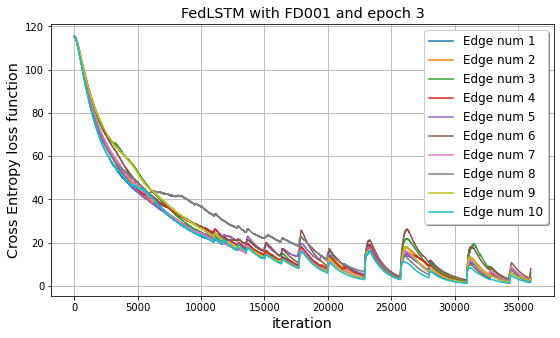

In [37]:
num_workers = 10
iteration_epoch = 3000
epoch = 3
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
cost_each_worker = np.zeros(shape=(num_workers, 4 * epoch *iteration_epoch))
for worker_i in range(num_workers):
    cost_each_worker[worker_i, :] = np.array(J[worker_i]).flatten()
    plt.plot(cost_each_worker[worker_i, :], label="Edge num " + str(worker_i+1))
plt.title("FedLSTM with FD001 and epoch 3", fontsize="x-large")
plt.ylabel("Cross Entropy loss function", fontsize="x-large")
plt.xlabel("iteration", fontsize="x-large")
plt.grid()
legened = plt.legend(shadow=True, fontsize='large')

dir_logdata_FD001_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_logdata_FD001_epoch_3))
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.savefig('J_FD001_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.png', format='png', dpi=1200, bbox_inches='tight')

### Plot test models

C:\Users\LO98E8~1\Temp\234/ipykernel_26072/2686061842.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig[i], ax[i] = plt.subplots()


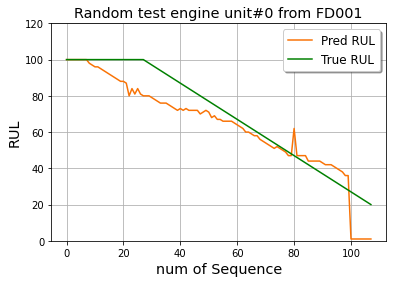

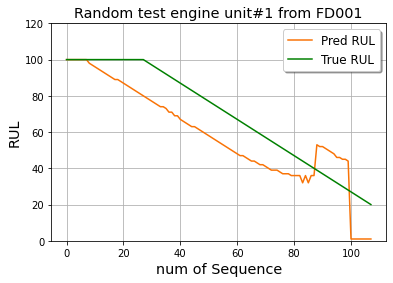

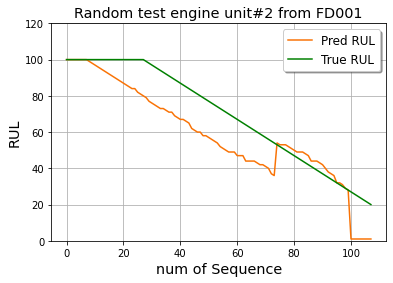

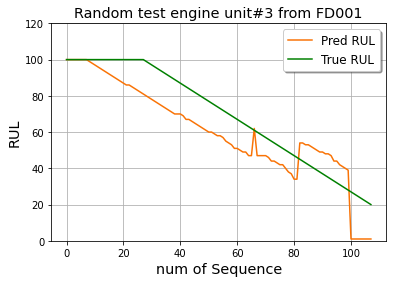

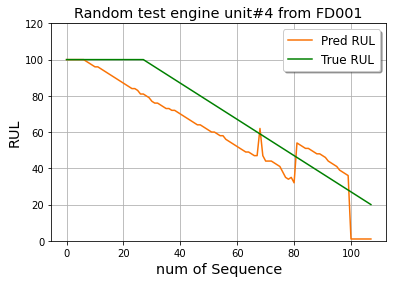

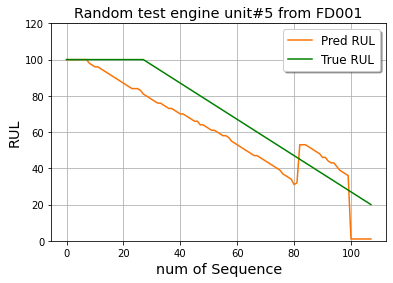

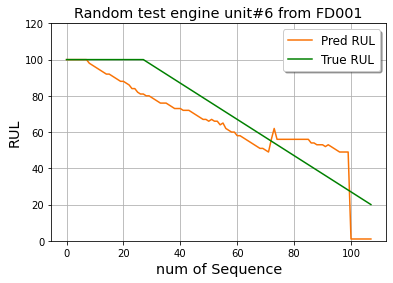

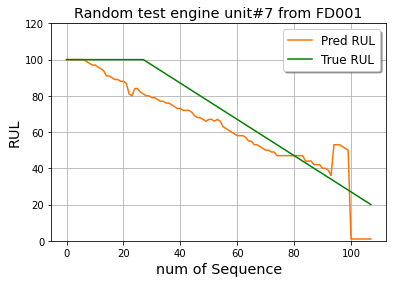

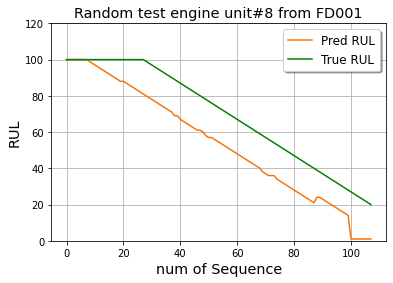

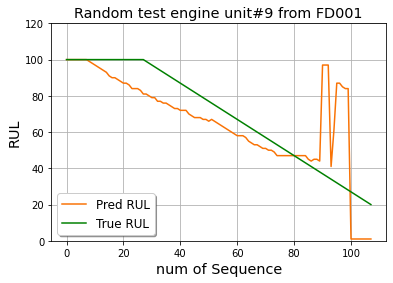

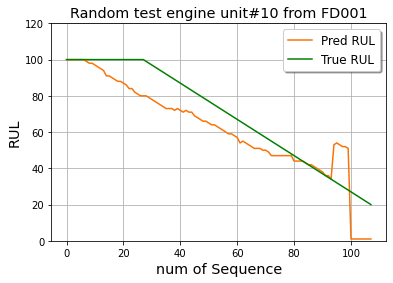

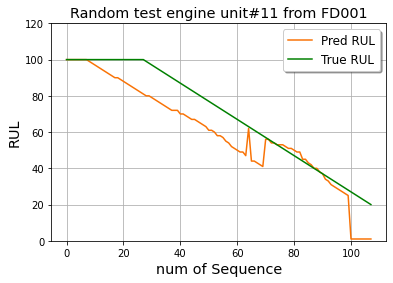

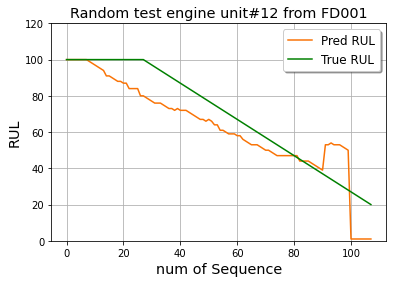

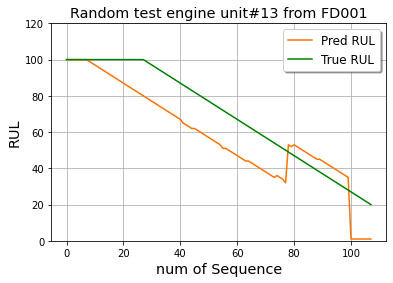

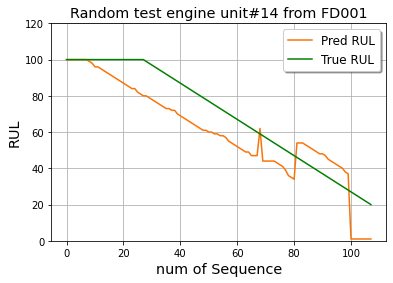

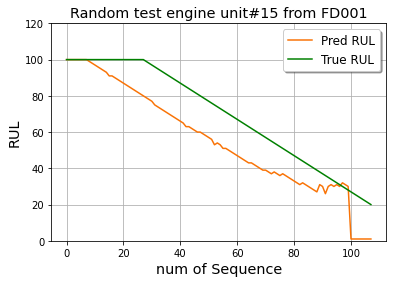

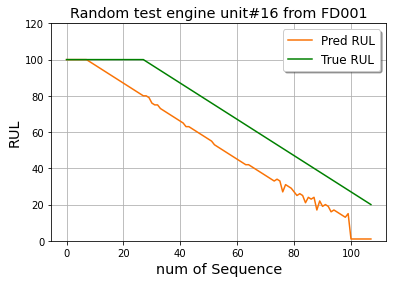

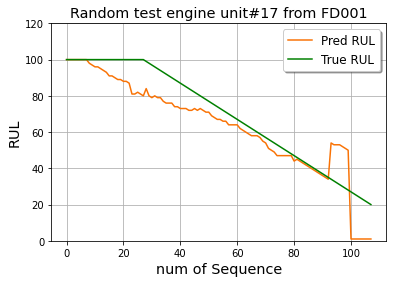

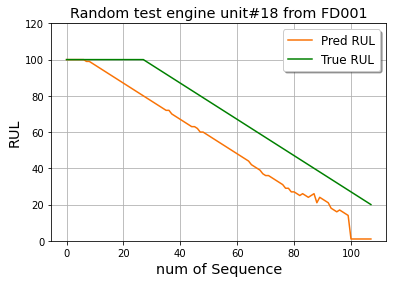

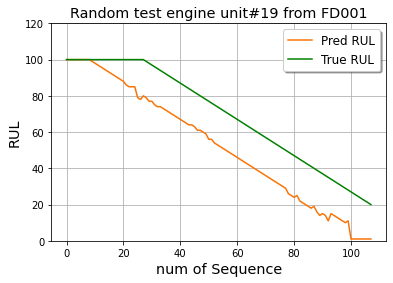

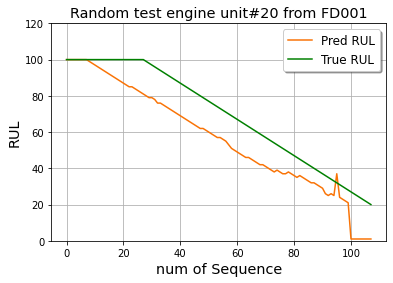

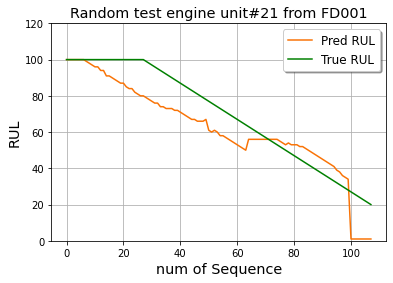

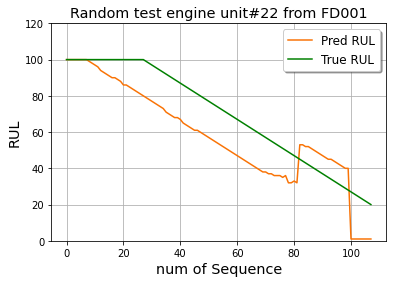

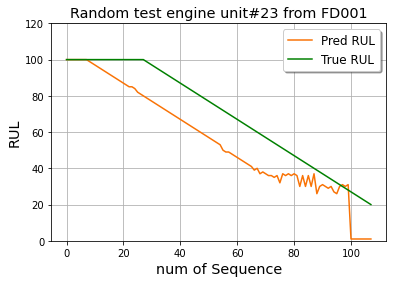

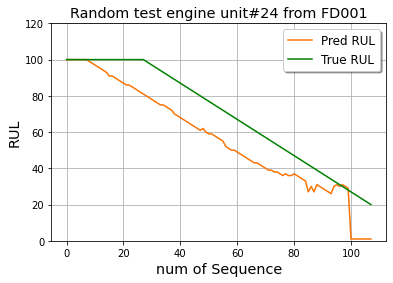

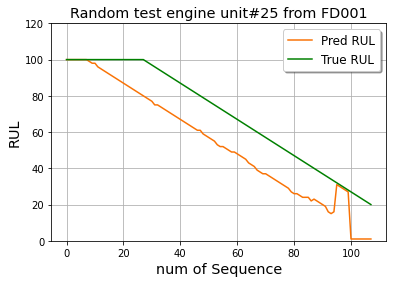

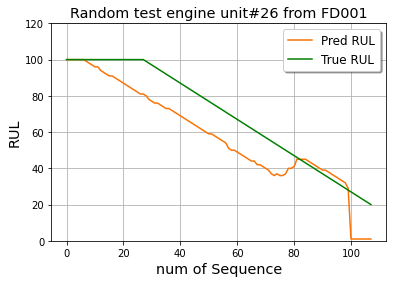

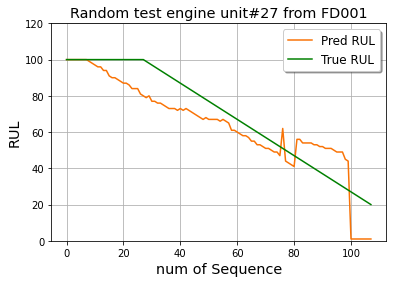

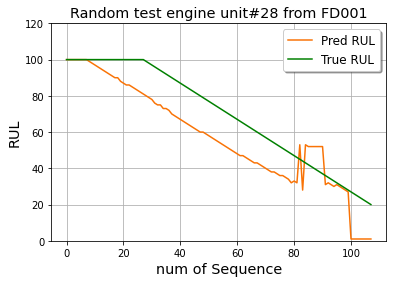

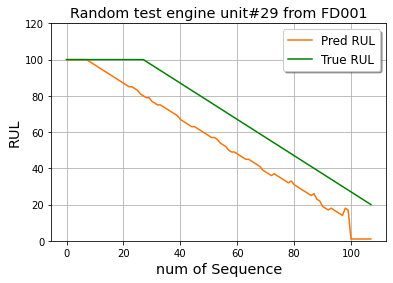

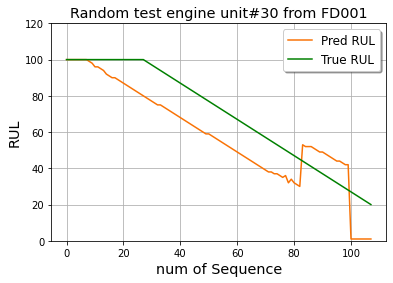

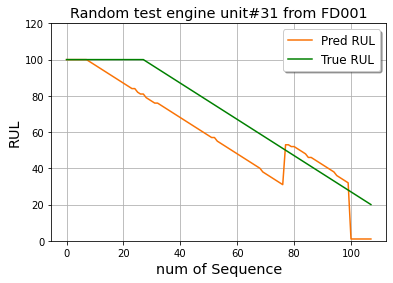

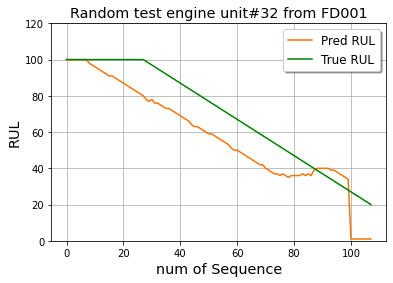

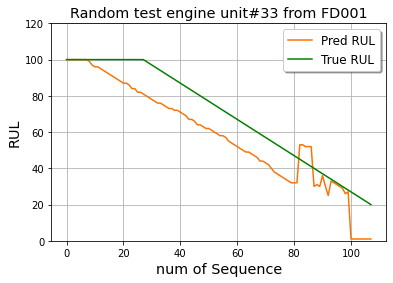

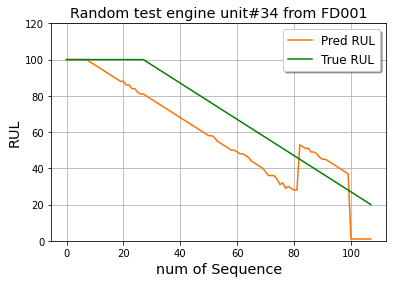

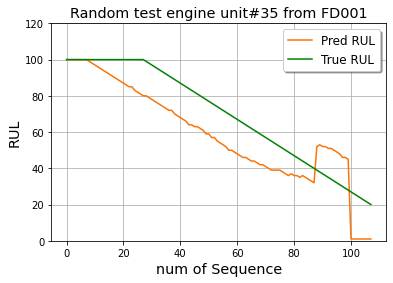

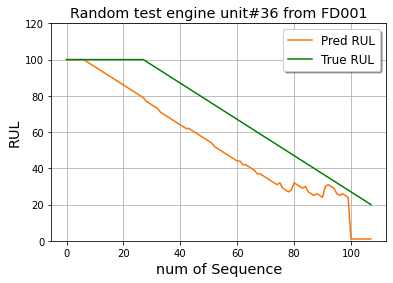

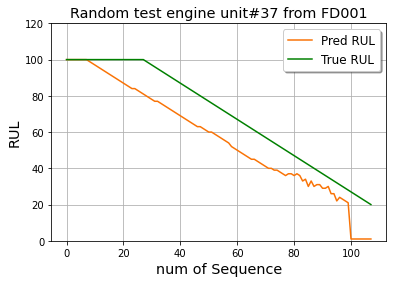

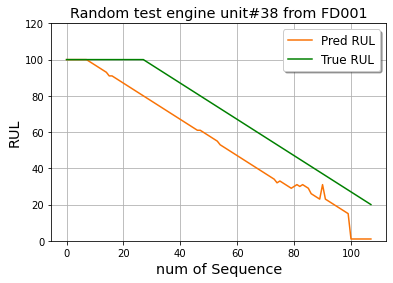

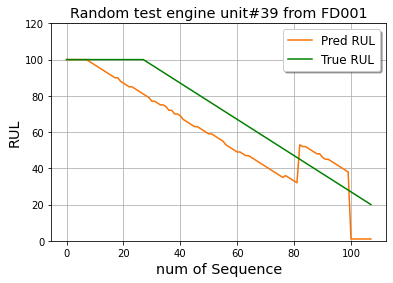

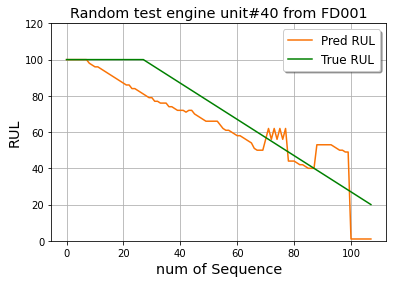

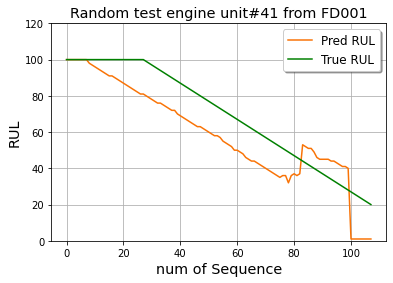

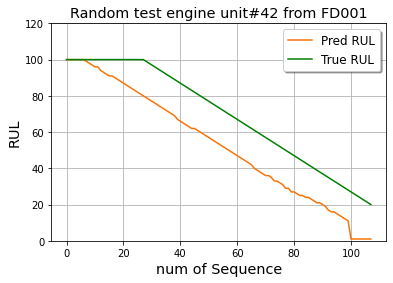

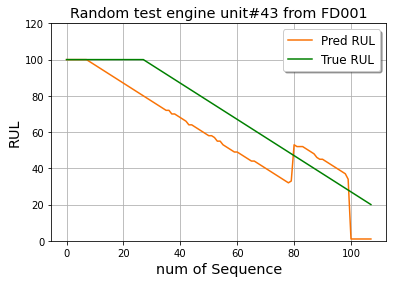

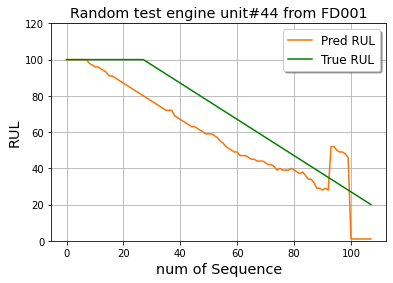

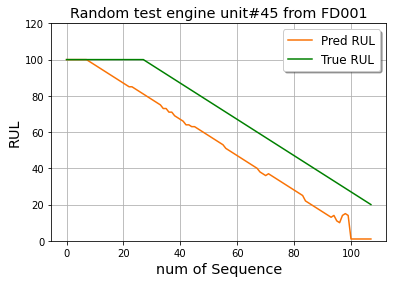

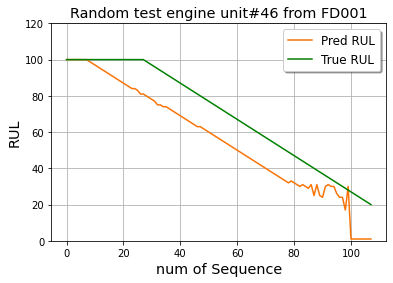

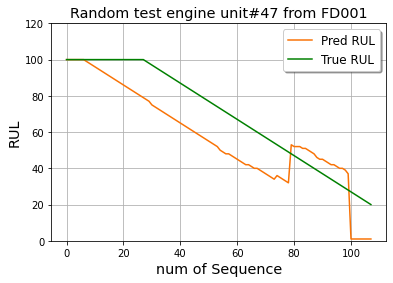

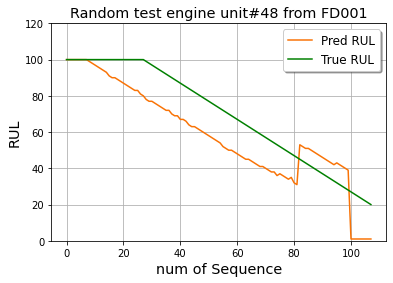

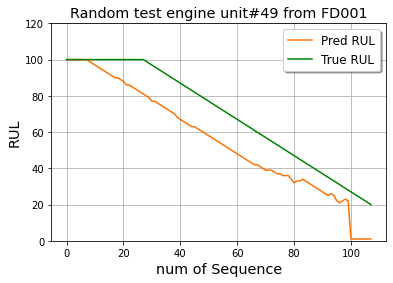

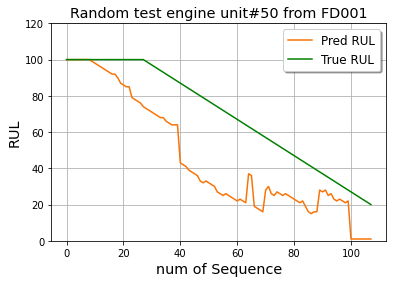

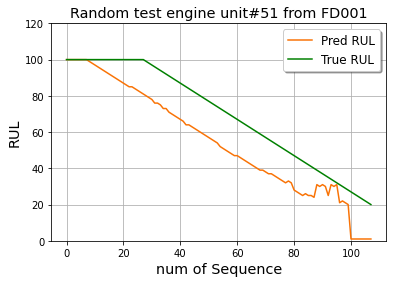

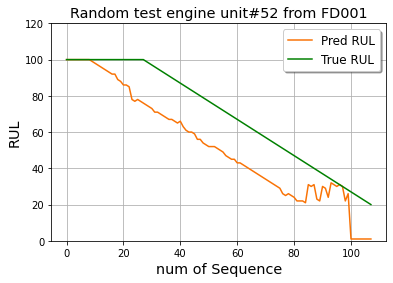

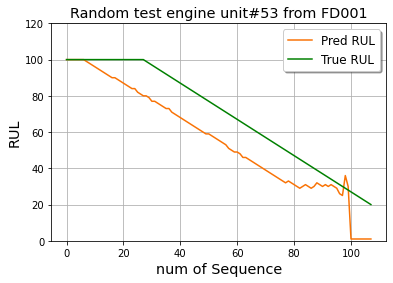

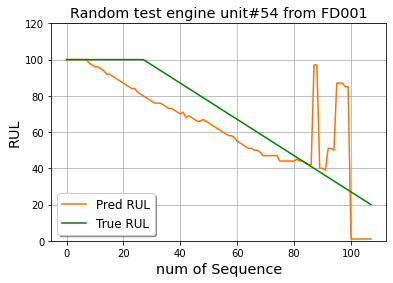

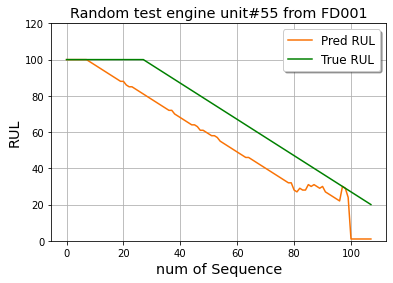

In [42]:
worker_test = LSTM()
fig={}
ax={}
for i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[i], array_params[0])
    fig[i], ax[i] = plt.subplots()
    ax[i].plot(Y_hat, label='Pred RUL', color='#F97306')
    ax[i].plot(Y_test[worker_i], label='True RUL', color='#008000')
    plt.title("Random test engine unit#" + str(i) + " from FD001", fontsize="x-large")
    plt.ylabel("RUL", fontsize="x-large")
    plt.ylim(0, 120)
    plt.xlabel("num of Sequence", fontsize="x-large")
    ax[i].grid()
    ax[i].legend(shadow=True, fontsize='large')
    #plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name_epoch_3))
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_03"+str(worker_i)+".eps", format='eps', dpi=1200)
    #plt.savefig("RUL_10Workers_Final_Cost_itter_3000_alpha_004_epoch_03"+str(worker_i)+".png", format='png', dpi=1200)

In [43]:
# Save Specific figures
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
fig[7].savefig("FD001 RUL prediction with FedLSTM and epoch 3 for machine number_" + str(7) + ".eps", format='eps', dpi=1200, bbox_inches='tight')
fig[7].savefig("FD001 RUL prediction with FedLSTM and epoch 3 for machine number_" + str(7) + ".png", format='png', dpi=1200, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


### RMSE and SCORE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[31.07911132]


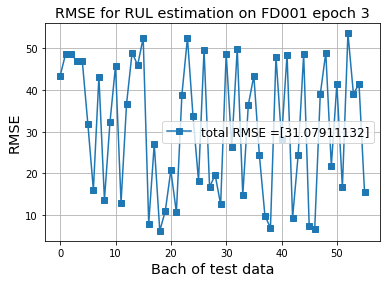

In [41]:
# RMSE and Scoring factor epoch 3
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


RMSE = np.zeros(shape=(len(X_test),1))


for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    RMSE[worker_i] = rmse(Y_hat, Y_test[worker_i])

fig, ax = plt.subplots()
plt.plot(RMSE, label='RMSE', marker = 's')
plt.title("RMSE for RUL estimation on FD001 epoch 3", fontsize="x-large")
plt.ylabel("RMSE", fontsize="x-large")
plt.xlabel("Bach of test data", fontsize="x-large")
plt.grid()

RMSE_epoch_3 = np.sum(RMSE, axis=0)/len(X_test)
labels = []
labels.append("total RMSE ="+str(RMSE_epoch_3))

plt.legend(labels, loc='best', fontsize='large')


print(RMSE_epoch_3)
dir_name: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/Results/epoch_3/"    
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(dir_name))
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 3.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.savefig("RMSE for RUL estimation FedLSTM on test dataset FD001 epoch 3.png", format='png', dpi=1200, bbox_inches='tight')

[-85.4982859  -87.62115951 -87.18047958 -86.51895514 -86.83106196
 -82.65998713 -28.61239498 -86.00815078 -63.64851932 -19.57952052
 -86.56583946 -45.01745606 -84.85808876 -87.21030879 -86.67508863
 -87.58302237 -44.88650965 -78.5732723  -36.27393493 -56.33426257
 -75.11434593  96.8514604  -85.68055556 -87.3953777  -84.8522896
 -70.79116053 -87.44600731 -41.13791806 -61.11943166 -60.71039448
 -87.20038046 -76.8715849  -87.50472712 -53.17121731 -84.36530212
 -86.38967246 -79.49573624 -47.38014816 -37.22558535 -86.75535125
 -79.10169746 -87.21864009 -51.49271896 -72.43469251 -87.37031777
 -43.40283372 -26.15203184 -86.46717991 -87.21996794 -76.81590983
 -86.25117242 -67.60579053 -87.94927971 -86.72878855 -81.85586251
 -65.476732  ]
Final value for SCORE: -69.02563642693333


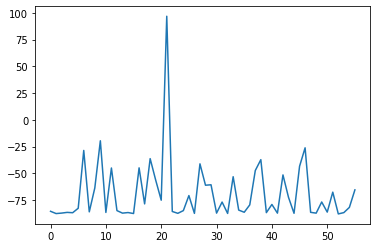

In [44]:
def each_score(predictions, targets):
    tmp = np.zeros(shape=(1, len(predictions)))
    for i in range(len(predictions)):
        Yi = predictions[i] - targets[i]
        if Yi >= 0:
            tmp[:, i] = (np.exp(Yi/10)-1)   
        else:
            tmp[:, i] = np.exp(Yi/13)-1
    return tmp
    
SCORE = np.zeros(shape=(len(X_test), X_test[0].shape[0]))

for worker_i in range(len(X_test)):
    Y_hat = worker_test.test_pred(X_test[worker_i], array_params[0])
    SCORE[worker_i, :] = each_score(Y_hat, Y_test[worker_i])
    
print(np.sum(SCORE, axis=1))
plt.plot(np.sum(SCORE, axis=1))
print("Final value for SCORE:",np.sum(SCORE)/len(X_test))

## Load Cost functions and Parameters

In [101]:
import numpy as np
import pickle
# from model import *

# Import libraries
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import time
import math
import sys
import random

dir_logdata_FD001_epoch_3: str = "H:\.1-Electrical_WorkSpace/Projects/Federated Learning on URL Estimation/Machin Learning/DML_Turbofan/Python/Notebook/Results/FedLSTM/FD001/LogData/epoch_3/ "    
# Load cost from a PKL file
a_file = open(dir_logdata_FD001_epoch_3 + "J_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "rb")
J = pickle.load(a_file)
a_file.close()

# Load params data from a PKL file
a_file = open(dir_logdata_FD001_epoch_3 + "array_params_10Workers_Final_Cost_FedLSTM_itter_3000_alpha_004_epoch_03.pkl", "rb")
array_params = pickle.load(a_file)
print(array_params)
a_file.close()

[{'Wf': array([[-0.18564977,  0.0322141 , -0.04818845, ..., -0.12048841,
         0.09804777,  0.05325   ],
       [-0.06109197,  0.09811411, -0.04168961, ...,  0.08114126,
         0.08047905,  0.05512676],
       [-0.12158022, -0.13627538, -0.17668155, ..., -0.20193493,
         0.20272957,  0.12999881],
       ...,
       [ 0.01255876,  0.16984161,  0.03624951, ..., -0.08108413,
         0.04121908,  0.00478767],
       [ 0.02036318,  0.06390896, -0.02934949, ...,  0.06846599,
         0.09238949,  0.08252651],
       [ 0.04791726,  0.01360442, -0.01159031, ...,  0.07645322,
         0.05202115,  0.05020851]]), 'bf': array([[1.05032015],
       [1.08373612],
       [1.08920687],
       [1.02828693],
       [1.0825476 ],
       [1.14573225],
       [1.04020056],
       [1.06803859],
       [1.07327751],
       [1.0113719 ],
       [1.0307025 ],
       [1.02641318],
       [1.07471422],
       [1.07047969],
       [1.10095669],
       [1.0111647 ],
       [1.06367949],
       [1.00765